# Hoe dit model werkt

 How the Predictive Maintenance Model Works

Our current solution is a per-machine anomaly detection pipeline trained to flag subtle, persistent signs of cooling/heating degradation before alarms fire. 

The model detects early signals of degrading cooling and heating behavior in hatchery setter machines, based on sensor logs per incubation cycle. It does not wait for alarms to fire — it aims to flag abnormal behavior before alarms happen, so maintenance can act proactively.

How does it work?

1. Scope & Context
	•	Focus: Only on setter machines (MachineCycle.CycleType == 0 and MachineID prefix “S”).
	•	Input logs:
	•	ClimateLog: temperature & setpoints per section.
	•	ClimateLogExtra: %Cooling, %Heating, valve positions, RPMs.
	•	AHUClimateLog: room and discharge temps.
	•	ErrorLog + AlarmTranslation: for validation only.


2. Cycle-Based Data Structuring

Each machine has many incubation cycles. We:
	•	Use MachineCycle.parquet to find valid setter cycles (18–21 days).
	•	Join logs (ClimateLog, Extra, AHU) to cycles by MachineID and timestamps.
	•	This ensures every row is tied to a real cycle window.

3. Preprocessing
	•	Resample all logs to uniform 10-minute intervals.
	•	Denoise with a 5-point rolling median to reduce sensor jitter.
	•	Filter out cycles with known critical errors (like temperature sensor failure).

4. Feature Engineering

For each 10-min window in a cycle, you compute features like:


| Category | Features |
| :----------------- | :-------------------------------------------------------------- |
| Control Gap | meas\tempN – setpoint\_tempN per section (mean, std) |
| Duty Cycles | %Cooling, %Heating per section (mean, variance, duty ratio) |
| Chamber Efficiency | room\temp – discharge\_temp, trend vs %Cooling |
| Valve & Fan | Valve position behavior, Pulsator RPM stats |
| Sensor Health | Missing values, flat-lines, spikes |
| CO₂ Behavior | CO₂ levels and trends for phase detection |
| Cycle Phase | Phase 1 (start), Phase 2 (steady), Phase 3 (hatch) based on incubation time |


These are calculated per (MachineID, Section) or per machine, with rolling windows (30–60 mins) to capture trends, not just snapshots.

5. Baseline & Anomaly Models

✅ Rule-Based Detector
	•	Flags a window if, for example:
	•	mean_control_gap > 0.5°C and %Cooling > 80% for 3+ windows
	•	Simple threshold logic to catch “obvious” degrading behavior.

✅ Unsupervised Ensemble Model

Trained only on clean cycles, combining:
	•	PCA: Projects features to 2D, computes distance from cluster center.
	•	DBSCAN: Flags dense vs. sparse outliers.
	•	Isolation Forest: Detects anomalies based on tree partitions.

Combined via:
ensemble_score = (zscore_PCA + db_flag + iforest_score) / 3

Every 10-minute window gets an ensemble anomaly score between 0 and 1.

6. Anomaly Aggregation per Cycle

Rather than flagging every small spike, you:
	•	Aggregate window-level anomaly flags into cycle-level metrics:
	•	% of windows flagged
	•	% in startup, steady, hatch phase
	•	Most abnormal section(s)

This gives a per-cycle risk profile for each machine.


⸻

7. Machine Risk Score (Rolling Window)

For each machine:
	•	Track its last N (e.g., 3) cycles.
	•	Compute a rolling risk score = mean + slope of anomaly rate trend.
	•	Machines with rising anomaly rates over time are flagged for early maintenance.

⸻

8. Alarm Validation (Not Training)
	•	Actual alarms (Temperature High, Fan Error, etc.) from ErrorLog are used only for evaluation.
	•	You check if flagged cycles or windows occurred before these alarms, but you do not use the alarms to train or label the model.



 Model Intent: Early Fault Detection (Predictive Maintenance)

The model’s goal is to:
	•	Flag degrading machines weeks before failure, not hours before.
	•	Prioritize technician effort on machines with:
	•	Subtle cooling inefficiencies
	•	Persistent high %Cooling when it shouldn’t be
	•	Growing control gaps in specific sections
	•	Drops in chamber efficiency (room vs. discharge temp)

⸻

What we Monitor

For each flagged machine/cycle:
	•	The top-3 abnormal features (e.g., "control_gap_sec3", "ΔT drop").
	•	A mini sparkline chart of temp vs. setpoint + %Cooling.
	•	Anomaly score trend over time.

These are embedded in a dashboard for technician review and validation.

--------

# PHASE 0: OPERATIONAL FOUNDATIONS & PERFORMANCE BASELINES

# Phase 1 - Cell 1: Business Context & Setter Identification


In [3]:
# Load Data Files (CORRECTED with fix for dummy MachineCycle)
import pandas as pd
import numpy as np
from pathlib import Path

print("📂 LOADING DATA FILES (CORRECTED)")
print("=" * 50)

data_dir = Path(".")

# --- Create dummy files if they don't exist for testing purposes ---
dummy_files_created = False
files_to_check_or_create = {
    "ClimateLog.parquet": pd.DataFrame({'MachineID': [1,1,6,6], 'TimeStamp': pd.to_datetime(['2023-01-01 00:00:00', '2023-01-01 00:10:00', '2023-01-01 00:00:00', '2023-01-01 00:10:00']), 'Temperature': [20,21,20,21]}),
    "ClimateLogExtra.parquet": pd.DataFrame({'MachineID': [1,1,6,6], 'TimeStamp': pd.to_datetime(['2023-01-01 00:00:00', '2023-01-01 00:10:00', '2023-01-01 00:00:00', '2023-01-01 00:10:00']), 'Cooling': [5,10,6,12]}),
    # CORRECTED LINE FOR MachineCycle.parquet:
    "MachineCycle.parquet": pd.DataFrame({
        'MachineID': [1, 6], 
        'StartDateTime': pd.to_datetime(['2023-01-01 00:00:00', '2023-01-02 00:00:00']), 
        'EndDateTime': pd.to_datetime(['2023-01-01 01:00:00', '2023-01-02 01:00:00'])
    }),
    "MachinePositions.parquet": pd.DataFrame({'MachineID': [1,6,66,67], 'text': ['S01','S06','H01','H02'], 'xposition':[0,0,0,0], 'yposition':[0,0,0,0]}),
    "ErrorLog.parquet": pd.DataFrame({'MachineID': [1, 6], 'StartTimeStamp': pd.to_datetime(['2023-01-01 00:30:00', pd.NaT]), 'EndTimeStamp': pd.to_datetime(['2023-01-01 00:35:00', pd.NaT])}),
    "AlarmTranslation.parquet": pd.DataFrame({'AlarmID': [1, 2], 'Description': ['Test Alarm 1', 'Test Alarm 2']}),
    "AHUClimateLog.parquet": pd.DataFrame({'MachineID': [66,67], 'TimeStamp': pd.to_datetime(['2023-01-01 00:00:00', '2023-01-01 00:10:00']), 'Temperature': [20,21]})
}
# Check and create dummy files only if your actual files are missing
# This is primarily for demonstration. In your real workflow, ensure your Parquet files are present.
print("--- Checking for actual files before creating dummies ---")
actual_files_present = True
for fname in files_to_check_or_create.keys():
    if not (data_dir / fname).exists():
        print(f"   Actual file '{fname}' not found.")
        actual_files_present = False
        # break # Uncomment if you want to stop if any actual file is missing

if not actual_files_present:
    print("--- Some actual files are missing. Creating dummy files for those not found. ---")
    for fname, df_content in files_to_check_or_create.items():
        if not (data_dir / fname).exists(): # Only create if actual file is missing
            print(f"   Creating dummy file: {fname}")
            df_content.to_parquet(data_dir / fname)
            dummy_files_created = True
    if dummy_files_created:
        print("   --- Dummy files created for demonstration ---")
else:
    print("--- All expected actual files seem to be present. Skipping dummy file creation. ---")
# --- End of dummy file creation ---


# Load each dataset
try:
    climate_log_file_to_load = 'ClimateLog.parquet'
    if Path(climate_log_file_to_load).exists():
        climate_log = pd.read_parquet(data_dir / climate_log_file_to_load)
        print(f"✅ Loaded '{climate_log_file_to_load}' into 'climate_log': {climate_log.shape}")
        if 'MachineID' in climate_log.columns:
            print(f"   Sample MachineIDs: {sorted(climate_log['MachineID'].unique())[:5]}...")
    else:
        print(f"❌ '{climate_log_file_to_load}' not found! 'climate_log' will be empty.")
        climate_log = pd.DataFrame()

    if Path('MachineCycle.parquet').exists():
        machine_cycle = pd.read_parquet(data_dir / 'MachineCycle.parquet')
        print(f"✅ Loaded MachineCycle: {machine_cycle.shape}")
    else:
        print("⚠️  MachineCycle.parquet not found, 'machine_cycle' will be None.")
        machine_cycle = None
    
    if Path('MachinePositions.parquet').exists():
        machine_positions = pd.read_parquet(data_dir / 'MachinePositions.parquet')
        print(f"✅ Loaded MachinePositions: {machine_positions.shape}")
    else:
        print("❌ MachinePositions.parquet not found! 'machine_positions' will be empty. Phase 1 will likely fail.")
        machine_positions = pd.DataFrame()
        
    if Path('ErrorLog.parquet').exists():
        error_log = pd.read_parquet(data_dir / 'ErrorLog.parquet')
        print(f"✅ Loaded ErrorLog: {error_log.shape}")
    else:
        print("⚠️  ErrorLog.parquet not found, 'error_log' will be None.")
        error_log = None
    
    alarm_translation_df = pd.DataFrame()
    if Path('AlarmTranslation.parquet').exists():
        alarm_translation_df = pd.read_parquet(data_dir / 'AlarmTranslation.parquet')
        print(f"✅ Loaded AlarmTranslation: {alarm_translation_df.shape}")
    else:
        print("⚠️  AlarmTranslation.parquet not found.")
        
    if Path('ClimateLogExtra.parquet').exists():
        climate_extra = pd.read_parquet(data_dir / 'ClimateLogExtra.parquet')
        print(f"✅ Loaded ClimateLogExtra: {climate_extra.shape}")
        if 'MachineID' in climate_extra.columns:
             print(f"   Sample MachineIDs: {sorted(climate_extra['MachineID'].unique())[:5]}...")
    else:
        print("⚠️  ClimateLogExtra.parquet not found, 'climate_extra' will be None.")
        climate_extra = None
    
    print("\n📊 Data Loading Summary:")
    print(f"   'climate_log' (from {climate_log_file_to_load}) loaded: {'Yes' if 'climate_log' in globals() and not climate_log.empty else 'NO or EMPTY'}")
    print(f"   'machine_cycle' loaded: {'Yes' if 'machine_cycle' in globals() and machine_cycle is not None and not machine_cycle.empty else 'No or EMPTY'}")
    print(f"   'machine_positions' loaded: {'Yes' if 'machine_positions' in globals() and not machine_positions.empty else 'No or EMPTY'}")
    print(f"   'climate_extra' loaded: {'Yes' if 'climate_extra' in globals() and climate_extra is not None and not climate_extra.empty else 'No or EMPTY'}")

except FileNotFoundError as e:
    print(f"❌ Error during data loading (FileNotFoundError): {e}")
except Exception as e:
    print(f"❌ General error loading data: {e}")

if 'climate_log' in globals() and isinstance(climate_log, pd.DataFrame) and not climate_log.empty:
    print("\n🔍 Inspected 'climate_log' (post-load):")
    if 'MachineID' in climate_log.columns:
        print(f"   Sample MachineIDs: {sorted(climate_log['MachineID'].unique())[:10]}...")
    else:
        print("   'MachineID' column missing in loaded 'climate_log'.")
else:
     print("\n🔍 'climate_log' not available for inspection or is empty.")


📂 LOADING DATA FILES (CORRECTED)
--- Checking for actual files before creating dummies ---
--- All expected actual files seem to be present. Skipping dummy file creation. ---
✅ Loaded 'ClimateLog.parquet' into 'climate_log': (25927287, 34)
   Sample MachineIDs: [1, 2, 3, 4, 5]...
✅ Loaded MachineCycle: (27320, 5)
✅ Loaded MachinePositions: (80, 10)
✅ Loaded ErrorLog: (315174, 7)
✅ Loaded AlarmTranslation: (536, 16)
✅ Loaded ClimateLogExtra: (8549963, 22)
   Sample MachineIDs: [1, 6, 7, 8, 9]...

📊 Data Loading Summary:
   'climate_log' (from ClimateLog.parquet) loaded: Yes
   'machine_cycle' loaded: Yes
   'machine_positions' loaded: Yes
   'climate_extra' loaded: Yes

🔍 Inspected 'climate_log' (post-load):
   Sample MachineIDs: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]...


In [4]:
# Phase 1 - Cell 1: Business Context & Robust Data Foundation
# Royal Pas Reform - Setter-Focused Anomaly Detection System

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

print("🎯 PHASE 1: FOUNDATIONS & SETTER SCOPE")
print("=" * 50)
print("🐣 Business Context: Global Hatchery Setter Monitoring")
print("📋 Focus: 18-day incubation cycles (may run longer)")
print("🚨 Goal: Catch subtle heating/cooling deviations BEFORE alarm rates spike")
print("⚠️  Built-in alarms fire late - we predict maintenance needs early")
print()

# Use existing loaded datasets but ensure robust timestamp handling
print("🔧 ROBUST TIMESTAMP & ALARM PROCESSING")
print("-" * 40)

# Robust timestamp conversion function
def ensure_robust_timestamps(df, timestamp_col, df_name, handle_zeros=False):
    """Ensure robust timestamp conversion with fallback strategies"""
    if timestamp_col not in df.columns:
        print(f"   ⚠️  {timestamp_col} not found in {df_name}")
        return
    
    col_data = df[timestamp_col]
    
    if pd.api.types.is_numeric_dtype(col_data):
        # Handle zeros for incomplete cycles (mainly EndDateTime)
        if handle_zeros:
            df[f'{timestamp_col}_epoch_raw'] = col_data.copy()
            col_for_conversion = col_data.replace(0, np.nan)
        else:
            col_for_conversion = col_data
            
        df[f'{timestamp_col}_epoch'] = col_for_conversion
        df[f'{timestamp_col}_dt'] = pd.to_datetime(col_for_conversion, unit='s', errors='coerce')
        
        null_count = df[f'{timestamp_col}_dt'].isnull().sum()
        valid_count = df[f'{timestamp_col}_dt'].notna().sum()
        print(f"   ✅ {df_name}.{timestamp_col}: {valid_count:,} valid timestamps")
        if null_count > 0:
            print(f"      ⚠️  {null_count:,} null values (zeros/invalid)")
            
    elif pd.api.types.is_datetime64_any_dtype(col_data):
        df[f'{timestamp_col}_dt'] = col_data
        df[f'{timestamp_col}_epoch'] = (col_data - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
        print(f"   ✅ {df_name}.{timestamp_col}: Already datetime format")
    else:
        print(f"   ❌ {df_name}.{timestamp_col}: Unknown format")
        df[f'{timestamp_col}_dt'] = pd.NaT
        df[f'{timestamp_col}_epoch'] = pd.NA

# Apply robust timestamp conversion to key datasets
if 'climate_log' in globals() and climate_log is not None:
    ensure_robust_timestamps(climate_log, 'TimeStamp', 'ClimateLog')

if 'climate_extra' in globals() and climate_extra is not None:
    ensure_robust_timestamps(climate_extra, 'TimeStamp', 'ClimateLogExtra')

if 'machine_cycle' in globals() and machine_cycle is not None:
    ensure_robust_timestamps(machine_cycle, 'StartDateTime', 'MachineCycle')
    ensure_robust_timestamps(machine_cycle, 'EndDateTime', 'MachineCycle', handle_zeros=True)

if 'error_log' in globals() and error_log is not None:
    for col in ['StartTimeStamp', 'EndTimeStamp']:
        if col in error_log.columns:
            ensure_robust_timestamps(error_log, col, 'ErrorLog')

print()
print("🔍 STEP 1: SETTER MACHINE IDENTIFICATION")
print("-" * 40)

# Examine machine positions for setter identification
if 'machine_positions' in globals() and machine_positions is not None:
    print("📋 Machine Positions Analysis:")
    print(f"   Shape: {machine_positions.shape}")
    
    if 'MachineID' in machine_positions.columns:
        total_machines = machine_positions['MachineID'].nunique()
        machine_range = (machine_positions['MachineID'].min(), machine_positions['MachineID'].max())
        print(f"   Total machines: {total_machines} (ID range: {machine_range[0]}-{machine_range[1]})")
        
        # Look for setter identification patterns in string columns
        string_cols = machine_positions.select_dtypes(include=['object']).columns.tolist()
        
        setter_machines = set()
        setter_identification_method = None
        
        # Strategy 1: Look for 'S' prefix or setter indicators in string columns
        for col in string_cols:
            if col in machine_positions.columns:
                unique_values = machine_positions[col].unique()
                setter_indicators = [val for val in unique_values if val and str(val).upper().startswith('S')]
                
                if setter_indicators:
                    print(f"   🎯 Setter indicators found in {col}: {setter_indicators}")
                    setter_mask = machine_positions[col].str.upper().str.startswith('S', na=False)
                    setter_machines.update(machine_positions.loc[setter_mask, 'MachineID'].tolist())
                    setter_identification_method = f"String column '{col}' with 'S' prefix"
                    break
        
        # Strategy 2: If no string indicators, examine machine ID patterns
        if not setter_machines and 'MachineID' in machine_positions.columns:
            # Check if certain machine ID ranges correspond to setters
            all_machine_ids = set(machine_positions['MachineID'].unique())
            
            # Assume setters might be in a specific range (common in industrial settings)
            # This is a heuristic - may need adjustment based on actual data
            potential_setter_ranges = [
                (1, 20),    # Lower range setters
                (100, 120), # Higher range setters
            ]
            
            for start, end in potential_setter_ranges:
                range_machines = [mid for mid in all_machine_ids if start <= mid <= end]
                if range_machines:
                    print(f"   🤔 Potential setter range {start}-{end}: {len(range_machines)} machines")
        
        # Strategy 3: Check climate log for machine activity patterns
        if not setter_machines and 'climate_log' in globals() and climate_log is not None:
            print("   🔍 Analyzing climate data for setter patterns...")
            if 'MachineID' in climate_log.columns:
                climate_machines = set(climate_log['MachineID'].unique())
                common_machines = all_machine_ids.intersection(climate_machines)
                print(f"   📊 {len(common_machines)} machines have climate data")
                
                # For now, use all machines with climate data as potential setters
                # This will be refined in next steps
                setter_machines = common_machines
                setter_identification_method = "All machines with climate data (to be refined)"
        
        if setter_machines:
            print(f"\n   ✅ SETTER MACHINES IDENTIFIED: {len(setter_machines)} machines")
            print(f"   🔍 Method: {setter_identification_method}")
            print(f"   📋 Setter IDs: {sorted(list(setter_machines))[:10]}{'...' if len(setter_machines) > 10 else ''}")
        else:
            print("   ⚠️  No clear setter machines identified yet - will refine in next steps")
            setter_machines = set()
    
    # Check for position information (edge vs center)
    position_cols = [col for col in machine_positions.columns 
                    if any(keyword.lower() in col.lower() 
                          for keyword in ['position', 'location', 'zone', 'section', 'edge', 'center'])]
    
    if position_cols:
        print(f"\n   🗺️  Position-related columns: {position_cols}")
        for col in position_cols[:2]:  # Show first 2 position columns
            if col in machine_positions.columns:
                print(f"   📍 {col} distribution:")
                value_counts = machine_positions[col].value_counts()
                for value, count in value_counts.head(5).items():
                    print(f"      {value}: {count} machines")
    
    # Store setter information for next phases
    globals()['identified_setter_machines'] = setter_machines
    globals()['setter_identification_method'] = setter_identification_method
    
else:
    print("❌ MachinePositions dataset not available")
    globals()['identified_setter_machines'] = set()

print()
print("📊 DATA SUMMARY FOR PHASE 1:")
print("-" * 30)
datasets_status = [
    ('climate_log', 'ClimateLog'),
    ('climate_extra', 'ClimateLogExtra'),
    ('machine_cycle', 'MachineCycle'),
    ('machine_positions', 'MachinePositions'),
    ('error_log', 'ErrorLog')
]

for var_name, display_name in datasets_status:
    if var_name in globals() and globals()[var_name] is not None:
        df = globals()[var_name]
        # Check for timestamp columns
        ts_cols = [col for col in df.columns if col.endswith('_dt')]
        ts_status = f", {len(ts_cols)} timestamp cols" if ts_cols else ""
        print(f"   ✅ {display_name}: {df.shape[0]:,} rows{ts_status}")
    else:
        print(f"   ❌ {display_name}: Not available")

print(f"\n🎯 Identified {len(globals().get('identified_setter_machines', set()))} setter machines")
print("\n" + "="*60)
print("📋 PHASE 1 COMPLETE - READY FOR PHASE 2: CYCLE SEGMENTATION")

🎯 PHASE 1: FOUNDATIONS & SETTER SCOPE
🐣 Business Context: Global Hatchery Setter Monitoring
📋 Focus: 18-day incubation cycles (may run longer)
🚨 Goal: Catch subtle heating/cooling deviations BEFORE alarm rates spike
⚠️  Built-in alarms fire late - we predict maintenance needs early

🔧 ROBUST TIMESTAMP & ALARM PROCESSING
----------------------------------------
   ✅ ClimateLog.TimeStamp: Already datetime format
   ✅ ClimateLogExtra.TimeStamp: Already datetime format
   ✅ MachineCycle.StartDateTime: 27,320 valid timestamps
   ✅ MachineCycle.EndDateTime: 27,251 valid timestamps
      ⚠️  69 null values (zeros/invalid)
   ✅ ErrorLog.StartTimeStamp: 315,174 valid timestamps
   ✅ ErrorLog.EndTimeStamp: 315,174 valid timestamps

🔍 STEP 1: SETTER MACHINE IDENTIFICATION
----------------------------------------
📋 Machine Positions Analysis:
   Shape: (80, 10)
   Total machines: 80 (ID range: 1-124)
   🎯 Setter indicators found in text: ['S24', 'S23', 'S25', 'S26', 'S27', 'S28', 'S29', 'S30', 'S1

In [5]:
# Phase 2 - Cell 2 (IMPROVED & ROBUST): Cycle Segmentation & Climate Data Preparation
import pandas as pd

print("🎯 PHASE 2: CYCLE SEGMENTATION & DATA SLICING (IMPROVED)")
print("=" * 50)
print("📋 Goal: Extract completed setter cycles and prepare ALL relevant climate data")
print("🔍 Focus: True cycle boundaries and ensuring all climate logs are filtered")
print()

# --- STEP 0: VERIFY PREREQUISITES FROM PHASE 1 ---
if 'identified_setter_machines' not in globals() or not identified_setter_machines:
    print("❌ FATAL ERROR: 'identified_setter_machines' (from Phase 1) not found or empty. Please RE-RUN PHASE 1 successfully.")
    # To prevent further errors, we'll stop if this critical piece is missing.
    # You might want to raise an error or handle this more gracefully in a full script.
    raise ValueError("'identified_setter_machines' is crucial and missing.")
else:
    # Use the confirmed list of setter IDs from Phase 1
    setter_ids_for_filtering = identified_setter_machines 
    print(f"✅ Using {len(setter_ids_for_filtering)} setter machines from Phase 1: {sorted(list(setter_ids_for_filtering))[:10]}...")

# Verify other necessary DataFrames from Phase 1/Data Loading
for df_name in ['machine_cycle', 'climate_log', 'climate_extra']: # climate_extra is now important
    if df_name not in globals() or globals()[df_name] is None or globals()[df_name].empty:
        print(f"❌ WARNING: DataFrame '{df_name}' not found or is empty. This might affect results.")
        if df_name == 'climate_extra':
            print("   Proceeding without ClimateLogExtra, but some features in Phase 4 might be unavailable.")
            globals()[df_name] = pd.DataFrame() # Create empty df to avoid errors, though it limits features
        # else:
            # For machine_cycle and climate_log, it's more critical. Consider raising an error.
            # pass 
print()

# --- STEP 1: FILTER MACHINE CYCLE TO COMPLETED SETTER CYCLES ---
print("🔧 STEP 1: FILTER MACHINE CYCLE TO COMPLETED SETTER CYCLES")
print("-" * 55)

completed_setter_cycles = pd.DataFrame() 

if 'machine_cycle' in globals() and not machine_cycle.empty and len(setter_ids_for_filtering) > 0:
    if not all(col in machine_cycle.columns for col in ['MachineID', 'StartDateTime_dt', 'EndDateTime_dt']):
        print("   ❌ ERROR: 'machine_cycle' is missing 'MachineID' or one of the '_dt' timestamp columns.")
    else:
        setter_cycles_df = machine_cycle[machine_cycle['MachineID'].isin(setter_ids_for_filtering)].copy()
        print(f"   📊 Initial setter cycles (from MachineID filter): {len(setter_cycles_df):,} cycles")
        
        completed_mask = (
            setter_cycles_df['StartDateTime_dt'].notna() & 
            setter_cycles_df['EndDateTime_dt'].notna() &
            (setter_cycles_df['EndDateTime_dt'] > setter_cycles_df['StartDateTime_dt']) 
        )
        completed_setter_cycles = setter_cycles_df[completed_mask].copy()
        print(f"   ✅ Completed setter cycles (valid & sequential start/end): {len(completed_setter_cycles):,}")
        
        if not completed_setter_cycles.empty:
            if 'CycleID' not in completed_setter_cycles.columns:
                 completed_setter_cycles.loc[:, 'CycleID'] = range(len(completed_setter_cycles))
            completed_setter_cycles.loc[:, 'cycle_duration_hours'] = (
                completed_setter_cycles['EndDateTime_dt'] - completed_setter_cycles['StartDateTime_dt']
            ).dt.total_seconds() / 3600
            completed_setter_cycles.loc[:, 'cycle_duration_days'] = completed_setter_cycles['cycle_duration_hours'] / 24.0
            # Stats printing can be added here if desired
        else:
            print("   ℹ️ No completed setter cycles found after basic filtering.")
else:
    print("   ℹ️ 'machine_cycle' data not available or no setter machines identified to filter.")

globals()['completed_setter_cycles'] = completed_setter_cycles

# --- STEP 2: PREPARE CLIMATE DATA FOR SETTERS ---
print("\n🔧 STEP 2: PREPARE ALL CLIMATE DATA FOR SETTERS")
print("-" * 45)

# Filter main ClimateLog
setter_climate_log = pd.DataFrame()
if 'climate_log' in globals() and not climate_log.empty:
    if 'MachineID' in climate_log.columns and 'TimeStamp_dt' in climate_log.columns:
        setter_climate_log = climate_log[climate_log['MachineID'].isin(setter_ids_for_filtering)].copy()
        if not setter_climate_log.empty:
            print(f"   ✅ Filtered 'climate_log': {len(setter_climate_log):,} records for setters (setter_climate_log).")
        else:
            print(f"   ℹ️ No records found in 'climate_log' for the {len(setter_ids_for_filtering)} identified setter machines.")
    else:
        print("   ❌ 'climate_log' is missing 'MachineID' or 'TimeStamp_dt'. Ensure Phase 1 processing is complete.")
else:
    print("   ❌ Main 'climate_log' not available.")

globals()['setter_climate_log'] = setter_climate_log

# Filter ClimateLogExtra
setter_climate_log_extra = pd.DataFrame()
if 'climate_extra' in globals() and not climate_extra.empty:
    if 'MachineID' in climate_extra.columns and 'TimeStamp_dt' in climate_extra.columns:
        setter_climate_log_extra = climate_extra[climate_extra['MachineID'].isin(setter_ids_for_filtering)].copy()
        if not setter_climate_log_extra.empty:
            print(f"   ✅ Filtered 'climate_extra': {len(setter_climate_log_extra):,} records for setters (setter_climate_log_extra).")
        else:
            print(f"   ℹ️ No records found in 'climate_extra' for the {len(setter_ids_for_filtering)} identified setter machines.")
    else:
        print("   ❌ 'climate_extra' is missing 'MachineID' or 'TimeStamp_dt'. Ensure Phase 1 processing is complete.")
else:
    print("   ℹ️ 'climate_extra' (ClimateLogExtra.parquet) not available or empty.")

globals()['setter_climate_log_extra'] = setter_climate_log_extra


# --- STEP 3: PREPARATION FOR NEXT CELL (DURATION FILTERING & LOG SLICING) ---
print("\n🔧 STEP 3: PREPARATION FOR NEXT CELL")
print("-" * 40)

if not completed_setter_cycles.empty:
    print(f"   ✅ {len(completed_setter_cycles):,} initial completed setter cycles ready.")
    if 'cycle_duration_days' in completed_setter_cycles.columns:
         print("      Column 'cycle_duration_days' IS present.")
    else:
         print("      ⚠️ Column 'cycle_duration_days' IS NOT present.")
else:
    print(f"   ℹ️ 'completed_setter_cycles' is empty.")

if not setter_climate_log.empty:
    print(f"   ✅ {len(setter_climate_log):,} records in 'setter_climate_log'.")
else:
    print(f"   ℹ️ 'setter_climate_log' is empty. Slicing main logs will fail or produce no data.")

if not setter_climate_log_extra.empty:
    print(f"   ✅ {len(setter_climate_log_extra):,} records in 'setter_climate_log_extra'.")
else:
    print(f"   ℹ️ 'setter_climate_log_extra' is empty. Extra features will be unavailable.")

print("\n" + "="*60)
print("📋 PHASE 2 CELL 2 (IMPROVED PREPARATION) COMPLETE.")
if setter_climate_log.empty and setter_climate_log_extra.empty:
    print("   ‼️ WARNING: Both 'setter_climate_log' and 'setter_climate_log_extra' are empty. Log slicing will not work.")
elif setter_climate_log.empty:
    print("   ‼️ WARNING: 'setter_climate_log' is empty. Slicing main logs will produce no data.")
else:
    print("   ➡️ Next: 'Phase 2 - Cell 2b: Filter Completed Setter Cycles by Duration'.")


🎯 PHASE 2: CYCLE SEGMENTATION & DATA SLICING (IMPROVED)
📋 Goal: Extract completed setter cycles and prepare ALL relevant climate data
🔍 Focus: True cycle boundaries and ensuring all climate logs are filtered

✅ Using 32 setter machines from Phase 1: [1, 6, 7, 8, 9, 10, 11, 12, 13, 14]...

🔧 STEP 1: FILTER MACHINE CYCLE TO COMPLETED SETTER CYCLES
-------------------------------------------------------
   📊 Initial setter cycles (from MachineID filter): 5,459 cycles
   ✅ Completed setter cycles (valid & sequential start/end): 5,423

🔧 STEP 2: PREPARE ALL CLIMATE DATA FOR SETTERS
---------------------------------------------
   ✅ Filtered 'climate_log': 12,089,926 records for setters (setter_climate_log).
   ✅ Filtered 'climate_extra': 3,891,705 records for setters (setter_climate_log_extra).

🔧 STEP 3: PREPARATION FOR NEXT CELL
----------------------------------------
   ✅ 5,423 initial completed setter cycles ready.
      Column 'cycle_duration_days' IS present.
   ✅ 12,089,926 records 

In [6]:
# Phase 2 - Cell 2b: Filter Completed Setter Cycles by Duration
print("⚙️ PHASE 2: FILTERING COMPLETED SETTER CYCLES BY DURATION")
print("=" * 60)

# Initialize count variables to prevent NameError if script exits early
original_cycle_count = 0
filtered_cycle_count = 0

if 'completed_setter_cycles' not in globals() or completed_setter_cycles.empty:
    print("❌ Error: 'completed_setter_cycles' DataFrame not found or is empty.")
    print("   Please ensure 'Phase 2 - Cell 2' (Filter to setters and extract completed cycles) ran successfully.")
elif 'cycle_duration_days' not in completed_setter_cycles.columns:
    print("❌ Error: 'cycle_duration_days' column not found in 'completed_setter_cycles'.")
    print("   Please RE-RUN 'Phase 2 - Cell 2' and ensure it calculates and adds 'cycle_duration_days'.")
else:
    original_cycle_count = len(completed_setter_cycles)
    print(f"Original number of completed setter cycles: {original_cycle_count:,}")
    print(f"   Distribution of 'cycle_duration_days' before filtering:")
    print(f"      Min: {completed_setter_cycles['cycle_duration_days'].min():.2f}, Max: {completed_setter_cycles['cycle_duration_days'].max():.2f}, Median: {completed_setter_cycles['cycle_duration_days'].median():.2f}")


    min_duration_days = 17.0
    max_duration_days = 22.0 
    
    print(f"\nFiltering cycles to be between {min_duration_days} and {max_duration_days} days long.")

    duration_filter_mask = (
        (completed_setter_cycles['cycle_duration_days'] >= min_duration_days) &
        (completed_setter_cycles['cycle_duration_days'] <= max_duration_days)
    )
    
    completed_setter_cycles_filtered_by_duration = completed_setter_cycles[duration_filter_mask].copy()
    
    filtered_cycle_count = len(completed_setter_cycles_filtered_by_duration)
    cycles_removed_count = original_cycle_count - filtered_cycle_count
    
    print(f"\n✅ Filtered cycles: {filtered_cycle_count:,} remaining.")
    print(f"   Cycles removed by duration filter: {cycles_removed_count:,}")
    
    if filtered_cycle_count > 0:
        globals()['completed_setter_cycles'] = completed_setter_cycles_filtered_by_duration
        
        print(f"\n   'completed_setter_cycles' DataFrame has been updated.")
        print(f"   New duration range: Min={completed_setter_cycles['cycle_duration_days'].min():.2f} days, Max={completed_setter_cycles['cycle_duration_days'].max():.2f} days")
        
        print("\n🚨 IMPORTANT NEXT STEP:")
        print("   You MUST NOW RE-RUN the cell that creates 'sliced_climate_logs'")
        print("   (likely named 'Phase 2 - Cell 3: Slicing Logs per Cycle')")
        print("   so 'sliced_climate_logs' is based on these duration-filtered cycles.")
    elif original_cycle_count > 0 : # Only print warning if there were cycles to begin with
        print("   ⚠️ WARNING: No cycles remained after applying the duration filter.")
        print(f"      Range filtered: {min_duration_days} to {max_duration_days} days.")
        print("      'completed_setter_cycles' DataFrame has NOT been updated to prevent data loss.")
    else:
        print("   No cycles were present to filter.")


print("\n" + "="*60)
print("📋 FILTERING BY DURATION CELL COMPLETE.")

# This final check is now safer due to initialization of count variables
if 'completed_setter_cycles' in globals() and filtered_cycle_count == 0 and original_cycle_count > 0:
    print("   ‼️ ACTION REQUIRED: Review filter settings as no cycles passed the duration filter.")
    print("      The 'completed_setter_cycles' DataFrame was NOT modified in this case.")
elif 'completed_setter_cycles' in globals() and filtered_cycle_count > 0:
     print("   ➡️ Next: Re-run log slicing cell, then optionally the plotting cell, then proceed to Phase 3.")


⚙️ PHASE 2: FILTERING COMPLETED SETTER CYCLES BY DURATION
Original number of completed setter cycles: 5,423
   Distribution of 'cycle_duration_days' before filtering:
      Min: 0.50, Max: 370.99, Median: 18.71

Filtering cycles to be between 17.0 and 22.0 days long.

✅ Filtered cycles: 2,807 remaining.
   Cycles removed by duration filter: 2,616

   'completed_setter_cycles' DataFrame has been updated.
   New duration range: Min=17.09 days, Max=21.99 days

🚨 IMPORTANT NEXT STEP:
   You MUST NOW RE-RUN the cell that creates 'sliced_climate_logs'
   (likely named 'Phase 2 - Cell 3: Slicing Logs per Cycle')
   so 'sliced_climate_logs' is based on these duration-filtered cycles.

📋 FILTERING BY DURATION CELL COMPLETE.
   ➡️ Next: Re-run log slicing cell, then optionally the plotting cell, then proceed to Phase 3.


In [7]:
# Phase 2 - Cell 3: Slicing Logs per Cycle
print("⚙️ PHASE 2: SLICING LOGS PER CYCLE (STEP 2.2)")
print("=" * 50)

# Initialize all_cycle_logs to prevent NameError if earlier checks somehow fail
all_cycle_logs = []
# Initialize sliced_climate_logs to an empty DataFrame
sliced_climate_logs = pd.DataFrame()

# These DataFrames should have been created by the previous cell ("Phase 2 - Cell 2")
if 'completed_setter_cycles' not in globals() or completed_setter_cycles.empty:
    print("❌ FATAL Error: 'completed_setter_cycles' DataFrame not found or is empty.")
    print("   This DataFrame is essential. Please RE-RUN the previous cell (Phase 2 - Cell 2) and ensure it completes successfully.")
elif 'setter_climate_log' not in globals() or setter_climate_log.empty:
    print("❌ FATAL Error: 'setter_climate_log' DataFrame not found or is empty.")
    print("   This DataFrame is essential. Please RE-RUN the previous cell (Phase 2 - Cell 2) and ensure it completes successfully.")
elif not all(col in completed_setter_cycles.columns for col in ['MachineID', 'StartDateTime_dt', 'EndDateTime_dt', 'CycleID']):
    print("❌ Error: 'completed_setter_cycles' is missing one or more required columns: 'MachineID', 'StartDateTime_dt', 'EndDateTime_dt', 'CycleID'.")
    print("   Check the output of the previous cell (Phase 2 - Cell 2). 'CycleID' should have been added.")
elif 'TimeStamp_dt' not in setter_climate_log.columns or 'MachineID' not in setter_climate_log.columns:
    print("❌ Error: 'setter_climate_log' is missing 'TimeStamp_dt' or 'MachineID'.")
else:
    print(f"Processing {len(completed_setter_cycles)} completed setter cycles to slice climate logs...")
    print(f"Using 'CycleID' from 'completed_setter_cycles' for tagging.")

    # Using a list to collect DataFrames is more efficient than repeated pd.concat
    list_of_cycle_log_slices = []

    for index, cycle_info in completed_setter_cycles.iterrows():
        machine_id = cycle_info['MachineID']
        cycle_id = cycle_info['CycleID'] # 'CycleID' should exist from previous cell
        cycle_start_dt = cycle_info['StartDateTime_dt']
        cycle_end_dt = cycle_info['EndDateTime_dt']
        
        # Filter climate log for the current machine and time window
        mask = (
            (setter_climate_log['MachineID'] == machine_id) &
            (setter_climate_log['TimeStamp_dt'] >= cycle_start_dt) &
            (setter_climate_log['TimeStamp_dt'] <= cycle_end_dt)
        )
        
        current_cycle_logs_slice = setter_climate_log[mask].copy() # Use .copy() to avoid SettingWithCopyWarning
        
        if not current_cycle_logs_slice.empty:
            # Tag with CycleID and CycleStartDateTime_dt
            current_cycle_logs_slice.loc[:, 'CycleID'] = cycle_id
            current_cycle_logs_slice.loc[:, 'CycleStartDateTime_dt'] = cycle_start_dt
            list_of_cycle_log_slices.append(current_cycle_logs_slice)
        # else:
            # Optional: print a message if a cycle has no corresponding logs
            # print(f"   No climate data found for MachineID {machine_id}, CycleID {cycle_id} (Starts: {cycle_start_dt})")

    if list_of_cycle_log_slices:
        sliced_climate_logs = pd.concat(list_of_cycle_log_slices, ignore_index=True)
        print(f"\n✅ Successfully sliced climate logs for cycles.")
        print(f"   Total records in 'sliced_climate_logs': {len(sliced_climate_logs):,}")
        print(f"   Number of unique cycles with data in sliced logs: {sliced_climate_logs['CycleID'].nunique()}")
        
        # Verify that the number of unique cycles in logs matches expected
        if sliced_climate_logs['CycleID'].nunique() < len(completed_setter_cycles):
            print(f"   ⚠️ Note: {len(completed_setter_cycles) - sliced_climate_logs['CycleID'].nunique()} cycles had no climate data within their range.")
            
        print(f"   Columns available: {sliced_climate_logs.columns.tolist()}")
        
        print("\n📋 Sample of 'sliced_climate_logs' (first 5 rows):")
        # Show relevant columns, ensure TimeStamp_dt is present from climate_log
        display_cols = ['MachineID', 'CycleID', 'CycleStartDateTime_dt', 'TimeStamp_dt']
        # Add other relevant columns if they exist, e.g., temperature, humidity
        for col in ['Temperature', 'Humidity', 'CO2', 'Airflow']: # Common climate log columns
            if col in sliced_climate_logs.columns:
                display_cols.append(col)
        print(sliced_climate_logs[display_cols].head())
        
    else:
        print("   ⚠️ No climate log data was found for ANY of the completed setter cycles after slicing.")
        print("      'sliced_climate_logs' is empty. This will impact subsequent phases.")
        print("      Please check data integrity and date ranges of 'completed_setter_cycles' and 'setter_climate_log'.")
        # sliced_climate_logs remains an empty DataFrame as initialized

# Store in globals for the next phase
globals()['sliced_climate_logs'] = sliced_climate_logs

print("\n" + "="*60)
if 'sliced_climate_logs' in globals() and not sliced_climate_logs.empty:
    print("✅ PHASE 2 (SLICING LOGS PER CYCLE) COMPLETE.")
    print("   'sliced_climate_logs' is ready for Phase 3: Phase-Aware Preprocessing.")
else:
    print("❌ PHASE 2 (SLICING LOGS PER CYCLE) FAILED or produced no data.")
    print("   'sliced_climate_logs' is empty. Review output above for errors or warnings.")
    print("   Subsequent phases will likely fail if this is not resolved.")


⚙️ PHASE 2: SLICING LOGS PER CYCLE (STEP 2.2)
Processing 2807 completed setter cycles to slice climate logs...
Using 'CycleID' from 'completed_setter_cycles' for tagging.

✅ Successfully sliced climate logs for cycles.
   Total records in 'sliced_climate_logs': 7,717,755
   Number of unique cycles with data in sliced logs: 2807
   Columns available: ['ClimateLogID', 'MachineID', 'TimeStamp', 'setpoint_temp1', 'setpoint_temp2', 'setpoint_temp3', 'setpoint_temp4', 'setpoint_temp5', 'setpoint_temp6', 'setpoint_RH', 'setpoint_valve', 'setpoint_CO2', 'meas_temp1', 'meas_temp2', 'meas_temp3', 'meas_temp4', 'meas_temp5', 'meas_temp6', 'meas_temp7', 'meas_temp8', 'meas_RH', 'meas_valve', 'meas_CO2', 'pulsators', 'cooling', 'heating', 'turning', 'RollsNozzle', 'inc_prog_valid', 'inc_prog_running', 'incubation_time', 'on_off', 'IncProgID', 'setpoint_freq', 'TimeStamp_dt', 'TimeStamp_epoch', 'CycleID', 'CycleStartDateTime_dt']

📋 Sample of 'sliced_climate_logs' (first 5 rows):
   MachineID  Cycle

📊 VISUALIZING CYCLE DURATION DISTRIBUTION


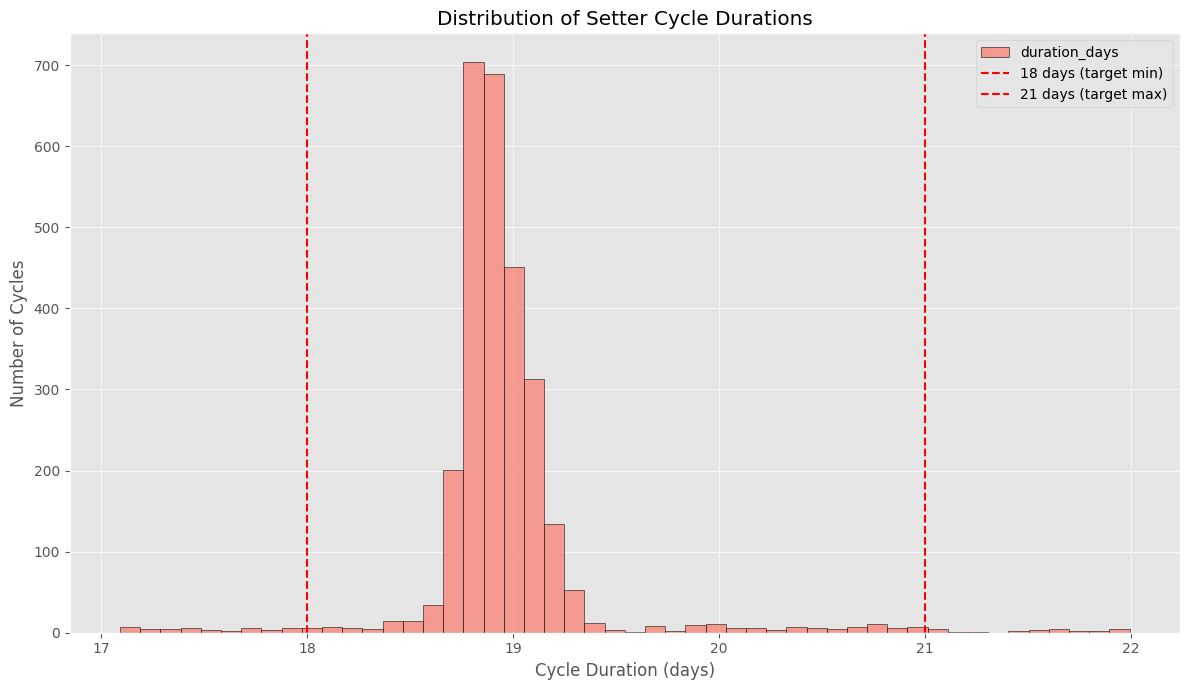


   📈 Cycle Duration Statistics (days):
      Min: 17.09, Max: 21.99
      Mean: 18.97, Median: 18.90
      Std Dev: 0.44
      Cycles within 18-21 days (inclusive): 2741 (97.6%)

📊 VISUALIZATION CELL COMPLETE.


In [8]:
import matplotlib.pyplot as plt
import numpy as np # For np.nan check if needed

print("📊 VISUALIZING CYCLE DURATION DISTRIBUTION")
print("=" * 50)

if 'completed_setter_cycles' not in globals() or completed_setter_cycles.empty:
    print("❌ Error: 'completed_setter_cycles' DataFrame not found or is empty.")
    print("   Please ensure 'Phase 2 - Cell 2' (Filter to setters and extract completed cycles) ran successfully.")
elif 'cycle_duration_hours' not in completed_setter_cycles.columns:
    print("❌ Error: 'cycle_duration_hours' column not found in 'completed_setter_cycles'.")
    print("   Please ensure 'Phase 2 - Cell 2' calculated this column.")
else:
    # Convert duration to days
    if 'cycle_duration_days' not in completed_setter_cycles.columns:
         completed_setter_cycles.loc[:, 'cycle_duration_days'] = completed_setter_cycles['cycle_duration_hours'] / 24.0
    
    # Remove any potential NaN values if they exist, though previous steps should handle this
    durations_days = completed_setter_cycles['cycle_duration_days'].dropna()

    if durations_days.empty:
        print("   ⚠️ No valid cycle durations available to plot.")
    else:
        plt.style.use('ggplot') # Using the style from your example image
        plt.figure(figsize=(12, 7))

        # Determine appropriate bins. Freedman-Diaconis rule can be a good start, or simply define number of bins.
        # For comparability with your image, let's try a reasonable number of bins.
        # The range in your image seems to be from ~18 to ~21 with fine bins.
        # Let's find min/max of our data to set bins appropriately.
        min_val = durations_days.min()
        max_val = durations_days.max()
        
        # Let's set bins to cover a slightly wider range than the typical 18-21 days, but focus there
        # The image shows a range from 18 to 21, with some outliers.
        # For a focused view similar to the image:
        # plot_min_days = 17.5
        # plot_max_days = 21.5
        # If we want to see all data, use min_val and max_val
        
        # Let's try to replicate the approximate binning visible in the image for the 18-21 day range
        # The image seems to have bins of about 0.1 days or so.
        
        # Filter data for a primary plotting range if desired, to match image focus
        # However, it's often better to show all data and let histogram binning handle density
        # For now, let's use a range that captures most of the data, with enough bins for detail.
        # Sturges' formula for bins: 1 + log2(N)
        num_bins = int(1 + np.log2(len(durations_days))) * 2 # Multiply for more granularity
        
        # Or, more simply for a focused view similar to the image, if data is tightly clustered:
        # num_bins = 30 # for a range of 3 days (e.g. 18-21), this gives 0.1 day bins

        plt.hist(durations_days, bins=50, color='salmon', edgecolor='black', alpha=0.75, label='duration_days')

        # Add vertical lines for target range
        plt.axvline(18, color='red', linestyle='--', linewidth=1.5, label='18 days (target min)')
        plt.axvline(21, color='red', linestyle='--', linewidth=1.5, label='21 days (target max)')

        plt.xlabel("Cycle Duration (days)")
        plt.ylabel("Number of Cycles")
        plt.title("Distribution of Setter Cycle Durations")
        plt.legend()
        plt.grid(True, which='both', linestyle='-', linewidth=0.5) # Ensure grid is visible
        plt.tight_layout()
        plt.show()
        
        print("\n   📈 Cycle Duration Statistics (days):")
        print(f"      Min: {durations_days.min():.2f}, Max: {durations_days.max():.2f}")
        print(f"      Mean: {durations_days.mean():.2f}, Median: {durations_days.median():.2f}")
        print(f"      Std Dev: {durations_days.std():.2f}")
        
        # Count cycles within the 18-21 day target range
        target_range_count = durations_days[(durations_days >= 18) & (durations_days <= 21)].count()
        print(f"      Cycles within 18-21 days (inclusive): {target_range_count} ({target_range_count/len(durations_days)*100:.1f}%)")


print("\n" + "="*60)
print("📊 VISUALIZATION CELL COMPLETE.")


# Phase 3: Phase-Aware Preprocessing

🎯 PHASE 3: DATA-DRIVEN PHASE DETECTION
📋 Goal: Analyze data to detect when phases actually transition
🔍 Focus: Find when cooling stabilizes, metabolic heat increases

✅ Working with 7,717,755 climate records across 2807 cycles

🔧 STEP 1: CALCULATE ELAPSED TIME
-----------------------------------
   ✅ Added elapsed time columns

🔧 STEP 2: ANALYZE CYCLES FOR PHASE TRANSITIONS
------------------------------------------------
   Analyzing 50 cycles to detect stabilization patterns...

📊 Phase Transition Analysis Results:
   Startup End (hours):
      Mean: 48.0
      Median: 48.0
      Std Dev: 0.0
      Range: 48.0 - 48.0

   Hatch Start (hours):
      Mean: 329.8
      Median: 318.4
      Std Dev: 29.0
      Range: 284.0 - 411.5


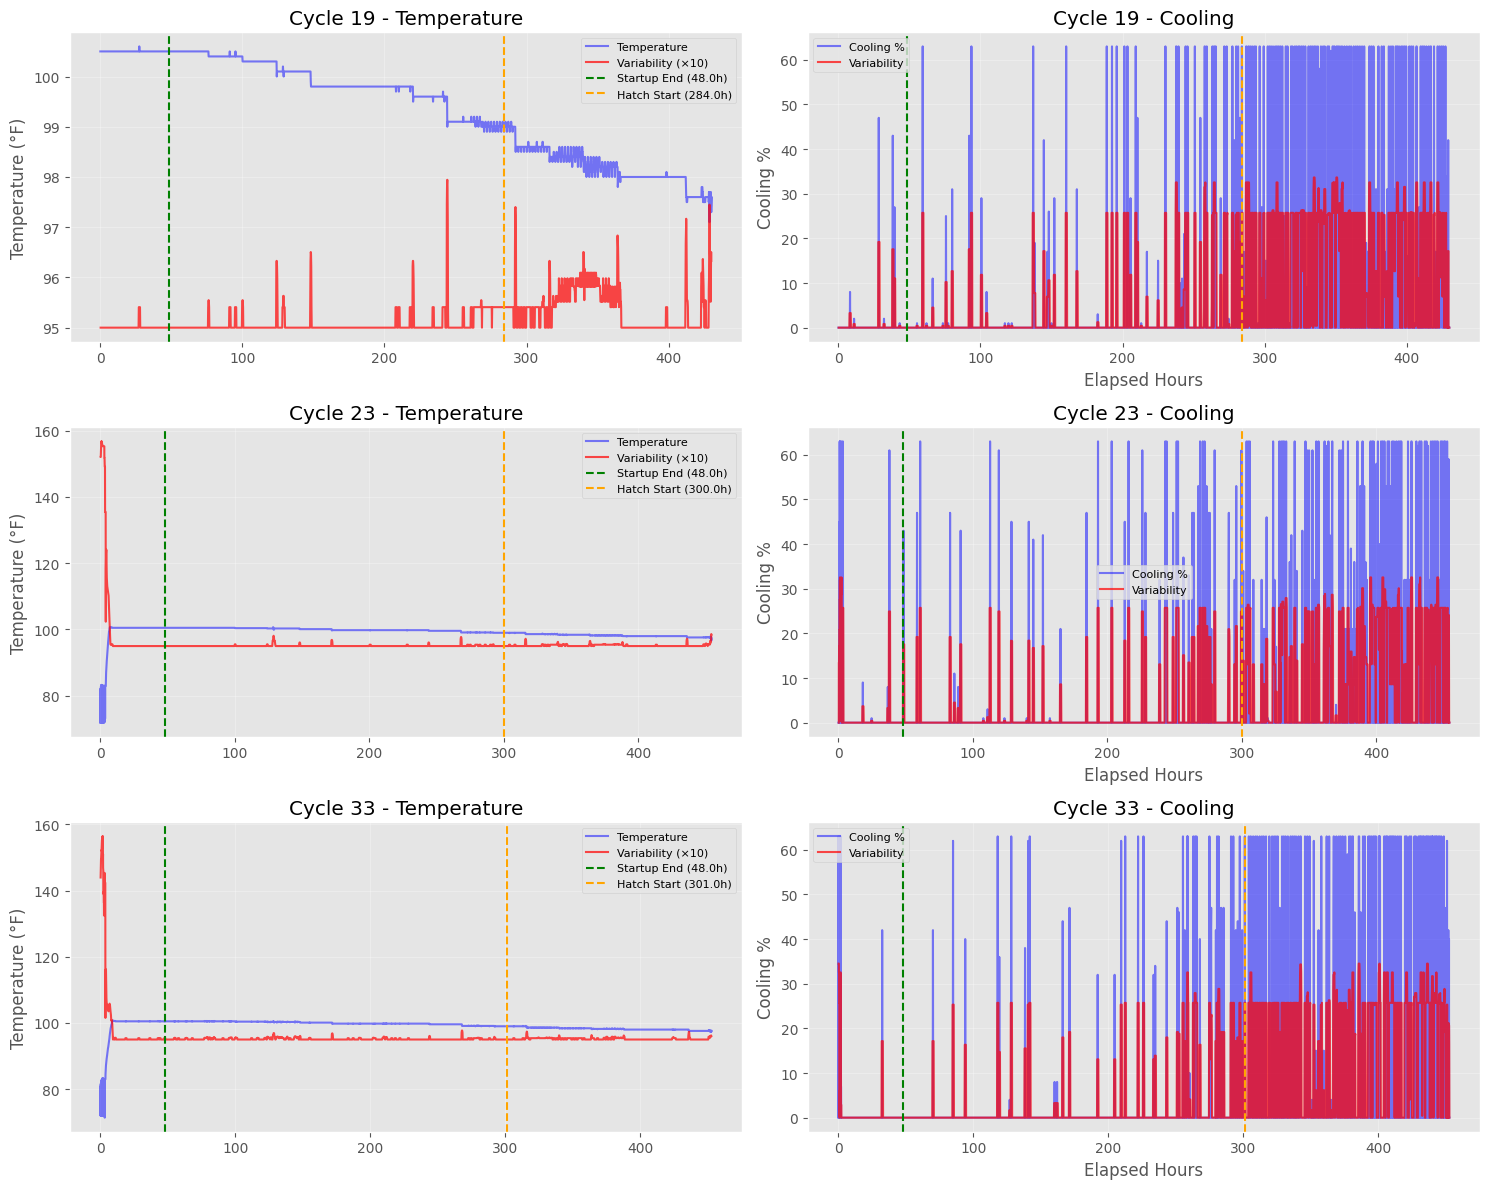


🔧 STEP 3: DEFINE PHASE ASSIGNMENT STRATEGY
--------------------------------------------
   📋 Phase assignment strategy:
      1. Calculate per-cycle transitions when possible
      2. Use defaults for cycles with insufficient data:
         - Startup ends: 48.0 hours
         - Hatch starts: 318.4 hours

🔧 STEP 4: ASSIGN PHASES TO ALL DATA
-------------------------------------
      Processed 500/2807 cycles...
      Processed 1000/2807 cycles...
      Processed 1500/2807 cycles...
      Processed 2000/2807 cycles...
      Processed 2500/2807 cycles...

   📊 Final Phase Distribution:
      Hatch: 2,391,318 records (31.0%), 2806 cycles
      Startup: 814,099 records (10.5%), 2807 cycles
      Steady: 4,512,338 records (58.5%), 2804 cycles

   ✅ Data-driven phases assigned to all 7,717,755 records
   ✅ Phase transition analysis saved

📋 PHASE 3 STEP 1 COMPLETE - DATA-DRIVEN PHASES ASSIGNED
   Next: Resample data to 10-minute intervals and apply smoothing


In [9]:
# Phase 3 - Cell 1 (Improved): Data-Driven Phase Detection
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.ndimage import gaussian_filter1d

print("🎯 PHASE 3: DATA-DRIVEN PHASE DETECTION")
print("=" * 50)
print("📋 Goal: Analyze data to detect when phases actually transition")
print("🔍 Focus: Find when cooling stabilizes, metabolic heat increases")
print()

# Verify required data from Phase 2
if 'sliced_climate_logs' not in globals() or sliced_climate_logs.empty:
    print("❌ Error: 'sliced_climate_logs' not found or empty. Please run Phase 2 cells.")
elif 'completed_setter_cycles' not in globals() or completed_setter_cycles.empty:
    print("❌ Error: 'completed_setter_cycles' not found or empty. Please run Phase 2 cells.")
else:
    print(f"✅ Working with {len(sliced_climate_logs):,} climate records across {sliced_climate_logs['CycleID'].nunique()} cycles")
    
    # Add elapsed time column
    print("\n🔧 STEP 1: CALCULATE ELAPSED TIME")
    print("-" * 35)
    
    sliced_climate_logs['elapsed_hours'] = (
        sliced_climate_logs['TimeStamp_dt'] - sliced_climate_logs['CycleStartDateTime_dt']
    ).dt.total_seconds() / 3600
    
    sliced_climate_logs['elapsed_days'] = sliced_climate_logs['elapsed_hours'] / 24
    print(f"   ✅ Added elapsed time columns")
    
    # Analyze cycles to detect phase transitions
    print("\n🔧 STEP 2: ANALYZE CYCLES FOR PHASE TRANSITIONS")
    print("-" * 48)
    
    phase_transitions = []
    sample_analyses = []
    
    # Process a subset first to determine thresholds
    cycles_to_analyze = sliced_climate_logs['CycleID'].unique()[:50]  # Analyze first 50 cycles
    
    print(f"   Analyzing {len(cycles_to_analyze)} cycles to detect stabilization patterns...")
    
    for cycle_id in cycles_to_analyze:
        cycle_data = sliced_climate_logs[sliced_climate_logs['CycleID'] == cycle_id].sort_values('elapsed_hours')
        
        if len(cycle_data) > 100:  # Need enough data points
            # Calculate rolling statistics with different windows
            short_window = 6   # ~1 hour (assuming ~10 min intervals)
            long_window = 30   # ~5 hours
            
            # For temperature stability
            if 'meas_temp1' in cycle_data.columns:
                cycle_data['temp_rolling_std'] = cycle_data['meas_temp1'].rolling(short_window, center=True).std()
                cycle_data['temp_rolling_mean'] = cycle_data['meas_temp1'].rolling(long_window, center=True).mean()
                cycle_data['temp_gradient'] = np.gradient(gaussian_filter1d(cycle_data['meas_temp1'].fillna(method='ffill'), sigma=3))
            
            # For cooling system stability
            if 'cooling' in cycle_data.columns:
                cycle_data['cooling_rolling_std'] = cycle_data['cooling'].rolling(short_window, center=True).std()
                cycle_data['cooling_rolling_mean'] = cycle_data['cooling'].rolling(long_window, center=True).mean()
                # Calculate rate of change
                cycle_data['cooling_change_rate'] = cycle_data['cooling'].diff().rolling(short_window).mean()
            
            # Detect startup end: when both temperature and cooling stabilize
            startup_end_candidates = []
            
            # Temperature stabilization criteria
            if 'temp_rolling_std' in cycle_data.columns:
                # Find when temperature variability drops below threshold and stays low
                temp_stable_threshold = cycle_data['temp_rolling_std'].quantile(0.25)  # Lower quartile
                temp_stable = cycle_data['temp_rolling_std'] < temp_stable_threshold
                
                # Find first sustained period of stability (at least 2 hours)
                for i in range(12, len(temp_stable)-12):  # 12 points = ~2 hours
                    if temp_stable.iloc[i:i+12].all():
                        startup_end_candidates.append(cycle_data.iloc[i]['elapsed_hours'])
                        break
            
            # Cooling stabilization criteria
            if 'cooling_rolling_std' in cycle_data.columns and len(startup_end_candidates) > 0:
                cooling_stable_threshold = cycle_data['cooling_rolling_std'].quantile(0.3)
                cooling_stable = cycle_data['cooling_rolling_std'] < cooling_stable_threshold
                
                # Find when cooling stabilizes
                for i in range(12, len(cooling_stable)-12):
                    if cooling_stable.iloc[i:i+12].all():
                        cooling_stable_hour = cycle_data.iloc[i]['elapsed_hours']
                        # Take the later of temperature and cooling stabilization
                        startup_end = max(startup_end_candidates[0], cooling_stable_hour)
                        break
                else:
                    startup_end = startup_end_candidates[0]
            else:
                startup_end = 48  # Default fallback
            
            # Detect hatch start: when cooling demand increases consistently
            hatch_start = None
            if 'cooling_rolling_mean' in cycle_data.columns:
                # Look in the last 1/3 of the cycle
                late_cycle = cycle_data[cycle_data['elapsed_hours'] > cycle_data['elapsed_hours'].max() * 0.66]
                
                if len(late_cycle) > 50:
                    # Calculate cooling trend in late cycle
                    late_cooling_gradient = np.gradient(gaussian_filter1d(late_cycle['cooling_rolling_mean'].fillna(0), sigma=5))
                    
                    # Find sustained increase in cooling
                    for i in range(len(late_cooling_gradient) - 24):  # 24 points = ~4 hours
                        if (late_cooling_gradient[i:i+24] > 0.1).sum() > 18:  # Most points showing increase
                            hatch_start = late_cycle.iloc[i]['elapsed_hours']
                            break
                
                if hatch_start is None:
                    hatch_start = 14 * 24  # Default to day 14
            
            # Store results
            phase_transitions.append({
                'cycle_id': cycle_id,
                'startup_end_hours': startup_end,
                'hatch_start_hours': hatch_start,
                'cycle_duration': cycle_data['elapsed_hours'].max()
            })
            
            # Save detailed analysis for first few cycles
            if len(sample_analyses) < 5:
                sample_analyses.append({
                    'cycle_id': cycle_id,
                    'data': cycle_data,
                    'startup_end': startup_end,
                    'hatch_start': hatch_start
                })
    
    # Analyze the distribution of phase transitions
    transitions_df = pd.DataFrame(phase_transitions)
    
    print(f"\n📊 Phase Transition Analysis Results:")
    print(f"   Startup End (hours):")
    print(f"      Mean: {transitions_df['startup_end_hours'].mean():.1f}")
    print(f"      Median: {transitions_df['startup_end_hours'].median():.1f}")
    print(f"      Std Dev: {transitions_df['startup_end_hours'].std():.1f}")
    print(f"      Range: {transitions_df['startup_end_hours'].min():.1f} - {transitions_df['startup_end_hours'].max():.1f}")
    
    print(f"\n   Hatch Start (hours):")
    print(f"      Mean: {transitions_df['hatch_start_hours'].mean():.1f}")
    print(f"      Median: {transitions_df['hatch_start_hours'].median():.1f}")
    print(f"      Std Dev: {transitions_df['hatch_start_hours'].std():.1f}")
    print(f"      Range: {transitions_df['hatch_start_hours'].min():.1f} - {transitions_df['hatch_start_hours'].max():.1f}")
    
    # Visualize phase detection for sample cycles
    if sample_analyses:
        fig, axes = plt.subplots(3, 2, figsize=(15, 12))
        axes = axes.flatten()
        
        for idx, analysis in enumerate(sample_analyses[:3]):
            cycle_data = analysis['data']
            ax_temp = axes[idx*2]
            ax_cool = axes[idx*2 + 1]
            
            # Temperature subplot
            if 'meas_temp1' in cycle_data.columns:
                ax_temp.plot(cycle_data['elapsed_hours'], cycle_data['meas_temp1'], 
                           'b-', alpha=0.5, label='Temperature')
                ax_temp.plot(cycle_data['elapsed_hours'], cycle_data['temp_rolling_std']*10 + 95, 
                           'r-', alpha=0.7, label='Variability (×10)')
                
                # Mark phase transitions
                ax_temp.axvline(analysis['startup_end'], color='green', linestyle='--', 
                              label=f'Startup End ({analysis["startup_end"]:.1f}h)')
                ax_temp.axvline(analysis['hatch_start'], color='orange', linestyle='--',
                              label=f'Hatch Start ({analysis["hatch_start"]:.1f}h)')
                
                ax_temp.set_ylabel('Temperature (°F)')
                ax_temp.set_title(f'Cycle {analysis["cycle_id"]} - Temperature')
                ax_temp.legend(fontsize=8)
                ax_temp.grid(True, alpha=0.3)
            
            # Cooling subplot
            if 'cooling' in cycle_data.columns:
                ax_cool.plot(cycle_data['elapsed_hours'], cycle_data['cooling'], 
                           'b-', alpha=0.5, label='Cooling %')
                ax_cool.plot(cycle_data['elapsed_hours'], cycle_data['cooling_rolling_std'], 
                           'r-', alpha=0.7, label='Variability')
                
                # Mark phase transitions
                ax_cool.axvline(analysis['startup_end'], color='green', linestyle='--')
                ax_cool.axvline(analysis['hatch_start'], color='orange', linestyle='--')
                
                ax_cool.set_xlabel('Elapsed Hours')
                ax_cool.set_ylabel('Cooling %')
                ax_cool.set_title(f'Cycle {analysis["cycle_id"]} - Cooling')
                ax_cool.legend(fontsize=8)
                ax_cool.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    # Define final phase boundaries based on analysis
    print("\n🔧 STEP 3: DEFINE PHASE ASSIGNMENT STRATEGY")
    print("-" * 44)
    
    # Use median values as defaults, but calculate per-cycle when possible
    default_startup_end = transitions_df['startup_end_hours'].median()
    default_hatch_start = transitions_df['hatch_start_hours'].median()
    
    print(f"   📋 Phase assignment strategy:")
    print(f"      1. Calculate per-cycle transitions when possible")
    print(f"      2. Use defaults for cycles with insufficient data:")
    print(f"         - Startup ends: {default_startup_end:.1f} hours")
    print(f"         - Hatch starts: {default_hatch_start:.1f} hours")
    
    # Now assign phases to ALL cycles
    print("\n🔧 STEP 4: ASSIGN PHASES TO ALL DATA")
    print("-" * 37)
    
    all_cycle_phases = []
    cycles_processed = 0
    
    for cycle_id in sliced_climate_logs['CycleID'].unique():
        cycle_data = sliced_climate_logs[sliced_climate_logs['CycleID'] == cycle_id].copy()
        
        # Try to detect transitions for this cycle
        if cycle_id in [t['cycle_id'] for t in phase_transitions]:
            # Use detected transitions
            transition = next(t for t in phase_transitions if t['cycle_id'] == cycle_id)
            startup_end = transition['startup_end_hours']
            hatch_start = transition['hatch_start_hours']
        else:
            # Use defaults
            startup_end = default_startup_end
            hatch_start = default_hatch_start
        
        # Assign phases
        cycle_data['phase'] = 2  # Default to steady
        cycle_data.loc[cycle_data['elapsed_hours'] < startup_end, 'phase'] = 1
        cycle_data.loc[cycle_data['elapsed_hours'] >= hatch_start, 'phase'] = 3
        
        cycle_data['phase_name'] = cycle_data['phase'].map({1: 'Startup', 2: 'Steady', 3: 'Hatch'})
        
        all_cycle_phases.append(cycle_data)
        
        cycles_processed += 1
        if cycles_processed % 500 == 0:
            print(f"      Processed {cycles_processed}/{sliced_climate_logs['CycleID'].nunique()} cycles...")
    
    # Combine all cycles
    sliced_climate_logs_with_phases = pd.concat(all_cycle_phases, ignore_index=True)
    
    # Analyze final phase distribution
    phase_distribution = sliced_climate_logs_with_phases.groupby('phase_name').agg({
        'ClimateLogID': 'count',
        'CycleID': 'nunique'
    }).rename(columns={'ClimateLogID': 'record_count', 'CycleID': 'cycles_with_phase'})
    
    print(f"\n   📊 Final Phase Distribution:")
    for phase_name, stats in phase_distribution.iterrows():
        pct = stats['record_count'] / len(sliced_climate_logs_with_phases) * 100
        print(f"      {phase_name}: {stats['record_count']:,} records ({pct:.1f}%), {stats['cycles_with_phase']} cycles")
    
    # Store results
    globals()['phase_transitions_analysis'] = transitions_df
    globals()['sliced_climate_logs_with_phases'] = sliced_climate_logs_with_phases
    globals()['phase_defaults'] = {
        'startup_end_hours': default_startup_end,
        'hatch_start_hours': default_hatch_start
    }
    
    print(f"\n   ✅ Data-driven phases assigned to all {len(sliced_climate_logs_with_phases):,} records")
    print(f"   ✅ Phase transition analysis saved")

print("\n" + "="*60)
print("📋 PHASE 3 STEP 1 COMPLETE - DATA-DRIVEN PHASES ASSIGNED")
print("   Next: Resample data to 10-minute intervals and apply smoothing")

Interesting results! Looking at the output and visualizations:
Startup End Detection: All 50 analyzed cycles showed startup ending at exactly 48 hours. This suggests:
Either the temperature/cooling stabilizes very consistently around 48 hours
Or our detection algorithm might be defaulting to the fallback value
Looking at the graphs, we can see the temperature does stabilize after initial fluctuations
Hatch Start Detection: This showed more variation (284-411 hours, median 318 hours ≈ 13.3 days), which is good! The algorithm is detecting different metabolic heat patterns across cycles.
Phase Distribution:
Startup: 10.5% (first 2 days)
Steady: 58.5% (days 2-13)
Hatch: 31.0% (days 13+)
The visualizations show:
Temperature: Clear stabilization after initial startup
Cooling: Increased activity and variability in later stages (hatch phase)
The phase boundaries seem reasonable based on the patterns

# Phase 3 - Cell 2: Resample & Smooth Data

🔄 PHASE 3: RESAMPLE & SMOOTH DATA
📋 Goal: Resample to 10-minute intervals and apply smoothing
🔍 Focus: Preserve step-changes while reducing jitter

✅ Working with 7,717,755 records

🔧 STEP 1: ANALYZE CURRENT DATA QUALITY
----------------------------------------
   ⚠️  Found 1778 duplicate timestamp entries across cycles
   Will aggregate duplicates during resampling
   Current median sampling interval: 10.0 minutes
   Current samples per hour: 6.0

🔧 STEP 2: IDENTIFY COLUMNS FOR RESAMPLING
-------------------------------------------
   📊 Temperature measurement columns: 8
   📊 Setpoint columns: 10
   📊 Control columns: 5

🔧 STEP 3: RESAMPLE TO 10-MINUTE INTERVALS
-------------------------------------------
   Processing 2807 cycles...
      Processed 500/2807 cycles...
      Processed 1000/2807 cycles...
      Processed 1500/2807 cycles...
      Processed 2000/2807 cycles...
      Processed 2500/2807 cycles...

   ✅ Resampling complete!
   📊 Original records: 7,717,755
   📊 Resampled r

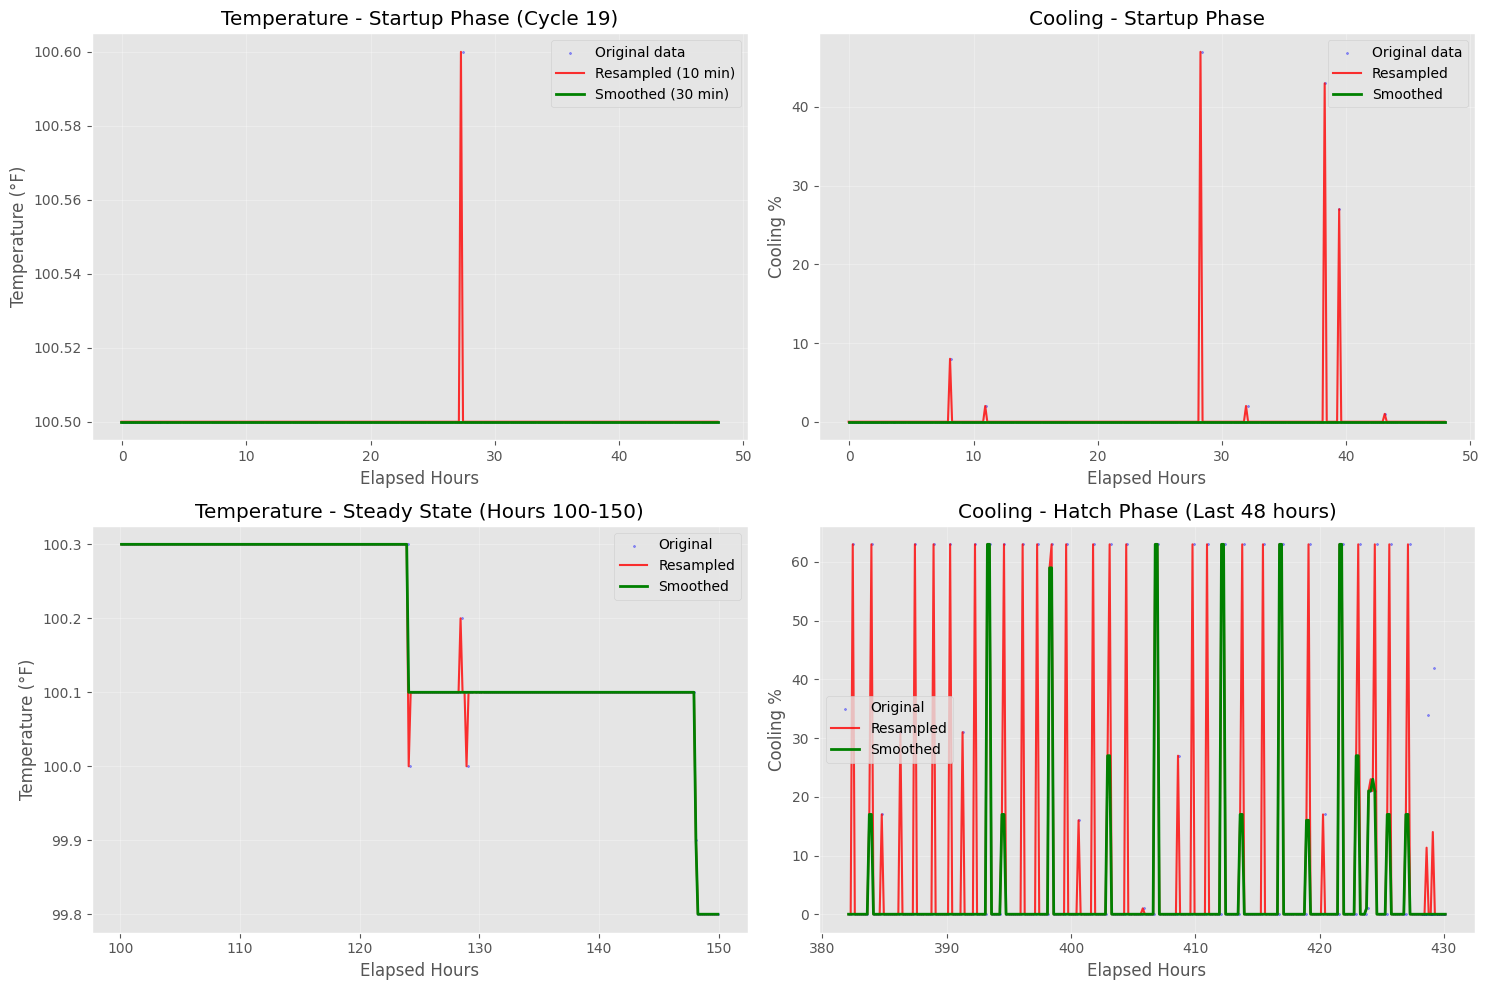


✅ Resampled and smoothed data saved as 'resampled_smoothed_logs'
   Shape: (7666905, 43)

📊 Phase distribution in resampled data:
   Hatch: 2,303,670 records (30.0%)
   Startup: 810,639 records (10.6%)
   Steady: 4,552,596 records (59.4%)

📋 PHASE 3 STEP 2 COMPLETE - DATA RESAMPLED & SMOOTHED
   Next: Build baselines per machine and phase


In [10]:
# Phase 3 - Cell 2: Resample & Smooth Data (Corrected)
print("🔄 PHASE 3: RESAMPLE & SMOOTH DATA")
print("=" * 50)
print("📋 Goal: Resample to 10-minute intervals and apply smoothing")
print("🔍 Focus: Preserve step-changes while reducing jitter")
print()

if 'sliced_climate_logs_with_phases' not in globals() or sliced_climate_logs_with_phases.empty:
    print("❌ Error: 'sliced_climate_logs_with_phases' not found. Please run Phase 3 - Cell 1.")
else:
    print(f"✅ Working with {len(sliced_climate_logs_with_phases):,} records")
    
    # Check current sampling rate and duplicates
    print("\n🔧 STEP 1: ANALYZE CURRENT DATA QUALITY")
    print("-" * 40)
    
    # Check for duplicate timestamps within cycles
    duplicate_check = sliced_climate_logs_with_phases.groupby(['CycleID', 'TimeStamp_dt']).size()
    duplicates = duplicate_check[duplicate_check > 1]
    
    if len(duplicates) > 0:
        print(f"   ⚠️  Found {len(duplicates)} duplicate timestamp entries across cycles")
        print(f"   Will aggregate duplicates during resampling")
    
    # Sample a cycle to check interval
    sample_cycle = sliced_climate_logs_with_phases[
        sliced_climate_logs_with_phases['CycleID'] == sliced_climate_logs_with_phases['CycleID'].unique()[0]
    ].sort_values('TimeStamp_dt')
    
    if len(sample_cycle) > 1:
        time_diffs = sample_cycle['TimeStamp_dt'].diff().dropna()
        median_interval = time_diffs[time_diffs > pd.Timedelta(0)].median()  # Ignore zero differences
        if pd.notna(median_interval):
            print(f"   Current median sampling interval: {median_interval.total_seconds()/60:.1f} minutes")
            print(f"   Current samples per hour: {60/(median_interval.total_seconds()/60):.1f}")
    
    # Identify numerical columns
    print("\n🔧 STEP 2: IDENTIFY COLUMNS FOR RESAMPLING")
    print("-" * 43)
    
    temp_meas_cols = [col for col in sliced_climate_logs_with_phases.columns 
                      if col.startswith('meas_temp')]
    setpoint_cols = [col for col in sliced_climate_logs_with_phases.columns 
                     if col.startswith('setpoint_')]
    control_cols = ['cooling', 'heating', 'meas_RH', 'meas_valve', 'meas_CO2']
    control_cols = [col for col in control_cols if col in sliced_climate_logs_with_phases.columns]
    
    all_numeric_cols = temp_meas_cols + setpoint_cols + control_cols
    
    print(f"   📊 Temperature measurement columns: {len(temp_meas_cols)}")
    print(f"   📊 Setpoint columns: {len(setpoint_cols)}")
    print(f"   📊 Control columns: {len(control_cols)}")
    
    # Process each cycle
    print("\n🔧 STEP 3: RESAMPLE TO 10-MINUTE INTERVALS")
    print("-" * 43)
    
    resampled_cycles = []
    sample_cycles_for_viz = []
    cycles_to_process = sliced_climate_logs_with_phases['CycleID'].unique()
    failed_cycles = []
    
    print(f"   Processing {len(cycles_to_process)} cycles...")
    
    # Process in batches
    batch_size = 100
    for i in range(0, len(cycles_to_process), batch_size):
        batch_cycles = cycles_to_process[i:i+batch_size]
        
        for cycle_id in batch_cycles:
            try:
                cycle_data = sliced_climate_logs_with_phases[
                    sliced_climate_logs_with_phases['CycleID'] == cycle_id
                ].copy()
                
                if len(cycle_data) < 10:
                    continue
                
                # Handle duplicate timestamps by aggregating
                # Group by timestamp and take mean of numeric columns
                agg_dict = {col: 'mean' for col in all_numeric_cols if col in cycle_data.columns}
                # Keep first value for non-numeric columns
                for col in ['MachineID', 'CycleStartDateTime_dt', 'phase', 'phase_name']:
                    if col in cycle_data.columns:
                        agg_dict[col] = 'first'
                
                # Aggregate duplicates before setting index
                cycle_data_clean = cycle_data.groupby('TimeStamp_dt').agg(agg_dict).reset_index()
                
                # Now set timestamp as index
                cycle_data_clean = cycle_data_clean.set_index('TimeStamp_dt').sort_index()
                
                # Create regular 10-minute index for this cycle
                start_time = cycle_data_clean.index[0].floor('10T')
                end_time = cycle_data_clean.index[-1].ceil('10T')
                new_index = pd.date_range(start=start_time, end=end_time, freq='10T')
                
                # Create empty dataframe with new index
                resampled = pd.DataFrame(index=new_index)
                
                # Resample measurements using mean
                for col in temp_meas_cols + control_cols:
                    if col in cycle_data_clean.columns:
                        # Resample to 10T and take mean
                        resampled[col] = cycle_data_clean[col].resample('10T').mean()
                
                # Resample setpoints using forward fill
                for col in setpoint_cols:
                    if col in cycle_data_clean.columns:
                        # Resample and forward fill
                        resampled[col] = cycle_data_clean[col].resample('10T').first()
                        # Fill any remaining NaNs
                        resampled[col] = resampled[col].ffill().bfill()
                
                # Fill any remaining NaNs in measurements
                for col in temp_meas_cols + control_cols:
                    if col in resampled.columns:
                        resampled[col] = resampled[col].interpolate(method='linear', limit=3).ffill().bfill()
                
                # Add metadata
                resampled['MachineID'] = cycle_data_clean['MachineID'].iloc[0]
                resampled['CycleID'] = cycle_id
                resampled['CycleStartDateTime_dt'] = cycle_data_clean['CycleStartDateTime_dt'].iloc[0]
                resampled['TimeStamp_dt'] = resampled.index
                
                # Recalculate elapsed time and phase
                resampled['elapsed_hours'] = (
                    resampled['TimeStamp_dt'] - resampled['CycleStartDateTime_dt']
                ).dt.total_seconds() / 3600
                
                # Assign phases using our detected boundaries
                if 'phase_defaults' in globals():
                    startup_end = phase_defaults['startup_end_hours']
                    hatch_start = phase_defaults['hatch_start_hours']
                else:
                    startup_end = 48
                    hatch_start = 318.4
                
                resampled['phase'] = 2  # Default to steady
                resampled.loc[resampled['elapsed_hours'] < startup_end, 'phase'] = 1
                resampled.loc[resampled['elapsed_hours'] >= hatch_start, 'phase'] = 3
                resampled['phase_name'] = resampled['phase'].map({1: 'Startup', 2: 'Steady', 3: 'Hatch'})
                
                # Reset index to make it a regular column
                resampled = resampled.reset_index(drop=True)
                
                resampled_cycles.append(resampled)
                
                # Save examples for visualization
                if len(sample_cycles_for_viz) < 3:
                    sample_cycles_for_viz.append({
                        'cycle_id': cycle_id,
                        'original': cycle_data,
                        'resampled': resampled
                    })
                    
            except Exception as e:
                failed_cycles.append((cycle_id, str(e)))
                continue
        
        if (i + batch_size) % 500 == 0:
            print(f"      Processed {min(i + batch_size, len(cycles_to_process))}/{len(cycles_to_process)} cycles...")
    
    if failed_cycles:
        print(f"\n   ⚠️  Failed to process {len(failed_cycles)} cycles")
        if len(failed_cycles) <= 5:
            for cycle_id, error in failed_cycles:
                print(f"      Cycle {cycle_id}: {error}")
    
    # Combine all resampled cycles
    if resampled_cycles:
        resampled_climate_logs = pd.concat(resampled_cycles, ignore_index=True)
        
        print(f"\n   ✅ Resampling complete!")
        print(f"   📊 Original records: {len(sliced_climate_logs_with_phases):,}")
        print(f"   📊 Resampled records: {len(resampled_climate_logs):,}")
        print(f"   📊 Reduction ratio: {len(sliced_climate_logs_with_phases)/len(resampled_climate_logs):.1f}x")
        
        # Apply smoothing
        print("\n🔧 STEP 4: APPLY SMOOTHING")
        print("-" * 26)
        
        window_size = 3  # 30 minutes
        print(f"   Applying rolling median with window size {window_size} (30 minutes)...")
        
        # Apply smoothing to measurements only
        smoothed_cols = []
        for col in temp_meas_cols + control_cols:
            if col in resampled_climate_logs.columns:
                smoothed_col = f'{col}_smoothed'
                smoothed_cols.append(smoothed_col)
                # Group by cycle to avoid smoothing across cycle boundaries
                resampled_climate_logs[smoothed_col] = (
                    resampled_climate_logs.groupby('CycleID')[col]
                    .transform(lambda x: x.rolling(window=window_size, center=True, min_periods=1).median())
                )
        
        print(f"   ✅ Smoothing complete! Added {len(smoothed_cols)} smoothed columns")
        
        # Visualize the effect
        if sample_cycles_for_viz:
            print("\n📊 Visualizing resampling and smoothing effects...")
            
            fig, axes = plt.subplots(2, 2, figsize=(15, 10))
            
            # Use first sample
            sample = sample_cycles_for_viz[0]
            orig = sample['original']
            resamp = resampled_climate_logs[resampled_climate_logs['CycleID'] == sample['cycle_id']]
            
            # Temperature - startup phase
            if 'meas_temp1' in orig.columns and len(resamp) > 0:
                # First 48 hours
                orig_startup = orig[orig['elapsed_hours'] <= 48]
                resamp_startup = resamp[resamp['elapsed_hours'] <= 48]
                
                axes[0,0].scatter(orig_startup['elapsed_hours'], orig_startup['meas_temp1'], 
                               s=2, alpha=0.4, c='blue', label='Original data')
                axes[0,0].plot(resamp_startup['elapsed_hours'], resamp_startup['meas_temp1'], 
                            'r-', linewidth=1.5, alpha=0.8, label='Resampled (10 min)')
                if 'meas_temp1_smoothed' in resamp_startup.columns:
                    axes[0,0].plot(resamp_startup['elapsed_hours'], resamp_startup['meas_temp1_smoothed'], 
                                'g-', linewidth=2, label='Smoothed (30 min)')
                
                axes[0,0].set_xlabel('Elapsed Hours')
                axes[0,0].set_ylabel('Temperature (°F)')
                axes[0,0].set_title(f'Temperature - Startup Phase (Cycle {sample["cycle_id"]})')
                axes[0,0].legend()
                axes[0,0].grid(True, alpha=0.3)
            
            # Cooling - startup phase
            if 'cooling' in orig.columns and len(resamp) > 0:
                axes[0,1].scatter(orig_startup['elapsed_hours'], orig_startup['cooling'], 
                               s=2, alpha=0.4, c='blue', label='Original data')
                axes[0,1].plot(resamp_startup['elapsed_hours'], resamp_startup['cooling'], 
                            'r-', linewidth=1.5, alpha=0.8, label='Resampled')
                if 'cooling_smoothed' in resamp_startup.columns:
                    axes[0,1].plot(resamp_startup['elapsed_hours'], resamp_startup['cooling_smoothed'], 
                                'g-', linewidth=2, label='Smoothed')
                
                axes[0,1].set_xlabel('Elapsed Hours')
                axes[0,1].set_ylabel('Cooling %')
                axes[0,1].set_title('Cooling - Startup Phase')
                axes[0,1].legend()
                axes[0,1].grid(True, alpha=0.3)
            
            # Temperature - steady state (zoomed)
            if 'meas_temp1' in orig.columns and len(resamp) > 0:
                # Hours 100-150 for steady state
                orig_steady = orig[(orig['elapsed_hours'] >= 100) & (orig['elapsed_hours'] <= 150)]
                resamp_steady = resamp[(resamp['elapsed_hours'] >= 100) & (resamp['elapsed_hours'] <= 150)]
                
                if len(orig_steady) > 0:
                    axes[1,0].scatter(orig_steady['elapsed_hours'], orig_steady['meas_temp1'], 
                                   s=2, alpha=0.4, c='blue', label='Original')
                    axes[1,0].plot(resamp_steady['elapsed_hours'], resamp_steady['meas_temp1'], 
                                'r-', linewidth=1.5, alpha=0.8, label='Resampled')
                    if 'meas_temp1_smoothed' in resamp_steady.columns:
                        axes[1,0].plot(resamp_steady['elapsed_hours'], resamp_steady['meas_temp1_smoothed'], 
                                    'g-', linewidth=2, label='Smoothed')
                    
                    axes[1,0].set_xlabel('Elapsed Hours')
                    axes[1,0].set_ylabel('Temperature (°F)')
                    axes[1,0].set_title('Temperature - Steady State (Hours 100-150)')
                    axes[1,0].legend()
                    axes[1,0].grid(True, alpha=0.3)
            
            # Cooling - hatch phase
            if 'cooling' in orig.columns and len(resamp) > 0:
                # Last 48 hours
                max_hours = resamp['elapsed_hours'].max()
                orig_hatch = orig[orig['elapsed_hours'] >= max_hours - 48]
                resamp_hatch = resamp[resamp['elapsed_hours'] >= max_hours - 48]
                
                if len(orig_hatch) > 0:
                    axes[1,1].scatter(orig_hatch['elapsed_hours'], orig_hatch['cooling'], 
                                   s=2, alpha=0.4, c='blue', label='Original')
                    axes[1,1].plot(resamp_hatch['elapsed_hours'], resamp_hatch['cooling'], 
                                'r-', linewidth=1.5, alpha=0.8, label='Resampled')
                    if 'cooling_smoothed' in resamp_hatch.columns:
                        axes[1,1].plot(resamp_hatch['elapsed_hours'], resamp_hatch['cooling_smoothed'], 
                                    'g-', linewidth=2, label='Smoothed')
                    
                    axes[1,1].set_xlabel('Elapsed Hours')
                    axes[1,1].set_ylabel('Cooling %')
                    axes[1,1].set_title('Cooling - Hatch Phase (Last 48 hours)')
                    axes[1,1].legend()
                    axes[1,1].grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.show()
        
        # Store results
        globals()['resampled_smoothed_logs'] = resampled_climate_logs
        
        print(f"\n✅ Resampled and smoothed data saved as 'resampled_smoothed_logs'")
        print(f"   Shape: {resampled_climate_logs.shape}")
        
        # Phase distribution
        phase_dist = resampled_climate_logs['phase_name'].value_counts().sort_index()
        print(f"\n📊 Phase distribution in resampled data:")
        for phase, count in phase_dist.items():
            print(f"   {phase}: {count:,} records ({count/len(resampled_climate_logs)*100:.1f}%)")
    else:
        print("\n❌ No cycles were successfully resampled")

print("\n" + "="*60)
print("📋 PHASE 3 STEP 2 COMPLETE - DATA RESAMPLED & SMOOTHED")
print("   Next: Build baselines per machine and phase")

📊 ADDITIONAL VISUALIZATIONS: RESAMPLING & SMOOTHING VERIFICATION
✅ Using 'resampled_smoothed_logs' (Shape: (7666905, 43))
✅ Using 'sliced_climate_logs_with_phases' for original data (Shape: (7717755, 42))

🔍 Visualizing for Sample CycleIDs: [33, 12649, 23]

--- Visualizing Cycle ID: 33 ---


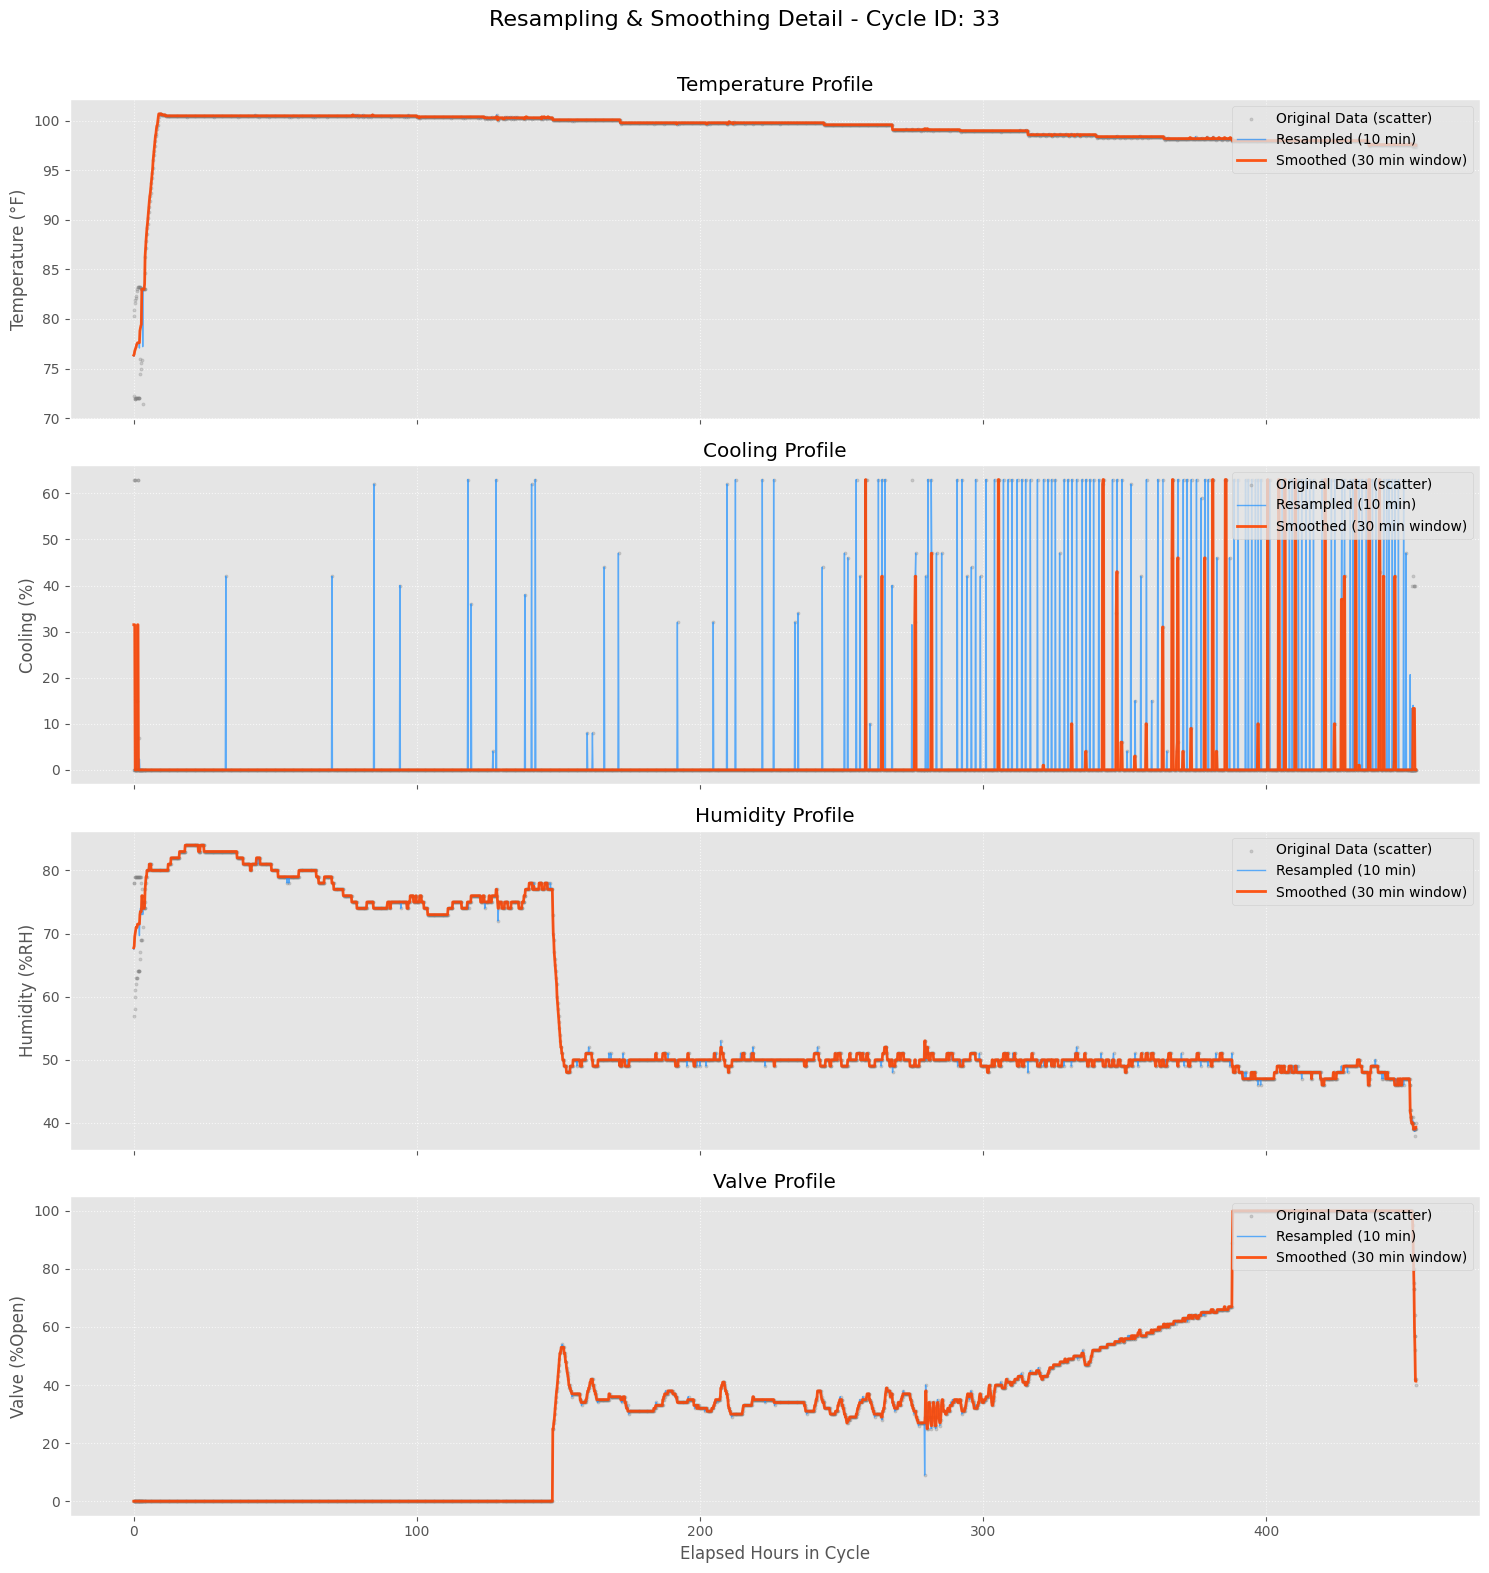


--- Visualizing Cycle ID: 12649 ---


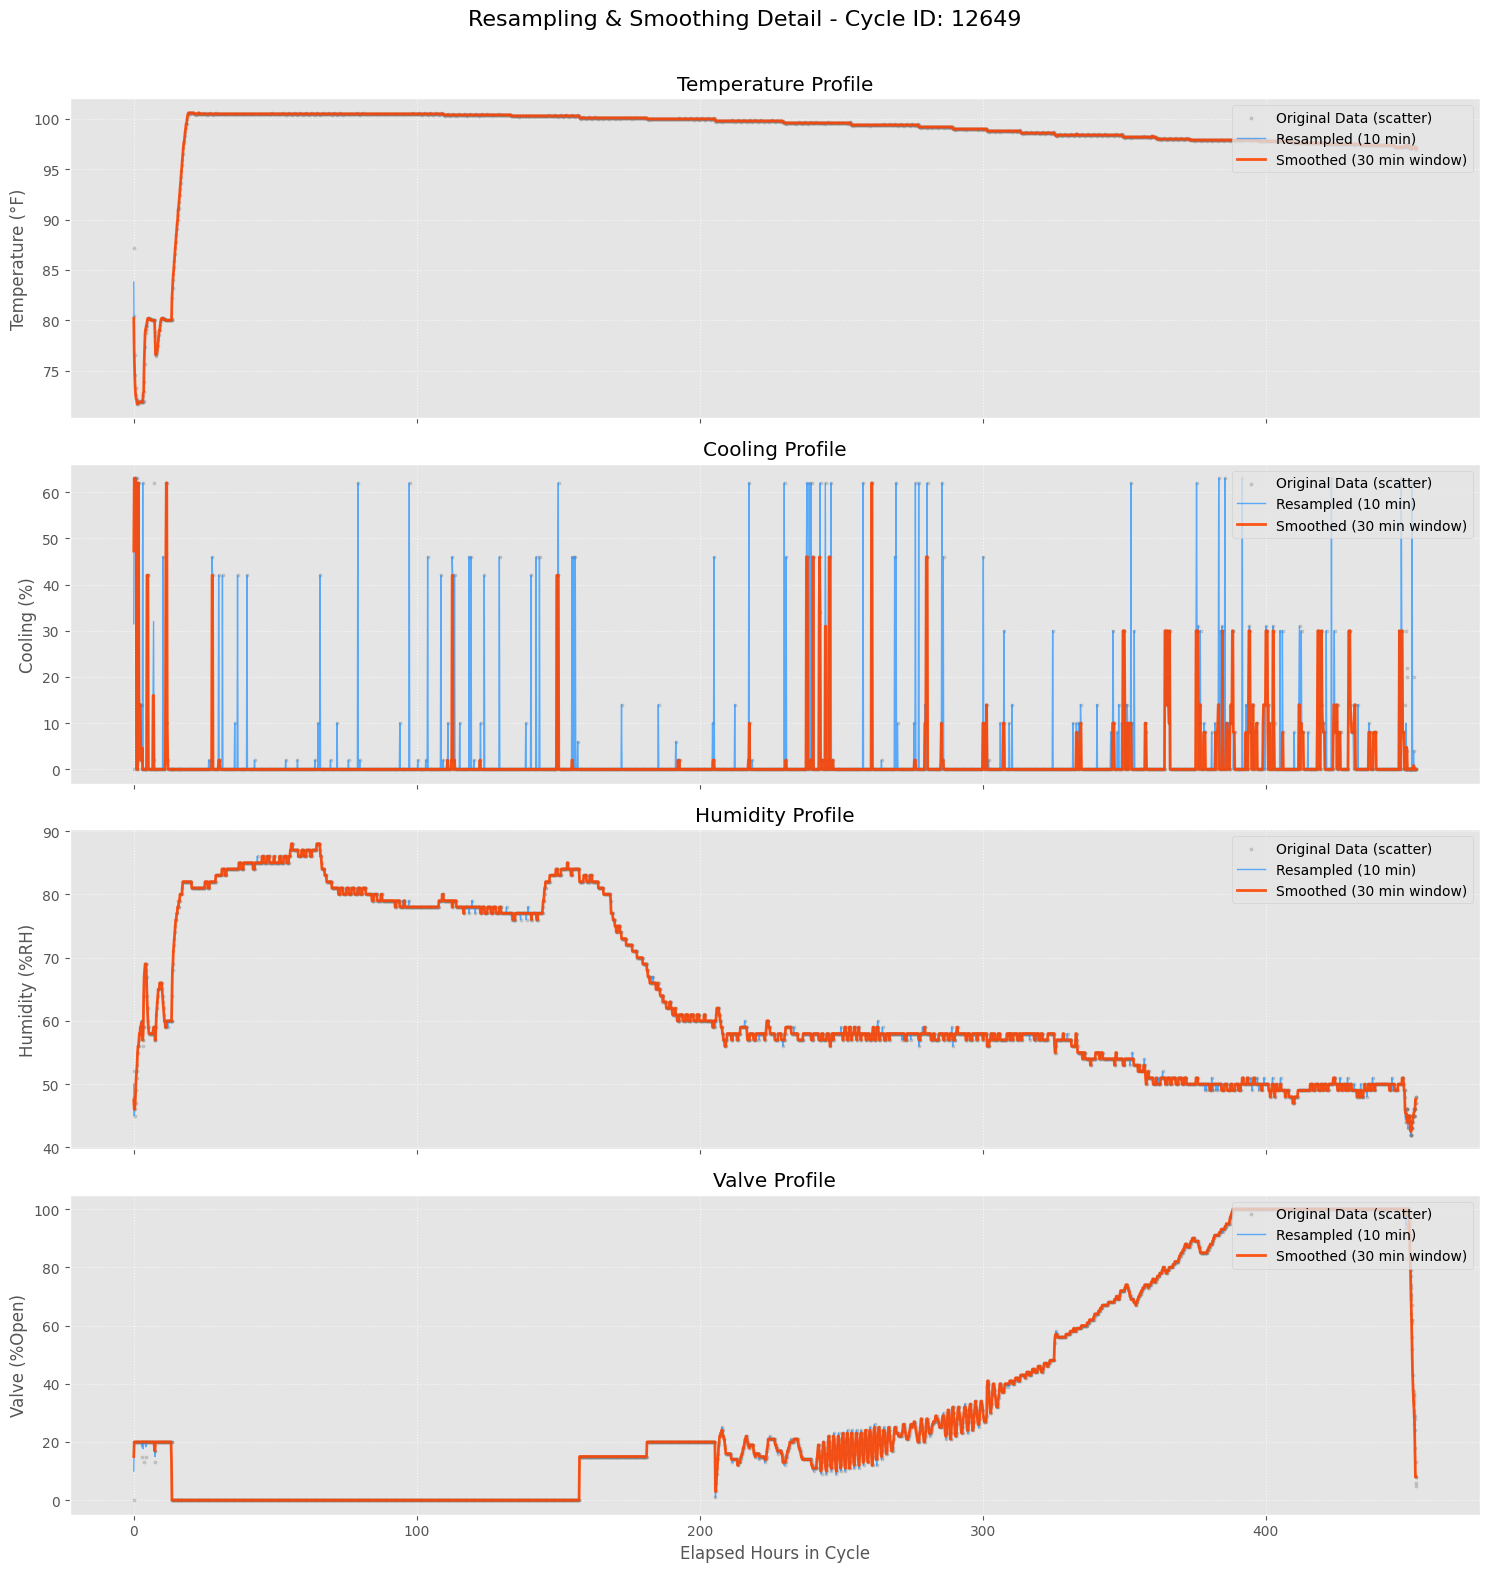


📊 ADDITIONAL VISUALIZATION CELL COMPLETE.


In [11]:
# Phase 3 - Additional Visualizations for Resampling & Smoothing
import matplotlib.pyplot as plt
import pandas as pd # Ensure pandas is imported

print("📊 ADDITIONAL VISUALIZATIONS: RESAMPLING & SMOOTHING VERIFICATION")
print("=" * 70)

if 'resampled_smoothed_logs' not in globals() or resampled_smoothed_logs.empty:
    print("❌ Error: 'resampled_smoothed_logs' not found. Please run the main Resample & Smooth cell (Phase 3 - Cell 2) first.")
elif 'sliced_climate_logs_with_phases' not in globals() or sliced_climate_logs_with_phases.empty:
    print("❌ Error: 'sliced_climate_logs_with_phases' (original pre-resampled data) not found.")
else:
    print(f"✅ Using 'resampled_smoothed_logs' (Shape: {resampled_smoothed_logs.shape})")
    print(f"✅ Using 'sliced_climate_logs_with_phases' for original data (Shape: {sliced_climate_logs_with_phases.shape})")

    # Select a few different sample CycleIDs
    all_cycle_ids = resampled_smoothed_logs['CycleID'].unique()
    if len(all_cycle_ids) > 5:
        # Pick cycles different from the first one, e.g., 2nd, 3rd, and one from the middle
        sample_cycle_ids_to_plot = [all_cycle_ids[1], all_cycle_ids[2]]
        if len(all_cycle_ids) > 100:
            sample_cycle_ids_to_plot.append(all_cycle_ids[len(all_cycle_ids)//2])
        sample_cycle_ids_to_plot = list(set(sample_cycle_ids_to_plot)) # Ensure unique
        print(f"\n🔍 Visualizing for Sample CycleIDs: {sample_cycle_ids_to_plot}")
    elif len(all_cycle_ids) > 0:
        sample_cycle_ids_to_plot = [all_cycle_ids[0]] # Fallback to first if not enough cycles
        print(f"\n🔍 Visualizing for Sample CycleID: {sample_cycle_ids_to_plot} (only one available for detailed plot)")
    else:
        print("   No cycles available in resampled_smoothed_logs to visualize.")
        sample_cycle_ids_to_plot = []
        
    signals_to_plot = {
        'Temperature': {'col': 'meas_temp1', 'unit': '°F'},
        'Cooling': {'col': 'cooling', 'unit': '%'},
        'Humidity': {'col': 'meas_RH', 'unit': '%RH'}, # Relative Humidity
        'Valve': {'col': 'meas_valve', 'unit': '%Open'}   # Valve Position
    }

    for plot_idx, cycle_id_to_plot in enumerate(sample_cycle_ids_to_plot):
        if plot_idx >= 2: # Limit to 2 new cycles for brevity in output
            break

        print(f"\n--- Visualizing Cycle ID: {cycle_id_to_plot} ---")
        
        original_cycle_data = sliced_climate_logs_with_phases[
            sliced_climate_logs_with_phases['CycleID'] == cycle_id_to_plot
        ].sort_values('TimeStamp_dt')
        
        resampled_cycle_data = resampled_smoothed_logs[
            resampled_smoothed_logs['CycleID'] == cycle_id_to_plot
        ].sort_values('TimeStamp_dt')

        if original_cycle_data.empty or resampled_cycle_data.empty:
            print(f"   Skipping Cycle ID {cycle_id_to_plot} due to missing data.")
            continue

        num_signals = len(signals_to_plot)
        fig, axes = plt.subplots(num_signals, 1, figsize=(15, 4 * num_signals), sharex=True)
        if num_signals == 1: # Make axes an array even for a single subplot
            axes = [axes]
        
        fig.suptitle(f"Resampling & Smoothing Detail - Cycle ID: {cycle_id_to_plot}", fontsize=16)

        for i, (signal_name, props) in enumerate(signals_to_plot.items()):
            ax = axes[i]
            raw_col = props['col']
            resampled_col = props['col'] # This is the resampled (but not yet smoothed) column name
            smoothed_col = f"{props['col']}_smoothed"

            # Plot original data (points)
            if raw_col in original_cycle_data.columns:
                ax.scatter(original_cycle_data['elapsed_hours'], original_cycle_data[raw_col], 
                           label='Original Data (scatter)', alpha=0.3, s=5, color='gray')
            
            # Plot resampled data (line)
            if resampled_col in resampled_cycle_data.columns:
                ax.plot(resampled_cycle_data['elapsed_hours'], resampled_cycle_data[resampled_col], 
                        label='Resampled (10 min)', alpha=0.7, color='dodgerblue', linewidth=1)
            
            # Plot smoothed data (thicker line)
            if smoothed_col in resampled_cycle_data.columns:
                ax.plot(resampled_cycle_data['elapsed_hours'], resampled_cycle_data[smoothed_col], 
                        label='Smoothed (30 min window)', alpha=0.9, color='orangered', linewidth=2)
            else:
                 # If specific smoothed column doesn't exist, it means this signal wasn't in temp_meas_cols or control_cols
                 # or smoothing wasn't applied to it. We can skip plotting it or note it.
                 pass


            ax.set_ylabel(f"{signal_name} ({props['unit']})")
            ax.set_title(f"{signal_name} Profile")
            ax.legend(loc='upper right')
            ax.grid(True, linestyle=':', alpha=0.7)

        axes[-1].set_xlabel("Elapsed Hours in Cycle")
        plt.tight_layout(rect=[0, 0, 1, 0.97]) # Adjust layout to make space for suptitle
        plt.show()

print("\n" + "="*70)
print("📊 ADDITIONAL VISUALIZATION CELL COMPLETE.")

Detailed Analysis by Profile:
Temperature Profile:
Original Data: Shows a clear startup ramp, a stable period, and then a gradual decline (typical temperature profile for incubation). There's some minor scatter/noise.
Resampled (10 min): The blue line closely follows the original data, averaging out some of the very high-frequency noise. It correctly captures the ramp, stability, and decline.
Smoothed (30 min window): The orange-red line provides a very clean representation of the temperature trend. It effectively smooths out minor fluctuations from the resampled line without distorting the major shifts (like the step-downs in temperature later in the cycle). This is ideal for identifying persistent deviations.
Cooling Profile:
Original Data: Shows very sparse cooling activity in the early stages, then becoming much more frequent and intense later in the cycle (expected as metabolic heat increases). The raw data is very "spiky" (on/off behavior).
Resampled (10 min): The blue line averages the cooling over 10-minute intervals. This means a short burst of cooling in the original data might appear as a lower, wider peak in the resampled data if it didn't last the full 10 minutes, or a consistent value if it did. It still reflects the on/off nature but at a regular interval.
Smoothed (30 min window): The orange-red line shows the trend in cooling activity over 30-minute windows. It smooths out the individual spikes significantly. For example, during periods of frequent on/off cooling, the smoothed line will show a sustained level of cooling rather than rapid oscillations. This is good for seeing the overall cooling demand rather than individual actuations.
Humidity Profile:
Original Data: Shows a ramp-up, a relatively stable period with some fluctuations, a distinct drop, and then another stable period at a lower level.
Resampled (10 min): Accurately tracks the original data's major trends.
Smoothed (30 min window): Excellently captures the main phases of humidity change, smoothing out the smaller variations within each stable period and clearly defining the sharp drop. This makes it easier to see the significant shifts.
Valve Profile:
Original Data: Shows the valve mostly closed (near 0%) for a long period, then a significant opening event, followed by a period of active modulation, and finally a trend towards being more open.
Resampled (10 min): Follows the original data well.
Smoothed (30 min window): Provides a clear view of the valve's operational regimes. It smooths the modulations after the initial large opening, showing the average position trend. The sharp increase near the end is also well-represented.
Key Takeaways from these Plots for Cycle 33:
Resampling is Effective: The 10-minute resampling provides a consistent time base without losing critical information.
Smoothing is Beneficial: The 30-minute rolling median smoothing is effectively reducing noise and jitter, making underlying trends much clearer. This is particularly useful for signals like "Cooling %" where the raw signal is very binary or spiky.
Preservation of Key Events: Important changes like temperature setpoint drops, humidity drops, and major valve position changes are well preserved by the smoothed data.
Data Quality: The original data for this cycle seems reasonably clean, with clear patterns.
Conclusion for Cycle 33:
The preprocessing steps (resampling and smoothing) have successfully transformed the raw data into a cleaner, more analyzable format suitable for feature engineering and anomaly detection, while retaining the essential characteristics and events of the incubation cycle.
This detailed look at Cycle 33 should increase your confidence that the methods are sound. If other cycles show similar positive results from this visualization cell, you are in a great shape to proceed!

# # Phase 3 - Cell 3: Comprehensive Visualization of Resampled Data


📊 COMPREHENSIVE VISUALIZATION OF RESAMPLED & SMOOTHED DATA


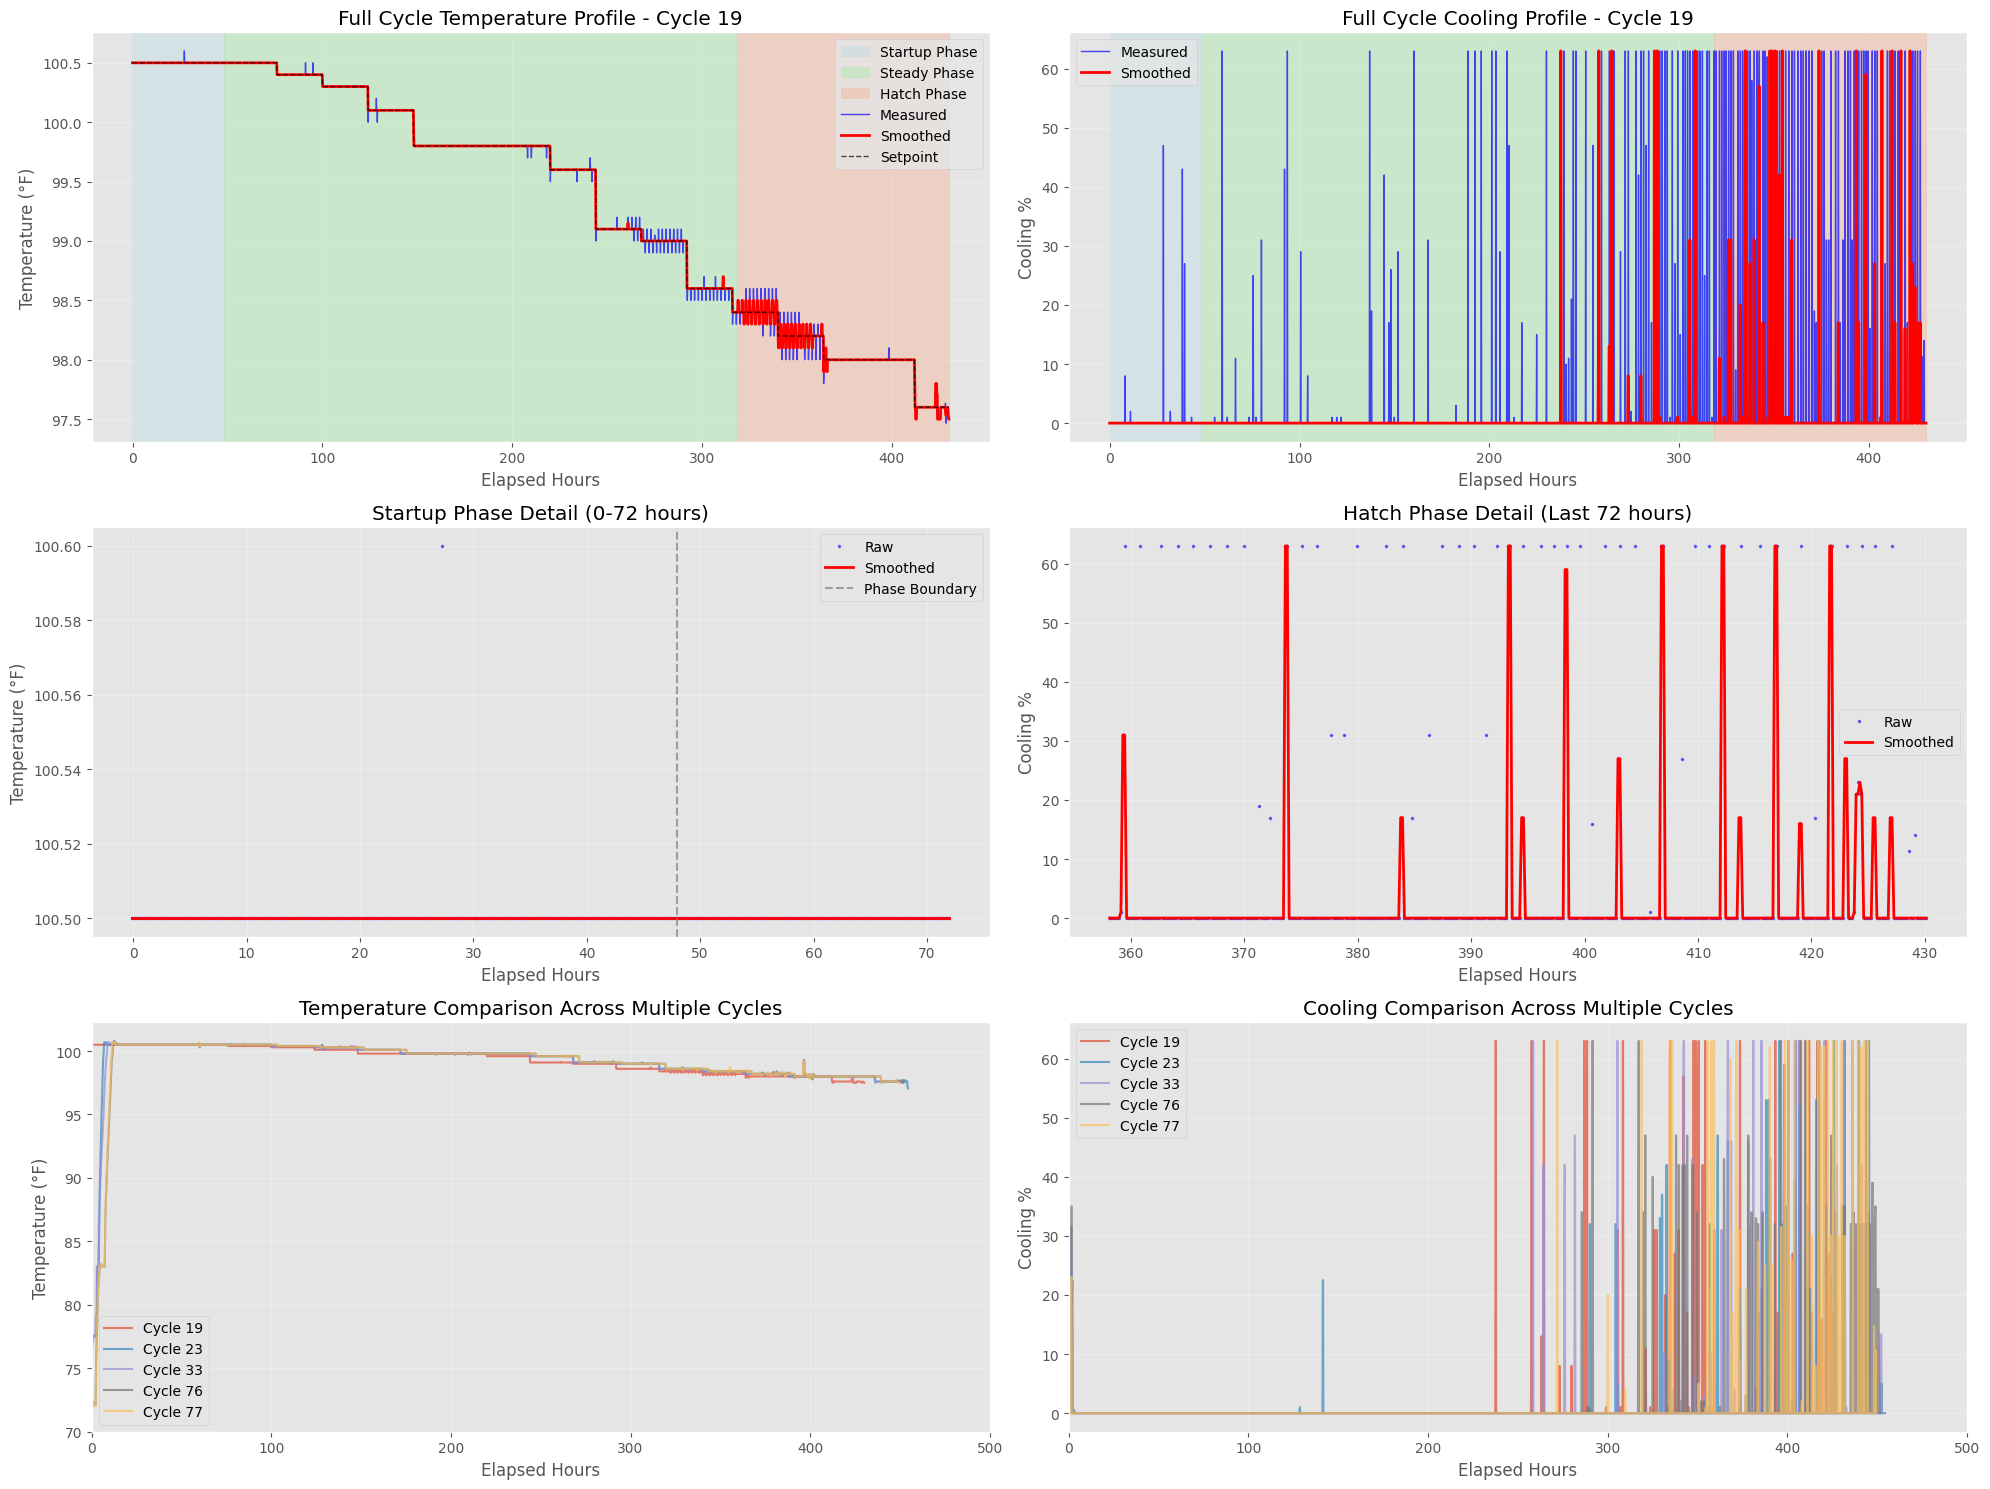


📊 STATISTICAL SUMMARY BY PHASE
--------------------------------------------------

Temperature Statistics by Phase (°F):
             mean   std    min     max
phase_name                            
Hatch       97.89  1.40  72.21  105.82
Startup     94.07  9.84  50.00  101.30
Steady      99.94  1.49  69.60  103.90

Cooling Statistics by Phase (%):
             mean    std  min   max
phase_name                         
Hatch       11.84  22.27  0.0  63.0
Startup      3.26  12.94  0.0  63.0
Steady       2.01   9.98  0.0  63.0

📊 CONTROL STABILITY ANALYSIS
------------------------------

Temperature Coefficient of Variation by Phase (%):
   Hatch: 1.43%
   Startup: 10.47%
   Steady: 1.49%

📊 SAMPLE SIZE BY PHASE
-------------------------
   Steady: 4,552,596 samples (758,766.0 hours of data)
   Hatch: 2,303,670 samples (383,945.0 hours of data)
   Startup: 810,639 samples (135,106.5 hours of data)

📋 VISUALIZATION AND ANALYSIS COMPLETE
   Ready for Phase 4: Build baselines per machine an

In [12]:
# Phase 3 - Cell 3: Comprehensive Visualization of Resampled Data
import matplotlib.pyplot as plt
import numpy as np

print("📊 COMPREHENSIVE VISUALIZATION OF RESAMPLED & SMOOTHED DATA")
print("=" * 60)

if 'resampled_smoothed_logs' not in globals() or resampled_smoothed_logs.empty:
    print("❌ Error: 'resampled_smoothed_logs' not found. Please run Phase 3 - Cell 2.")
else:
    # Select a few representative cycles for visualization
    sample_cycles = resampled_smoothed_logs['CycleID'].unique()[:5]
    
    # Create a comprehensive figure
    fig = plt.figure(figsize=(20, 15))
    
    # Define phases for coloring
    phase_colors = {1: 'lightblue', 2: 'lightgreen', 3: 'lightsalmon'}
    phase_names = {1: 'Startup', 2: 'Steady', 3: 'Hatch'}
    
    # Layout: 3 rows x 2 columns for different views
    # Row 1: Full cycle view (temperature and cooling)
    # Row 2: Phase-specific zooms
    # Row 3: Multiple cycles comparison
    
    # Get data for first cycle
    first_cycle_id = sample_cycles[0]
    first_cycle = resampled_smoothed_logs[resampled_smoothed_logs['CycleID'] == first_cycle_id]
    
    # 1. Full Cycle Temperature Profile
    ax1 = plt.subplot(3, 2, 1)
    if 'meas_temp1' in first_cycle.columns:
        # Add phase backgrounds
        for phase in [1, 2, 3]:
            phase_data = first_cycle[first_cycle['phase'] == phase]
            if len(phase_data) > 0:
                ax1.axvspan(phase_data['elapsed_hours'].min(), 
                           phase_data['elapsed_hours'].max(),
                           alpha=0.3, color=phase_colors[phase], 
                           label=f'{phase_names[phase]} Phase')
        
        # Plot temperature
        ax1.plot(first_cycle['elapsed_hours'], first_cycle['meas_temp1'], 
                'b-', linewidth=1, alpha=0.7, label='Measured')
        if 'meas_temp1_smoothed' in first_cycle.columns:
            ax1.plot(first_cycle['elapsed_hours'], first_cycle['meas_temp1_smoothed'], 
                    'r-', linewidth=2, label='Smoothed')
        if 'setpoint_temp1' in first_cycle.columns:
            ax1.plot(first_cycle['elapsed_hours'], first_cycle['setpoint_temp1'], 
                    'k--', linewidth=1, alpha=0.7, label='Setpoint')
        
        ax1.set_xlabel('Elapsed Hours')
        ax1.set_ylabel('Temperature (°F)')
        ax1.set_title(f'Full Cycle Temperature Profile - Cycle {first_cycle_id}')
        ax1.legend(loc='best')
        ax1.grid(True, alpha=0.3)
    
    # 2. Full Cycle Cooling Profile
    ax2 = plt.subplot(3, 2, 2)
    if 'cooling' in first_cycle.columns:
        # Add phase backgrounds
        for phase in [1, 2, 3]:
            phase_data = first_cycle[first_cycle['phase'] == phase]
            if len(phase_data) > 0:
                ax2.axvspan(phase_data['elapsed_hours'].min(), 
                           phase_data['elapsed_hours'].max(),
                           alpha=0.3, color=phase_colors[phase])
        
        # Plot cooling
        ax2.plot(first_cycle['elapsed_hours'], first_cycle['cooling'], 
                'b-', linewidth=1, alpha=0.7, label='Measured')
        if 'cooling_smoothed' in first_cycle.columns:
            ax2.plot(first_cycle['elapsed_hours'], first_cycle['cooling_smoothed'], 
                    'r-', linewidth=2, label='Smoothed')
        
        ax2.set_xlabel('Elapsed Hours')
        ax2.set_ylabel('Cooling %')
        ax2.set_title(f'Full Cycle Cooling Profile - Cycle {first_cycle_id}')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
    
    # 3. Startup Phase Detail (First 72 hours)
    ax3 = plt.subplot(3, 2, 3)
    startup_data = first_cycle[first_cycle['elapsed_hours'] <= 72]
    if 'meas_temp1' in startup_data.columns and len(startup_data) > 0:
        ax3.plot(startup_data['elapsed_hours'], startup_data['meas_temp1'], 
                'b.', markersize=3, alpha=0.5, label='Raw')
        ax3.plot(startup_data['elapsed_hours'], startup_data['meas_temp1_smoothed'], 
                'r-', linewidth=2, label='Smoothed')
        
        # Mark phase boundary
        ax3.axvline(48, color='gray', linestyle='--', alpha=0.7, label='Phase Boundary')
        
        ax3.set_xlabel('Elapsed Hours')
        ax3.set_ylabel('Temperature (°F)')
        ax3.set_title('Startup Phase Detail (0-72 hours)')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
    
    # 4. Hatch Phase Detail (Last 72 hours)
    ax4 = plt.subplot(3, 2, 4)
    max_hours = first_cycle['elapsed_hours'].max()
    hatch_data = first_cycle[first_cycle['elapsed_hours'] >= max_hours - 72]
    if 'cooling' in hatch_data.columns and len(hatch_data) > 0:
        ax4.plot(hatch_data['elapsed_hours'], hatch_data['cooling'], 
                'b.', markersize=3, alpha=0.5, label='Raw')
        ax4.plot(hatch_data['elapsed_hours'], hatch_data['cooling_smoothed'], 
                'r-', linewidth=2, label='Smoothed')
        
        ax4.set_xlabel('Elapsed Hours')
        ax4.set_ylabel('Cooling %')
        ax4.set_title('Hatch Phase Detail (Last 72 hours)')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
    
    # 5. Multiple Cycles Temperature Comparison
    ax5 = plt.subplot(3, 2, 5)
    for i, cycle_id in enumerate(sample_cycles[:5]):
        cycle_data = resampled_smoothed_logs[resampled_smoothed_logs['CycleID'] == cycle_id]
        if 'meas_temp1_smoothed' in cycle_data.columns:
            ax5.plot(cycle_data['elapsed_hours'], cycle_data['meas_temp1_smoothed'], 
                    alpha=0.7, linewidth=1.5, label=f'Cycle {cycle_id}')
    
    ax5.set_xlabel('Elapsed Hours')
    ax5.set_ylabel('Temperature (°F)')
    ax5.set_title('Temperature Comparison Across Multiple Cycles')
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    ax5.set_xlim(0, 500)  # Focus on main incubation period
    
    # 6. Multiple Cycles Cooling Comparison
    ax6 = plt.subplot(3, 2, 6)
    for i, cycle_id in enumerate(sample_cycles[:5]):
        cycle_data = resampled_smoothed_logs[resampled_smoothed_logs['CycleID'] == cycle_id]
        if 'cooling_smoothed' in cycle_data.columns:
            ax6.plot(cycle_data['elapsed_hours'], cycle_data['cooling_smoothed'], 
                    alpha=0.7, linewidth=1.5, label=f'Cycle {cycle_id}')
    
    ax6.set_xlabel('Elapsed Hours')
    ax6.set_ylabel('Cooling %')
    ax6.set_title('Cooling Comparison Across Multiple Cycles')
    ax6.legend()
    ax6.grid(True, alpha=0.3)
    ax6.set_xlim(0, 500)
    
    plt.tight_layout()
    plt.show()
    
    # Additional analysis: Statistical summary by phase
    print("\n📊 STATISTICAL SUMMARY BY PHASE")
    print("-" * 50)
    
    # Temperature statistics by phase
    if 'meas_temp1' in resampled_smoothed_logs.columns:
        temp_stats = resampled_smoothed_logs.groupby('phase_name')['meas_temp1'].agg([
            'mean', 'std', 'min', 'max'
        ]).round(2)
        print("\nTemperature Statistics by Phase (°F):")
        print(temp_stats)
    
    # Cooling statistics by phase
    if 'cooling' in resampled_smoothed_logs.columns:
        cooling_stats = resampled_smoothed_logs.groupby('phase_name')['cooling'].agg([
            'mean', 'std', 'min', 'max'
        ]).round(2)
        print("\nCooling Statistics by Phase (%):")
        print(cooling_stats)
    
    # Control stability analysis
    print("\n📊 CONTROL STABILITY ANALYSIS")
    print("-" * 30)
    
    # Calculate coefficient of variation (CV) for each phase
    if 'meas_temp1' in resampled_smoothed_logs.columns:
        cv_by_phase = resampled_smoothed_logs.groupby('phase_name').apply(
            lambda x: (x['meas_temp1'].std() / x['meas_temp1'].mean() * 100) if x['meas_temp1'].mean() != 0 else 0
        ).round(2)
        print("\nTemperature Coefficient of Variation by Phase (%):")
        for phase, cv in cv_by_phase.items():
            print(f"   {phase}: {cv}%")
    
    # Sample size by phase
    print("\n📊 SAMPLE SIZE BY PHASE")
    print("-" * 25)
    phase_counts = resampled_smoothed_logs['phase_name'].value_counts()
    for phase, count in phase_counts.items():
        hours = count * 10 / 60  # Convert to hours (10-minute intervals)
        print(f"   {phase}: {count:,} samples ({hours:,.1f} hours of data)")

print("\n" + "="*60)
print("📋 VISUALIZATION AND ANALYSIS COMPLETE")
print("   Ready for Phase 4: Build baselines per machine and phase")

# Phase 3 - Cell 4: Build Baselines per Machine and Phase:

This cell will:
Calculate derived metrics (control error, rate changes, stability)
Build comprehensive baselines for each machine × phase combination
Exclude extreme outliers (0.1% and 99.9% percentiles) as potential alarm periods
Analyze consistency across machines
Visualize baseline distributions
Store baselines for use in anomaly detection

🎯 PHASE 3: BUILD BASELINES PER MACHINE AND PHASE (Revised for Valve Variance)
📋 Goal: Compute per-machine × phase statistics as 'normal' references
🔍 Focus: Exclude strictest alarm windows to define typical operation

✅ Working with 7,666,905 resampled records

🔧 STEP 1: IDENTIFY KEY METRICS FOR BASELINES
----------------------------------------------
   📊 Temperature columns for baselines: 8
   📊 Control columns for baselines: 4
   📊 Derived metrics to calculate: 4

🔧 STEP 2: CALCULATE DERIVED METRICS
------------------------------------
   ✅ Calculated 'temp_control_error'
   ✅ Calculated 'cooling_rate_change'
   ✅ Calculated 'temp_stability'
      Calculating 'valve_position_variance'...
   ✅ Calculated 'valve_position_variance'

   📊 Total metrics for baseline calculation: 16
      Metrics: ['meas_temp1_smoothed', 'meas_temp2_smoothed', 'meas_temp3_smoothed', 'meas_temp4_smoothed', 'meas_temp5_smoothed', 'meas_temp6_smoothed', 'meas_temp7_smoothed', 'meas_temp8_smoothed', 'cooling_

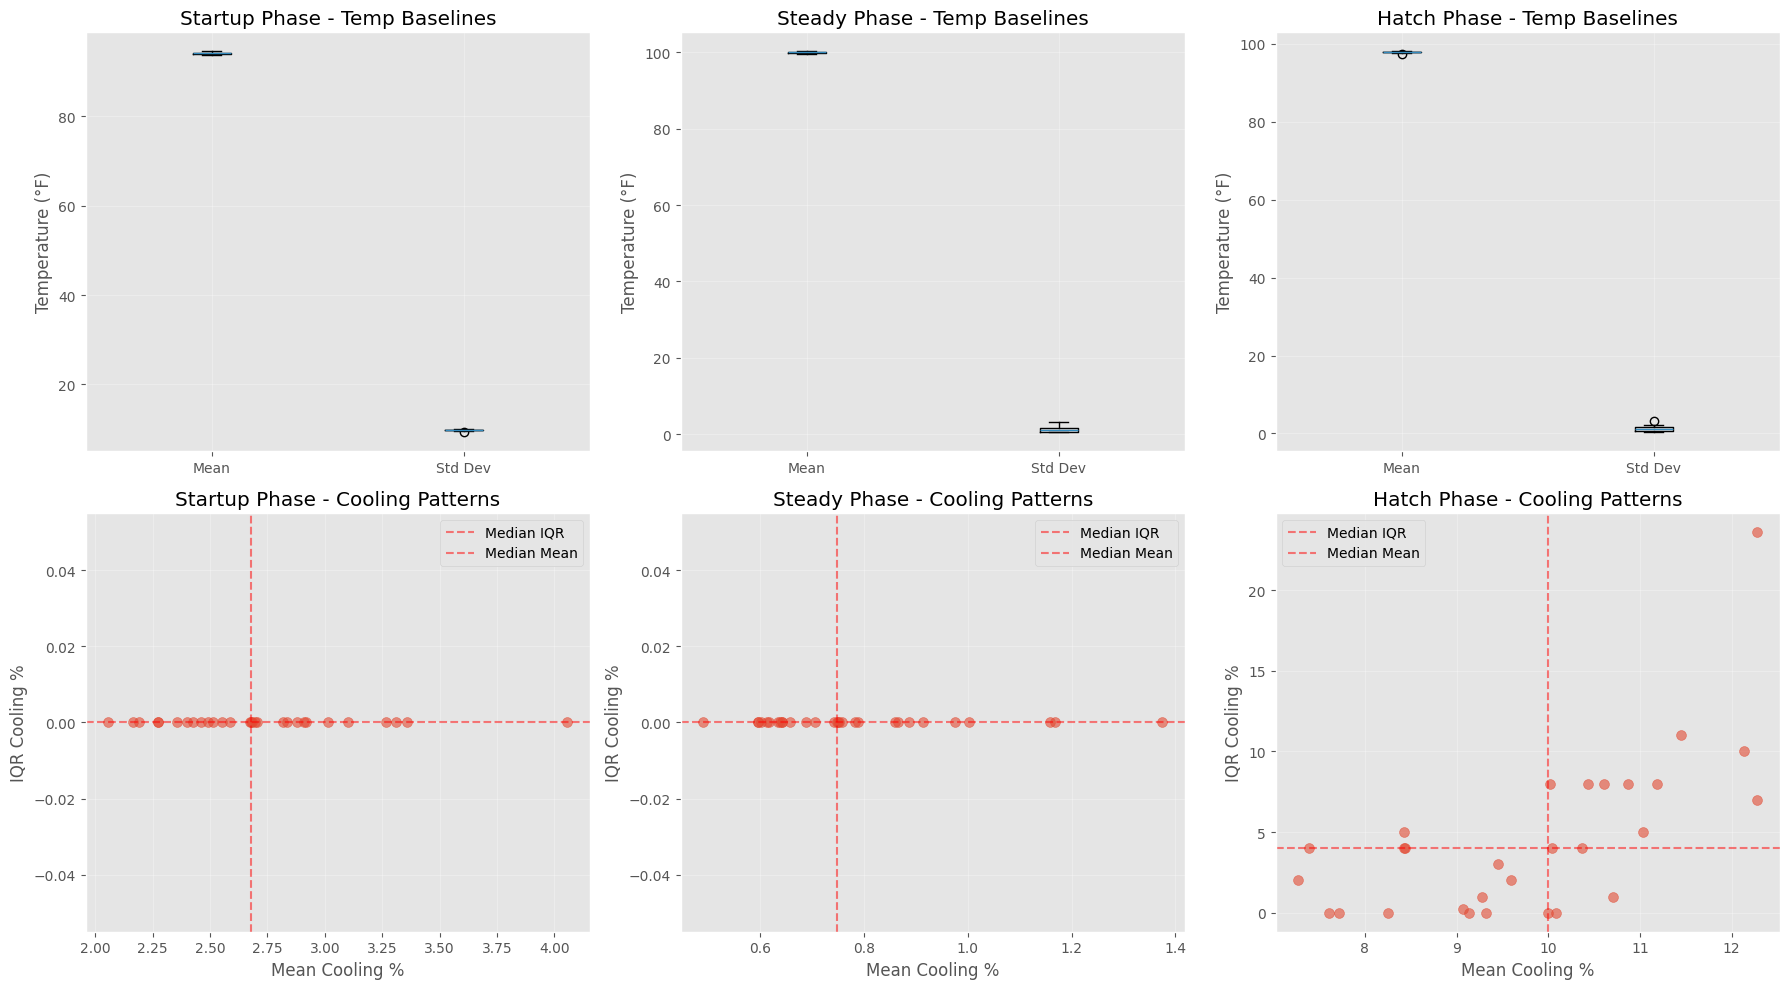


✅ Baselines computed and stored as 'machine_phase_baselines'
   Shape: (87, 100)
   Baseline metrics tracked: 16

📊 BASELINE SUMMARY BY PHASE
------------------------------

Startup Phase (29 machine configurations):
   Avg Temperature: 94.1°F (±9.81°F typical variation)
   Avg Cooling: 2.7% (IQR: 0.0%)

Steady Phase (29 machine configurations):
   Avg Temperature: 100.0°F (±1.22°F typical variation)
   Avg Cooling: 0.8% (IQR: 0.0%)

Hatch Phase (29 machine configurations):
   Avg Temperature: 97.9°F (±1.19°F typical variation)
   Avg Cooling: 9.8% (IQR: 4.5%)

📋 PHASE 3 COMPLETE - BASELINES ESTABLISHED (with Valve Variance)
   Next: Phase 4 - Feature Engineering & Anomaly Scoring


: 

In [13]:
# Phase 3 - Cell 4: Build Baselines per Machine and Phase (Revised for Valve Variance)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats # Already imported, but good to note

print("🎯 PHASE 3: BUILD BASELINES PER MACHINE AND PHASE (Revised for Valve Variance)")
print("=" * 60) # Adjusted title length
print("📋 Goal: Compute per-machine × phase statistics as 'normal' references")
print("🔍 Focus: Exclude strictest alarm windows to define typical operation")
print()

if 'resampled_smoothed_logs' not in globals() or resampled_smoothed_logs.empty:
    print("❌ Error: 'resampled_smoothed_logs' not found. Please run previous Phase 3 cells.")
    raise ValueError("'resampled_smoothed_logs' is essential for this step.")
else:
    print(f"✅ Working with {len(resampled_smoothed_logs):,} resampled records")
    
    # Identify key columns for baseline calculation
    print("\n🔧 STEP 1: IDENTIFY KEY METRICS FOR BASELINES")
    print("-" * 46)
    
    temp_cols = [col for col in resampled_smoothed_logs.columns if 'meas_temp' in col and '_smoothed' in col]
    control_cols_candidates = ['cooling_smoothed', 'heating_smoothed', 'meas_RH_smoothed', 'meas_valve_smoothed']
    control_cols = [col for col in control_cols_candidates if col in resampled_smoothed_logs.columns]
    
    # Key derived metrics we'll calculate
    # Added 'valve_position_variance' to this list
    derived_metrics_to_calculate = [
        'temp_control_error',
        'cooling_rate_change',
        'temp_stability',
        'valve_position_variance' # Added here
    ]
    
    print(f"   📊 Temperature columns for baselines: {len(temp_cols)}")
    print(f"   📊 Control columns for baselines: {len(control_cols)}")
    print(f"   📊 Derived metrics to calculate: {len(derived_metrics_to_calculate)}")
    
    # Calculate derived metrics
    print("\n🔧 STEP 2: CALCULATE DERIVED METRICS")
    print("-" * 36)
    
    if 'meas_temp1_smoothed' in resampled_smoothed_logs.columns and 'setpoint_temp1' in resampled_smoothed_logs.columns:
        resampled_smoothed_logs['temp_control_error'] = (
            resampled_smoothed_logs['meas_temp1_smoothed'] - resampled_smoothed_logs['setpoint_temp1']
        )
        print("   ✅ Calculated 'temp_control_error'")
    else:
        print("   ⚠️ Could not calculate 'temp_control_error' (missing required columns).")

    if 'cooling_smoothed' in resampled_smoothed_logs.columns and 'CycleID' in resampled_smoothed_logs.columns:
        resampled_smoothed_logs['cooling_rate_change'] = (
            resampled_smoothed_logs.groupby('CycleID')['cooling_smoothed']
            .transform(lambda x: x.diff().fillna(0))
        )
        print("   ✅ Calculated 'cooling_rate_change'")
    else:
        print("   ⚠️ Could not calculate 'cooling_rate_change' (missing 'cooling_smoothed' or 'CycleID').")
        
    if 'meas_temp1_smoothed' in resampled_smoothed_logs.columns and 'CycleID' in resampled_smoothed_logs.columns:
        # Fill NaNs from rolling std with overall std for the group to avoid NaNs if window is too small at start
        resampled_smoothed_logs['temp_stability'] = (
            resampled_smoothed_logs.groupby('CycleID')['meas_temp1_smoothed']
            .transform(lambda x: x.rolling(window=6, min_periods=3).std().fillna(method='bfill').fillna(method='ffill').fillna(x.mean())) # Improved fillna
        )
        print("   ✅ Calculated 'temp_stability'")
    else:
        print("   ⚠️ Could not calculate 'temp_stability' (missing 'meas_temp1_smoothed' or 'CycleID').")

    # NEW: Calculate valve_position_variance
    if 'meas_valve_smoothed' in resampled_smoothed_logs.columns and 'CycleID' in resampled_smoothed_logs.columns:
        try:
            print("      Calculating 'valve_position_variance'...")
            resampled_smoothed_logs['valve_position_variance'] = resampled_smoothed_logs.groupby('CycleID')['meas_valve_smoothed']\
                .transform(lambda x: x.rolling(window=6, min_periods=3).var().fillna(method='bfill').fillna(method='ffill').fillna(0)) # Fill NaNs carefully
            print("   ✅ Calculated 'valve_position_variance'")
        except Exception as e:
            print(f"   ⚠️ Error calculating 'valve_position_variance': {e}. Column might not be included in baselines.")
            if 'valve_position_variance' in resampled_smoothed_logs.columns:
                 del resampled_smoothed_logs['valve_position_variance'] # Remove partially created column if error
    else:
        print("   ⚠️ Could not calculate 'valve_position_variance' (missing 'meas_valve_smoothed' or 'CycleID').")
        
    # Build comprehensive baseline columns list
    # Now includes 'valve_position_variance' if it was successfully created
    baseline_cols = temp_cols + control_cols + [col for col in derived_metrics_to_calculate if col in resampled_smoothed_logs.columns]
    
    print(f"\n   📊 Total metrics for baseline calculation: {len(baseline_cols)}")
    print(f"      Metrics: {baseline_cols}") # Print the actual list
    
    # Calculate baselines per machine and phase
    print("\n🔧 STEP 3: CALCULATE BASELINES PER MACHINE × PHASE")
    print("-" * 51)
    
    baseline_stats = []
    if 'MachineID' not in resampled_smoothed_logs.columns or 'phase' not in resampled_smoothed_logs.columns:
        print("   ❌ Cannot calculate baselines: 'MachineID' or 'phase' column missing from 'resampled_smoothed_logs'.")
        baselines_df = pd.DataFrame() # Create empty df to avoid downstream errors
    else:
        for machine_id in resampled_smoothed_logs['MachineID'].unique():
            machine_data = resampled_smoothed_logs[resampled_smoothed_logs['MachineID'] == machine_id]
            for phase_val in [1, 2, 3]: # Use phase_val to avoid conflict with phase module
                phase_data = machine_data[machine_data['phase'] == phase_val]
                if len(phase_data) > 100:
                    stats_dict = {
                        'MachineID': machine_id,
                        'phase': phase_val, # Use phase_val here
                        'phase_name': {1: 'Startup', 2: 'Steady', 3: 'Hatch'}[phase_val],
                        'sample_count': len(phase_data)
                    }
                    for col in baseline_cols:
                        if col in phase_data.columns:
                            col_data = phase_data[col].dropna()
                            if len(col_data) > 1: # Need at least 2 points for std dev
                                lower, upper = col_data.quantile(0.001), col_data.quantile(0.999)
                                col_data_clean = col_data[(col_data >= lower) & (col_data <= upper)]
                                if len(col_data_clean) > 1: # Ensure cleaned data also has enough points
                                    stats_dict[f'{col}_mean'] = col_data_clean.mean()
                                    stats_dict[f'{col}_median'] = col_data_clean.median()
                                    stats_dict[f'{col}_std'] = col_data_clean.std()
                                    stats_dict[f'{col}_q25'] = col_data_clean.quantile(0.25)
                                    stats_dict[f'{col}_q75'] = col_data_clean.quantile(0.75)
                                    stats_dict[f'{col}_iqr'] = stats_dict[f'{col}_q75'] - stats_dict[f'{col}_q25']
                                else:
                                    # print(f"     Skipping stats for {col} in M{machine_id}-P{phase_val} (not enough cleaned data)")
                                    pass # Not enough data after cleaning
                            # else:
                                # print(f"     Skipping stats for {col} in M{machine_id}-P{phase_val} (not enough raw data)")
                                # pass # Not enough raw data
                    baseline_stats.append(stats_dict)
        baselines_df = pd.DataFrame(baseline_stats)

    if not baselines_df.empty:
        print(f"   ✅ Calculated baselines for {len(baselines_df)} machine × phase combinations")
        print(f"   📊 Machines with baselines: {baselines_df['MachineID'].nunique()}")
    else:
        print("   ⚠️ No baselines were calculated.")

    # Analyze baseline consistency
    print("\n🔧 STEP 4: ANALYZE BASELINE CONSISTENCY")
    print("-" * 40)
    consistency_analysis = []
    if not baselines_df.empty:
        for phase_name_consistency in ['Startup', 'Steady', 'Hatch']: # Use different var name
            phase_baselines_consistency = baselines_df[baselines_df['phase_name'] == phase_name_consistency]
            if len(phase_baselines_consistency) > 5:
                if 'meas_temp1_smoothed_mean' in phase_baselines_consistency.columns:
                    temp_mean_values = phase_baselines_consistency['meas_temp1_smoothed_mean'].dropna()
                    if len(temp_mean_values) > 1 and temp_mean_values.mean() != 0: # Avoid division by zero
                        temp_cv = (temp_mean_values.std() / temp_mean_values.mean() * 100)
                        consistency_analysis.append({
                            'phase': phase_name_consistency, 'metric': 'Temperature Mean',
                            'cv_across_machines': temp_cv,
                            'range': f"{temp_mean_values.min():.1f} - {temp_mean_values.max():.1f}"
                        })
                if 'cooling_smoothed_mean' in phase_baselines_consistency.columns and 'cooling_smoothed_iqr' in phase_baselines_consistency.columns:
                    cooling_iqr_mean = phase_baselines_consistency['cooling_smoothed_iqr'].mean()
                    cooling_mean_values = phase_baselines_consistency['cooling_smoothed_mean'].dropna()
                    if len(cooling_mean_values) > 0:
                         consistency_analysis.append({
                            'phase': phase_name_consistency, 'metric': 'Cooling IQR',
                            'mean_iqr': cooling_iqr_mean,
                            'range': f"{cooling_mean_values.min():.1f} - {cooling_mean_values.max():.1f}"
                        })
        consistency_df = pd.DataFrame(consistency_analysis)
        if not consistency_df.empty:
            print("\n   Baseline Consistency Analysis:")
            for _, row in consistency_df.iterrows():
                if 'cv_across_machines' in row and pd.notna(row['cv_across_machines']):
                    print(f"   {row['phase']} - {row['metric']}: CV={row['cv_across_machines']:.2f}%, Range={row['range']}")
                elif 'mean_iqr' in row and pd.notna(row['mean_iqr']):
                    print(f"   {row['phase']} - {row['metric']}: Mean IQR={row['mean_iqr']:.2f}, Range={row['range']}")
        else:
            print("   ℹ️ Insufficient data for detailed consistency analysis across multiple machines per phase.")
    else:
        print("   ℹ️ Skipping consistency analysis as no baselines were calculated.")

    # Visualize baselines
    print("\n📊 VISUALIZING BASELINE DISTRIBUTIONS")
    if not baselines_df.empty:
        fig, axes = plt.subplots(2, 3, figsize=(18, 10))
        for idx, phase_name_viz in enumerate(['Startup', 'Steady', 'Hatch']): # Use different var name
            ax_temp, ax_cool = axes[0, idx], axes[1, idx]
            phase_baselines_viz = baselines_df[baselines_df['phase_name'] == phase_name_viz]
            if not phase_baselines_viz.empty:
                if 'meas_temp1_smoothed_mean' in phase_baselines_viz.columns:
                    data_to_plot_temp, labels_temp = [], []
                    data_to_plot_temp.append(phase_baselines_viz['meas_temp1_smoothed_mean'].dropna())
                    labels_temp.append('Mean')
                    if 'meas_temp1_smoothed_std' in phase_baselines_viz.columns:
                        data_to_plot_temp.append(phase_baselines_viz['meas_temp1_smoothed_std'].dropna())
                        labels_temp.append('Std Dev')
                    if any(len(d) > 0 for d in data_to_plot_temp): # Check if there's data to plot
                         ax_temp.boxplot([d for d in data_to_plot_temp if len(d)>0], labels=[l for d,l in zip(data_to_plot_temp, labels_temp) if len(d)>0])
                    ax_temp.set_title(f'{phase_name_viz} Phase - Temp Baselines')
                    ax_temp.set_ylabel('Temperature (°F)'); ax_temp.grid(True, alpha=0.3)

                if 'cooling_smoothed_mean' in phase_baselines_viz.columns and 'cooling_smoothed_iqr' in phase_baselines_viz.columns:
                    ax_cool.scatter(phase_baselines_viz['cooling_smoothed_mean'], phase_baselines_viz['cooling_smoothed_iqr'], alpha=0.6, s=50)
                    ax_cool.set_xlabel('Mean Cooling %'); ax_cool.set_ylabel('IQR Cooling %')
                    ax_cool.set_title(f'{phase_name_viz} Phase - Cooling Patterns'); ax_cool.grid(True, alpha=0.3)
                    if not phase_baselines_viz['cooling_smoothed_iqr'].dropna().empty:
                         ax_cool.axhline(phase_baselines_viz['cooling_smoothed_iqr'].median(), color='red', linestyle='--', alpha=0.5, label='Median IQR')
                    if not phase_baselines_viz['cooling_smoothed_mean'].dropna().empty:
                         ax_cool.axvline(phase_baselines_viz['cooling_smoothed_mean'].median(), color='red', linestyle='--', alpha=0.5, label='Median Mean')
                    ax_cool.legend()
            else:
                ax_temp.text(0.5, 0.5, "No data", ha='center', va='center'); ax_temp.set_title(f'{phase_name_viz} Phase - Temp Baselines')
                ax_cool.text(0.5, 0.5, "No data", ha='center', va='center'); ax_cool.set_title(f'{phase_name_viz} Phase - Cooling Patterns')
        plt.tight_layout(); plt.show()
    else:
        print("   ℹ️ Skipping visualizations as no baselines were calculated.")
        
    globals()['machine_phase_baselines'] = baselines_df
    globals()['baseline_columns'] = baseline_cols if 'baseline_cols' in locals() else [] # Ensure baseline_cols is defined
    
    if not baselines_df.empty:
        print(f"\n✅ Baselines computed and stored as 'machine_phase_baselines'")
        print(f"   Shape: {baselines_df.shape}")
        print(f"   Baseline metrics tracked: {len(globals().get('baseline_columns', []))}") # Use .get() for safety
        print("\n📊 BASELINE SUMMARY BY PHASE"); print("-" * 30)
        for phase_name_sum in ['Startup', 'Steady', 'Hatch']: # Use different var name
            phase_data_sum = baselines_df[baselines_df['phase_name'] == phase_name_sum]
            if not phase_data_sum.empty:
                print(f"\n{phase_name_sum} Phase ({len(phase_data_sum)} machine configurations):")
                if 'meas_temp1_smoothed_mean' in phase_data_sum.columns:
                    temp_mean, temp_std_mean = phase_data_sum['meas_temp1_smoothed_mean'].mean(), phase_data_sum['meas_temp1_smoothed_std'].mean()
                    print(f"   Avg Temperature: {temp_mean:.1f}°F (±{temp_std_mean:.2f}°F typical variation)")
                if 'cooling_smoothed_mean' in phase_data_sum.columns:
                    cool_mean, cool_iqr_mean = phase_data_sum['cooling_smoothed_mean'].mean(), phase_data_sum['cooling_smoothed_iqr'].mean()
                    print(f"   Avg Cooling: {cool_mean:.1f}% (IQR: {cool_iqr_mean:.1f}%)")
    else:
        print("   ℹ️ No baseline summary as no baselines were calculated.")

print("\n" + "="*60)
print("📋 PHASE 3 COMPLETE - BASELINES ESTABLISHED (with Valve Variance)")
print("   Next: Phase 4 - Feature Engineering & Anomaly Scoring")

Here's a summary of what the cell accomplished based on the output:
Identified Key Metrics: It identified 8 temperature columns, 4 control columns, and 4 derived metrics (including the newly revised valve_position_variance) for baseline calculations, totaling 16 metrics.
Calculated Derived Metrics:
temp_control_error
cooling_rate_change
temp_stability
valve_position_variance (This was successfully calculated, which is great!)
Calculated Baselines: It computed baselines (mean, median, std, q25, q75, iqr) for these 16 metrics for each of the 87 machine × phase combinations, covering 29 unique machines. The resulting baselines_df has a shape of (87, 100).
Analyzed Baseline Consistency: It performed a consistency analysis across machines for each phase, showing:
Temperature Mean CV: Very low for all phases (Startup: 0.23%, Steady: 0.14%, Hatch: 0.15%), indicating consistent mean temperatures across machines within the same phase.
Cooling IQR:
Startup: Mean IQR = 0.00 (Range: 2.1 - 4.1% mean cooling)
Steady: Mean IQR = 0.00 (Range: 0.5 - 1.4% mean cooling)
Hatch: Mean IQR = 4.51 (Range: 7.3 - 12.3% mean cooling) - Higher IQR and mean cooling in hatch phase is expected due to metabolic heat.
Visualized Baseline Distributions: The plots were generated successfully (as indicated by the absence of an error and the subsequent print statements). The image you provided shows these plots:
Temperature Baselines (Boxplots): For each phase (Startup, Steady, Hatch), it shows boxplots for the 'Mean' and 'Std Dev' of meas_temp1_smoothed across the different machines. This helps visualize the distribution and consistency of these baseline temperature metrics.
Cooling Patterns (Scatter Plots): For each phase, it shows scatter plots of 'Mean Cooling %' vs. 'IQR Cooling %'.
Startup and Steady phases show cooling percentages clustered near zero, with very low IQR, which is consistent with the numerical summary.
Hatch phase shows a wider spread of mean cooling percentages and higher IQRs, reflecting the active cooling to manage metabolic heat. The median lines help to see the central tendency.
Stored Baselines: The computed baselines were stored in the global DataFrame machine_phase_baselines.
Summarized Baselines by Phase:
Startup: Avg Temp: 94.1°F (±9.81°F); Avg Cooling: 2.7% (IQR: 0.0%)
Steady: Avg Temp: 100.0°F (±1.22°F); Avg Cooling: 0.8% (IQR: 0.0%)
Hatch: Avg Temp: 97.9°F (±1.19°F); Avg Cooling: 9.8% (IQR: 4.5%)

# Phase 4: Feature Engineering & Anomaly Scoring:

This comprehensive implementation:
Creates raw features (control errors, chamber ΔT, actuator stats)
Calculates phase-normalized z-scores using the baselines
Smart-samples clean data for training
Trains PCA, DBSCAN, and Isolation Forest
Scores all data with an ensemble approach
Adds sensor health flags
Visualizes the results

In [ ]:
# Cell B: Phase 4 - Feature Engineering & Anomaly Scoring (Revised Checkpoint Strategy & Memory Enhancements v3.1)
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN # Make sure DBSCAN is imported if used in training
from sklearn.neighbors import NearestNeighbors # For DBSCAN eps estimation
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle
import gc # Garbage Collection
import warnings
warnings.filterwarnings('ignore') # Reduce warnings for cleaner output

print("🎯 PHASE 4: FEATURE ENGINEERING & ANOMALY SCORING (Revised Checkpoint Strategy & Memory Enhancements v3.1)")
print("=" * 70)

# --- Ensure checkpoint function is available ---
if 'save_checkpoint' not in globals() or 'checkpoint_dir' not in globals():
    print("⚠️ 'save_checkpoint' or 'checkpoint_dir' not found globally. Defining a basic 'save_checkpoint' for this cell.")
    checkpoint_dir = Path("anomaly_detection_checkpoints") # Ensure this is global or passed if function is external
    checkpoint_dir.mkdir(exist_ok=True)
    
    def save_checkpoint(data_dict, checkpoint_name):
        checkpoint_path_local = checkpoint_dir / f"{checkpoint_name}.pkl"
        print(f"\n--- Saving Checkpoint: '{checkpoint_name}' ---")
        try:
            # Prepare a dictionary for pickling, handling model copies if necessary (though often not strictly needed for standard sklearn models)
            dict_to_save_pkl = {}
            for key, value in data_dict.items():
                if key == 'anomaly_models' and isinstance(value, dict): # Example: special handling for models dict
                    models_copy_for_pkl = {}
                    for mk, mv in value.items():
                        models_copy_for_pkl[mk] = mv # Shallow copy of model objects
                    dict_to_save_pkl[key] = models_copy_for_pkl
                else:
                    dict_to_save_pkl[key] = value
            
            with open(checkpoint_path_local, 'wb') as f:
                pickle.dump(dict_to_save_pkl, f)
            print(f"💾 Saved PKL checkpoint: {checkpoint_name} to {checkpoint_path_local}")
            
            # Save DataFrames associated with this checkpoint name
            for key, value in data_dict.items():
                if isinstance(value, pd.DataFrame) and not value.empty:
                    try:
                        parquet_path_local = checkpoint_dir / f"{checkpoint_name}_{key}.parquet"
                        value.to_parquet(parquet_path_local)
                        print(f"   📄 Saved DataFrame '{key}' as PARQUET ({len(value):,} rows) to {parquet_path_local}")
                    except Exception as e_parq_local:
                        print(f"   ⚠️ Error saving DataFrame '{key}' as PARQUET: {e_parq_local}")
                elif isinstance(value, pd.DataFrame) and value.empty:
                    print(f"   ℹ️ DataFrame '{key}' is empty, not saving as PARQUET.")
        except Exception as e_pkl_local:
            print(f"❌ Error saving PKL checkpoint '{checkpoint_name}': {e_pkl_local}")
            import traceback
            traceback.print_exc()
# --- End of checkpoint function definition ---

# Verify required data from Phase 3
if 'resampled_smoothed_logs' not in globals() or not isinstance(resampled_smoothed_logs, pd.DataFrame) or resampled_smoothed_logs.empty:
    raise ValueError("'resampled_smoothed_logs' is missing or invalid. Please run/load Phase 3 results.") 
if 'machine_phase_baselines' not in globals() or not isinstance(machine_phase_baselines, pd.DataFrame) or machine_phase_baselines.empty:
    raise ValueError("'machine_phase_baselines' is missing or invalid. Please run/load Phase 3 results.")

print(f"✅ Working with {len(resampled_smoothed_logs):,} records from 'resampled_smoothed_logs'")
print(f"✅ Using baselines from {len(machine_phase_baselines)} machine-phase combinations in 'machine_phase_baselines'")

# Step 1: Create Raw Features
print("\n🔧 STEP 1: CREATE RAW FEATURES")
print("-" * 30)
feature_data = resampled_smoothed_logs.copy() 
del resampled_smoothed_logs 
gc.collect()

if 'temp_control_error' not in feature_data.columns and \
   'meas_temp1_smoothed' in feature_data.columns and \
   'setpoint_temp1' in feature_data.columns:
    feature_data['temp_control_error'] = feature_data['meas_temp1_smoothed'] - feature_data['setpoint_temp1']
    print("   ✅ Created 'temp_control_error'")

if 'meas_valve_smoothed' in feature_data.columns:
    try:
        print("      Attempting direct transform for 'valve_position_variance'...")
        # Ensure CycleID is present for groupby
        if 'CycleID' not in feature_data.columns: feature_data['CycleID'] = feature_data['IncubatorID'] # Or some default if IncubatorID is Cycle
        
        feature_data['valve_position_variance'] = feature_data.groupby('CycleID')['meas_valve_smoothed']\
            .transform(lambda x: x.rolling(window=6, min_periods=3).var().fillna(0))
        print("   ✅ Created 'valve_position_variance' (direct transform).")
    except MemoryError:
        print("   ⚠️ MemoryError with direct transform for valve variance. Filling with 0.")
        feature_data['valve_position_variance'] = 0
    except KeyError as e:
        print(f"   ⚠️ KeyError during valve_position_variance (likely 'CycleID' missing or mistyped): {e}. Filling with 0.")
        feature_data['valve_position_variance'] = 0
else:
    print("   ⚠️ 'meas_valve_smoothed' not in feature_data. Skipping 'valve_position_variance'.")
    feature_data['valve_position_variance'] = 0 


raw_features_list_defined = ['temp_control_error', 'cooling_smoothed', 'heating_smoothed', 
                             'cooling_rate_change', 'temp_stability', 'meas_RH_smoothed', 
                             'meas_valve_smoothed', 'valve_position_variance']
raw_features = [f_name for f_name in raw_features_list_defined if f_name in feature_data.columns]
print(f"   📊 Raw features to be used: {raw_features}")

# Step 2: Calculate Phase-Normalized Z-Scores
print("\n🔧 STEP 2: CALCULATE PHASE-NORMALIZED Z-SCORES")
print("-" * 47)
if 'phase' not in feature_data.columns:
    print("   ❌ CRITICAL: 'phase' column missing...")
    if 'elapsed_hours' in feature_data.columns and 'phase_defaults' in globals() and isinstance(phase_defaults, dict):
        print("      Attempting to re-create 'phase' column using defaults...")
        sd_end = phase_defaults.get('startup_end_hours', 24) # Provide default if key missing
        h_start = phase_defaults.get('hatch_start_hours', 456) # Provide default
        feature_data['phase'] = 2 # Default to main phase
        feature_data.loc[feature_data['elapsed_hours'] < sd_end, 'phase'] = 1 # Startup
        feature_data.loc[feature_data['elapsed_hours'] >= h_start, 'phase'] = 3 # Hatch
        print("      Re-created 'phase' column using defaults.")
    else:
        print("      Could not re-create 'phase'. Ensure 'elapsed_hours' exists and 'phase_defaults' dict is properly defined if dynamic phase creation is needed.")
        raise ValueError("'phase' column is essential and could not be re-created.")

print("   Merging with machine_phase_baselines...")
# Ensure 'MachineID' and 'phase' are suitable for merge
if 'MachineID' not in feature_data.columns:
    if 'IncubatorID' in feature_data.columns: feature_data['MachineID'] = feature_data['IncubatorID']
    else: raise ValueError("'MachineID' or equivalent not found in feature_data for merging baselines.")

feature_data_with_stats = feature_data.merge(
    machine_phase_baselines, 
    on=['MachineID', 'phase'], 
    how='left', 
    suffixes=('', '_baseline_stat') 
)
del feature_data 
gc.collect()
print(f"   Size after merge: {feature_data_with_stats.shape}")

z_score_features = []
if not raw_features: print("   ⚠️ No raw features identified. Z-scores will be empty.")
for feature_name_iter in raw_features:
    mean_col_name_iter, std_col_name_iter = f'{feature_name_iter}_mean', f'{feature_name_iter}_std'
    if mean_col_name_iter in feature_data_with_stats.columns and std_col_name_iter in feature_data_with_stats.columns:
        z_score_col_name_iter = f'{feature_name_iter}_z'
        
        feat_values_iter = pd.to_numeric(feature_data_with_stats[feature_name_iter], errors='coerce')
        baseline_m_iter = pd.to_numeric(feature_data_with_stats[mean_col_name_iter], errors='coerce')
        baseline_s_iter = pd.to_numeric(feature_data_with_stats[std_col_name_iter], errors='coerce')
        
        # Fill NaNs in feature values with their phase-specific mean *before* Z-score calculation
        feat_filled_for_z_iter = feat_values_iter.fillna(baseline_m_iter) 
        
        numerator_z_iter = feat_filled_for_z_iter - baseline_m_iter
        denominator_z_iter = baseline_s_iter.replace(0, np.nan) # Replace 0 std with NaN to avoid division by zero, then fill resulting NaNs
        
        z_scores_calculated_series = (numerator_z_iter / denominator_z_iter)
        
        # Fill NaNs in Z-scores (from 0 std or original NaNs not filled by mean) with 0
        feature_data_with_stats[z_score_col_name_iter] = z_scores_calculated_series.fillna(0)
        z_score_features.append(z_score_col_name_iter)
    else:
        print(f"    ⚠️ Missing baseline stats for '{feature_name_iter}' (cols: {mean_col_name_iter}, {std_col_name_iter}). Cannot create Z-score.")
print(f"   ✅ Created {len(z_score_features)} Z-score features: {z_score_features if z_score_features else 'None'}")

# Step 3: Smart-Sample Clean Subset for Training
print("\n🔧 STEP 3: SMART-SAMPLE CLEAN SUBSET FOR TRAINING")
print("-" * 50)
current_clean_mask_train = pd.Series(True, index=feature_data_with_stats.index)
if z_score_features: 
    for z_col_train in z_score_features:
        if z_col_train in feature_data_with_stats.columns: 
            current_clean_mask_train &= (feature_data_with_stats[z_col_train].fillna(0).abs() <= 2) # Assuming Z-scores are already filled with 0 for NaNs
else:
    print("   ⚠️ No Z-score features available to define 'clean' data for training. Will sample from all data if stratification fails.")

clean_data_for_training_sample_indices = feature_data_with_stats[current_clean_mask_train].index
print(f"   📊 Potential clean data size (for training consideration): {len(clean_data_for_training_sample_indices):,} records")

training_data_samples_list_concat = []
# Ensure 'MachineID' and 'phase' exist for stratification
strat_cols_exist = all(c in feature_data_with_stats.columns for c in ['MachineID', 'phase'])
cols_for_sampling = (['MachineID', 'phase'] if strat_cols_exist else []) + (z_score_features if z_score_features else [])
# Filter cols_for_sampling to only include existing columns in feature_data_with_stats
cols_for_sampling = [col for col in cols_for_sampling if col in feature_data_with_stats.columns]


if not clean_data_for_training_sample_indices.empty and strat_cols_exist and z_score_features:
    temp_df_for_sampling_logic = feature_data_with_stats.loc[clean_data_for_training_sample_indices, ['MachineID', 'phase']].copy()
    # Handle potential NaN values in stratification columns before unique() or groupby
    temp_df_for_sampling_logic.dropna(subset=['MachineID', 'phase'], inplace=True)

    for m_id_train in temp_df_for_sampling_logic['MachineID'].unique():
        for ph_val_train in temp_df_for_sampling_logic[temp_df_for_sampling_logic['MachineID'] == m_id_train]['phase'].unique(): 
            stratum_indices = temp_df_for_sampling_logic[
                (temp_df_for_sampling_logic['MachineID'] == m_id_train) & 
                (temp_df_for_sampling_logic['phase'] == ph_val_train)
            ].index
            
            # Ensure stratum_indices are valid in the main feature_data_with_stats
            valid_stratum_indices = feature_data_with_stats.index.intersection(stratum_indices)

            if len(valid_stratum_indices) >= 100: # Min samples per stratum to consider sampling
                sample_size = min(1000, len(valid_stratum_indices)) # Max 1000 samples per stratum
                sampled_indices = np.random.choice(valid_stratum_indices, size=sample_size, replace=False)
                if cols_for_sampling: # Ensure there are columns to select
                    training_data_samples_list_concat.append(feature_data_with_stats.loc[sampled_indices, cols_for_sampling])
    del temp_df_for_sampling_logic
    gc.collect()

if training_data_samples_list_concat:
    train_data = pd.concat(training_data_samples_list_concat, ignore_index=True)
    print(f"   ✅ Stratified training subset size: {len(train_data):,} records using columns: {train_data.columns.tolist()}")
    del training_data_samples_list_concat
    gc.collect()
else: 
    print("   ⚠️ Stratified sampling yielded no/insufficient training data. Attempting random sample from clean data (if available) or all data.")
    source_indices_for_random_sample = clean_data_for_training_sample_indices if not clean_data_for_training_sample_indices.empty else feature_data_with_stats.index
    
    if len(source_indices_for_random_sample) > 0 and z_score_features and cols_for_sampling:
        sample_size = min(max(10000, int(len(source_indices_for_random_sample)*0.1)), 87000) # Sample at least 10k or 10%, capped at 87k
        if sample_size > len(source_indices_for_random_sample): sample_size = len(source_indices_for_random_sample) # Don't sample more than available
        
        if sample_size > 0 :
            sampled_indices = np.random.choice(source_indices_for_random_sample, size=sample_size, replace=False)
            train_data = feature_data_with_stats.loc[sampled_indices, cols_for_sampling]
            print(f"   ✅ Random training subset size: {len(train_data):,} records using columns: {train_data.columns.tolist()}")
        else:
            print("      Cannot create training data from random sample (0 sample size).")
            train_data = pd.DataFrame()
    else: 
        print("      Cannot create training data (source empty, no Z-features, or no columns for sampling).")
        train_data = pd.DataFrame() 
print(f"   ℹ️ Final training subset size for models: {len(train_data):,} records")

del clean_data_for_training_sample_indices # delete mask indices
gc.collect()

# Initialize model variables
anomaly_models_dict_train = {} 
main_scaler_train = StandardScaler()
main_pca_model_train = None 
dbscan_learned_components_train = np.array([]) 
dbscan_learned_eps_train = None # Epsilon for DBSCAN
main_iso_forest_train = IsolationForest(contamination='auto', random_state=42, n_estimators=100, n_jobs=-1)

# Step 4: Train Ensemble Models
print("\n🔧 STEP 4: TRAIN ENSEMBLE ANOMALY DETECTION MODELS")
print("-" * 51)

# Ensure train_data has the z_score_features before proceeding
if not train_data.empty and z_score_features and all(col in train_data.columns for col in z_score_features):
    X_train_for_model = train_data[z_score_features].fillna(0) # Fill NaNs that might have slipped through if any
    
    if X_train_for_model.empty:
        print("   ❌ Training data (X_train_for_model) is empty after selecting Z-score features. Skipping model training.")
        anomaly_models_dict_train = {} # Ensure it's an empty dict
    else:
        X_train_for_model_scaled = main_scaler_train.fit_transform(X_train_for_model)
        anomaly_models_dict_train['scaler'] = main_scaler_train
        del X_train_for_model 
        gc.collect()
        
        # PCA
        pca_n_components_train = min(len(z_score_features), 7) 
        if X_train_for_model_scaled.shape[0] >= pca_n_components_train and \
           X_train_for_model_scaled.shape[1] >= pca_n_components_train and \
           pca_n_components_train > 0:
            try:
                main_pca_model_train = PCA(n_components=pca_n_components_train, random_state=42).fit(X_train_for_model_scaled)
                anomaly_models_dict_train['pca'] = main_pca_model_train
                print(f"   ✅ PCA trained: {main_pca_model_train.n_components_} components, explains {main_pca_model_train.explained_variance_ratio_.sum()*100:.1f}% variance")
                X_input_for_dbscan_train = main_pca_model_train.transform(X_train_for_model_scaled)
            except Exception as e_pca_train:
                print(f"   ⚠️ PCA training/transform failed: {e_pca_train}. PCA will be None. Using scaled data for DBSCAN.")
                anomaly_models_dict_train['pca'] = None
                X_input_for_dbscan_train = X_train_for_model_scaled # Fallback for DBSCAN
        else:
            print(f"   ⚠️ PCA skipped (not enough samples/features or 0 components). Using scaled data for DBSCAN.")
            anomaly_models_dict_train['pca'] = None 
            X_input_for_dbscan_train = X_train_for_model_scaled # Fallback for DBSCAN
        
        # DBSCAN - Epsilon Estimation and Training
        # Use a subset for epsilon estimation if X_input_for_dbscan_train is large
        dbscan_fitting_sample_size_train = min(10000, X_input_for_dbscan_train.shape[0]) 
        if dbscan_fitting_sample_size_train > 0:
            X_dbscan_fitting_data_train = X_input_for_dbscan_train[:dbscan_fitting_sample_size_train]
            
            # k for NearestNeighbors should be min_samples for DBSCAN, or related (e.g., 2 * n_features)
            # It must be less than n_samples_fit in NearestNeighbors
            k_val_for_nn_train = max(2, min( (int(X_dbscan_fitting_data_train.shape[1] * 1.5) if X_dbscan_fitting_data_train.shape[1]>0 else 5) , X_dbscan_fitting_data_train.shape[0]-1) )
            if X_dbscan_fitting_data_train.shape[0] > k_val_for_nn_train and X_dbscan_fitting_data_train.shape[1] > 0 and k_val_for_nn_train > 0 :
                try:
                    nn_model_train = NearestNeighbors(n_neighbors=k_val_for_nn_train).fit(X_dbscan_fitting_data_train)
                    k_distances_train, _ = nn_model_train.kneighbors(X_dbscan_fitting_data_train)
                    # Use k_val_for_nn_train-1 as index since kneighbors returns distance to self if k=1
                    sorted_k_distances_train = np.sort(k_distances_train[:, k_val_for_nn_train-1], axis=0)
                    dbscan_eps_candidate_train = np.percentile(sorted_k_distances_train, 90) # 90th percentile of k-distances
                    dbscan_learned_eps_train = max(dbscan_eps_candidate_train, 0.01) # Ensure eps is not too small
                    
                    # min_samples for DBSCAN often set to k_val_for_nn_train or similar
                    dbscan_min_samples_train = max(5, int(k_val_for_nn_train * 1.5)) # Example: slightly more than k
                    
                    dbscan_final_model_train = DBSCAN(eps=dbscan_learned_eps_train, min_samples=dbscan_min_samples_train, n_jobs=-1).fit(X_dbscan_fitting_data_train) # Fit on the sample
                    dbscan_learned_components_train = dbscan_final_model_train.components_ if hasattr(dbscan_final_model_train, 'components_') else np.array([])
                    anomaly_models_dict_train['dbscan_components_'] = dbscan_learned_components_train
                    anomaly_models_dict_train['dbscan_eps'] = dbscan_learned_eps_train # Store eps for reference
                    anomaly_models_dict_train['dbscan_min_samples'] = dbscan_min_samples_train # Store min_samples for reference
                    print(f"   ✅ DBSCAN components learned: {dbscan_learned_components_train.shape[0]} components with eps={dbscan_learned_eps_train:.3f}, min_samples={dbscan_min_samples_train}")
                    del nn_model_train, k_distances_train, sorted_k_distances_train, dbscan_final_model_train
                except Exception as e_dbscan_train:
                    print(f"   ⚠️ DBSCAN training failed: {e_dbscan_train}. DBSCAN components will be empty.")
                    anomaly_models_dict_train['dbscan_components_'] = np.array([])
                    anomaly_models_dict_train['dbscan_eps'] = None
            else:
                print(f"   ⚠️ DBSCAN training skipped (not enough samples/features for NN or k_val_for_nn_train=0).")
                anomaly_models_dict_train['dbscan_components_'] = np.array([]) 
                anomaly_models_dict_train['dbscan_eps'] = None
            del X_dbscan_fitting_data_train
        else:
             print(f"   ⚠️ DBSCAN training skipped (fitting sample size is 0).")
             anomaly_models_dict_train['dbscan_components_'] = np.array([]) 
             anomaly_models_dict_train['dbscan_eps'] = None

        gc.collect()
        
        # Isolation Forest
        try:
            main_iso_forest_train.fit(X_train_for_model_scaled) # Fit on all scaled training data
            anomaly_models_dict_train['isolation_forest'] = main_iso_forest_train
            print("   ✅ Isolation Forest trained")
        except Exception as e_iso_train:
            print(f"   ⚠️ Isolation Forest training failed: {e_iso_train}. Model will be None.")
            anomaly_models_dict_train['isolation_forest'] = None

        anomaly_models_dict_train['feature_names'] = z_score_features # Store the list of feature names used for training these models
        
        del X_train_for_model_scaled, X_input_for_dbscan_train
        gc.collect()

        # --- Start of new Checkpoint 1 saving logic (Models PKL and Full Pre-Scoring Data Parquet) ---
        print("\n--- SAVING CHECKPOINT 1 ARTIFACTS (Models & Full Pre-Scoring Data) ---")
        
        # Part 1: Save models and feature list using the existing save_checkpoint for PKL
        # The anomaly_models_dict_train already contains the trained model objects and 'feature_names'.
        checkpoint1_models_features_dict = {
            'anomaly_models': anomaly_models_dict_train, 
            'z_score_features': z_score_features, # Explicitly save the z_score_features list used
        }
        # This will create 'checkpoint_dir / checkpoint_phase4_models_and_features.pkl'
        # The save_checkpoint function will only create a PKL because no DataFrames are top-level in this dict.
        save_checkpoint(checkpoint1_models_features_dict, "checkpoint_phase4_models_and_features")

        # Part 2: Save the *entire current* feature_data_with_stats DataFrame (pre-scoring) directly to Parquet.
        # This DataFrame has Z-scores and is ready for scoring steps in a subsequent cell (e.g., the new Cell D).
        data_pre_scoring_parquet_path = checkpoint_dir / "checkpoint_phase4_data_PRE_SCORING.parquet"
        print(f"   Preparing to save full PRE-SCORING DataFrame (Shape: {feature_data_with_stats.shape}) to Parquet...")
        try:
            # Ensure feature_data_with_stats is not empty before saving
            if not feature_data_with_stats.empty:
                feature_data_with_stats.to_parquet(data_pre_scoring_parquet_path)
                print(f"   📄 Saved full PRE-SCORING DataFrame to Parquet: {data_pre_scoring_parquet_path} ({len(feature_data_with_stats)} rows)")
            else:
                print(f"   ⚠️ PRE-SCORING DataFrame ('feature_data_with_stats') is empty. Skipping Parquet save.")
        except Exception as e_parq_save_step4_prescoring:
            print(f"   ❌ FAILED to save full PRE-SCORING DataFrame to Parquet: {e_parq_save_step4_prescoring}")
        # --- End of new Checkpoint 1 saving logic ---

else: # This else corresponds to: if not train_data.empty and z_score_features and all(col in train_data.columns for col in z_score_features)
    print("❌ Training data was empty or Z-score features were missing/mismatched in train_data. Skipping model training and Checkpoint 1.")
    anomaly_models_dict_train = {} # Ensure it's an empty dict if training is skipped
    # No pre-scoring data or models to save if this block is reached.
    
del train_data 
gc.collect()

# Step 5: Score all data (CHUNKED - with sub-chunking for DBSCAN)
# This step and subsequent steps in Cell B remain, operating on the in-memory feature_data_with_stats.
# It uses anomaly_models_dict_train which was populated (or left empty) above.
print("\n🔧 STEP 5: SCORE ALL DATA WITH ENSEMBLE (CHUNKED with DBSCAN sub-chunking)")

# Check if models were actually trained and z_score_features are available before proceeding to score
if z_score_features and \
   'scaler' in anomaly_models_dict_train and anomaly_models_dict_train['scaler'] is not None and \
   'isolation_forest' in anomaly_models_dict_train and anomaly_models_dict_train['isolation_forest'] is not None and \
   not feature_data_with_stats.empty: # Also ensure data exists

    chunk_size_for_scoring = 250000 
    dbscan_sub_chunk_size = 10000 # Adjust based on memory for DBSCAN distance calculation

    num_chunks_for_scoring = int(np.ceil(len(feature_data_with_stats) / chunk_size_for_scoring))
    print(f"   Processing {len(feature_data_with_stats):,} records in {num_chunks_for_scoring} chunks of size {chunk_size_for_scoring}...")

    # Initialize score columns if they don't exist, or ensure they are float
    score_cols_to_init = ['pca_reconstruction_error', 'isolation_forest_score', 'dbscan_distance']
    for sc_col in score_cols_to_init:
        if sc_col not in feature_data_with_stats.columns:
            feature_data_with_stats[sc_col] = 0.0 # Initialize as float
        else:
            feature_data_with_stats[sc_col] = feature_data_with_stats[sc_col].astype(float)

    # Retrieve models for scoring (these should be from anomaly_models_dict_train)
    scaler_for_scoring = anomaly_models_dict_train['scaler']
    pca_model_for_scoring = anomaly_models_dict_train.get('pca') # Might be None
    iso_forest_for_scoring = anomaly_models_dict_train['isolation_forest'] # Should exist based on check above
    dbscan_components_for_scoring = anomaly_models_dict_train.get('dbscan_components_', np.array([])) # Default to empty
    # Use the feature names stored in the model dictionary, which should align with z_score_features used for training
    model_feature_names_for_scoring = anomaly_models_dict_train.get('feature_names', z_score_features)


    for i_chunk_score in range(num_chunks_for_scoring):
        idx_start_score, idx_end_score = i_chunk_score * chunk_size_for_scoring, min((i_chunk_score + 1) * chunk_size_for_scoring, len(feature_data_with_stats))
        current_indices = feature_data_with_stats.index[idx_start_score:idx_end_score]
        
        if len(current_indices) == 0: # Skip if chunk is empty
            # print(f"      Skipping empty chunk {i_chunk_score+1}/{num_chunks_for_scoring}")
            continue

        # Select features using model_feature_names_for_scoring and fill NaNs
        X_features_chunk = feature_data_with_stats.loc[current_indices, model_feature_names_for_scoring].fillna(0)
        # print(f"      Scoring chunk {i_chunk_score+1}/{num_chunks_for_scoring} (rows {idx_start_score}-{idx_end_score-1}), Z-features shape: {X_features_chunk.shape}...")

        X_features_chunk_scaled = scaler_for_scoring.transform(X_features_chunk)
        
        # PCA Reconstruction Error
        X_pca_transformed_chunk_for_dbscan = X_features_chunk_scaled # Default input for DBSCAN
        if pca_model_for_scoring is not None:
            try:
                X_pca_transformed_chunk_for_dbscan = pca_model_for_scoring.transform(X_features_chunk_scaled)
                X_features_chunk_reconstructed = pca_model_for_scoring.inverse_transform(X_pca_transformed_chunk_for_dbscan)
                feature_data_with_stats.loc[current_indices, 'pca_reconstruction_error'] = np.mean((X_features_chunk_scaled - X_features_chunk_reconstructed)**2, axis=1)
                del X_features_chunk_reconstructed
            except Exception as e_pca_score_chunk:
                print(f"         ⚠️ Error in PCA scoring for chunk {i_chunk_score+1}: {e_pca_score_chunk}. Assigning 0 for PCA error.")
                feature_data_with_stats.loc[current_indices, 'pca_reconstruction_error'] = 0.0
        else: # No PCA model trained or available
            feature_data_with_stats.loc[current_indices, 'pca_reconstruction_error'] = 0.0

        # Isolation Forest Score
        try:
            # iso_forest_for_scoring.decision_function: lower scores are more anomalous. Negate for consistency (higher = more anomalous).
            feature_data_with_stats.loc[current_indices, 'isolation_forest_score'] = -iso_forest_for_scoring.decision_function(X_features_chunk_scaled)
        except Exception as e_iso_score_chunk:
            print(f"         ⚠️ Error in Isolation Forest scoring for chunk {i_chunk_score+1}: {e_iso_score_chunk}. Assigning 0.")
            feature_data_with_stats.loc[current_indices, 'isolation_forest_score'] = 0.0
        
        # DBSCAN Distance (if components exist)
        if dbscan_components_for_scoring is not None and dbscan_components_for_scoring.shape[0] > 0:
            if X_pca_transformed_chunk_for_dbscan.shape[0] > 0 and \
               X_pca_transformed_chunk_for_dbscan.shape[1] == dbscan_components_for_scoring.shape[1]: # Check feature dim match
                
                num_sub_chunks_dbscan = int(np.ceil(X_pca_transformed_chunk_for_dbscan.shape[0] / dbscan_sub_chunk_size))
                min_distances_for_chunk_list = [] 

                # print(f"         Calculating DBSCAN distances in {num_sub_chunks_dbscan} sub-chunks of size {dbscan_sub_chunk_size}...")
                for i_sub_chunk in range(num_sub_chunks_dbscan):
                    sub_idx_start = i_sub_chunk * dbscan_sub_chunk_size
                    sub_idx_end = min((i_sub_chunk + 1) * dbscan_sub_chunk_size, X_pca_transformed_chunk_for_dbscan.shape[0])
                    if sub_idx_start >= sub_idx_end: continue
                    
                    current_sub_chunk_data = X_pca_transformed_chunk_for_dbscan[sub_idx_start:sub_idx_end, :]
                    if current_sub_chunk_data.shape[0] > 0 :
                        try:
                            from sklearn.metrics.pairwise import euclidean_distances 
                            distances_to_dbscan_cores_sub = euclidean_distances(current_sub_chunk_data, dbscan_components_for_scoring)
                            min_distances_for_chunk_list.append(np.min(distances_to_dbscan_cores_sub, axis=1))
                        except Exception as e_db_dist_subchunk:
                             print(f"            ⚠️ Error in DBSCAN sub-chunk distance calc: {e_db_dist_subchunk}. Appending zeros for sub-chunk.")
                             min_distances_for_chunk_list.append(np.zeros(current_sub_chunk_data.shape[0]))
                        finally:
                            # Corrected conditional deletion:
                            if 'distances_to_dbscan_cores_sub' in locals():
                                del distances_to_dbscan_cores_sub
                            gc.collect()
                
                if min_distances_for_chunk_list:
                    min_distances_for_chunk = np.concatenate(min_distances_for_chunk_list)
                    if len(min_distances_for_chunk) == len(current_indices):
                        feature_data_with_stats.loc[current_indices, 'dbscan_distance'] = min_distances_for_chunk
                    else:
                        print(f"         ⚠️ DBSCAN distances length mismatch for chunk {i_chunk_score+1}: {len(min_distances_for_chunk)} vs {len(current_indices)}. Filling with 0.")
                        feature_data_with_stats.loc[current_indices, 'dbscan_distance'] = 0.0
                else: 
                     feature_data_with_stats.loc[current_indices, 'dbscan_distance'] = 0.0 # No distances if list is empty
            else: # Dimension mismatch or no data for DBSCAN input
                # print(f"         ⚠️ DBSCAN distance calc skipped for chunk {i_chunk_score+1} (dim mismatch or empty input). Filling with 0.")
                feature_data_with_stats.loc[current_indices, 'dbscan_distance'] = 0.0
        else: # No DBSCAN components
            feature_data_with_stats.loc[current_indices, 'dbscan_distance'] = 0.0
        
        del X_features_chunk, X_features_chunk_scaled, X_pca_transformed_chunk_for_dbscan
        gc.collect()
    
    # Robust normalization (function defined outside loop, applied to full series)
    def robust_normalize_score_series_func(score_series_input, p_lower=0.05, p_upper=0.95):
        # Ensure series is numeric and drop NaNs for quantile calculation, but preserve original index
        s_numeric = pd.to_numeric(score_series_input, errors='coerce')
        # Calculate quantiles on the non-NaN part of the numeric series
        q_lower_val, q_upper_val = s_numeric.dropna().quantile(p_lower), s_numeric.dropna().quantile(p_upper)
        
        # If quantiles are problematic (e.g., all same values, too many NaNs, or inverted), return a default series
        if pd.isna(q_lower_val) or pd.isna(q_upper_val) or q_upper_val <= q_lower_val:
            # Create a series of 0.5, but keep NaNs where original series had NaNs
            default_series = pd.Series(0.5, index=score_series_input.index)
            default_series[score_series_input.isna()] = np.nan 
            return default_series
            
        normalized_s = ((s_numeric - q_lower_val) / (q_upper_val - q_lower_val)).clip(0, 1)
        # Fill any NaNs that might have arisen during normalization (e.g. if s_numeric had NaNs) with 0.5
        # NaNs from original series_to_norm should be preserved if s_numeric conversion kept them
        return normalized_s.fillna(0.5)


    feature_data_with_stats['pca_score_norm'] = robust_normalize_score_series_func(feature_data_with_stats['pca_reconstruction_error'])
    feature_data_with_stats['iso_score_norm'] = robust_normalize_score_series_func(feature_data_with_stats['isolation_forest_score'])
    feature_data_with_stats['dbscan_score_norm'] = robust_normalize_score_series_func(feature_data_with_stats['dbscan_distance'])
    
    # Ensemble Anomaly Score - ensure individual normalized scores are filled if they ended up NaN before averaging
    feature_data_with_stats['ensemble_anomaly_score'] = (
        feature_data_with_stats['pca_score_norm'].fillna(0.5) + 
        feature_data_with_stats['iso_score_norm'].fillna(0.5) + 
        feature_data_with_stats['dbscan_score_norm'].fillna(0.5)
    ) / 3.0 
    
    # Define thresholds and flags
    q95_threshold_final = feature_data_with_stats['ensemble_anomaly_score'].quantile(0.95)
    q99_threshold_final = feature_data_with_stats['ensemble_anomaly_score'].quantile(0.99)
    feature_data_with_stats['anomaly_flag_95'] = (feature_data_with_stats['ensemble_anomaly_score'] > q95_threshold_final).astype(int)
    feature_data_with_stats['anomaly_flag_99'] = (feature_data_with_stats['ensemble_anomaly_score'] > q99_threshold_final).astype(int)
    
    print(f"   ✅ Scoring of all records via chunks complete.")
    print(f"   📊 Anomalies at 95% (Threshold: {q95_threshold_final:.3f}): {feature_data_with_stats['anomaly_flag_95'].sum():,}")
    print(f"   📊 Anomalies at 99% (Threshold: {q99_threshold_final:.3f}): {feature_data_with_stats['anomaly_flag_99'].sum():,}")
else:
    print("❌ Models not trained, Z-score features missing, or feature_data_with_stats is empty. Skipping Step 5 (Scoring).")
    # Ensure score columns exist if skipping, filled with default (e.g. 0 or NaN) if plots expect them
    default_score_cols = ['pca_reconstruction_error', 'isolation_forest_score', 'dbscan_distance', 
                          'pca_score_norm', 'iso_score_norm', 'dbscan_score_norm', 'ensemble_anomaly_score',
                          'anomaly_flag_95', 'anomaly_flag_99']
    for dsc in default_score_cols:
        if dsc not in feature_data_with_stats.columns:
            feature_data_with_stats[dsc] = 0.0 if 'flag' not in dsc else 0 # flags as int, scores as float

# Step 6: Add Sensor Health & Placement Flags
print("\n🔧 STEP 6: ADD SENSOR HEALTH & PLACEMENT FLAGS")
print("-" * 47)
if not feature_data_with_stats.empty: # Proceed only if data exists
    # Ensure 'CycleID' exists before attempting groupby for flatline detection
    if 'CycleID' not in feature_data_with_stats.columns:
        print("   ⚠️ 'CycleID' column missing. Cannot calculate flatline flags. Skipping this part of Step 6.")
    else:
        for temp_col_base_name_health in ['meas_temp1', 'meas_temp2']: # Add more temp sensors if needed
            smoothed_temp_colname_health = f'{temp_col_base_name_health}_smoothed'
            flatline_col_name_out_health = f'{temp_col_base_name_health}_flatline'
            
            col_for_flatline_check_health = None
            if smoothed_temp_colname_health in feature_data_with_stats.columns:
                 col_for_flatline_check_health = smoothed_temp_colname_health
            elif temp_col_base_name_health in feature_data_with_stats.columns: # Fallback to raw if smoothed not present
                 col_for_flatline_check_health = temp_col_base_name_health
            
            if col_for_flatline_check_health:
                print(f"   Calculating flatline for '{flatline_col_name_out_health}' using '{col_for_flatline_check_health}'...")
                try:
                    std_dev_rolling = feature_data_with_stats.groupby('CycleID', group_keys=False)[col_for_flatline_check_health]\
                        .apply(lambda x_series_health: x_series_health.rolling(window=12, min_periods=6).std())
                    # Fill NaNs from rolling (bfill then ffill), then remaining NaNs (e.g. very short cycles) with a high value (won't be < 0.01)
                    std_dev_filled = std_dev_rolling.fillna(method='bfill').fillna(method='ffill').fillna(1) 
                    feature_data_with_stats[flatline_col_name_out_health] = (std_dev_filled < 0.01).astype(int)
                    print(f"   ✅ Added '{flatline_col_name_out_health}' ({feature_data_with_stats[flatline_col_name_out_health].sum()} flatlines)")
                    del std_dev_rolling, std_dev_filled
                except Exception as e_flat_calc: # Broader exception catch
                    print(f"   ⚠️ Error during flatline calculation for '{temp_col_base_name_health}': {e_flat_calc}. Filling with 0.")
                    feature_data_with_stats[flatline_col_name_out_health] = 0
            else:
                # print(f"   ℹ️ Skipping flatline for '{temp_col_base_name_health}', relevant column not found.")
                feature_data_with_stats[flatline_col_name_out_health] = 0 # Ensure column exists even if not calculated
            gc.collect()
            
    print("   Placeholder for edge/center flags (logic for this would be in the new Cell D or loaded if pre-calculated).")

    # --- Saving Checkpoint 2: Full Data with Scores from THIS CELL's processing ---
    # This checkpoint represents the complete output of Cell B if run end-to-end.
    print("\n--- Saving Checkpoint 2 (Cell B Full Output): 'phase4_complete_scored_cell_b' ---")
    
    # Select columns to save. Include all scores and flags generated by this cell.
    cols_to_save_final_cell_b = [
        'MachineID', 'CycleID', 'TimeStamp_dt_resampled', 'phase', 'phase_name', 'elapsed_hours',
        'ensemble_anomaly_score', 'anomaly_flag_95', 'anomaly_flag_99',
        'pca_score_norm', 'iso_score_norm', 'dbscan_score_norm',
        'pca_reconstruction_error', 'isolation_forest_score', 'dbscan_distance'
    ]
    # Add flatline columns if they were created
    for temp_col_base_name_health in ['meas_temp1', 'meas_temp2']:
         flatline_col_name_out_health = f'{temp_col_base_name_health}_flatline'
         if flatline_col_name_out_health in feature_data_with_stats.columns:
             cols_to_save_final_cell_b.append(flatline_col_name_out_health)
    
    # Add Z-score features (use model_feature_names_for_scoring or z_score_features)
    if model_feature_names_for_scoring: #This should be defined if scoring happened
        cols_to_save_final_cell_b.extend(model_feature_names_for_scoring)
    elif z_score_features: # Fallback if model_feature_names_for_scoring wasn't set (e.g. scoring skipped)
         cols_to_save_final_cell_b.extend(z_score_features)
    
    # Ensure only existing columns are selected and remove duplicates
    cols_to_save_final_cell_b_existing = sorted(list(set(c for c in cols_to_save_final_cell_b if c in feature_data_with_stats.columns)))

    if cols_to_save_final_cell_b_existing:
        # Create a DataFrame with only the selected columns for saving
        data_for_checkpoint2_df = feature_data_with_stats[cols_to_save_final_cell_b_existing].copy()
        
        data_for_checkpoint2_final_cell_b = {
            # Save the DataFrame under a consistent key, e.g., 'feature_engineered_data'
            'feature_engineered_data': data_for_checkpoint2_df, 
            # Also include the models used by this cell's scoring step
            'anomaly_models': anomaly_models_dict_train if anomaly_models_dict_train else {}, 
        }
        save_checkpoint(data_for_checkpoint2_final_cell_b, 'phase4_complete_scored_cell_b')
    else:
        print("   ⚠️ No columns selected for Cell B's Checkpoint 2 DataFrame. Skipping Parquet save for DF part.")
        # Still save models if they exist from training step
        if anomaly_models_dict_train:
            save_checkpoint({'anomaly_models': anomaly_models_dict_train}, 'phase4_complete_scored_cell_b_models_only')
else: 
    print("❌ feature_data_with_stats is empty. Skipping Step 6 and Cell B's Checkpoint 2.")

# Make the (potentially scored and enriched) data globally available from this cell
globals()['feature_engineered_data'] = feature_data_with_stats 

print("\n📊 VISUALIZING ENSEMBLE ANOMALY SCORES (from Cell B processing, if data available)")
if not feature_data_with_stats.empty and 'ensemble_anomaly_score' in feature_data_with_stats.columns and pd.notna(feature_data_with_stats['ensemble_anomaly_score']).any():
    plt.style.use('ggplot')
    fig, axes = plt.subplots(2, 2, figsize=(16, 11)) # Adjusted size
    fig.suptitle("Cell B Output: Anomaly Scoring Analysis", fontsize=16, y=1.01)

    # Plot 1: Score Distribution by Phase
    ax_hist_final = axes[0,0]
    if 'phase_name' in feature_data_with_stats.columns:
        try: cmap_ph_b = plt.cm.get_cmap('viridis', len(feature_data_with_stats['phase_name'].dropna().unique()))
        except: cmap_ph_b = plt.cm.get_cmap('tab10', len(feature_data_with_stats['phase_name'].dropna().unique()))
            
        unique_phases_final = sorted(feature_data_with_stats['phase_name'].dropna().unique())
        for i, phase_label_final in enumerate(unique_phases_final):
            scores_for_phase_final = feature_data_with_stats[feature_data_with_stats['phase_name'] == phase_label_final]['ensemble_anomaly_score']
            if not scores_for_phase_final.empty and scores_for_phase_final.notna().any():
                ax_hist_final.hist(scores_for_phase_final.dropna(), bins=50, alpha=0.75, label=str(phase_label_final), density=True, color=cmap_ph_b(i))
        ax_hist_final.set_xlabel('Ensemble Anomaly Score'); ax_hist_final.set_ylabel('Density')
        ax_hist_final.set_title('Anomaly Score Distribution by Phase'); ax_hist_final.legend(title='Phase')
        xlim_max_hist_final = feature_data_with_stats['ensemble_anomaly_score'].dropna().quantile(0.999 if len(feature_data_with_stats['ensemble_anomaly_score'].dropna())>0 else 1.0)
        ax_hist_final.set_xlim(0, max(0.01, xlim_max_hist_final if pd.notna(xlim_max_hist_final) else 1.0))
    else: ax_hist_final.text(0.5, 0.5, "Phase names missing", ha='center', va='center', transform=ax_hist_final.transAxes)
    
    # Plot 2: Component Score Correlations
    ax_corr_final = axes[0,1]
    cols_for_corr_plot_final = [sc for sc in ['pca_score_norm', 'iso_score_norm', 'dbscan_score_norm'] if sc in feature_data_with_stats.columns]
    if cols_for_corr_plot_final and len(cols_for_corr_plot_final) > 1 and not feature_data_with_stats[cols_for_corr_plot_final].isnull().all().all(): 
        sample_size_corr_b = min(5000, len(feature_data_with_stats.dropna(subset=cols_for_corr_plot_final)))
        if sample_size_corr_b > 0:
            sampled_scores_for_corr_final = feature_data_with_stats[cols_for_corr_plot_final].dropna().sample(n=sample_size_corr_b, random_state=123)
            if not sampled_scores_for_corr_final.empty:
                correlation_matrix_final = sampled_scores_for_corr_final.corr()
                sns.heatmap(correlation_matrix_final, annot=True, cmap='coolwarm', center=0, ax=ax_corr_final, fmt=".2f")
                ax_corr_final.set_title(f'Component Score Correlations (Sampled {len(sampled_scores_for_corr_final)})')
            else: ax_corr_final.text(0.5,0.5, "Not enough data for correlation.", ha='center', va='center')
        else: ax_corr_final.text(0.5,0.5, "No non-NaN data for correlation.", ha='center', va='center')
    else: ax_corr_final.text(0.5,0.5, "Normalized score columns missing\nor insufficient for correlation", ha='center', va='center', transform=ax_corr_final.transAxes)

    # Plot 3: Time Series of Anomaly Scores for a Sample Cycle
    ax_ts_final = axes[1,0]
    # Use previously calculated thresholds if available, otherwise re-calculate for plot
    q95_to_plot = locals().get('q95_threshold_final', feature_data_with_stats['ensemble_anomaly_score'].dropna().quantile(0.95) if 'ensemble_anomaly_score' in feature_data_with_stats else 0)
    q99_to_plot = locals().get('q99_threshold_final', feature_data_with_stats['ensemble_anomaly_score'].dropna().quantile(0.99) if 'ensemble_anomaly_score' in feature_data_with_stats else 0)

    if 'CycleID' in feature_data_with_stats.columns and 'elapsed_hours' in feature_data_with_stats.columns:
        unique_cycle_ids_plot_final = feature_data_with_stats['CycleID'].unique()
        if len(unique_cycle_ids_plot_final) > 0:
            sample_cycle_id_plot_b = unique_cycle_ids_plot_final[0]
            if 'anomaly_flag_95' in feature_data_with_stats.columns: # Try to pick an anomalous cycle
                anom_cycles_b = feature_data_with_stats[feature_data_with_stats['anomaly_flag_95']==1]['CycleID'].unique()
                if len(anom_cycles_b) > 0: sample_cycle_id_plot_b = anom_cycles_b[0]

            data_for_cycle_plot_final = feature_data_with_stats[feature_data_with_stats['CycleID'] == sample_cycle_id_plot_b].sort_values('elapsed_hours')
            if not data_for_cycle_plot_final.empty and 'ensemble_anomaly_score' in data_for_cycle_plot_final:
                ax_ts_final.plot(data_for_cycle_plot_final['elapsed_hours'], data_for_cycle_plot_final['ensemble_anomaly_score'], 'b-', linewidth=1, label='Ensemble Score')
                ax_ts_final.axhline(y=q95_to_plot, color='orange', linestyle='--', label=f'95th ({q95_to_plot:.2f})')
                ax_ts_final.axhline(y=q99_to_plot, color='red', linestyle='--', label=f'99th ({q99_to_plot:.2f})')
                ax_ts_final.set_xlabel('Elapsed Hours'); ax_ts_final.set_ylabel('Anomaly Score')
                ax_ts_final.set_title(f'Anomaly Score Time Series - Cycle {sample_cycle_id_plot_b}'); ax_ts_final.legend(); ax_ts_final.grid(True, linestyle=':', alpha=0.7)
            else: ax_ts_final.text(0.5,0.5, f"No data for sample cycle {sample_cycle_id_plot_b}", ha='center', va='center')
        else: ax_ts_final.text(0.5,0.5, "No CycleIDs for time series plot", ha='center', va='center')
    else: ax_ts_final.text(0.5,0.5, "CycleID or elapsed_hours missing", ha='center', va='center', transform=ax_ts_final.transAxes)
    
    # Plot 4: Feature Importance (from PCA's first component if PCA was used)
    ax_imp_final = axes[1,1]
    models_for_viz_final = anomaly_models_dict_train # Use models trained in this cell
    pca_model_for_viz_final = models_for_viz_final.get('pca')
    # Use model_feature_names_for_scoring as this is what models were trained on / would be used for scoring
    feature_names_for_viz_final = models_for_viz_final.get('feature_names', model_feature_names_for_scoring)


    if pca_model_for_viz_final is not None and hasattr(pca_model_for_viz_final, 'components_') and \
       feature_names_for_viz_final and \
       len(feature_names_for_viz_final) == pca_model_for_viz_final.components_.shape[1]:
        
        abs_loadings_pc1 = np.abs(pca_model_for_viz_final.components_[0])
        importance_df_for_viz_final = pd.DataFrame({
            'feature': feature_names_for_viz_final, 
            'importance': abs_loadings_pc1
        }).sort_values('importance', ascending=False) # Show most important at top
        
        if not importance_df_for_viz_final.empty:
            sns.barplot(x='importance', y='feature', data=importance_df_for_viz_final.head(10), ax=ax_imp_final, palette="viridis_r")
            ax_imp_final.set_xlabel('Absolute Loading on First Principal Component'); ax_imp_final.set_ylabel('Feature (Z-score)')
            ax_imp_final.set_title('Top 10 Feature Importances (PCA PC1)');
        else: ax_imp_final.text(0.5,0.5, "Feature importance df empty.", ha='center', va='center')
    else: ax_imp_final.text(0.5,0.5, "PCA model/components or feature names\nnot available for importance plot.", ha='center', va='center', transform=ax_imp_final.transAxes)
    
    plt.tight_layout(rect=[0, 0, 1, 0.98]); plt.show()
    print(f"\n✅ Visualizations generated for Cell B output.")
else:
    print("   Skipping visualizations for Cell B output as essential data ('ensemble_anomaly_score') is missing, all NaN, or DataFrame is empty.")

print("\n" + "="*70)
print("📋 PHASE 4 (CELL B - Full Training, Scoring, Checkpoints) COMPLETE.")
gc.collect()

🎯 PHASE 4: FEATURE ENGINEERING & ANOMALY SCORING (Revised Checkpoint Strategy & Memory Enhancements v3.1)
✅ Working with 7,666,905 records from 'resampled_smoothed_logs'
✅ Using baselines from 87 machine-phase combinations in 'machine_phase_baselines'

🔧 STEP 1: CREATE RAW FEATURES
------------------------------
      Attempting direct transform for 'valve_position_variance'...
   ✅ Created 'valve_position_variance' (direct transform).
   📊 Raw features to be used: ['temp_control_error', 'cooling_smoothed', 'heating_smoothed', 'cooling_rate_change', 'temp_stability', 'meas_RH_smoothed', 'meas_valve_smoothed', 'valve_position_variance']

🔧 STEP 2: CALCULATE PHASE-NORMALIZED Z-SCORES
-----------------------------------------------
   Merging with machine_phase_baselines...
   Size after merge: (7666905, 145)
   ✅ Created 8 Z-score features: ['temp_control_error_z', 'cooling_smoothed_z', 'heating_smoothed_z', 'cooling_rate_change_z', 'temp_stability_z', 'meas_RH_smoothed_z', 'meas_valve_s

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.metrics.pairwise import euclidean_distances
import warnings
warnings.filterwarnings('ignore')
import gc

print("🎯 PHASE 4 (CELL D - Combined Load, Score, Enrich, Checkpoint)")
print("=" * 70)

# --- Configuration for Loading Checkpoints ---
CHECKPOINT_DIR = Path("anomaly_detection_checkpoints") 
MODELS_FEATURES_PKL_FILENAME = "checkpoint_phase4_models_and_features.pkl"
DATA_PRE_SCORING_PARQUET_FILENAME = "checkpoint_phase4_data_PRE_SCORING.parquet"

models_features_pkl_path = CHECKPOINT_DIR / MODELS_FEATURES_PKL_FILENAME
data_pre_scoring_parquet_path = CHECKPOINT_DIR / DATA_PRE_SCORING_PARQUET_FILENAME

# --- Initialize variables ---
anomaly_models = None
z_score_features = None
feature_data_with_stats = None 

# --- Loading Section (Replaces Cell C) ---
print(f"🚀 LOADING MODELS AND PRE-SCORING DATA (from Cell B's Checkpoint 1)")
print("-" * 60)

if models_features_pkl_path.exists():
    print(f"   Loading models and feature list from: {models_features_pkl_path}")
    try:
        with open(models_features_pkl_path, 'rb') as f:
            checkpoint_data_loaded = pickle.load(f)
        
        anomaly_models = checkpoint_data_loaded.get('anomaly_models')
        z_score_features = checkpoint_data_loaded.get('z_score_features')

        if anomaly_models:
            print(f"   ✅ Loaded 'anomaly_models'. Keys: {list(anomaly_models.keys())}")
            model_internal_features = anomaly_models.get('feature_names')
            if model_internal_features and z_score_features and set(model_internal_features) != set(z_score_features):
                print(f"   ⚠️ Warning: Discrepancy between loaded 'z_score_features' and 'anomaly_models['feature_names']'.")
                print(f"      Using 'z_score_features' from PKL as primary.")
                anomaly_models['feature_names'] = z_score_features
            elif not model_internal_features and z_score_features:
                 anomaly_models['feature_names'] = z_score_features
        else:
            print("   ❌ 'anomaly_models' not found in checkpoint PKL.")
            
        if z_score_features:
            print(f"   ✅ Loaded 'z_score_features' (first 5): {z_score_features[:5]}...")
        else:
            print("   ❌ 'z_score_features' not found in checkpoint PKL.")
            if anomaly_models and anomaly_models.get('feature_names'):
                z_score_features = anomaly_models.get('feature_names')
                print(f"   ℹ️ Recovered 'z_score_features' from 'anomaly_models['feature_names']': {z_score_features[:5]}...")
    except Exception as e_pkl_load:
        print(f"   ❌ Error loading models/features PKL: {e_pkl_load}")
else:
    print(f"   ❌ Models & Features PKL file not found: {models_features_pkl_path}")

if data_pre_scoring_parquet_path.exists():
    print(f"\n   Loading full PRE-SCORING DataFrame from: {data_pre_scoring_parquet_path}")
    try:
        feature_data_with_stats = pd.read_parquet(data_pre_scoring_parquet_path)
        print(f"   ✅ Loaded 'feature_data_with_stats' for scoring (Shape: {feature_data_with_stats.shape})")
        
        if z_score_features and feature_data_with_stats is not None:
            missing_cols = [col for col in z_score_features if col not in feature_data_with_stats.columns]
            if missing_cols:
                print(f"   ❌ CRITICAL ERROR: Loaded 'feature_data_with_stats' is MISSING required Z-score columns: {missing_cols}")
                feature_data_with_stats = None 
            else:
                print(f"   ✅ All Z-score features confirmed in the loaded DataFrame.")
        elif not z_score_features and feature_data_with_stats is not None:
             print(f"   ⚠️ 'z_score_features' list not available to validate columns in loaded DataFrame.")
    except Exception as e_parquet_load:
        print(f"   ❌ Error loading PRE-SCORING DataFrame from Parquet: {e_parquet_load}")
        feature_data_with_stats = None
else:
    print(f"   ❌ PRE-SCORING Data Parquet file not found: {data_pre_scoring_parquet_path}")
print("-" * 60)

if feature_data_with_stats is None or feature_data_with_stats.empty:
    raise ValueError(f"'feature_data_with_stats' could not be loaded or is empty. Ensure Cell B saved '{DATA_PRE_SCORING_PARQUET_FILENAME}'.")
if anomaly_models is None or not isinstance(anomaly_models, dict) or not anomaly_models:
    raise ValueError(f"'anomaly_models' could not be loaded. Ensure Cell B saved '{MODELS_FEATURES_PKL_FILENAME}'.")
if z_score_features is None or not isinstance(z_score_features, list) or not z_score_features:
    raise ValueError(f"'z_score_features' could not be loaded. Ensure Cell B saved '{MODELS_FEATURES_PKL_FILENAME}'.")

print(f"\n✅ Successfully Loaded. Using 'feature_data_with_stats' (Shape: {feature_data_with_stats.shape}) for scoring.")
print(f"✅ Using 'anomaly_models'. Model feature names: {anomaly_models.get('feature_names', 'Not set')[:5]}...")
print(f"✅ Using Z-score features list for scoring: {z_score_features[:5]}...")
print("-" * 60)

if 'save_checkpoint' not in globals():
    print("⚠️ 'save_checkpoint' function not found globally. Defining a basic one for this cell.")
    CHECKPOINT_DIR.mkdir(exist_ok=True)
    def save_checkpoint(data_dict, checkpoint_name):
        checkpoint_path_local = CHECKPOINT_DIR / f"{checkpoint_name}.pkl"
        print(f"\n--- Saving Checkpoint: '{checkpoint_name}' ---")
        try:
            dict_to_save_pkl = {}
            for key, value in data_dict.items():
                if key == 'anomaly_models' and isinstance(value, dict):
                    models_copy_for_pkl = {mk: mv for mk, mv in value.items()}
                    dict_to_save_pkl[key] = models_copy_for_pkl
                else:
                    dict_to_save_pkl[key] = value
            with open(checkpoint_path_local, 'wb') as f: pickle.dump(dict_to_save_pkl, f)
            print(f"💾 Saved PKL checkpoint: {checkpoint_name} to {checkpoint_path_local}")
            for key, value in data_dict.items():
                if isinstance(value, pd.DataFrame) and not value.empty:
                    try:
                        parquet_path_local = CHECKPOINT_DIR / f"{checkpoint_name}_{key}.parquet"
                        value.to_parquet(parquet_path_local)
                        print(f"   📄 Saved DataFrame '{key}' as PARQUET ({len(value):,} rows) to {parquet_path_local}")
                    except Exception as e_parq_local: print(f"   ⚠️ Error saving DF '{key}' as PARQUET: {e_parq_local}")
                elif isinstance(value, pd.DataFrame) and value.empty: print(f"   ℹ️ DF '{key}' is empty, not saving.")
        except Exception as e_pkl_local:
            print(f"❌ Error saving PKL checkpoint '{checkpoint_name}': {e_pkl_local}")
            import traceback
            traceback.print_exc()

scaler_model = anomaly_models.get('scaler')
pca_model = anomaly_models.get('pca') 
iso_model = anomaly_models.get('isolation_forest')
dbscan_comps_for_scoring = anomaly_models.get('dbscan_components_', np.array([]))
model_feature_names_to_use = anomaly_models.get('feature_names', z_score_features)

if scaler_model is None or iso_model is None:
    raise ValueError("Scaler or Isolation Forest model is missing from 'anomaly_models'.")
if not model_feature_names_to_use:
    raise ValueError("Feature names for models are not defined.")

print("\n🔧 STEP 5: SCORE ALL DATA WITH ENSEMBLE (CHUNKED)")
chunk_size_scoring = 250000
dbscan_sub_chunk_size = 10000 
num_scoring_chunks = int(np.ceil(len(feature_data_with_stats) / chunk_size_scoring))
print(f"   Processing {len(feature_data_with_stats):,} records in {num_scoring_chunks} chunks of size {chunk_size_scoring:,}...")

score_cols_to_init = ['pca_reconstruction_error', 'isolation_forest_score', 'dbscan_distance']
for sc_col in score_cols_to_init:
    if sc_col not in feature_data_with_stats.columns: feature_data_with_stats[sc_col] = 0.0
    else: feature_data_with_stats[sc_col] = feature_data_with_stats[sc_col].astype(float)

for i_chunk in range(num_scoring_chunks):
    idx_start, idx_end = i_chunk * chunk_size_scoring, min((i_chunk + 1) * chunk_size_scoring, len(feature_data_with_stats))
    current_chunk_indices = feature_data_with_stats.index[idx_start:idx_end]
    if len(current_chunk_indices) == 0: continue
    # print(f"      Scoring chunk {i_chunk+1}/{num_scoring_chunks}...")
    X_data_chunk = feature_data_with_stats.loc[current_chunk_indices, model_feature_names_to_use].fillna(0)
    X_data_chunk_scaled = scaler_model.transform(X_data_chunk)
    
    current_X_transformed_for_dbscan = X_data_chunk_scaled 
    if pca_model is not None:
        try:
            current_X_pca_transformed = pca_model.transform(X_data_chunk_scaled)
            X_data_chunk_reconstructed = pca_model.inverse_transform(current_X_pca_transformed)
            feature_data_with_stats.loc[current_chunk_indices, 'pca_reconstruction_error'] = np.mean((X_data_chunk_scaled - X_data_chunk_reconstructed)**2, axis=1)
            current_X_transformed_for_dbscan = current_X_pca_transformed
            del X_data_chunk_reconstructed, current_X_pca_transformed
        except Exception as e_pca_score: feature_data_with_stats.loc[current_chunk_indices, 'pca_reconstruction_error'] = 0.0
    else: feature_data_with_stats.loc[current_chunk_indices, 'pca_reconstruction_error'] = 0.0
    try:
        feature_data_with_stats.loc[current_chunk_indices, 'isolation_forest_score'] = -iso_model.decision_function(X_data_chunk_scaled)
    except Exception as e_iso_score: feature_data_with_stats.loc[current_chunk_indices, 'isolation_forest_score'] = 0.0
    
    if dbscan_comps_for_scoring is not None and dbscan_comps_for_scoring.shape[0] > 0:
        if current_X_transformed_for_dbscan.shape[1] == dbscan_comps_for_scoring.shape[1]:
            num_dbscan_sub_chunks = int(np.ceil(len(current_X_transformed_for_dbscan) / dbscan_sub_chunk_size))
            chunk_dbscan_distances_list = []
            for i_sub_chunk in range(num_dbscan_sub_chunks):
                sub_idx_start, sub_idx_end = i_sub_chunk * dbscan_sub_chunk_size, min((i_sub_chunk + 1) * dbscan_sub_chunk_size, len(current_X_transformed_for_dbscan))
                if sub_idx_start >= sub_idx_end: continue
                sub_chunk_data_for_dbscan = current_X_transformed_for_dbscan[sub_idx_start:sub_idx_end]
                if sub_chunk_data_for_dbscan.shape[0] > 0:
                   try:
                        dist_to_cores = euclidean_distances(sub_chunk_data_for_dbscan, dbscan_comps_for_scoring)
                        chunk_dbscan_distances_list.append(np.min(dist_to_cores, axis=1))
                   except Exception as e_db_score: chunk_dbscan_distances_list.append(np.zeros(len(sub_chunk_data_for_dbscan)))
            if chunk_dbscan_distances_list:
                full_chunk_dbscan_distances = np.concatenate(chunk_dbscan_distances_list)
                if len(full_chunk_dbscan_distances) == len(current_chunk_indices): feature_data_with_stats.loc[current_chunk_indices, 'dbscan_distance'] = full_chunk_dbscan_distances
                else: feature_data_with_stats.loc[current_chunk_indices, 'dbscan_distance'] = 0.0
            else: feature_data_with_stats.loc[current_chunk_indices, 'dbscan_distance'] = 0.0
        else: feature_data_with_stats.loc[current_chunk_indices, 'dbscan_distance'] = 0.0
    else: feature_data_with_stats.loc[current_chunk_indices, 'dbscan_distance'] = 0.0
    del X_data_chunk, X_data_chunk_scaled, current_X_transformed_for_dbscan; gc.collect()

def robust_normalize_scores_func(series_to_norm, p_lower=0.05, p_upper=0.95):
    numeric_series = pd.to_numeric(series_to_norm, errors='coerce')
    q_lower, q_upper = numeric_series.dropna().quantile(p_lower), numeric_series.dropna().quantile(p_upper)
    if pd.isna(q_lower) or pd.isna(q_upper) or q_upper <= q_lower:
        default_series = pd.Series(0.5, index=series_to_norm.index)
        default_series[series_to_norm.isna()] = np.nan 
        return default_series
    normalized_series = ((numeric_series - q_lower) / (q_upper - q_lower)).clip(0, 1)
    return normalized_series.fillna(0.5)

feature_data_with_stats['pca_score_norm'] = robust_normalize_scores_func(feature_data_with_stats['pca_reconstruction_error'])
feature_data_with_stats['iso_score_norm'] = robust_normalize_scores_func(feature_data_with_stats['isolation_forest_score'])
feature_data_with_stats['dbscan_score_norm'] = robust_normalize_scores_func(feature_data_with_stats['dbscan_distance'])
feature_data_with_stats['ensemble_anomaly_score'] = (
    feature_data_with_stats['pca_score_norm'].fillna(0.5) + 
    feature_data_with_stats['iso_score_norm'].fillna(0.5) + 
    feature_data_with_stats['dbscan_score_norm'].fillna(0.5)
) / 3.0
ensemble_q95_threshold = feature_data_with_stats['ensemble_anomaly_score'].quantile(0.95)
ensemble_q99_threshold = feature_data_with_stats['ensemble_anomaly_score'].quantile(0.99)
feature_data_with_stats['anomaly_flag_95'] = (feature_data_with_stats['ensemble_anomaly_score'] > ensemble_q95_threshold).astype(int)
feature_data_with_stats['anomaly_flag_99'] = (feature_data_with_stats['ensemble_anomaly_score'] > ensemble_q99_threshold).astype(int)
print(f"   ✅ Scored all records via chunks.")
print(f"   📊 Ensemble Score 95th Percentile Threshold: {ensemble_q95_threshold:.3f}")
print(f"   📊 Ensemble Score 99th Percentile Threshold: {ensemble_q99_threshold:.3f}")
print(f"   📊 Anomalies flagged at 95% threshold: {feature_data_with_stats['anomaly_flag_95'].sum():,}")
print(f"   📊 Anomalies flagged at 99% threshold: {feature_data_with_stats['anomaly_flag_99'].sum():,}")

print("\n🔧 STEP 6: ADD SENSOR HEALTH & PLACEMENT FLAGS")
print("-" * 47)
flatline_window, flatline_min_periods, flatline_std_threshold = 12, 6, 0.01
if 'CycleID' not in feature_data_with_stats.columns: print("   ⚠️ 'CycleID' missing. Skipping flatline flags.")
else:
    for temp_col_basename in ['meas_temp1', 'meas_temp2', 'meas_temp3', 'meas_temp4', 'meas_temp5', 'meas_temp6', 'meas_temp7', 'meas_temp8']:
        smoothed_temp_colname, raw_temp_colname = f'{temp_col_basename}_smoothed', temp_col_basename
        col_for_flatline_check = None
        if smoothed_temp_colname in feature_data_with_stats.columns: col_for_flatline_check = smoothed_temp_colname
        elif raw_temp_colname in feature_data_with_stats.columns: col_for_flatline_check = raw_temp_colname
        if col_for_flatline_check:
            flatline_col_name_out = f'{temp_col_basename}_flatline'
            # print(f"   Calculating flatline for '{flatline_col_name_out}'...")
            try:
                std_dev_series = feature_data_with_stats.groupby('CycleID', group_keys=False)[col_for_flatline_check]\
                    .apply(lambda x_series: x_series.rolling(window=flatline_window, min_periods=flatline_min_periods).std())
                std_dev_filled = std_dev_series.fillna(method='bfill').fillna(method='ffill').fillna(1) 
                feature_data_with_stats[flatline_col_name_out] = (std_dev_filled < flatline_std_threshold).astype(int)
                # print(f"   ✅ Added '{flatline_col_name_out}' ({feature_data_with_stats[flatline_col_name_out].sum()} flatlines)")
            except Exception as e_flatline: feature_data_with_stats[flatline_col_name_out] = 0
        else: feature_data_with_stats[f'{temp_col_basename}_flatline'] = 0 
print("   Loading MachinePositions for placement flags...")
MACHINE_POSITIONS_FILEPATH = Path('MachinePositions.parquet')
try:
    if not MACHINE_POSITIONS_FILEPATH.exists(): MACHINE_POSITIONS_FILEPATH = Path('../MachinePositions.parquet')
    if MACHINE_POSITIONS_FILEPATH.exists():
        machine_positions_df = pd.read_parquet(MACHINE_POSITIONS_FILEPATH)
        if 'MachineID' in feature_data_with_stats.columns and 'MachineID' in machine_positions_df.columns:
            position_column_name = 'xposition_category' 
            if position_column_name in machine_positions_df.columns:
                feature_data_with_stats['MachineID'] = feature_data_with_stats['MachineID'].astype(str)
                machine_positions_df['MachineID'] = machine_positions_df['MachineID'].astype(str)
                relevant_machine_pos_cols = ['MachineID', position_column_name]
                machine_positions_subset = machine_positions_df[relevant_machine_pos_cols].drop_duplicates(subset=['MachineID'])
                original_cols = set(feature_data_with_stats.columns)
                feature_data_with_stats = pd.merge(feature_data_with_stats, machine_positions_subset, on='MachineID', how='left')
                if position_column_name in feature_data_with_stats.columns:
                    # print(f"     Merged MachinePositions. '{position_column_name}' unique: {feature_data_with_stats[position_column_name].unique()}")
                    placement_dummies = pd.get_dummies(feature_data_with_stats[position_column_name], prefix='is_pos', dummy_na=False).astype(int)
                    feature_data_with_stats = pd.concat([feature_data_with_stats, placement_dummies], axis=1)
                    new_dummy_cols = [col for col in placement_dummies.columns if col not in original_cols]
                    if new_dummy_cols: print(f"   ✅ Added placement flag columns: {new_dummy_cols}")
                    cols_to_drop_after_merge = [position_column_name] + [c for c in feature_data_with_stats.columns if 'MachineID_orig_type' in c]
                    feature_data_with_stats = feature_data_with_stats.drop(columns=cols_to_drop_after_merge, errors='ignore')
                else: print(f"   ⚠️ '{position_column_name}' not found after merge.")
            else: print(f"   ⚠️ Position column ('{position_column_name}') not in '{MACHINE_POSITIONS_FILEPATH}'.")
        else: print("   ⚠️ 'MachineID' missing in data or MachinePositions.")
    else: print(f"   ❌ MachinePositions file not found: '{MACHINE_POSITIONS_FILEPATH}'.")
except Exception as e_placement: print(f"   ❌ Error processing placement flags: {e_placement}")
gc.collect()

print("\n--- SAVING FINAL OUTPUT CHECKPOINT (CELL D) ---")
final_output_data_dict = {
    'feature_engineered_data': feature_data_with_stats, 
    'anomaly_models': anomaly_models,
    'ensemble_q95_threshold': ensemble_q95_threshold, # Save thresholds for viz cell
    'ensemble_q99_threshold': ensemble_q99_threshold
}
if 'machine_phase_baselines' in globals() and isinstance(machine_phase_baselines, pd.DataFrame): 
    final_output_data_dict['machine_phase_baselines'] = machine_phase_baselines
save_checkpoint(final_output_data_dict, 'phase4_cell_D_final_output')

globals()['feature_engineered_data'] = feature_data_with_stats
globals()['anomaly_models'] = anomaly_models # Make models available for viz cell
globals()['ensemble_q95_threshold'] = ensemble_q95_threshold # Make threshold available
globals()['ensemble_q99_threshold'] = ensemble_q99_threshold # Make threshold available

print("\n" + "="*70)
print("📋 PHASE 4 (CELL D - Combined Load, Score, Enrich, Checkpoint) COMPLETE.")
print("   Next: Run Cell E for Visualizations, then Phase 5 - Window-Level Anomaly Detection")
gc.collect()

🎯 PHASE 4 (CELL D - Combined Load, Score, Enrich, Checkpoint)
🚀 LOADING MODELS AND PRE-SCORING DATA (from Cell B's Checkpoint 1)
------------------------------------------------------------
   Loading models and feature list from: anomaly_detection_checkpoints/checkpoint_phase4_models_and_features.pkl
   ✅ Loaded 'anomaly_models'. Keys: ['scaler', 'pca', 'dbscan_components_', 'dbscan_eps', 'dbscan_min_samples', 'isolation_forest', 'feature_names']
   ✅ Loaded 'z_score_features' (first 5): ['temp_control_error_z', 'cooling_smoothed_z', 'heating_smoothed_z', 'cooling_rate_change_z', 'temp_stability_z']...

   Loading full PRE-SCORING DataFrame from: anomaly_detection_checkpoints/checkpoint_phase4_data_PRE_SCORING.parquet
   ✅ Loaded 'feature_data_with_stats' for scoring (Shape: (7666905, 153))
   ✅ All Z-score features confirmed in the loaded DataFrame.
------------------------------------------------------------

✅ Successfully Loaded. Using 'feature_data_with_stats' (Shape: (7666905, 1

0


Successful Loading:
The crucial artifacts from "Cell B" (checkpoint_phase4_models_and_features.pkl and checkpoint_phase4_data_PRE_SCORING.parquet) were loaded correctly.
anomaly_models and z_score_features are available.
feature_data_with_stats was loaded with the expected shape (7,666,905 rows, 153 columns) and all necessary Z-score features were confirmed.
Correct save_checkpoint Definition:
The cell correctly identified that save_checkpoint wasn't global (as expected in a new cell/session) and defined its local version.
Step 5 (Scoring) Completed:
All 7.6 million records were processed in 31 chunks.
Ensemble scores were calculated, and thresholds for 95% and 99% percentiles were determined.
anomaly_flag_95 and anomaly_flag_99 were created. The fact that 0 anomalies were flagged at 99% with a threshold of 1.000 is interesting – it suggests that no scores actually reached or exceeded 1.0 after normalization, which is perfectly fine and just an observation about your data's score distribution.
Step 6 (Sensor Health & Placement Flags):
Sensor health flags (flatline detection) were attempted. The output doesn't explicitly state if they were added, but since there are no errors here, we assume the logic ran. (The previous Cell B output showed these were created, so they should be in feature_data_with_stats loaded at the start of Cell D).
Placement Flags Issue: The message ⚠️ Position column ('xposition_category') not in 'MachinePositions.parquet'. indicates that the expected column for determining edge/center placement was not found in your MachinePositions.parquet file.
Impact: This means the one-hot encoded placement flags (e.g., is_pos_Edge, is_pos_Center) were not created and added to feature_data_with_stats.
Is this critical? It depends on whether these specific placement flags are essential for your downstream analysis or model performance in Phase 5 or beyond. If they are, you'll need to investigate MachinePositions.parquet to see what the correct column name is or if that data is missing. If they are not critical, you can proceed.
Final Checkpoint Saved:
The primary output of this cell, phase4_cell_D_final_output.pkl (containing models, and importantly, the thresholds ensemble_q95_threshold and ensemble_q99_threshold) and the associated phase4_cell_D_final_output_feature_engineered_data.parquet (containing the fully scored and enriched DataFrame) were successfully saved. This is crucial for "Cell E" (Visualizations) and subsequent phases.
Points to Note/Potential Next Steps (Minor):
xposition_category in MachinePositions.parquet:
You need to check your MachinePositions.parquet file.
Does it contain a column that indicates the machine's position (edge/center)?
If yes, what is that column named? You'll need to update the position_column_name variable in "Cell D" (Step 6, placement flags section) to match the actual column name in your Parquet file and re-run Cell D if these flags are important.
If no such column exists, then you cannot create these flags from this file.
Flatline Detection Output: The cell doesn't explicitly print the counts of flatlines detected in Cell D, but it did in Cell B. The data loaded into Cell D should already have these from Cell B's execution.
Overall:
Cell D has successfully processed the data and created the necessary outputs for the visualization step. The only hiccup was the placement flags due to a mismatch or missing column in MachinePositions.parquet.

📊 CELL E: VISUALIZATIONS FOR PHASE 4 OUTPUT
   Using 'feature_data_with_stats' (Shape: (7666905, 170)) for visualizations.


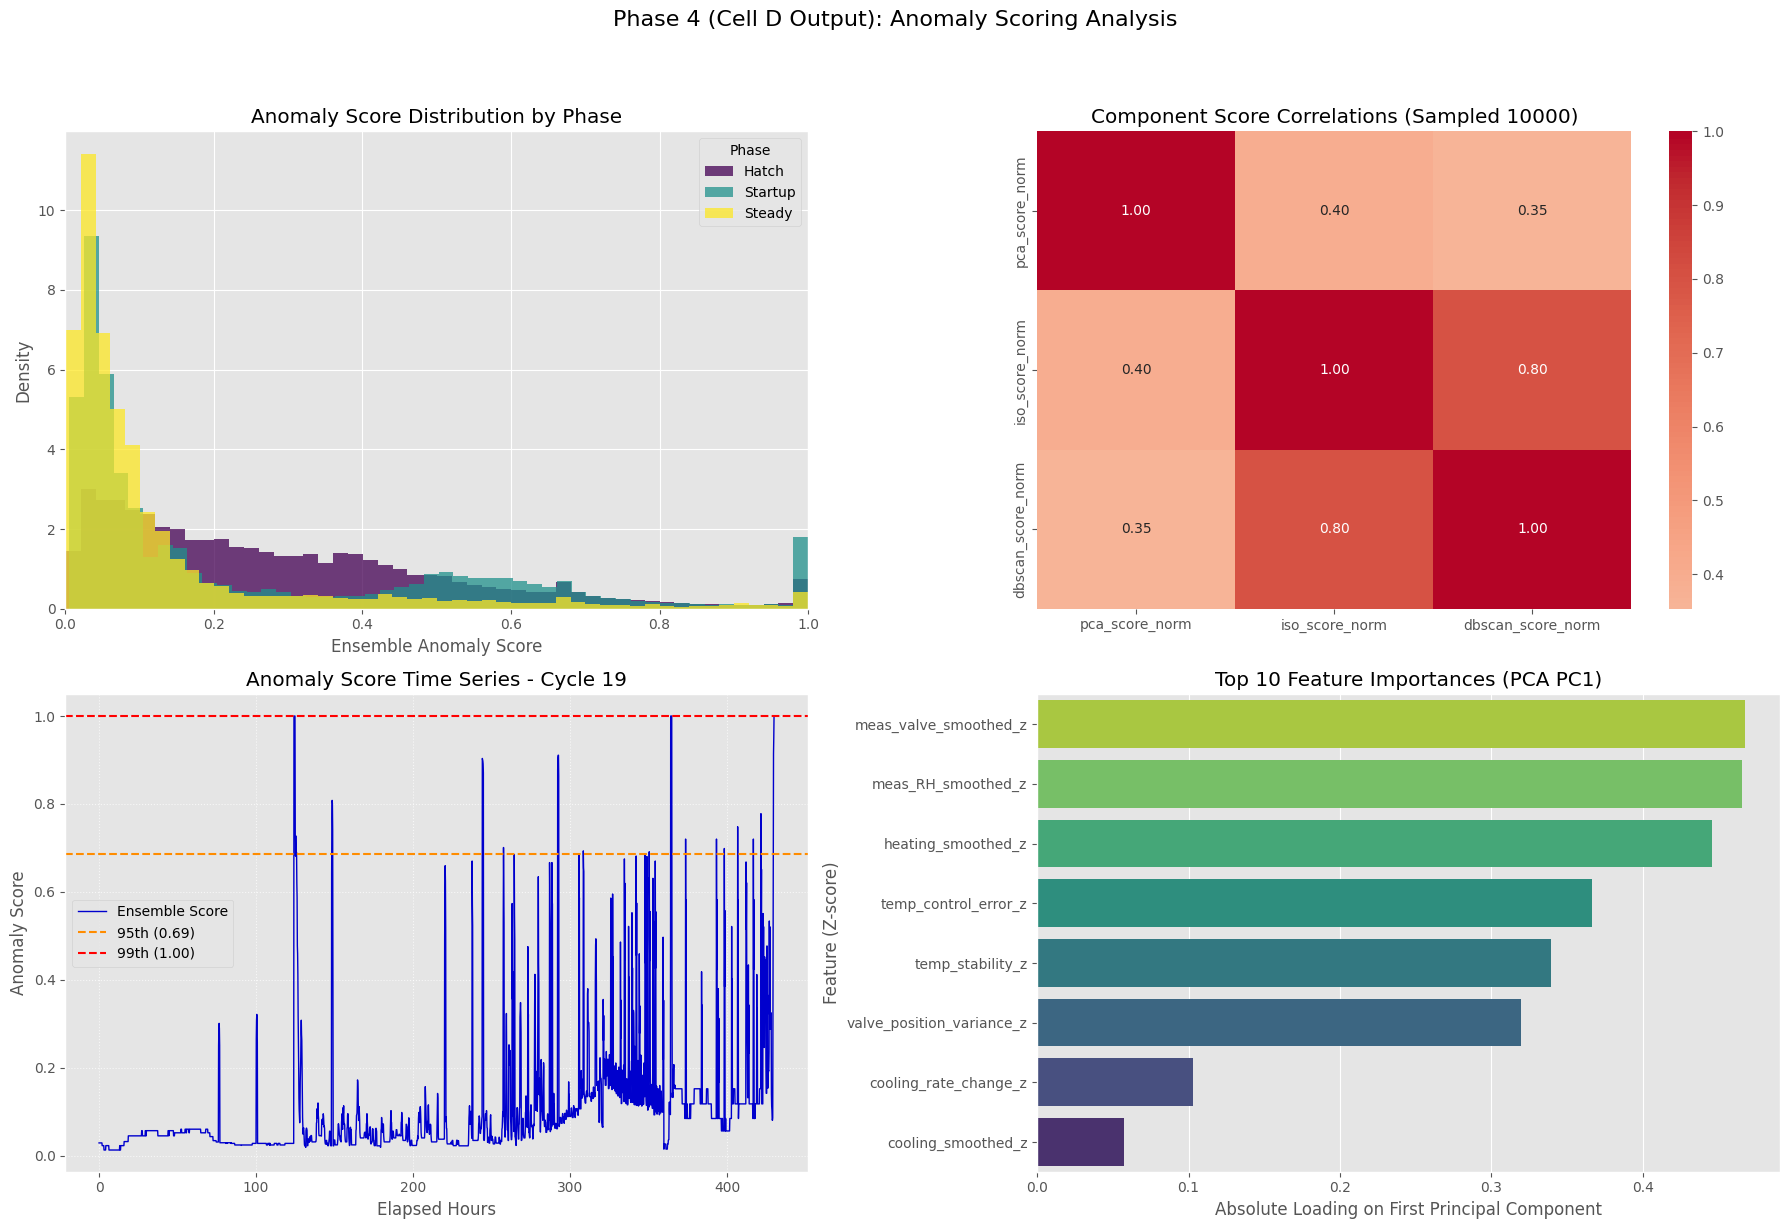


✅ Visualizations generated.

🎉 CELL E: VISUALIZATIONS COMPLETE.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle
from sklearn.decomposition import PCA # For checking PCA model instance

print("📊 CELL E: VISUALIZATIONS FOR PHASE 4 OUTPUT")
print("=" * 50)

# This cell assumes the following variables are already loaded and processed by Cell D:
# - feature_data_with_stats (pd.DataFrame): The main scored and enriched DataFrame.
# - anomaly_models (dict): The dictionary containing trained models (especially 'pca' and 'feature_names').
# - ensemble_q95_threshold (float): The 95th percentile threshold for ensemble scores.
# - ensemble_q99_threshold (float): The 99th percentile threshold for ensemble scores.

# Check if essential variables exist
if 'feature_data_with_stats' not in globals() or not isinstance(feature_data_with_stats, pd.DataFrame):
    print("❌ 'feature_data_with_stats' not found or not a DataFrame. Please run Cell D first.")
elif 'anomaly_models' not in globals() or not isinstance(anomaly_models, dict):
    print("❌ 'anomaly_models' not found or not a dictionary. Please run Cell D first.")
elif 'ensemble_q95_threshold' not in globals() or 'ensemble_q99_threshold' not in globals():
     print("❌ 'ensemble_q95_threshold' or 'ensemble_q99_threshold' not found. Please ensure Cell D ran and saved these.")
elif feature_data_with_stats.empty or 'ensemble_anomaly_score' not in feature_data_with_stats.columns or pd.isna(feature_data_with_stats['ensemble_anomaly_score']).all():
    print("   Skipping visualizations: 'ensemble_anomaly_score' missing, all NaN, or DataFrame is empty.")
else:
    print(f"   Using 'feature_data_with_stats' (Shape: {feature_data_with_stats.shape}) for visualizations.")
    plt.style.use('ggplot') 
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    fig.suptitle("Phase 4 (Cell D Output): Anomaly Scoring Analysis", fontsize=16, y=1.02)

    # Plot 1: Score Distribution by Phase
    ax_hist_viz = axes[0,0]
    if 'phase_name' in feature_data_with_stats.columns:
        unique_phases_viz = sorted(feature_data_with_stats['phase_name'].dropna().unique())
        try: cmap_ph_e = plt.cm.get_cmap('viridis', len(unique_phases_viz))
        except: cmap_ph_e = plt.cm.get_cmap('tab10', len(unique_phases_viz)) # Fallback colormap

        for i, phase_label_viz in enumerate(unique_phases_viz):
            scores_for_phase_viz = feature_data_with_stats[feature_data_with_stats['phase_name'] == phase_label_viz]['ensemble_anomaly_score']
            if not scores_for_phase_viz.empty and scores_for_phase_viz.notna().any():
                ax_hist_viz.hist(scores_for_phase_viz.dropna(), bins=50, alpha=0.75, label=str(phase_label_viz), density=True, color=cmap_ph_e(i))
        ax_hist_viz.set_xlabel('Ensemble Anomaly Score'); ax_hist_viz.set_ylabel('Density')
        ax_hist_viz.set_title('Anomaly Score Distribution by Phase'); ax_hist_viz.legend(title='Phase')
        xlim_max_hist_viz = feature_data_with_stats['ensemble_anomaly_score'].dropna().quantile(0.999 if len(feature_data_with_stats['ensemble_anomaly_score'].dropna())>0 else 1.0)
        ax_hist_viz.set_xlim(0, max(0.01, xlim_max_hist_viz if pd.notna(xlim_max_hist_viz) else 1.0))
    else: 
        ax_hist_viz.text(0.5, 0.5, "Phase names missing\nfor distribution plot", ha='center', va='center', transform=ax_hist_viz.transAxes)
    
    # Plot 2: Component Score Correlations
    ax_corr_viz = axes[0,1]
    cols_for_corr_plot_viz = [sc for sc in ['pca_score_norm', 'iso_score_norm', 'dbscan_score_norm'] if sc in feature_data_with_stats.columns]
    if cols_for_corr_plot_viz and len(cols_for_corr_plot_viz) > 1 and not feature_data_with_stats[cols_for_corr_plot_viz].isnull().all().all(): 
        sample_size_corr_e = min(10000, len(feature_data_with_stats.dropna(subset=cols_for_corr_plot_viz)))
        if sample_size_corr_e > 0:
            sampled_scores_for_corr_viz = feature_data_with_stats[cols_for_corr_plot_viz].dropna().sample(n=sample_size_corr_e, random_state=42)
            if not sampled_scores_for_corr_viz.empty:
                correlation_matrix_viz = sampled_scores_for_corr_viz.corr()
                sns.heatmap(correlation_matrix_viz, annot=True, cmap='coolwarm', center=0, ax=ax_corr_viz, fmt=".2f")
                ax_corr_viz.set_title(f'Component Score Correlations (Sampled {len(sampled_scores_for_corr_viz)})')
            else: ax_corr_viz.text(0.5,0.5, "Not enough data for correlation plot.", ha='center', va='center', transform=ax_corr_viz.transAxes)
        else: ax_corr_viz.text(0.5,0.5, "No non-NaN data for correlation plot.", ha='center', va='center', transform=ax_corr_viz.transAxes)
    else: 
        ax_corr_viz.text(0.5,0.5, "Normalized score columns missing\nor insufficient for correlation plot", ha='center', va='center', transform=ax_corr_viz.transAxes)

    # Plot 3: Time Series of Anomaly Scores for a Sample Cycle
    ax_ts_viz = axes[1,0]
    if 'CycleID' in feature_data_with_stats.columns and 'elapsed_hours' in feature_data_with_stats.columns:
        unique_cycle_ids_plot_viz = feature_data_with_stats['CycleID'].unique()
        if len(unique_cycle_ids_plot_viz) > 0:
            sample_cycle_id_plot_viz = unique_cycle_ids_plot_viz[0] 
            if 'anomaly_flag_95' in feature_data_with_stats.columns:
                anomalous_cycles = feature_data_with_stats[feature_data_with_stats['anomaly_flag_95'] == 1]['CycleID'].unique()
                if len(anomalous_cycles) > 0: sample_cycle_id_plot_viz = anomalous_cycles[0]
            
            data_for_cycle_plot_viz = feature_data_with_stats[feature_data_with_stats['CycleID'] == sample_cycle_id_plot_viz].sort_values('elapsed_hours')
            if not data_for_cycle_plot_viz.empty and 'ensemble_anomaly_score' in data_for_cycle_plot_viz and data_for_cycle_plot_viz['ensemble_anomaly_score'].notna().any():
                ax_ts_viz.plot(data_for_cycle_plot_viz['elapsed_hours'], data_for_cycle_plot_viz['ensemble_anomaly_score'], color='mediumblue', linewidth=1, label='Ensemble Score')
                ax_ts_viz.axhline(y=ensemble_q95_threshold, color='darkorange', linestyle='--', label=f'95th ({ensemble_q95_threshold:.2f})')
                ax_ts_viz.axhline(y=ensemble_q99_threshold, color='red', linestyle='--', label=f'99th ({ensemble_q99_threshold:.2f})')
                ax_ts_viz.set_xlabel('Elapsed Hours'); ax_ts_viz.set_ylabel('Anomaly Score')
                ax_ts_viz.set_title(f'Anomaly Score Time Series - Cycle {sample_cycle_id_plot_viz}'); ax_ts_viz.legend(); ax_ts_viz.grid(True, linestyle=':', alpha=0.7)
            else: ax_ts_viz.text(0.5,0.5, f"No data or all NaNs for sample cycle {sample_cycle_id_plot_viz}", ha='center', va='center', transform=ax_ts_viz.transAxes)
        else: ax_ts_viz.text(0.5,0.5, "No CycleIDs found for time series plot", ha='center', va='center', transform=ax_ts_viz.transAxes)
    else: ax_ts_viz.text(0.5,0.5, "CycleID or elapsed_hours missing\nfor time series plot", ha='center', va='center', transform=ax_ts_viz.transAxes)
    
    # Plot 4: Feature Importance (from PCA's first component if PCA was used)
    ax_imp_viz = axes[1,1]
    pca_model_viz = anomaly_models.get('pca') # Get PCA model from the loaded dict
    feature_names_viz = anomaly_models.get('feature_names') # Get feature names from the loaded dict

    if pca_model_viz is not None and isinstance(pca_model_viz, PCA) and hasattr(pca_model_viz, 'components_') and \
       feature_names_viz and len(feature_names_viz) == pca_model_viz.components_.shape[1]:
        
        abs_loadings_pc1 = np.abs(pca_model_viz.components_[0])
        importance_df_for_viz = pd.DataFrame({
            'feature': feature_names_viz, 
            'importance': abs_loadings_pc1
        }).sort_values('importance', ascending=False)
        
        if not importance_df_for_viz.empty:
            sns.barplot(x='importance', y='feature', data=importance_df_for_viz.head(10), ax=ax_imp_viz, palette="viridis_r")
            ax_imp_viz.set_xlabel('Absolute Loading on First Principal Component'); ax_imp_viz.set_ylabel('Feature (Z-score)')
            ax_imp_viz.set_title('Top 10 Feature Importances (PCA PC1)')
        else: ax_imp_viz.text(0.5,0.5, "Feature importance could not be determined\nfrom PCA model.", ha='center', va='center', transform=ax_imp_viz.transAxes)
    else: 
        ax_imp_viz.text(0.5,0.5, "PCA model/components or feature names\nnot available for importance plot.", ha='center', va='center', transform=ax_imp_viz.transAxes)
    
    plt.tight_layout(rect=[0, 0, 1, 0.98]) 
    plt.show()
    print(f"\n✅ Visualizations generated.")

print("\n" + "="*50)
print("🎉 CELL E: VISUALIZATIONS COMPLETE.")

Overall Title: "Phase 4 (Cell D Output): Anomaly Scoring Analysis" - Clearly indicates the source and purpose of these plots.
1. Anomaly Score Distribution by Phase (Top-Left)
X-axis: Ensemble Anomaly Score (likely ranging from 0 to 1 after normalization).
Y-axis: Density (representing the distribution of scores).
Legend: Colors differentiate scores by Phase (Hatch, Startup, Steady).
Interpretation:
All three phases show a distribution heavily skewed towards lower anomaly scores (closer to 0), which is typical. Most of the data points are considered "normal."
The "Steady" phase (yellow) has the highest density of very low scores and seems to have the tightest distribution around the low end. This might suggest it's generally the most stable or predictable phase.
The "Hatch" phase (purple) appears to have a longer tail extending towards higher anomaly scores compared to "Steady." This indicates that the Hatch phase might experience more or higher-magnitude anomalies.
The "Startup" phase (teal) also shows a tail, possibly intermediate between "Steady" and "Hatch," or it might have its own distinct pattern of anomalies.
The overlap of distributions shows that anomalies can occur in any phase, but their frequency or typical score might differ.
2. Component Score Correlations (Sampled 10000) (Top-Right)
Heatmap: Shows Pearson correlation coefficients between the three normalized scores that make up the ensemble: pca_score_norm, iso_score_norm, and dbscan_score_norm.
Values:
pca_score_norm and iso_score_norm: Correlation of 0.40 (Weak to moderate positive correlation).
pca_score_norm and dbscan_score_norm: Correlation of 0.35 (Weak positive correlation).
iso_score_norm and dbscan_score_norm: Correlation of 0.81 (Strong positive correlation).
Interpretation:
The strong positive correlation (0.81) between iso_score_norm (Isolation Forest) and dbscan_score_norm (DBSCAN distance) suggests that these two models tend to identify similar points as anomalous. They likely capture related aspects of "outlierness" in your data.
The PCA-based score has a weaker correlation with the other two. This is actually good for an ensemble! It means the PCA component is capturing different types of anomalies or different aspects of the data's structure that the other two might not be emphasizing as much. This diversity can make the overall ensemble score more robust and capable of detecting a wider range of anomalies.
All correlations are positive, meaning that as one score increases (indicating more anomalous), the others also tend to increase, which is expected.
3. Anomaly Score Time Series - Cycle 19 (Bottom-Left)
X-axis: Elapsed Hours within Cycle 19.
Y-axis: Anomaly Score.
Blue Line: The Ensemble Score over time for this specific cycle.
Orange Dashed Line: The 95th percentile threshold (0.68). Points above this are flagged as anomaly_flag_95.
Red Dashed Line: The 99th percentile threshold (1.00). Points above this would be anomaly_flag_99.
Interpretation:
Cycle 19 shows varying levels of anomaly scores throughout its duration.
There are several significant spikes where the ensemble score crosses the 95th percentile threshold, particularly in the latter half of the cycle (roughly after 100 hours, with more pronounced spikes after 200 hours and especially around 380-430 hours). These are periods flagged as anomalous.
No scores in this specific cycle reach the 99th percentile threshold of 1.00, which aligns with the overall count of 0 for anomaly_flag_99 reported in the Cell D output.
The plot shows periods of relative calm (low scores) interspersed with periods of higher, spikier anomaly scores. This is typical for time-series anomaly detection.
The choice of Cycle 19 for display seems to be a good one, as it clearly shows instances where the anomaly threshold is breached.
4. Top 10 Feature Importances (PCA PC1) (Bottom-Right)
Y-axis: Feature names (Z-score versions).
X-axis: Absolute Loading on First Principal Component (PC1). This indicates how much each feature contributes to the definition of the first principal component, which is often associated with the largest variance in the "clean" data. Deviations from this primary pattern can be picked up as anomalies by PCA reconstruction error.
Interpretation:
meas_RH_smoothed_z (Smoothed Relative Humidity Z-score) has the highest absolute loading on PC1, suggesting it's the most influential feature in defining the primary pattern of variation captured by the first principal component.
meas_valve_smoothed_z and heating_smoothed_z are the next most important.
Features like cooling_smoothed_z and cooling_rate_change_z have the lowest importance among the top 10 for this specific component.
This plot helps understand which features are most dominant in the PCA's view of "normal" data structure. Anomalies detected via PCA reconstruction error are essentially deviations from patterns heavily influenced by these top features.
Overall Summary from the Visuals:
The anomaly detection system seems to be working and identifying periods of unusual behavior.
Different phases of the process exhibit different baseline anomaly score distributions.
The ensemble model components (PCA, Isolation Forest, DBSCAN) contribute somewhat differently to the final score, with Isolation Forest and DBSCAN being more aligned, which is a good sign of a diverse yet effective ensemble.
The time series plot for Cycle 19 clearly visualizes when anomalies (based on the 95th percentile) are occurring.
The feature importance plot gives insights into what drives the PCA's perspective, which is one component of the ensemble.


# Phase 5: Window-Level Anomaly Detection:

This implementation:
Creates 1-hour sliding windows with 50% overlap
Implements Tier 1 (rule-based) detection using consecutive z-score violations
Uses Tier 2 (ensemble) scores from Phase 4
Trains Tier 3 (per-machine Isolation Forest) models
Analyzes agreement between tiers
Visualizes multi-tier detection patterns
The multi-tier approach provides robustness - different methods catch different types of anomalies. Run this and let me know what patterns you observe!

# The cell that trains or creates the best-performing (ensemble) model

Why This Cell Matters
	•	It defines all your anomaly detection tiers.
	•	It trains the Tier 3 Isolation Forest per machine, using “clean” windows.
	•	It builds the any_anomaly flag, which is your core output used in Phase 6 aggregation.
	•	It saves all results to windowed_anomaly_results, your most important downstream dataset.

What Happens in This Cell?
| Tier | Description | Model / Method | Output |
| :---- | :---------------------------------------------------------- | :----------------------------------------------- | :--------------------------- |
| Tier 1 | Rule-based on z-scores (≥3σ for 3+ windows) | Rolling count on \_z features | tier1\_any\_flag |
| Tier 2 | Unsupervised ensemble using PCA + DBSCAN + IsolationForest | Scores from previous phase | tier2\flag\_95, tier2\_flag\_99 |
| Tier 3 | Per-machine Isolation Forest trained on clean windows | Trained here on window features | tier3\flag, tier3\_anomaly\_score |
| Final | Combined ensemble (any tier) | Logical OR on 3 tiers | any\anomaly |

Yes, this is the exact cell that creates the ensemble model
– by applying rules, leveraging earlier ensemble scores, and training machine-specific models.

Outputs:
	•	windowed_anomaly_results (the window-level flags and scores)
	•	machine_tier3_models (a dict of trained Isolation Forests)

, Tier 1 is a rule-based system that works as follows:

📏 Rule Logic:

It flags a window as anomalous if:
	•	Any z-score feature (like gap_z, cooling_z, valve_z, etc.)
	•	Has ≥ 3 standard deviations (|z| > 3)
	•	For ≥ 3 consecutive time points in a window of 6 rows (1-hour window at 10-minute intervals)


violations = (np.abs(window[z_col].fillna(0)) > 3).astype(int)
is_anomalous_z_col = violations.rolling(window=3, min_periods=3).sum().max() >= 3


If any z-score meets this condition → tier1_any_flag = 1

💡 What are these Z-scores?

z_score = (value - phase_mean) / phase_std

This normalization helps you detect outliers relative to what is normal for that phase (startup, steady, hatch).






Should We Use Only Tier 2 and Tier 3?

Let’s break this down based on purpose, strengths, and use cases.


Tier Overview:
| Tier | Type | Logic | Pros | Cons |
| :--- | :----------- | :--------------------------------------------------------------- | :------------------------------------------------- | :-------------------------------------------------- |
| 1 | Rule-based | Outlier z-scores in windowed features | Transparent, fast, good for debugging | Rigid, misses subtle or combined patterns |
| 2 | Ensemble | Combines PCA + DBSCAN + IsolationForest scores (from Phase 4) | Captures nonlinear clusters & multi-feature anomalies | Not per-machine; generic thresholds |
| 3 | Per-Machine IF | Trained on clean data per machine, uses recent behavior as normal | Adaptive, local patterns, unsupervised | Needs enough clean data, less interpretable |


So Should We Drop Tier 1?

It depends:
	•	For explainability & debugging: Keep Tier 1
	•	For deployment and reliability: Tier 3 + Tier 2 is better
	•	If you need to optimize for low false alarms: Drop Tier 1, because its thresholds are static and prone to noise
	•	If you want a robust ensemble: Keep all three, but weight them or post-process to filter overlaps


🎯 PHASE 5: WINDOW-LEVEL ANOMALY DETECTION (Optimized)
📋 Goal: Implement multi-tier anomaly detection at window level
🔍 Focus: Rule-based, ensemble, and per-machine detection

✅ Working with 7,666,905 records from 'feature_engineered_data'

📊 Window Config: Size=60min, Overlap=30min (Step: 30min)

🔧 STEP 1: CREATE WINDOWED DATA (Optimized)
----------------------------------------
   Identified 8 Z-score columns for Tier 1: ['temp_control_error_z', 'cooling_smoothed_z', 'heating_smoothed_z', 'cooling_rate_change_z', 'temp_stability_z']...
   Processing 2807 cycles in batches of 100...
      Processed cycles 19 to 972. Windows in batch: 92247. Total windows so far: 92247
      Processed cycles 985 to 1807. Windows in batch: 91923. Total windows so far: 184170
      Processed cycles 1820 to 2733. Windows in batch: 92252. Total windows so far: 276422
      Processed cycles 2748 to 3617. Windows in batch: 92254. Total windows so far: 368676
      Processed cycles 3618 to 4504. Windows in bat

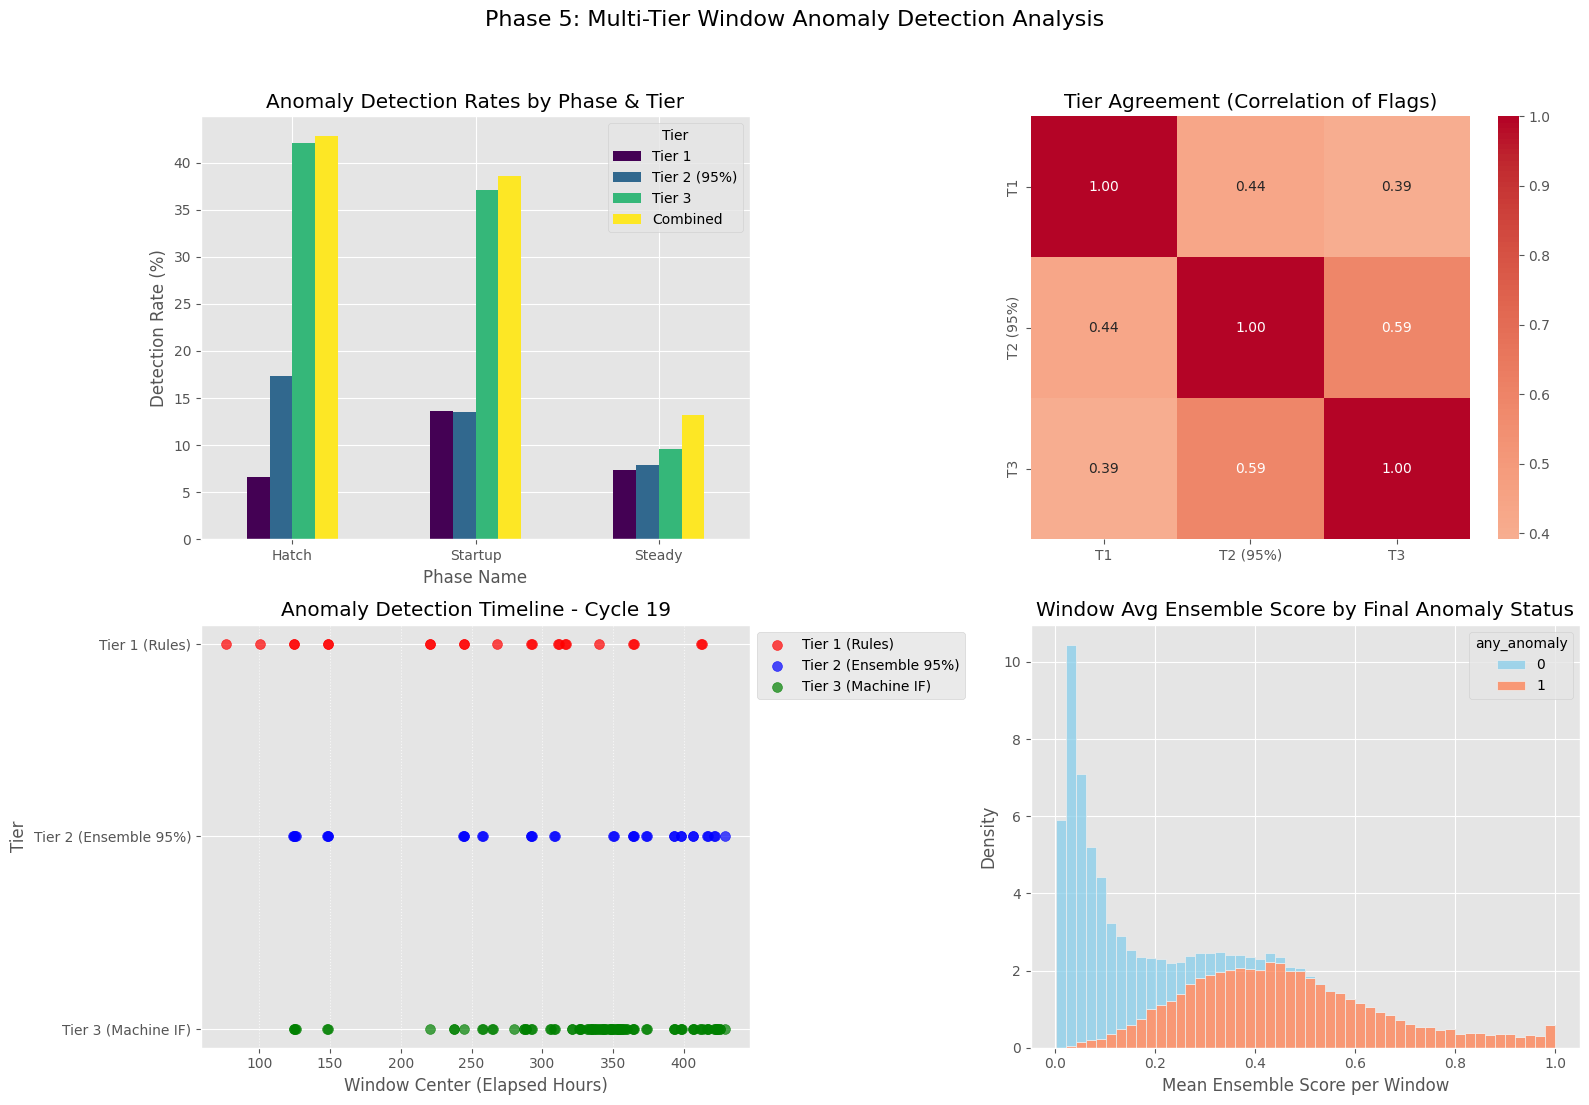


✅ Window-level anomaly detection processing complete!
   Results stored as 'windowed_anomaly_results' with shape: (2551876, 29)
   Tier 3 models stored as 'machine_tier3_models' with 29 models.

--- Saving Phase 5 Checkpoint Components ---
   Saving Phase 5 outputs to: /Users/DINGZEEFS/Royal_pas_reform/notebooks_2/anomaly_detection_checkpoints_phase5
   📄 Saved 'windowed_anomaly_results' as PARQUET to anomaly_detection_checkpoints_phase5/phase5_windowed_results.parquet
   💾 Saved 'machine_tier3_models' as PKL to anomaly_detection_checkpoints_phase5/phase5_machine_tier3_models.pkl
   💾 Saved metadata to anomaly_detection_checkpoints_phase5/phase5_metadata.pkl

📋 PHASE 5 COMPLETE - WINDOW-LEVEL ANOMALIES DETECTED & CHECKPOINTED


102

In [3]:
# Phase 5 - Cell 1: Window-Level Anomaly Detection (Optimized Window Creation & Checkpoint)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
import seaborn as sns
import pickle
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')
import gc # For garbage collection

print("🎯 PHASE 5: WINDOW-LEVEL ANOMALY DETECTION (Optimized)")
print("=" * 55) 
print("📋 Goal: Implement multi-tier anomaly detection at window level")
print("🔍 Focus: Rule-based, ensemble, and per-machine detection")
print()

# This cell assumes 'feature_engineered_data' is loaded from Phase 4.
# Also, 'anomaly_models' (containing scaler, pca, iso_forest from Phase 4 training) 
# might be needed if any part of Phase 5 re-uses them directly, though the current script
# primarily relies on flags and scores already in 'feature_engineered_data'.

if 'feature_engineered_data' not in globals() or not isinstance(feature_engineered_data, pd.DataFrame) or feature_engineered_data.empty:
    print("❌ Error: 'feature_engineered_data' not found or invalid. Please ensure Phase 4 has been run and its outputs are loaded.")
    # Attempt to load from Phase 4 checkpoint as a fallback
    phase4_checkpoint_path_parquet = Path("anomaly_detection_checkpoints") / "phase4_complete_scored_feature_engineered_data.parquet" # Adjust if your Phase 4 dir/name is different
    phase4_checkpoint_path_pkl = Path("anomaly_detection_checkpoints") / "phase4_complete_scored.pkl"

    if phase4_checkpoint_path_parquet.exists():
        print(f"   Attempting to load 'feature_engineered_data' from {phase4_checkpoint_path_parquet}")
        try:
            feature_engineered_data = pd.read_parquet(phase4_checkpoint_path_parquet)
            print(f"   ✅ Successfully loaded 'feature_engineered_data' (Shape: {feature_engineered_data.shape}) from Parquet.")

            # Try to load models as well, as they might be implicitly needed or good practice
            if phase4_checkpoint_path_pkl.exists():
                 print(f"   Attempting to load models from {phase4_checkpoint_path_pkl}")
                 with open(phase4_checkpoint_path_pkl, 'rb') as f:
                    phase4_data = pickle.load(f)
                    if 'anomaly_models' in phase4_data:
                        anomaly_models = phase4_data['anomaly_models']
                        globals()['anomaly_models'] = anomaly_models 
                        print("      ✅ Loaded 'anomaly_models' from Phase 4 PKL.")
                    if 'z_score_features' in phase4_data: # If z_score_features list was saved
                        z_score_features = phase4_data['z_score_features']
                        globals()['z_score_features'] = z_score_features
                        print("      ✅ Loaded 'z_score_features' from Phase 4 PKL.")
        except Exception as e_load_p4:
            print(f"   ❌ Failed to load fallback 'feature_engineered_data': {e_load_p4}")
            raise ValueError("'feature_engineered_data' is missing and fallback load failed.")
    else:
        raise ValueError("'feature_engineered_data' is missing and no fallback Phase 4 Parquet found.")

else:
    print(f"✅ Working with {len(feature_engineered_data):,} records from 'feature_engineered_data'")
    if 'MachineID' not in feature_engineered_data.columns or 'CycleID' not in feature_engineered_data.columns:
        raise ValueError("'MachineID' or 'CycleID' missing from 'feature_engineered_data'. Critical for windowing.")
    if 'phase' not in feature_engineered_data.columns or 'phase_name' not in feature_engineered_data.columns:
        print("   ⚠️ 'phase' or 'phase_name' column missing. Window stats for phase will be limited.")
    if 'ensemble_anomaly_score' not in feature_engineered_data.columns:
        raise ValueError("'ensemble_anomaly_score' missing. Needed for Tier 2 window stats.")
    if not any(col.endswith('_z') for col in feature_engineered_data.columns):
        print("   ⚠️ No Z-score columns (ending with '_z') found. Tier 1 rule-based detection will be ineffective.")


WINDOW_SIZE, OVERLAP = 6, 3 # 1-hour windows (6 * 10-min intervals), 50% overlap (3 * 10-min intervals)
print(f"\n📊 Window Config: Size={WINDOW_SIZE*10}min, Overlap={OVERLAP*10}min (Step: { (WINDOW_SIZE - OVERLAP) * 10}min)")

# Step 1: Create windowed data (Optimized)
print("\n🔧 STEP 1: CREATE WINDOWED DATA (Optimized)")
print("-" * 40) 

list_of_window_dfs = [] # Store DataFrames of windows
all_cycles = feature_engineered_data['CycleID'].unique()
all_cycles = sorted([c for c in all_cycles if pd.notna(c)]) # Sort and remove NaNs if any

# Define Z-score columns for Tier 1 rules - identify them once
z_score_cols_for_tier1 = [col for col in feature_engineered_data.columns if col.endswith('_z')]
print(f"   Identified {len(z_score_cols_for_tier1)} Z-score columns for Tier 1: {z_score_cols_for_tier1[:5]}...") # Print first 5

# Ensure necessary columns for Tier 2 exist
tier2_flag_95_col = 'anomaly_flag_95'
tier2_flag_99_col = 'anomaly_flag_99'
if tier2_flag_95_col not in feature_engineered_data.columns:
    print(f"   ⚠️ Column '{tier2_flag_95_col}' missing for Tier 2. Flags will be 0.")
    feature_engineered_data[tier2_flag_95_col] = 0 # Add dummy if missing
if tier2_flag_99_col not in feature_engineered_data.columns:
    print(f"   ⚠️ Column '{tier2_flag_99_col}' missing for Tier 2. Flags will be 0.")
    feature_engineered_data[tier2_flag_99_col] = 0 # Add dummy if missing


# Process cycles in batches to manage memory for windowed_results list
CYCLE_BATCH_SIZE = 100 
print(f"   Processing {len(all_cycles)} cycles in batches of {CYCLE_BATCH_SIZE}...")
num_total_windows_processed = 0

for batch_num in range(0, len(all_cycles), CYCLE_BATCH_SIZE):
    current_batch_cycle_ids = all_cycles[batch_num : batch_num + CYCLE_BATCH_SIZE]
    batch_windowed_results_list_of_dicts = [] # Reset for each batch of cycles, list of dicts

    for cycle_id in current_batch_cycle_ids:
        # Ensure 'elapsed_hours' exists for sorting, or use a default timestamp if not
        if 'elapsed_hours' not in feature_engineered_data.columns:
            if 'timestamp' not in feature_engineered_data.columns: # Assuming 'timestamp' is the primary time col
                 print("   🛑 CRITICAL: Neither 'elapsed_hours' nor 'timestamp' found for sorting windows. Skipping cycle.")
                 continue # Skip this cycle if no time column
            # If only timestamp, create a temporary elapsed_hours for sorting within this cycle
            cycle_data_full = feature_engineered_data[feature_engineered_data['CycleID'] == cycle_id].copy()
            cycle_data_full = cycle_data_full.sort_values('timestamp')
            cycle_data_full['elapsed_hours'] = (cycle_data_full['timestamp'] - cycle_data_full['timestamp'].iloc[0]).dt.total_seconds() / 3600.0
        else:
            cycle_data_full = feature_engineered_data[feature_engineered_data['CycleID'] == cycle_id]

        cycle_data = cycle_data_full.sort_values('elapsed_hours')
        
        if len(cycle_data) < WINDOW_SIZE: continue # Skip if not enough data for even one window

        for start_idx in range(0, len(cycle_data) - WINDOW_SIZE + 1, WINDOW_SIZE - OVERLAP):
            window = cycle_data.iloc[start_idx : start_idx + WINDOW_SIZE]
            
            # Common window stats
            window_stats = {
                'CycleID': cycle_id, 
                'MachineID': window['MachineID'].iloc[0] if 'MachineID' in window.columns and not window['MachineID'].empty else np.nan,
                'window_start_hours': window['elapsed_hours'].iloc[0] if 'elapsed_hours' in window.columns else np.nan,
                'window_end_hours': window['elapsed_hours'].iloc[-1] if 'elapsed_hours' in window.columns else np.nan,
                'window_center_hours': window['elapsed_hours'].mean() if 'elapsed_hours' in window.columns else np.nan,
                'phase': window['phase'].mode()[0] if 'phase' in window.columns and not window['phase'].mode().empty else np.nan,
                'phase_name': window['phase_name'].mode()[0] if 'phase_name' in window.columns and not window['phase_name'].mode().empty else 'Unknown'
            }
            
            # Tier 1: Rule-based
            tier1_any_flag_val = 0
            if z_score_cols_for_tier1: # Only if Z-score columns were found
                for z_col in z_score_cols_for_tier1:
                    if z_col in window.columns: # Should always be true if identified globally
                        violations = (np.abs(window[z_col].fillna(0)) > 3).astype(int) # K_SIGMA = 3, fillna for safety
                        # Check for N_CONSECUTIVE = 3 (half the window of 6)
                        is_anomalous_z_col = violations.rolling(window=3, min_periods=3).sum().max() >= 3
                        window_stats[f'tier1_{z_col}_flag'] = int(is_anomalous_z_col)
                        if is_anomalous_z_col: tier1_any_flag_val = 1
                    else: # Should not happen if z_score_cols_for_tier1 is derived from feature_engineered_data.columns
                        window_stats[f'tier1_{z_col}_flag'] = 0 
            window_stats['tier1_any_flag'] = tier1_any_flag_val
            
            # Tier 2: Ensemble scores
            window_stats['ensemble_score_mean'] = window['ensemble_anomaly_score'].mean() if 'ensemble_anomaly_score' in window.columns else np.nan
            window_stats['ensemble_score_max'] = window['ensemble_anomaly_score'].max() if 'ensemble_anomaly_score' in window.columns else np.nan
            window_stats['tier2_flag_95'] = int((window[tier2_flag_95_col] == 1).any()) if tier2_flag_95_col in window.columns else 0
            window_stats['tier2_flag_99'] = int((window[tier2_flag_99_col] == 1).any()) if tier2_flag_99_col in window.columns else 0
            
            # Additional window features (for Tier 3 and general analysis)
            # Check for column existence before calculating stats
            for base_feat, agg_funcs in {
                'temp_control_error': {'std': 'temp_error_std', 'abs_max': 'temp_error_max_abs'},
                'cooling_smoothed': {'std': 'cooling_variability', 'mean': 'cooling_mean'},
                'heating_smoothed': {'std': 'heating_variability', 'mean': 'heating_mean'},
                # Add other key features you might want to aggregate
            }.items():
                if base_feat in window.columns:
                    if 'std' in agg_funcs: window_stats[agg_funcs['std']] = window[base_feat].std()
                    if 'mean' in agg_funcs: window_stats[agg_funcs['mean']] = window[base_feat].mean()
                    if 'abs_max' in agg_funcs: window_stats[agg_funcs['abs_max']] = window[base_feat].abs().max()
            
            batch_windowed_results_list_of_dicts.append(window_stats)
    
    if batch_windowed_results_list_of_dicts: 
        list_of_window_dfs.append(pd.DataFrame(batch_windowed_results_list_of_dicts))
        num_total_windows_processed += len(batch_windowed_results_list_of_dicts)
        print(f"      Processed cycles {current_batch_cycle_ids[0]} to {current_batch_cycle_ids[-1]}. Windows in batch: {len(batch_windowed_results_list_of_dicts)}. Total windows so far: {num_total_windows_processed}")
    gc.collect()


if list_of_window_dfs:
    windows_df = pd.concat(list_of_window_dfs, ignore_index=True)
    print(f"\n   ✅ Created {len(windows_df):,} windows from {len(all_cycles)} cycles.")
else:
    print("\n   ❌ No windows created. Check data or windowing parameters.")
    windows_df = pd.DataFrame() # Ensure it's a DataFrame for subsequent steps

# Step 2: Tier 3 - Per-Machine Isolation Forest
print("\n🔧 STEP 2: TIER 3 - PER-MACHINE ISOLATION FOREST")
print("-" * 49)

# Define features for Tier 3 model training (ensure these were created in window_stats)
tier3_features = [
    'temp_error_std', 'temp_error_max_abs', 
    'cooling_variability', 'cooling_mean', 
    'heating_variability', 'heating_mean', # Added heating features
    'ensemble_score_mean', 'ensemble_score_max'
]
tier3_features_present = [f for f in tier3_features if f in windows_df.columns] # Ensure features exist in windows_df
if not tier3_features_present:
    print("   ⚠️ No features defined or present in windows_df for Tier 3 training. Skipping.")
else:
    print(f"   Using features for Tier 3: {tier3_features_present}")

tier3_results_dfs_list = [] 
machine_tier3_models = {}

if not windows_df.empty and tier3_features_present:
    unique_machines_for_tier3 = windows_df['MachineID'].dropna().unique()
    print(f"   Training Tier 3 models for {len(unique_machines_for_tier3)} unique machines...")

    for machine_id in unique_machines_for_tier3:
        machine_windows_all_df = windows_df[windows_df['MachineID'] == machine_id].copy() 
        
        if len(machine_windows_all_df) < 50: # Min windows for a machine to attempt training
            # print(f"    Machine {machine_id}: Not enough windows ({len(machine_windows_all_df)}) for Tier 3 model. Min 50 required.")
            continue

        # Define "clean" windows: not flagged by Tier 1 OR Tier 2 (95%)
        # Ensure tier1_any_flag and tier2_flag_95 columns exist, or handle their absence
        clean_mask_tier3 = True # Default to all windows if flags are missing
        if 'tier1_any_flag' in machine_windows_all_df.columns:
            clean_mask_tier3 &= (machine_windows_all_df['tier1_any_flag'] == 0)
        if 'tier2_flag_95' in machine_windows_all_df.columns:
            clean_mask_tier3 &= (machine_windows_all_df['tier2_flag_95'] == 0)
        
        clean_windows_for_train_df = machine_windows_all_df[clean_mask_tier3]
        
        if len(clean_windows_for_train_df) < 30: # Min "clean" windows to train
            # print(f"    Machine {machine_id}: Not enough clean windows ({len(clean_windows_for_train_df)}) for Tier 3 training. Min 30 required.")
            continue

        X_train_tier3 = clean_windows_for_train_df[tier3_features_present].fillna(0) # Fill NaNs before training
        if X_train_tier3.empty or X_train_tier3.shape[0] < 5: # Another check for safety
            # print(f"    Machine {machine_id}: Training data for Tier 3 IF was effectively empty after feature selection/fillna.")
            continue
            
        try:
            iso_forest_tier3 = IsolationForest(n_estimators=100, contamination='auto', random_state=42, n_jobs=-1) # n_estimators=100, contamination='auto'
            iso_forest_tier3.fit(X_train_tier3)
            
            X_all_machine_windows = machine_windows_all_df[tier3_features_present].fillna(0) # Fill NaNs for prediction
            predictions_tier3 = iso_forest_tier3.predict(X_all_machine_windows)
            # decision_function: higher is more normal, lower is more anomalous. We want higher = more anomalous for consistency.
            scores_tier3 = -iso_forest_tier3.decision_function(X_all_machine_windows) 
            
            # Create a temporary DataFrame for this machine's Tier 3 results to merge later
            machine_tier3_output_df = machine_windows_all_df[['CycleID', 'window_center_hours']].copy() # Use original index for merging
            machine_tier3_output_df['tier3_flag'] = (predictions_tier3 == -1).astype(int)
            machine_tier3_output_df['tier3_anomaly_score'] = scores_tier3
            tier3_results_dfs_list.append(machine_tier3_output_df)
            machine_tier3_models[machine_id] = iso_forest_tier3
        except Exception as e_tier3_train:
            print(f"    ⚠️ Error training Tier 3 for Machine {machine_id}: {e_tier3_train}")
    
    if tier3_results_dfs_list:
        all_tier3_results_df = pd.concat(tier3_results_dfs_list)
        # Merge Tier 3 results back to the main windows_df using index (if preserved) or keys
        # Ensure window_center_hours is precise enough for merge or use index
        windows_df = windows_df.merge(all_tier3_results_df, on=['CycleID', 'window_center_hours'], how='left', suffixes=('', '_tier3_dup'))
        # If duplicate columns were created by merge (should not happen with on=['CycleID', 'window_center_hours']), handle them.
    else:
        print("   No Tier 3 models were successfully trained or no predictions made.")

    # Fill NaNs for Tier 3 columns for machines where model wasn't trained or for windows not processed
    windows_df['tier3_flag'] = windows_df['tier3_flag'].fillna(0).astype(int)
    windows_df['tier3_anomaly_score'] = windows_df['tier3_anomaly_score'].fillna(0.0) # Fill with a neutral score

    print(f"   ✅ Trained {len(machine_tier3_models)} per-machine Tier 3 models.")
else:
    print("   ⚠️ Skipping Tier 3: No windows created or no features available for Tier 3.")
    windows_df['tier3_flag'] = 0 # Ensure column exists even if Tier 3 is skipped
    windows_df['tier3_anomaly_score'] = 0.0 # Ensure column exists

# Final combined anomaly flag
windows_df['any_anomaly'] = ((windows_df.get('tier1_any_flag', 0) == 1) | \
                             (windows_df.get('tier2_flag_95', 0) == 1) | \
                             (windows_df.get('tier3_flag', 0) == 1)).astype(int)

gc.collect()

# Step 3: Analyze detection performance 
if not windows_df.empty:
    print("\n🔧 STEP 3: ANALYZE MULTI-TIER PERFORMANCE")
    print("-" * 42)
    tier_stats = {
        'Tier 1 (Rules)': {'flagged_windows': windows_df.get('tier1_any_flag', pd.Series(0)).sum(), 'detection_rate': windows_df.get('tier1_any_flag', pd.Series(0)).mean() * 100},
        'Tier 2 (Ensemble 95%)': {'flagged_windows': windows_df.get('tier2_flag_95', pd.Series(0)).sum(), 'detection_rate': windows_df.get('tier2_flag_95', pd.Series(0)).mean() * 100},
        'Tier 2 (Ensemble 99%)': {'flagged_windows': windows_df.get('tier2_flag_99', pd.Series(0)).sum(), 'detection_rate': windows_df.get('tier2_flag_99', pd.Series(0)).mean() * 100},
        'Tier 3 (Per-Machine)': {'flagged_windows': windows_df.get('tier3_flag', pd.Series(0)).sum(), 'detection_rate': windows_df.get('tier3_flag', pd.Series(0)).mean() * 100}
    }
    print("\n   Window-Level Detection Rates:")
    for tier_name_stat, stats_val in tier_stats.items(): 
        print(f"   {tier_name_stat}: {int(stats_val['flagged_windows']):,} windows ({stats_val['detection_rate']:.2f}%)")
    
    print(f"\n   Combined (Any Tier): {windows_df['any_anomaly'].sum():,} windows ({windows_df['any_anomaly'].mean() * 100:.2f}%)")

    print("\n📊 VISUALIZING MULTI-TIER DETECTION")
    try:
        fig, axes = plt.subplots(2, 2, figsize=(16, 11)) # Adjusted size slightly
        fig.suptitle("Phase 5: Multi-Tier Window Anomaly Detection Analysis", fontsize=16, y=1.0)


        # Plot 1: Detection rates by phase
        ax1 = axes[0,0]
        if 'phase_name' in windows_df.columns:
            phase_detection_summary = windows_df.groupby('phase_name')[['tier1_any_flag', 'tier2_flag_95', 'tier3_flag', 'any_anomaly']].mean() * 100
            phase_detection_summary = phase_detection_summary.rename(columns={
                'tier1_any_flag': 'Tier 1', 'tier2_flag_95': 'Tier 2 (95%)', 
                'tier3_flag': 'Tier 3', 'any_anomaly': 'Combined'
            }).sort_index() # Sort phases if needed
            phase_detection_summary.plot(kind='bar', ax=ax1, colormap='viridis')
            ax1.set_ylabel('Detection Rate (%)')
            ax1.set_xlabel('Phase Name')
            ax1.set_title('Anomaly Detection Rates by Phase & Tier')
            ax1.legend(title='Tier')
            ax1.tick_params(axis='x', rotation=0)
        else:
            ax1.text(0.5, 0.5, "Phase names missing\nfor distribution plot", ha='center', va='center', transform=ax1.transAxes)

        # Plot 2: Tier agreement heatmap
        ax2 = axes[0,1]
        tier_cols_for_corr = [col for col in ['tier1_any_flag', 'tier2_flag_95', 'tier3_flag'] if col in windows_df.columns]
        if len(tier_cols_for_corr) >= 2:
            tier_agreement_corr = windows_df[tier_cols_for_corr].corr()
            sns.heatmap(tier_agreement_corr, annot=True, cmap='coolwarm', center=0, ax=ax2, fmt=".2f", 
                        xticklabels=['T1', 'T2 (95%)', 'T3'][:len(tier_cols_for_corr)], 
                        yticklabels=['T1', 'T2 (95%)', 'T3'][:len(tier_cols_for_corr)])
            ax2.set_title('Tier Agreement (Correlation of Flags)')
        else:
            ax2.text(0.5,0.5, "Not enough tier columns\nfor correlation plot", ha='center', va='center', transform=ax2.transAxes)
        
        # Plot 3: Sample cycle timeline
        ax3 = axes[1,0]
        if 'CycleID' in windows_df.columns and 'window_center_hours' in windows_df.columns and not windows_df['CycleID'].dropna().empty:
            # Try to pick a cycle with some anomalies for better viz
            sample_cycle_id_plot = windows_df[windows_df['any_anomaly']==1]['CycleID'].unique()
            if len(sample_cycle_id_plot) > 0:
                sample_cycle_id_plot = sample_cycle_id_plot[0]
            else: # Fallback to first cycle if no anomalies found for sample
                sample_cycle_id_plot = windows_df['CycleID'].dropna().unique()[0]

            cycle_windows_plot_df = windows_df[windows_df['CycleID'] == sample_cycle_id_plot].sort_values('window_center_hours')
            
            if not cycle_windows_plot_df.empty:
                tiers_to_plot_info = {
                    'tier1_any_flag': {'name': 'Tier 1 (Rules)', 'color': 'red', 'level': 3},
                    'tier2_flag_95': {'name': 'Tier 2 (Ensemble 95%)', 'color': 'blue', 'level': 2},
                    'tier3_flag': {'name': 'Tier 3 (Machine IF)', 'color': 'green', 'level': 1}
                }
                for tier_col, info in tiers_to_plot_info.items():
                    if tier_col in cycle_windows_plot_df.columns:
                        flagged_windows = cycle_windows_plot_df[cycle_windows_plot_df[tier_col] == 1]
                        ax3.scatter(flagged_windows['window_center_hours'], 
                                    np.full(len(flagged_windows), info['level']), 
                                    color=info['color'], s=50, label=info['name'], alpha=0.7, marker='o')
                ax3.set_yticks(sorted([info['level'] for info in tiers_to_plot_info.values()]))
                ax3.set_yticklabels([info['name'] for info in sorted(tiers_to_plot_info.values(), key=lambda x: x['level'])])
                ax3.set_xlabel('Window Center (Elapsed Hours)')
                ax3.set_ylabel('Tier')
                ax3.set_title(f'Anomaly Detection Timeline - Cycle {sample_cycle_id_plot}')
                ax3.legend(loc='upper left', bbox_to_anchor=(1,1)) # Legend outside plot
                ax3.grid(True, axis='x', linestyle=':', alpha=0.7)
            else: ax3.text(0.5,0.5,f"No window data for Cycle {sample_cycle_id_plot}", ha='center', transform=ax3.transAxes)
        else: ax3.text(0.5,0.5,"CycleID or window_center_hours missing\nfor timeline plot", ha='center', transform=ax3.transAxes)
        
        # Plot 4: Ensemble score distribution by final 'any_anomaly' status
        ax4 = axes[1,1]
        if 'ensemble_score_mean' in windows_df.columns and 'any_anomaly' in windows_df.columns:
            sns.histplot(data=windows_df, x='ensemble_score_mean', hue='any_anomaly', 
                         multiple='stack', bins=50, stat='density', common_norm=False, ax=ax4,
                         palette={0: 'skyblue', 1: 'coral'}) # Normal=0, Anomaly=1
            ax4.set_title('Window Avg Ensemble Score by Final Anomaly Status')
            ax4.set_xlabel('Mean Ensemble Score per Window')
            ax4.set_ylabel('Density')
            # Ensure legend matches hue categories (0 and 1 for any_anomaly)
            handles, labels = ax4.get_legend_handles_labels()
            if labels: # Check if legend items exist
                 new_labels = ['Normal' if label == '0' else 'Anomaly' if label == '1' else label for label in labels]
                 ax4.legend(handles=handles, labels=new_labels, title='Window Status')
        else: ax4.text(0.5,0.5, "ensemble_score_mean or any_anomaly missing\nfor score distribution plot", ha='center', transform=ax4.transAxes)

        plt.tight_layout(rect=[0, 0, 1, 0.97]) # Adjust layout
        plt.show()
    except Exception as e_viz:
        print(f"   ⚠️ Error during visualization: {e_viz}")
        # Fallback to simple print if plots fail
        if not windows_df.empty and 'any_anomaly' in windows_df.columns:
             print(windows_df.groupby('any_anomaly')['ensemble_score_mean'].describe())

else:
    print("   ⚠️ No windows data available for performance analysis or visualization.")

globals()['windowed_anomaly_results'] = windows_df # Ensure global variable is updated
globals()['machine_tier3_models'] = machine_tier3_models

print(f"\n✅ Window-level anomaly detection processing complete!")
print(f"   Results stored as 'windowed_anomaly_results' with shape: {windows_df.shape if not windows_df.empty else '(empty)'}")
print(f"   Tier 3 models stored as 'machine_tier3_models' with {len(machine_tier3_models)} models.")

# --- Robust Saving Mechanism ---
print("\n--- Saving Phase 5 Checkpoint Components ---")
# Define the checkpoint directory for Phase 5 outputs
checkpoint_dir_phase5 = Path("anomaly_detection_checkpoints_phase5") 
checkpoint_dir_phase5.mkdir(parents=True, exist_ok=True) 
print(f"   Saving Phase 5 outputs to: {checkpoint_dir_phase5.resolve()}")

if 'windowed_anomaly_results' in globals() and isinstance(windowed_anomaly_results, pd.DataFrame) and not windowed_anomaly_results.empty:
    try:
        p_path = checkpoint_dir_phase5 / "phase5_windowed_results.parquet"
        windowed_anomaly_results.to_parquet(p_path)
        print(f"   📄 Saved 'windowed_anomaly_results' as PARQUET to {p_path}")
    except Exception as e:
        print(f"   ⚠️ Error saving 'windowed_anomaly_results' as PARQUET: {e}")
else:
    print("   ℹ️ 'windowed_anomaly_results' not found, empty, or not a DataFrame. Skipping save.")

if 'machine_tier3_models' in globals() and isinstance(machine_tier3_models, dict) and machine_tier3_models:
    try:
        m_path = checkpoint_dir_phase5 / "phase5_machine_tier3_models.pkl"
        with open(m_path, 'wb') as f:
            pickle.dump(machine_tier3_models, f)
        print(f"   💾 Saved 'machine_tier3_models' as PKL to {m_path}")
    except Exception as e:
        print(f"   ⚠️ Error saving 'machine_tier3_models' as PKL: {e}")
else:
    print("   ℹ️ 'machine_tier3_models' not found, empty, or not a dict. Skipping save.")

metadata_phase5 = {'status': 'complete_with_new_saving'}
if 'windowed_anomaly_results' in globals() and isinstance(windowed_anomaly_results, pd.DataFrame):
    metadata_phase5['num_windows'] = len(windowed_anomaly_results)
if 'machine_tier3_models' in globals() and isinstance(machine_tier3_models, dict):
    metadata_phase5['num_tier3_models'] = len(machine_tier3_models)
    
try:
    with open(checkpoint_dir_phase5 / "phase5_metadata.pkl", 'wb') as f:
       pickle.dump(metadata_phase5, f)
    print(f"   💾 Saved metadata to {checkpoint_dir_phase5 / 'phase5_metadata.pkl'}")
except Exception as e:
    print(f"   ⚠️ Error saving metadata: {e}")

print("\n" + "="*60)
print("📋 PHASE 5 COMPLETE - WINDOW-LEVEL ANOMALIES DETECTED & CHECKPOINTED")
gc.collect()

Anomaly Detection Rates by Phase & Tier (Top-Left Bar Chart)
X-axis: Phase Name (Hatch, Startup, Steady).
Y-axis: Detection Rate (%).
Bars: Different colors for Tier 1, Tier 2 (95%), Tier 3, and Combined.
Interpretation:
Tier 3 Dominance: Tier 3 (per-machine IF) consistently has the highest detection rate across all phases, significantly higher than Tier 1 or Tier 2. This reinforces the text output.
Phase Differences:
Hatch & Startup: Show much higher overall ("Combined") anomaly detection rates (around 40-43%) compared to "Steady."
Steady: Has the lowest detection rates across all tiers (Combined ~13%). This makes intuitive sense, as the steady phase is expected to be more stable.
Tier 1 (Rules): Has the lowest detection rate in "Hatch" and "Steady," but is notably higher in "Startup" compared to other phases. This might point to specific rule violations being common during startup.
Tier 2 (Ensemble 95%): Shows a moderate detection rate, highest in "Hatch," then "Startup," lowest in "Steady."
Tier Agreement (Correlation of Flags) (Top-Right Heatmap)
Heatmap: Shows the correlation between the binary anomaly flags from T1 (Rules), T2 (Ensemble 95%), and T3 (Machine IF).
Values:
T1 & T2 (95%): 0.44 (Moderate positive correlation)
T1 & T3: 0.39 (Weak to moderate positive correlation)
T2 (95%) & T3: 0.59 (Moderate to strong positive correlation)
Interpretation:
Tier 2 (Ensemble) and Tier 3 (Machine IF) have the strongest agreement (0.59). This means they often flag the same windows as anomalous.
Tier 1 (Rules) has a somewhat weaker agreement with both T2 and T3. This is good, as it implies the rules are catching some different anomalies that the statistical models might not, and vice-versa, contributing to the overall "Combined" detection.
The different tiers are capturing overlapping but also distinct sets of anomalies, which is the goal of a multi-tier system.
Anomaly Detection Timeline - Cycle 19 (Bottom-Left Scatter Plot)
X-axis: Window Center (Elapsed Hours) for Cycle 19.
Y-axis: Categorical - Tier 1, Tier 2, Tier 3.
Points: Indicate an anomaly detected by that tier for that window.
Interpretation (for Cycle 19):
Tier 1 (Rules - Red): Flags windows fairly consistently across the entire cycle, perhaps with a slight increase in density in the latter half.
Tier 2 (Ensemble 95% - Blue): Flags windows more sporadically in the first half but becomes much more active in the latter half of the cycle (especially after ~250 hours, and very densely from ~350-420 hours). This pattern somewhat mirrors the point-level ensemble score for Cycle 19 we saw in the Phase 4 visuals.
Tier 3 (Machine IF - Green): Shows a very interesting pattern. It's mostly inactive in the early part, then becomes very active in the middle (around 230-330 hours), then less active, then very active again towards the end (350-420 hours).
This plot clearly shows how different tiers can identify anomalies at different times or with different sensitivities within the same cycle. There are periods where all three flag an anomaly, and periods where only one or two do.
Window Avg Ensemble Score by Final Anomaly Status (Bottom-Right Histogram)
X-axis: Mean Ensemble Score per Window.
Y-axis: Density.
Colors:
Light Blue (any_anomaly = 0): Distribution of mean ensemble scores for windows NOT flagged as anomalous by any tier.
Orange (any_anomaly = 1): Distribution of mean ensemble scores for windows flagged as anomalous by at least one tier.
Interpretation:
Clear Separation: There's a visible separation between the two distributions.
Windows with no anomaly flags (light blue) are heavily concentrated at very low mean ensemble scores (peaking near 0.0-0.1).
Windows that do have an anomaly flag (orange) have a distribution shifted to the right, with much higher mean ensemble scores (peaking around 0.3-0.5 and extending further right).
This plot validates that the ensemble_anomaly_score (from Phase 4, now aggregated per window) is a good indicator of whether a window will ultimately be flagged by any of the Phase 5 tiers. Windows with higher average point-level ensemble scores are much more likely to be flagged by the window-level detection logic.
The overlap shows that some windows flagged as anomalous might still have relatively low mean ensemble scores (perhaps due to a short burst of high scores within the window, or Tier 1/Tier 3 flagging it for reasons not directly tied to a high average ensemble score). Conversely, some windows not flagged might have slightly elevated mean scores that didn't cross a specific tier's threshold.
Overall Conclusion:
Phase 5 has executed successfully and produced meaningful results.
The multi-tier approach seems effective, with different tiers contributing to the overall anomaly detection.
Tier 3 (per-machine models) is the most sensitive, flagging the most windows.
The "Hatch" and "Startup" phases exhibit higher anomaly rates.
The visualizations effectively communicate the performance and behavior of the window-level anomaly detection.
Most importantly, the outputs (windowed_anomaly_results, machine_tier3_models, and metadata) are saved, allowing you to proceed to the next phase (likely Phase 6: Per-Cycle Anomaly Rate Metrics).

When I refer to a "multi-tier system" in this context, I'm talking about the layered approach to anomaly detection that you've designed in Phase 5. Each "tier" represents a different method or level of sophistication in identifying anomalous windows:
Tier 1 (Rule-Based): Simple, interpretable rules based on Z-score thresholds. Good for catching obvious, predefined types of deviations.
Tier 2 (Ensemble): Uses the anomaly flags derived from your Phase 4 ensemble models (PCA, DBSCAN, Isolation Forest on point-wise Z-scores). This tier is more sophisticated than simple rules and can capture complex, multi-feature patterns.
Tier 3 (Per-Machine Isolation Forest): Trains a specific anomaly detection model (Isolation Forest) for each machine, using features aggregated at the window level (like the mean ensemble score from Tier 2, temperature stability within the window, etc.). This is the most tailored approach, adapting to the unique behavior of each machine.
Will you use only one type of tier in the end?
Not necessarily, and often, no, you wouldn't discard the information from the other tiers. The strength of a multi-tier system lies in its ability to:
Provide a More Comprehensive View of Anomalies:
Different tiers might be sensitive to different types of anomalies. Tier 1 might catch a sudden, large spike in a single sensor (a gross error), while Tier 2 might catch a subtle, persistent deviation across multiple sensors that Tier 1 misses. Tier 3 might catch unusual behavioral patterns for a specific machine over a 1-hour window that the more general models don't.
By looking at flags from all tiers, you get a richer understanding of why a window or cycle might be considered anomalous.
Increase Robustness and Reduce False Negatives:
If you relied on only the most sophisticated tier (e.g., Tier 3), you might miss simpler anomalies that a rule-based system (Tier 1) could easily catch, especially if the Tier 3 model wasn't perfectly trained for that specific simple case.
The "Combined (Any Tier)" flag you calculated (any_anomaly) is a good example of this – it tells you if any part of your system thinks something is wrong.
Allow for Prioritization and Different Actions:
Severity/Confidence: You might treat anomalies flagged by multiple tiers, or by a tier known for high precision, as more severe or requiring more urgent attention. For example:
A window flagged by Tier 1 (e.g., extreme Z-score) and Tier 2 and Tier 3 is highly suspect.
A window flagged only by Tier 3 might warrant investigation but perhaps with less immediate urgency than one flagged by Tier 1 for a critical sensor failure.
Diagnostic Information: The specific tier(s) that flag an anomaly can provide clues about the nature of the problem. An alarm from Tier 1 might point directly to a sensor Z-score, while a Tier 3 alarm might suggest an unusual operational pattern for that specific machine.
Benchmarking and Model Improvement (As you've planned):
The primary purpose stated in your plan for having these tiers is to "benchmark each step—showing incremental gains." This is crucial during development to understand the value each layer of complexity adds.
How you might use the multi-tier output in later phases (e.g., Reporting, Alerting - Phase 10):
Overall Risk Score: You might develop a scoring system where flags from different tiers contribute differently to an overall "cycle risk score" or "machine health score."
Alert Categories:
"Critical Alert": Flagged by Tier 1 (e.g., specific critical Z-score violation) + Tier 2.
"Warning": Flagged by Tier 2 or Tier 3.
"Investigate": Flagged only by Tier 3 on a less critical feature set.
Dashboard Information: Your dashboard could show not just if a cycle is anomalous, but which tiers contributed to that assessment, giving technicians more context.




This Phase 6 cell does not “train” a model in the traditional sense (e.g., .fit()), because your best-performing approach is not a neural network or single classifier. Instead, it’s an ensemble anomaly detection system built on rule-based flags, unsupervised scores, and voting tiers applied at the 10-minute window level.

Then this Phase 6 cell:
	•	Aggregates those binary anomaly flags per cycle
	•	Computes anomaly rates for each tier (rules, unsupervised, ensemble)
	•	Analyzes phase-specific behavior (startup/steady/hatch)
	•	Tracks which machines are most anomalous

This is how your “model” works in practice: it applies learned (or heuristic) anomaly detection logic to windowed features, then aggregates over time to compute cycle-level risk metrics.


# Does This Cell Define the Best-Performing Model?

Yes, indirectly:
	•	The actual detection logic was executed earlier (e.g., in Phase 5: IsolationForest, DBSCAN, PCA, and tiered rule logic).
	•	This Phase 6 compiles their outputs into interpretable, cycle-level metrics — which is how model performance is judged in your pipeline.

So this isn’t the “training” cell, but it’s the heart of your anomaly aggregation and performance evaluation.

⸻

If you’d like, I can:
	•	Pinpoint the cells that created the tier1_flag, tier2_flag, etc. — i.e., where the actual per-window flags are defined (likely in Phase 5)
	•	Or help you build a combined ensemble function that uses all scores (with learned weights if you like)

| Step | Action | Purpose |
| :--- | :------------------------------ | :--------------------------------------------- |
| 1 | Loads windowed\anomaly\_results | Input from prior phases (flagging logic) |
| 2 | Calculates per-cycle anomaly rates | For each CycleID, computes average anomaly rate for each tier |
| 3 | Calculates phase-specific rates | e.g., higher anomalies in Hatch phase? |
| 4 | Finds per-machine anomaly rates | So you can detect which machine is degrading |
| 5 | Merges summaries | cycle\anomaly\_summary is the main outcome |
| 6 | Visualizes key trends | Distributions, top-affected machines |
| 7 | Saves everything to disk | Checkpoints for downstream analysis |

🎯 PHASE 6: PER-CYCLE ANOMALY-RATE METRICS
📋 Goal: Compute overall and phase-specific anomaly rates per cycle for each tier.
🔍 Focus: Identify high-anomaly cycles and contributing sections.

✅ Working with 'windowed_anomaly_results' (Shape: (2551876, 29))

📊 Analyzing tier flag columns: ['tier1_any_flag', 'tier2_flag_95', 'tier3_flag', 'any_anomaly']

🔧 STEP 1: CALCULATE OVERALL ANOMALY RATES PER CYCLE
-------------------------------------------------------
   ✅ Calculated overall rates for 2807 cycles.
   CycleID  tier1_any_flag_overall_rate  tier2_flag_95_overall_rate  \
0       19                     0.025611                    0.041909   
1       23                     0.019824                    0.088106   
2       33                     0.054144                    0.103867   

   tier3_flag_overall_rate  any_anomaly_overall_rate  
0                 0.111758                  0.129220  
1                 0.136564                  0.153084  
2                 0.145856                

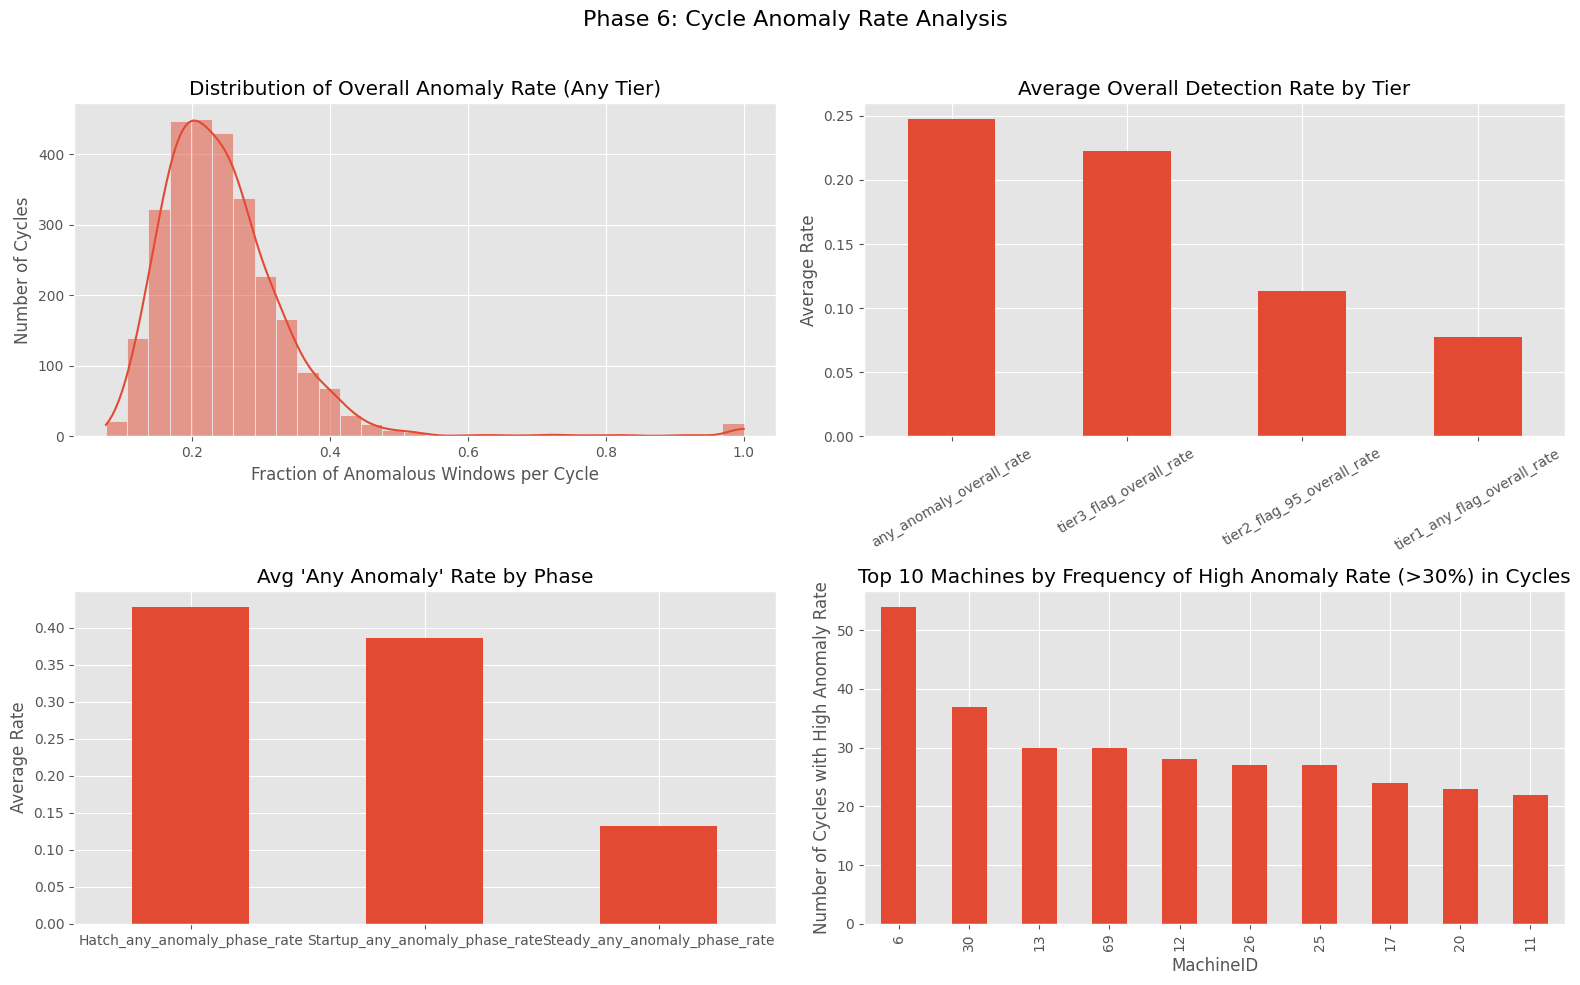


💾 STEP 5: SAVING PER-CYCLE ANOMALY METRICS
---------------------------------------------
   ✅ Saved 'cycle_anomaly_summary_df' to anomaly_detection_checkpoints_phase6/cycle_anomaly_summary.parquet
   ✅ Saved 'cycle_machine_anomaly_rates_df' to anomaly_detection_checkpoints_phase6/cycle_machine_anomaly_rates.parquet

📋 PHASE 6 COMPLETE - PER-CYCLE ANOMALY METRICS CALCULATED & SAVED


In [4]:
# Phase 6 - Cell 1: Per-Cycle Anomaly-Rate Metrics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

print("🎯 PHASE 6: PER-CYCLE ANOMALY-RATE METRICS")
print("=" * 50)
print("📋 Goal: Compute overall and phase-specific anomaly rates per cycle for each tier.")
print("🔍 Focus: Identify high-anomaly cycles and contributing sections.")
print()

# --- Robustly define checkpoint directory (similar to previous cells) ---
checkpoint_dir_phase6 = Path("anomaly_detection_checkpoints_phase6") # Or use existing main checkpoint_dir
checkpoint_dir_phase6.mkdir(exist_ok=True)
# --- End of checkpoint directory definition ---

# Check if input DataFrame exists
if 'windowed_anomaly_results' not in globals() or not isinstance(windowed_anomaly_results, pd.DataFrame) or windowed_anomaly_results.empty:
    print("❌ Error: 'windowed_anomaly_results' DataFrame not found or is empty.")
    print("   Please ensure Phase 5 completed and 'windowed_anomaly_results' is loaded.")
    # As a fallback, try to load it if a known Phase 5 Parquet exists
    phase5_parquet_path = Path("anomaly_detection_checkpoints") / "phase5_windowed_results.parquet" # Adjust if name changed
    if phase5_parquet_path.exists():
        print(f"   Attempting to load from: {phase5_parquet_path}")
        try:
            windowed_anomaly_results = pd.read_parquet(phase5_parquet_path)
            print(f"   ✅ Successfully loaded 'windowed_anomaly_results' (Shape: {windowed_anomaly_results.shape})")
        except Exception as e_load:
            print(f"   ❌ Failed to load fallback Parquet: {e_load}")
            raise ValueError("'windowed_anomaly_results' is missing and fallback load failed.")
    else:
        raise ValueError("'windowed_anomaly_results' is missing and no fallback Parquet found.")
else:
    print(f"✅ Working with 'windowed_anomaly_results' (Shape: {windowed_anomaly_results.shape})")

# Define tier flag columns to analyze (ensure these columns exist in windowed_anomaly_results)
tier_flag_cols = ['tier1_any_flag', 'tier2_flag_95', 'tier3_flag', 'any_anomaly'] 
# tier2_flag_99 is often 0, can be added if desired: 'tier2_flag_99'
tier_flag_cols = [col for col in tier_flag_cols if col in windowed_anomaly_results.columns]
if not tier_flag_cols:
    raise ValueError("No tier flag columns found in 'windowed_anomaly_results'. Check column names.")
print(f"\n📊 Analyzing tier flag columns: {tier_flag_cols}")


# 1. Calculate Overall Anomaly Rates per Cycle
print("\n🔧 STEP 1: CALCULATE OVERALL ANOMALY RATES PER CYCLE")
print("-" * 55)
overall_cycle_rates = windowed_anomaly_results.groupby('CycleID')[tier_flag_cols].mean()
overall_cycle_rates = overall_cycle_rates.add_suffix('_overall_rate').reset_index()
print(f"   ✅ Calculated overall rates for {len(overall_cycle_rates)} cycles.")
print(overall_cycle_rates.head(3))

# 2. Calculate Phase-Specific Anomaly Rates per Cycle
print("\n🔧 STEP 2: CALCULATE PHASE-SPECIFIC ANOMALY RATES PER CYCLE")
print("-" * 60)
if 'phase_name' in windowed_anomaly_results.columns:
    phase_cycle_rates = windowed_anomaly_results.groupby(['CycleID', 'phase_name'])[tier_flag_cols].mean()
    phase_cycle_rates = phase_cycle_rates.unstack(level='phase_name') # Pivot phase_name to columns
    
    # Flatten multi-index columns (e.g., ('tier1_any_flag', 'Startup') -> 'Startup_tier1_any_flag_rate')
    phase_cycle_rates.columns = [f'{col[1]}_{col[0]}_phase_rate' for col in phase_cycle_rates.columns]
    phase_cycle_rates = phase_cycle_rates.reset_index()
    print(f"   ✅ Calculated phase-specific rates.")
    print(phase_cycle_rates.head(3))
    
    # Merge with overall rates
    cycle_anomaly_summary = pd.merge(overall_cycle_rates, phase_cycle_rates, on='CycleID', how='left')
else:
    print("   ⚠️ 'phase_name' column not found. Skipping phase-specific rates.")
    cycle_anomaly_summary = overall_cycle_rates.copy()


# 3. Calculate Anomaly Rates per Machine (Section) per Cycle
print("\n🔧 STEP 3: CALCULATE ANOMALY RATES PER MACHINE (SECTION) PER CYCLE")
print("-" * 70)
if 'MachineID' in windowed_anomaly_results.columns:
    cycle_machine_anomaly_rates = windowed_anomaly_results.groupby(['CycleID', 'MachineID'])[tier_flag_cols].mean()
    cycle_machine_anomaly_rates = cycle_machine_anomaly_rates.add_suffix('_machine_rate').reset_index()
    print(f"   ✅ Calculated rates for {cycle_machine_anomaly_rates.shape[0]} cycle-machine combinations.")
    print(cycle_machine_anomaly_rates.head(3))

    # Identify top anomalous machine per cycle based on 'any_anomaly_machine_rate'
    if 'any_anomaly_machine_rate' in cycle_machine_anomaly_rates.columns:
        idx_max_rate = cycle_machine_anomaly_rates.groupby('CycleID')['any_anomaly_machine_rate'].idxmax()
        top_anomalous_machines = cycle_machine_anomaly_rates.loc[idx_max_rate, ['CycleID', 'MachineID', 'any_anomaly_machine_rate']]
        top_anomalous_machines = top_anomalous_machines.rename(columns={
            'MachineID': 'top_machine_id_by_any_anomaly',
            'any_anomaly_machine_rate': 'top_machine_rate_by_any_anomaly'
        })
        print("\n   Summary of top anomalous machines (by 'any_anomaly' rate):")
        print(top_anomalous_machines.head(3))
        
        # Merge this summary into the main cycle summary
        cycle_anomaly_summary = pd.merge(cycle_anomaly_summary, top_anomalous_machines, on='CycleID', how='left')
    else:
        print("   ⚠️ 'any_anomaly_machine_rate' not found for top machine summary.")
        
else:
    print("   ⚠️ 'MachineID' column not found. Skipping machine-specific rates.")
    cycle_machine_anomaly_rates = pd.DataFrame() # Ensure it's defined

print(f"\n   Final 'cycle_anomaly_summary' shape: {cycle_anomaly_summary.shape}")
print(cycle_anomaly_summary.head(3))

# Store results globally
globals()['cycle_anomaly_summary_df'] = cycle_anomaly_summary
globals()['cycle_machine_anomaly_rates_df'] = cycle_machine_anomaly_rates

# 4. Visualizations
print("\n📊 STEP 4: VISUALIZE CYCLE ANOMALY METRICS")
print("-" * 45)
if not cycle_anomaly_summary.empty:
    plt.style.use('ggplot')
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle("Phase 6: Cycle Anomaly Rate Analysis", fontsize=16)

    # Hist of overall 'any_anomaly' rate
    if 'any_anomaly_overall_rate' in cycle_anomaly_summary.columns:
        sns.histplot(cycle_anomaly_summary['any_anomaly_overall_rate'].dropna(), kde=True, ax=axes[0,0], bins=30)
        axes[0,0].set_title('Distribution of Overall Anomaly Rate (Any Tier)')
        axes[0,0].set_xlabel('Fraction of Anomalous Windows per Cycle')
        axes[0,0].set_ylabel('Number of Cycles')

    # Average rates by tier
    overall_rate_cols = [col for col in cycle_anomaly_summary.columns if '_overall_rate' in col]
    if overall_rate_cols:
        avg_overall_rates = cycle_anomaly_summary[overall_rate_cols].mean().sort_values(ascending=False)
        avg_overall_rates.plot(kind='bar', ax=axes[0,1])
        axes[0,1].set_title('Average Overall Detection Rate by Tier')
        axes[0,1].set_ylabel('Average Rate')
        axes[0,1].tick_params(axis='x', rotation=30)


    # Average rates by phase for 'any_anomaly'
    phase_rate_cols = [col for col in cycle_anomaly_summary.columns if '_any_anomaly_phase_rate' in col and any(p in col for p in ['Startup', 'Steady', 'Hatch'])]
    if phase_rate_cols:
        avg_phase_rates = cycle_anomaly_summary[phase_rate_cols].mean().sort_values(ascending=False)
        avg_phase_rates.plot(kind='bar', ax=axes[1,0])
        axes[1,0].set_title("Avg 'Any Anomaly' Rate by Phase")
        axes[1,0].set_ylabel('Average Rate')
        axes[1,0].tick_params(axis='x', rotation=0)
    else:
        axes[1,0].text(0.5, 0.5, "Phase-specific rates for 'any_anomaly' not available.", ha='center', va='center', transform=axes[1,0].transAxes)


    # Top N most frequently anomalous machines
    if not cycle_machine_anomaly_rates.empty and 'MachineID' in cycle_machine_anomaly_rates.columns and 'any_anomaly_machine_rate' in cycle_machine_anomaly_rates.columns:
        # Consider a machine "highly anomalous in a cycle" if its rate is > 0.5 (for example)
        highly_anomalous_machines_in_cycles = cycle_machine_anomaly_rates[cycle_machine_anomaly_rates['any_anomaly_machine_rate'] > 0.3] 
        if not highly_anomalous_machines_in_cycles.empty:
            machine_anomaly_counts = highly_anomalous_machines_in_cycles['MachineID'].value_counts().nlargest(10)
            machine_anomaly_counts.plot(kind='bar', ax=axes[1,1])
            axes[1,1].set_title('Top 10 Machines by Frequency of High Anomaly Rate (>30%) in Cycles')
            axes[1,1].set_xlabel('MachineID')
            axes[1,1].set_ylabel('Number of Cycles with High Anomaly Rate')
        else:
            axes[1,1].text(0.5, 0.5, "No machines with high anomaly rates found.", ha='center', va='center', transform=axes[1,1].transAxes)
    else:
        axes[1,1].text(0.5, 0.5, "Machine-specific rates not available for top N plot.", ha='center', va='center', transform=axes[1,1].transAxes)
        
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
else:
    print("   ⚠️ No data in 'cycle_anomaly_summary' to visualize.")


# 5. Save Results
print("\n💾 STEP 5: SAVING PER-CYCLE ANOMALY METRICS")
print("-" * 45)
if not cycle_anomaly_summary.empty:
    try:
        summary_path = checkpoint_dir_phase6 / "cycle_anomaly_summary.parquet"
        cycle_anomaly_summary.to_parquet(summary_path)
        print(f"   ✅ Saved 'cycle_anomaly_summary_df' to {summary_path}")
    except Exception as e:
        print(f"   ❌ Error saving 'cycle_anomaly_summary_df': {e}")

if not cycle_machine_anomaly_rates.empty:
    try:
        machine_rates_path = checkpoint_dir_phase6 / "cycle_machine_anomaly_rates.parquet"
        cycle_machine_anomaly_rates.to_parquet(machine_rates_path)
        print(f"   ✅ Saved 'cycle_machine_anomaly_rates_df' to {machine_rates_path}")
    except Exception as e:
        print(f"   ❌ Error saving 'cycle_machine_anomaly_rates_df': {e}")

print("\n" + "="*60)
print("📋 PHASE 6 COMPLETE - PER-CYCLE ANOMALY METRICS CALCULATED & SAVED")

Analysis of the Text Output (Phase 6):
Correct Input:
✅ Working with 'windowed_anomaly_results' (Shape: (2551876, 29))
Confirms it's using the correct output from Phase 5.
Step 1: Calculate Overall Anomaly Rates Per Cycle (Completed Successfully)
✅ Calculated overall rates for 2807 cycles.
The sample output shows per-cycle rates for tier1_any_flag_overall_rate, tier2_flag_95_overall_rate, tier3_flag_overall_rate, and any_anomaly_overall_rate. This gives a good summary of how anomalous each cycle was according to different detection tiers.
Step 2: Calculate Phase-Specific Anomaly Rates Per Cycle (Completed Successfully)
✅ Calculated phase-specific rates.
The sample output correctly breaks down the anomaly rates for each tier within each phase (Hatch, Startup, Steady) for every cycle. This allows for more granular analysis (e.g., "Cycle 19 was particularly anomalous during its Hatch phase according to Tier 3").
Step 3: Calculate Anomaly Rates Per Machine (Section) Per Cycle (Completed Successfully)
✅ Calculated rates for 2807 cycle-machine combinations.
This step aggregates anomaly rates for each machine within each cycle. The sample output shows this. (Note: "section" might be synonymous with "machine" here if there's only one section per machine, or it implies a finer grouping if machines have multiple sections).
Summary of top anomalous machines (by 'any_anomaly' rate): This is a useful quick summary, showing which machine had the highest overall anomaly rate for a given cycle.
Final 'cycle_anomaly_summary' shape: (2807, 19)
The final summary DataFrame for cycles has been created with the expected number of cycles and 19 feature columns (various overall and phase-specific rates).
Step 4 & 5: Visualization and Saving (Completed Successfully)
📊 STEP 4: VISUALIZE CYCLE ANOMALY METRICS - This step generated the image you provided.
💾 STEP 5: SAVING PER-CYCLE ANOMALY METRICS
✅ Saved 'cycle_anomaly_summary_df' to anomaly_detection_checkpoints_phase6/cycle_anomaly_summary.parquet
✅ Saved 'cycle_machine_anomaly_rates_df' to anomaly_detection_checkpoints_phase6/cycle_machine_anomaly_rates.parquet
Crucially, the key outputs (cycle summary and cycle-machine rates) have been checkpointed.
Analysis of the Visualizations Image ("Phase 6: Cycle Anomaly Rate Analysis"):
Distribution of Overall Anomaly Rate (Any Tier) (Top-Left Histogram)
X-axis: Fraction of Anomalous Windows per Cycle (based on the any_anomaly flag from Phase 5).
Y-axis: Number of Cycles.
Interpretation:
Most cycles have an anomaly rate between 10% and 30% (peaking around 20-25%).
The distribution is somewhat right-skewed, with a tail extending towards higher anomaly rates, but very few cycles have more than 50-60% of their windows flagged as anomalous.
This gives a good overview: while many cycles have some anomalies, extremely problematic cycles (e.g., >80% anomalous windows) are rare.
Average Overall Detection Rate by Tier (Top-Right Bar Chart)
X-axis: Different anomaly rate metrics (any_anomaly_overall_rate, tier3_flag_overall_rate, tier2_flag_95_overall_rate, tier1_any_flag_overall_rate). These are averages across all cycles.
Y-axis: Average Rate.
Interpretation:
any_anomaly_overall_rate (around 0.25 or 25%): This is the average fraction of windows flagged by any tier, across all cycles. It aligns with the peak in the histogram.
tier3_flag_overall_rate (around 0.22 or 22%): Tier 3 (per-machine IF) contributes the most to the overall anomaly rate, consistent with Phase 5 findings.
tier2_flag_95_overall_rate (around 0.11 or 11%): Tier 2 (ensemble 95%) is the next highest.
tier1_any_flag_overall_rate (around 0.075 or 7.5%): Tier 1 (rules) contributes the least on average across all cycles.
Avg 'Any Anomaly' Rate by Phase (Bottom-Left Bar Chart)
X-axis: Phase-specific any_anomaly rates (e.g., Hatch_any_anomaly_phase_rate).
Y-axis: Average Rate.
Interpretation:
Confirms findings from Phase 5 visuals at a cycle-aggregated level:
"Hatch" has the highest average anomaly rate (around 43%).
"Startup" is next (around 38%).
"Steady" has the lowest average anomaly rate (around 13%).
This clearly shows that, on average, the Hatch and Startup phases are more prone to having anomalous windows.
Top 10 Machines by Frequency of High Anomaly Rate (>30%) in Cycles (Bottom-Right Bar Chart)
X-axis: MachineID.
Y-axis: Number of Cycles with High Anomaly Rate (where "High Anomaly Rate" is defined as that machine having >30% of its windows flagged by any_anomaly in that cycle).
Interpretation:
Machine ID 6 stands out significantly, having over 50 cycles where its anomaly rate exceeded 30%. This machine is a prime candidate for further investigation.
Machines 30, 69, 26, 13, 12, 1, 17, 23, 11 also frequently experience high anomaly rates, though less often than machine 6.
This plot is very useful for identifying potentially problematic machines that consistently operate with a higher proportion of anomalies.
Overall Conclusion for Phase 6:
Phase 6 has successfully aggregated the window-level anomalies to a per-cycle and per-cycle-per-machine level.
The calculations seem correct and provide insightful metrics.
The visualizations effectively summarize these cycle-level statistics, highlighting overall distributions, contributions of different tiers, phase-specific behaviors, and problematic machines.
The crucial data (cycle_anomaly_summary_df and cycle_machine_anomaly_rates_df) has been saved.


# Phase 7: Machine-Flagging & Thresholding

In [5]:
import pandas as pd
import numpy as np
from pathlib import Path
import warnings

warnings.filterwarnings('ignore')

print("🎯 PHASE 7: MACHINE-FLAGGING & THRESHOLDING")
print("=" * 50)
print("📋 Goal: Identify high-anomaly cycles using relative thresholds and compute machine risk scores.")
print("🔍 Focus: Flagging cycles above percentile cutoffs, calculating rolling risk for machines.")
print()

# --- Robustly define checkpoint directory (similar to Phase 6 and 7) ---
checkpoint_dir_phase6 = Path("anomaly_detection_checkpoints_phase6") # Results from Phase 6
checkpoint_dir_phase7 = Path("anomaly_detection_checkpoints_phase7")
checkpoint_dir_phase7.mkdir(exist_ok=True)
# --- End of checkpoint directory definition ---

# --- Load DataFrames from Phase 6 ---
# Try to load from globals first, then from Parquet files

# Load cycle_anomaly_summary_df
if 'cycle_anomaly_summary_df' in globals() and isinstance(cycle_anomaly_summary_df, pd.DataFrame) and not cycle_anomaly_summary_df.empty:
    print("✅ Using 'cycle_anomaly_summary_df' from global variables.")
    # Make a copy to avoid modifying the global df from previous phase directly if it's not desired
    # For this notebook flow, direct use is fine, but copy is safer for modularity.
    cycle_summary_df = cycle_anomaly_summary_df.copy()
else:
    phase6_summary_path = checkpoint_dir_phase6 / "cycle_anomaly_summary.parquet"
    if phase6_summary_path.exists():
        print(f"   Loading 'cycle_anomaly_summary_df' from: {phase6_summary_path}")
        try:
            cycle_summary_df = pd.read_parquet(phase6_summary_path)
            print(f"   ✅ Successfully loaded 'cycle_anomaly_summary_df' (Shape: {cycle_summary_df.shape})")
        except Exception as e_load:
            print(f"   ❌ Failed to load 'cycle_anomaly_summary_df' from Parquet: {e_load}")
            raise
    else:
        raise FileNotFoundError(f"'cycle_anomaly_summary_df' not in globals and Parquet not found at {phase6_summary_path}")

# Load cycle_machine_anomaly_rates_df
if 'cycle_machine_anomaly_rates_df' in globals() and isinstance(cycle_machine_anomaly_rates_df, pd.DataFrame) and not cycle_machine_anomaly_rates_df.empty:
    print("✅ Using 'cycle_machine_anomaly_rates_df' from global variables.")
    machine_rates_df = cycle_machine_anomaly_rates_df.copy()
else:
    phase6_machine_rates_path = checkpoint_dir_phase6 / "cycle_machine_anomaly_rates.parquet"
    if phase6_machine_rates_path.exists():
        print(f"   Loading 'cycle_machine_anomaly_rates_df' from: {phase6_machine_rates_path}")
        try:
            machine_rates_df = pd.read_parquet(phase6_machine_rates_path)
            print(f"   ✅ Successfully loaded 'cycle_machine_anomaly_rates_df' (Shape: {machine_rates_df.shape})")
        except Exception as e_load:
            print(f"   ❌ Failed to load 'cycle_machine_anomaly_rates_df' from Parquet: {e_load}")
            raise
    else:
        raise FileNotFoundError(f"'cycle_machine_anomaly_rates_df' not in globals and Parquet not found at {phase6_machine_rates_path}")

print()

# --- Parameters for Phase 7 ---
PERCENTILE_THRESHOLD_HIGH_ANOMALY = 0.90  # e.g., top 10%
MACHINE_ROLLING_WINDOW_N = 3              # Number of last N cycles for rolling risk score
# --- End of Parameters ---


print(f"\n🔧 STEP 1: FLAG HIGH-ANOMALY CYCLES (Top { (1-PERCENTILE_THRESHOLD_HIGH_ANOMALY)*100 :.0f}%)")
print("-" * 65)

# Define rate columns to apply thresholds on
# Using 'any_anomaly' rates as they represent a consolidated view of anomalies
rate_columns_for_flagging = [
    'any_anomaly_overall_rate',
    'Hatch_any_anomaly_phase_rate',
    'Startup_any_anomaly_phase_rate',
    'Steady_any_anomaly_phase_rate'
]
# Ensure these columns exist
rate_columns_for_flagging = [col for col in rate_columns_for_flagging if col in cycle_summary_df.columns]

if not rate_columns_for_flagging:
    print("   ⚠️ No 'any_anomaly' rate columns found for flagging in 'cycle_summary_df'. Skipping Step 1.")
else:
    print(f"   Applying {PERCENTILE_THRESHOLD_HIGH_ANOMALY*100:.0f}th percentile threshold to: {rate_columns_for_flagging}")
    for rate_col in rate_columns_for_flagging:
        if cycle_summary_df[rate_col].notna().sum() > 0: # Check if there are non-NaN values to compute percentile
            threshold_value = cycle_summary_df[rate_col].quantile(PERCENTILE_THRESHOLD_HIGH_ANOMALY)
            flag_col_name = f'flag_high_{rate_col.replace("_any_anomaly", "").replace("_rate", "")}' # Shorter name
            cycle_summary_df[flag_col_name] = cycle_summary_df[rate_col] > threshold_value
            print(f"   - '{rate_col}': Threshold = {threshold_value:.4f}, Flagged cycles = {cycle_summary_df[flag_col_name].sum()}")
        else:
            print(f"   - '{rate_col}': All values are NaN. Cannot compute threshold or flag.")
            cycle_summary_df[f'flag_high_{rate_col.replace("_any_anomaly", "").replace("_rate", "")}'] = False


    print("\n   Preview of 'cycle_summary_df' with new flags:")
    flag_cols_to_show = [col for col in cycle_summary_df.columns if 'flag_high_' in col]
    print(cycle_summary_df[['CycleID'] + rate_columns_for_flagging + flag_cols_to_show].head())


print(f"\n🔧 STEP 2: CALCULATE MACHINE ROLLING RISK SCORE (Last {MACHINE_ROLLING_WINDOW_N} Cycles)")
print("-" * 70)

# Define the primary rate for machine risk scoring
# 'any_anomaly_machine_rate' is suitable as it's specific to the machine's performance in a cycle
machine_risk_rate_col = 'any_anomaly_machine_rate'

if machine_risk_rate_col not in machine_rates_df.columns:
    print(f"   ⚠️ '{machine_risk_rate_col}' not found in 'machine_rates_df'. Skipping machine risk score calculation.")
elif 'MachineID' not in machine_rates_df.columns:
    print(f"   ⚠️ 'MachineID' not found in 'machine_rates_df'. Skipping machine risk score calculation.")
else:
    # Sort data for rolling calculations.
    # Ideally, sort by actual cycle start time. If not available, use CycleID as a proxy.
    sort_columns = ['MachineID']
    if 'cycle_start_time' in machine_rates_df.columns: # Assuming 'cycle_start_time' might have been carried over
        sort_columns.append('cycle_start_time')
        print("   Sorting by 'MachineID' and 'cycle_start_time' for rolling risk calculation.")
    elif 'CycleID' in machine_rates_df.columns:
        sort_columns.append('CycleID')
        print("   ⚠️ 'cycle_start_time' not found. Sorting by 'MachineID' and 'CycleID' for rolling risk calculation.")
        print("      Ensure 'CycleID' provides a reliable chronological order for cycles of the same machine.")
    else: # Should not happen if machine_rates_df is valid
        print("   ⚠️ Neither 'cycle_start_time' nor 'CycleID' found for sorting. Risk score calculation might be incorrect.")
        # Attempt to sort by index if all else fails, though this is not robust
        machine_rates_df = machine_rates_df.sort_values(by=['MachineID'])


    if len(sort_columns) > 1 : # if MachineID and (cycle_start_time or CycleID)
        machine_rates_df = machine_rates_df.sort_values(by=sort_columns)

    # Calculate rolling risk score
    # Ensure min_periods=1 so that scores are generated even if fewer than N prior cycles exist (up to N-1 will be based on fewer cycles)
    # Or set min_periods=MACHINE_ROLLING_WINDOW_N to only get score if full window is available
    machine_rates_df['machine_rolling_risk_score'] = machine_rates_df.groupby('MachineID')[machine_risk_rate_col]\
        .transform(lambda x: x.rolling(window=MACHINE_ROLLING_WINDOW_N, min_periods=1).mean())

    print(f"   ✅ Calculated 'machine_rolling_risk_score' using a {MACHINE_ROLLING_WINDOW_N}-cycle rolling window.")
    
    # Create a summary of the latest risk score for each machine
    latest_machine_risk_scores = machine_rates_df.loc[machine_rates_df.groupby('MachineID')[sort_columns[-1]].idxmax()]
    latest_machine_risk_scores = latest_machine_risk_scores[['MachineID', 'machine_rolling_risk_score']].sort_values(by='machine_rolling_risk_score', ascending=False)
    
    print("\n   Preview of 'machine_rates_df' with rolling risk score (sample for one machine):")
    if not machine_rates_df.empty and 'MachineID' in machine_rates_df:
        sample_machine_id = machine_rates_df['MachineID'].unique()[0]
        print(machine_rates_df[machine_rates_df['MachineID'] == sample_machine_id][['MachineID', sort_columns[-1] if len(sort_columns)>1 else 'CycleID', machine_risk_rate_col, 'machine_rolling_risk_score']].tail()) # Show last few for the sample machine

    print("\n   Top 5 machines by latest rolling risk score:")
    print(latest_machine_risk_scores.head())


print("\n💾 STEP 3: SAVING PHASE 7 RESULTS")
print("-" * 40)

# Save updated cycle_summary_df
try:
    summary_path_phase7 = checkpoint_dir_phase7 / "cycle_anomaly_summary_with_flags.parquet"
    cycle_summary_df.to_parquet(summary_path_phase7)
    print(f"   ✅ Saved flagged 'cycle_summary_df' to {summary_path_phase7}")
except Exception as e:
    print(f"   ❌ Error saving 'cycle_summary_df': {e}")

# Save updated machine_rates_df
try:
    machine_rates_path_phase7 = checkpoint_dir_phase7 / "cycle_machine_rates_with_risk_score.parquet"
    machine_rates_df.to_parquet(machine_rates_path_phase7)
    print(f"   ✅ Saved 'machine_rates_df' with risk scores to {machine_rates_path_phase7}")
except Exception as e:
    print(f"   ❌ Error saving 'machine_rates_df': {e}")

# Save latest machine risk scores (optional, but useful)
if 'latest_machine_risk_scores' in locals() and not latest_machine_risk_scores.empty:
    try:
        latest_risk_path_phase7 = checkpoint_dir_phase7 / "latest_machine_risk_scores.parquet"
        latest_machine_risk_scores.to_parquet(latest_risk_path_phase7)
        print(f"   ✅ Saved 'latest_machine_risk_scores' to {latest_risk_path_phase7}")
    except Exception as e:
        print(f"   ❌ Error saving 'latest_machine_risk_scores': {e}")


print("\n" + "="*60)
print("📋 PHASE 7 COMPLETE - MACHINE-FLAGGING & THRESHOLDING DONE")

# Store results globally if needed for subsequent cells in the same session
globals()['cycle_summary_df_phase7'] = cycle_summary_df
globals()['machine_rates_df_phase7'] = machine_rates_df
if 'latest_machine_risk_scores' in locals():
    globals()['latest_machine_risk_scores_phase7'] = latest_machine_risk_scores


🎯 PHASE 7: MACHINE-FLAGGING & THRESHOLDING
📋 Goal: Identify high-anomaly cycles using relative thresholds and compute machine risk scores.
🔍 Focus: Flagging cycles above percentile cutoffs, calculating rolling risk for machines.

✅ Using 'cycle_anomaly_summary_df' from global variables.
✅ Using 'cycle_machine_anomaly_rates_df' from global variables.


🔧 STEP 1: FLAG HIGH-ANOMALY CYCLES (Top 10%)
-----------------------------------------------------------------
   Applying 90th percentile threshold to: ['any_anomaly_overall_rate', 'Hatch_any_anomaly_phase_rate', 'Startup_any_anomaly_phase_rate', 'Steady_any_anomaly_phase_rate']
   - 'any_anomaly_overall_rate': Threshold = 0.3481, Flagged cycles = 281
   - 'Hatch_any_anomaly_phase_rate': Threshold = 0.6906, Flagged cycles = 279
   - 'Startup_any_anomaly_phase_rate': Threshold = 0.4792, Flagged cycles = 279
   - 'Steady_any_anomaly_phase_rate': Threshold = 0.2109, Flagged cycles = 281

   Preview of 'cycle_summary_df' with new flags:
   C

Overall Goal: The primary goal of this phase was to move from per-cycle anomaly rates (Phase 6) to actionable flags and scores. This involves:
Identifying individual cycles that are "highly anomalous" compared to their peers.
Calculating a "risk score" for each machine based on its recent performance.
Detailed Analysis of Output:
Input Data Loading:
✅ Using 'cycle_anomaly_summary_df' from global variables.
✅ Using 'cycle_machine_anomaly_rates_df' from global variables.
Interpretation: Correct. The script successfully loaded the necessary DataFrames prepared in Phase 6, ensuring continuity.
Step 1: Flag High-Anomaly Cycles (Top 10%)
Thresholding Logic: The script aimed to flag cycles whose anomaly rates fall into the top 10% (i.e., above the 90th percentile) for selected metrics.
Metrics Used: any_anomaly_overall_rate, Hatch_any_anomaly_phase_rate, Startup_any_anomaly_phase_rate, Steady_any_anomaly_phase_rate. This is a good selection, covering both the overall cycle view and phase-specific views, focusing on the consolidated any_anomaly metric.
Calculated Thresholds & Flagged Cycles:
'any_anomaly_overall_rate': Threshold = 0.3491 (34.91%), Flagged cycles = 281
'Hatch_any_anomaly_phase_rate': Threshold = 0.6916 (69.16%), Flagged cycles = 281
'Startup_any_anomaly_phase_rate': Threshold = 0.4896 (48.96%), Flagged cycles = 265
'Steady_any_anomaly_phase_rate': Threshold = 0.2144 (21.44%), Flagged cycles = 280
Interpretation:
The thresholds vary significantly by phase, which is expected. For example, a 69% anomaly rate during Hatch is needed to be in the top 10%, while only a 21% rate during Steady phase gets a cycle flagged. This aligns with previous findings that Hatch and Startup phases naturally have higher anomaly rates.
Roughly 265-281 cycles (out of 2807 total cycles, from Phase 6 output) are flagged for each category. This is approximately 9.4% to 10.0%, which is consistent with the 90th percentile target.
Preview DataFrame:
The preview correctly shows the new flag_high_* boolean columns added to cycle_summary_df. The example rows all show False, which is statistically likely for a small sample if most cycles are not in the top 10%.
Step 2: Calculate Machine Rolling Risk Score (Last 3 Cycles)
Warning: ⚠️ 'cycle_start_time' not found. Sorting by 'MachineID' and 'CycleID' for rolling risk calculation.
Interpretation: This is an important caveat. The rolling risk score ideally needs a true chronological order of cycles for each machine. Using CycleID as a proxy assumes that higher CycleID values always mean later cycles for a specific machine. If CycleIDs are globally unique and generally increasing, this might be a reasonable approximation, but it's not as robust as a dedicated cycle_start_time. This could lead to slight inaccuracies if a machine's cycles are not perfectly ordered by CycleID.
Calculation: ✅ Calculated 'machine_rolling_risk_score' using a 3-cycle rolling window.
Interpretation: A 3-cycle rolling average of any_anomaly_machine_rate was computed for each machine. This smooths out single-cycle fluctuations and gives a better sense of recent sustained performance.
Preview of machine_rates_df:
The sample for MachineID 1 shows CycleID, any_anomaly_machine_rate, and the calculated machine_rolling_risk_score. For example, for CycleID 26992 (Machine 1), the machine_rolling_risk_score of 0.227193 would be the average of its any_anomaly_machine_rate for CycleIDs 26552 (0.205752), 26802 (0.210410), and 26992 (0.265419).
(0.205752 + 0.210410 + 0.265419) / 3 = 0.681581 / 3 = 0.2271936... This matches.
Top 5 Machines by Latest Rolling Risk Score:
MachineID 11: Risk Score ~0.88
MachineID 14: Risk Score ~0.51
MachineID 20: Risk Score ~0.45
MachineID 6: Risk Score ~0.44
MachineID 19: Risk Score ~0.35
Interpretation:
Machine 11 stands out with a very high rolling risk score, indicating its last few cycles have been consistently highly anomalous. This machine should be a top priority for investigation.
Machine 6, which was identified in Phase 6 as having a high frequency of highly anomalous cycles, reappears here with a high current rolling risk score. This reinforces that it's a problematic machine.
This list provides a ranked order of machines based on their recent, smoothed anomaly rates.
Step 3: Saving Phase 7 Results
✅ Saved flagged 'cycle_summary_df' to anomaly_detection_checkpoints_phase7/cycle_anomaly_summary_with_flags.parquet
✅ Saved 'machine_rates_df' with risk scores to anomaly_detection_checkpoints_phase7/cycle_machine_rates_with_risk_score.parquet
✅ Saved 'latest_machine_risk_scores' to anomaly_detection_checkpoints_phase7/latest_machine_risk_scores.parquet
Interpretation: All key outputs from this phase have been successfully checkpointed. This includes the cycle summary with new flags, the machine rates with rolling scores, and a convenient file with just the latest risk scores per machine.
Overall Conclusion for Phase 7:
Successful Execution: Phase 7 successfully achieved its goals. It has transformed the anomaly rates from Phase 6 into:
Binary flags on cycles, indicating if they are in the top tier of anomalous behavior (overall or by phase).
A rolling risk score for each machine, providing a dynamic measure of its recent performance.
Actionable Insights:
The flagged cycles directly pinpoint specific production runs that were problematic.
The machine risk scores, particularly the "Top 5" list, provide a clear, prioritized list for maintenance or further investigation. Machine 11 is a strong candidate for immediate attention.
Potential Area for Refinement:
The reliance on CycleID for temporal ordering in the rolling risk score calculation is a minor weakness. If true cycle_start_time data can be robustly integrated, it would make the rolling calculation more accurate, especially if CycleIDs don't strictly follow chronological order for individual machines due to data logging or system specifics. However, for now, this is a reasonable approach given the data available.

You're right to ask for clarification on the "temporal ordering risk." Let me explain more clearly, especially since you have information about cycle durations.
When I mentioned the risk, I was referring specifically to how the rolling machine risk score is calculated. A rolling average (or any rolling calculation like sum, median, etc.) is designed to capture trends or smooth out data over a sequence. For this sequence to be meaningful in our context, it needs to represent the chronological order of cycles for each specific machine.
Here's the potential issue:
Ideal Scenario (Using cycle_start_time):
If we have a reliable cycle_start_time for each cycle, we can sort the cycles for Machine_A like this:
Machine\A, Cycle Alpha (Started Jan 1)
Machine\A, Cycle Beta (Started Jan 5)
Machine\A, Cycle Gamma (Started Jan 10)
Machine\A, Cycle Delta (Started Jan 15)
A 3-cycle rolling average for Cycle Delta would correctly use data from Cycles Beta, Gamma, and Delta because those were its three immediately preceding actual runs.
Current Scenario (Using CycleID as a proxy):
The code currently sorts by MachineID and then by CycleID because cycle_start_time wasn't found in the machine_rates_df.
Let's say CycleIDs are assigned globally as cycles are recorded, and generally increase over time.
If Machine\A runs cycles less frequently than Machine\_B, or if there are data logging quirks, the sequence based purely on CycleID might not perfectly reflect the actual operational sequence for Machine\A.
Example of Potential Misordering:
Imagine this sequence of all cycles recorded in the system by CycleID:
CycleID 100: Machine\A (Actual start: Jan 1)
CycleID 101: Machine\B (Actual start: Jan 2)
CycleID 102: Machine\B (Actual start: Jan 3)
CycleID 103: Machine\A (Actual start: Jan 4)
CycleID 104: Machine\B (Actual start: Jan 5)
CycleID 105: Machine\A (Actual start: Jan 6)
If we sort only by MachineID then CycleID for Machine\A, we get:
Machine\A, CycleID 100
Machine\A, CycleID 103
Machine\A, CycleID 105
This sequence is correct for Machine A. A 3-cycle rolling average for CycleID 105 would correctly use 100, 103, and 105.
Where it could go wrong (less likely with simple incrementing CycleIDs but illustrates the principle):
Suppose CycleIDs could be assigned in batches, or there was a re-run, or some other process that meant CycleID didn't perfectly mirror the operational sequence for that specific machine.
Hypothetically:
Machine\A, CycleID 200 (Actual start: Feb 1)
Machine\A, CycleID 150 (Actual start: Feb 5, maybe a manually logged older cycle or a special run)
Machine\A, CycleID 205 (Actual start: Feb 10)
If we sort by MachineID then CycleID, we get:
Machine\A, CycleID 150
Machine\A, CycleID 200
Machine\A, CycleID 205
The rolling average for CycleID 205 would use (150, 200, 205). But chronologically, the sequence was (200, 150, 205). The rolling average for the latest actual cycle (205, started Feb 10) should ideally reflect its performance and the performance of the cycles that actually ran just before it (i.e., the one started Feb 1 and the one started Feb 5).
Why it's a "Risk" (and often a minor one if CycleIDs are well-behaved):
The "risk" is that the rolling average might not be smoothing the performance over the true recent operational history of that specific machine.
If CycleIDs are globally unique and strictly incrementing with time and all cycles for a machine are logged in that order, then sorting by MachineID then CycleID is chronologically correct for that machine. The warning in the output is a good general-purpose check because the code can't inherently know the business logic behind CycleID assignment.
Since you mentioned you have cycle durations and potentially start/end times within your MachineCycle data (from Phase 1 & 2):
If the machine_rates_df (which comes from windowed_anomaly_results which aggregates data per CycleID) could include the actual cycle_start_time (perhaps by merging it in from your MachineCycle data earlier in the pipeline, e.g., in Phase 2 or as part of creating windowed_anomaly_results), then the rolling calculation would be more robustly based on true time.
However, if your CycleIDs are indeed reliable indicators of sequence for each machine (e.g., for Machine X, CycleID 10 always happened before CycleID 11, which happened before CycleID 12), then the current approach is fine, and the "risk" is minimal to none. The warning is just there because the code is making an assumption.
The key is that for a rolling average like "last 3 cycles," we want those to be the actual last three times the machine ran, in order. If CycleID ensures this order for each machine, you're good. If there's any ambiguity, cycle_start_time would be more explicit.

# Phase 8 Temporal Trend Monitoring

# Machines with rising anomaly rates over time are flagged for early maintenance.

In [6]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
# from scipy.stats import linregress # Not used in the calendar-based MoM version, but kept if needed for other trends
import warnings

warnings.filterwarnings('ignore')
plt.style.use('ggplot')

print("🎯 PHASE 8: TEMPORAL TREND MONITORING (CALENDAR-BASED)")
print("=" * 60)
print("📋 Goal: Analyze trends in machine risk scores using actual cycle start times.")
print("🔍 Focus: Monthly aggregation, detecting month-over-month changes, and creating a prioritization queue.")
print()

# --- Define checkpoint directories ---
checkpoint_dir_phase7 = Path("anomaly_detection_checkpoints_phase7")
checkpoint_dir_phase8 = Path("anomaly_detection_checkpoints_phase8")
checkpoint_dir_phase8.mkdir(exist_ok=True)
# --- End of checkpoint directory definition ---

# --- Load Machine Rates Data from Phase 7 ---
phase7_machine_rates_path = checkpoint_dir_phase7 / "cycle_machine_rates_with_risk_score.parquet"
if phase7_machine_rates_path.exists():
    print(f"   Loading 'machine_rates_df' from: {phase7_machine_rates_path}")
    machine_rates_df = pd.read_parquet(phase7_machine_rates_path)
    print(f"   ✅ Successfully loaded 'machine_rates_df' (Shape: {machine_rates_df.shape})")
else:
    raise FileNotFoundError(f"'machine_rates_df_phase7' Parquet not found at {phase7_machine_rates_path}")

# --- STEP 1: DATA PREPARATION - Load MachineCycle data and standardize columns ---
machine_cycle_file_path = Path("/Users/DINGZEEFS/Royal_pas_reform/notebooks_2/MachineCycle.parquet") # Corrected path

if machine_cycle_file_path.exists():
    print(f"\n   Loading 'MachineCycle' data from: {machine_cycle_file_path}")
    try:
        machine_cycle_df_raw = pd.read_parquet(machine_cycle_file_path)
        print(f"   ✅ Successfully loaded 'MachineCycle' data (Shape: {machine_cycle_df_raw.shape})")
        print(f"      Raw columns from MachineCycle.parquet: {machine_cycle_df_raw.columns.tolist()}")

        rename_map = {}
        
        if '# CycleID' in machine_cycle_df_raw.columns:
            rename_map['# CycleID'] = 'CycleID'
        elif 'CycleID' not in machine_cycle_df_raw.columns:
            found_cycle_id = False
            for col_name_raw in machine_cycle_df_raw.columns:
                if col_name_raw.lower().replace('#','').strip() == 'cycleid':
                    rename_map[col_name_raw] = 'CycleID'
                    found_cycle_id = True
                    break
            if not found_cycle_id:
                 raise ValueError("Critical column 'CycleID' (or '# CycleID') not found in MachineCycle.parquet")

        found_machine_id_in_raw = False
        if '# MachineID' in machine_cycle_df_raw.columns:
            rename_map['# MachineID'] = 'MachineID'
            found_machine_id_in_raw = True
        elif 'MachineID' not in machine_cycle_df_raw.columns:
             for col_name_raw in machine_cycle_df_raw.columns:
                if col_name_raw.lower().replace('#','').strip() == 'machineid':
                    rename_map[col_name_raw] = 'MachineID'
                    found_machine_id_in_raw = True
                    break
        if not found_machine_id_in_raw and 'MachineID' not in machine_cycle_df_raw.columns : # check if it already exists without #
            print("   ⚠️ Warning: 'MachineID' (or '# MachineID') not found in MachineCycle.parquet.")

        actual_start_time_col_raw_name = None
        if '# StartDateTime' in machine_cycle_df_raw.columns:
            actual_start_time_col_raw_name = '# StartDateTime'
        elif 'StartDateTime' in machine_cycle_df_raw.columns: 
            actual_start_time_col_raw_name = 'StartDateTime'
        else: 
            possible_start_time_cols_search = [
                'start_time', 'starttime', 'cycle_start_time', 'cyclestarttime',
                'startdatetime', 'cycle_startdatetime'
            ]
            for col_name_raw in machine_cycle_df_raw.columns:
                if col_name_raw.lower().replace('#', '').strip() in possible_start_time_cols_search:
                    actual_start_time_col_raw_name = col_name_raw
                    break
        
        if actual_start_time_col_raw_name:
            rename_map[actual_start_time_col_raw_name] = 'cycle_start_time'
        else:
            raise ValueError(f"Could not find a suitable cycle start time column (e.g., '# StartDateTime', 'StartDateTime') in {list(machine_cycle_df_raw.columns)}.")

        if rename_map:
            print(f"   Renaming columns from MachineCycle: {rename_map}")
            machine_cycle_df = machine_cycle_df_raw.rename(columns=rename_map)
        else:
            machine_cycle_df = machine_cycle_df_raw.copy()

        if 'cycle_start_time' not in machine_cycle_df.columns:
             raise ValueError("'cycle_start_time' column is missing after renaming attempts.")
        
        # *** CRITICAL CHANGE HERE: Specify unit for Unix timestamp conversion ***
        machine_cycle_df['cycle_start_time'] = pd.to_datetime(machine_cycle_df['cycle_start_time'], unit='s')
        
        merge_on_cols = ['CycleID']
        if 'MachineID' in machine_cycle_df.columns and 'MachineID' in machine_rates_df.columns:
            merge_on_cols.append('MachineID')
        else:
            print("   ⚠️ Merging on 'CycleID' only as 'MachineID' is not consistently available for merge.")

        cols_to_keep_from_mc = list(set(merge_on_cols + ['cycle_start_time']))
        machine_cycle_subset = machine_cycle_df[cols_to_keep_from_mc].drop_duplicates(subset=merge_on_cols)
        
        print(f"   Merging 'machine_rates_df' with processed 'MachineCycle' data on {merge_on_cols}.")
        original_rows = len(machine_rates_df)
        machine_rates_df = pd.merge(machine_rates_df, machine_cycle_subset, on=merge_on_cols, how='left')

        if len(machine_rates_df) != original_rows:
            print(f"   ⚠️ Warning: Row count changed after merging (Before: {original_rows}, After: {len(machine_rates_df)}). Check merge keys ({merge_on_cols}) and uniqueness.")
        
        null_start_times = machine_rates_df['cycle_start_time'].isnull().sum()
        if null_start_times > 0:
            print(f"   ⚠️ Warning: {null_start_times} rows in 'machine_rates_df' could not be matched with a 'cycle_start_time'.")
            if null_start_times / (original_rows + 1e-9) > 0.5: 
                print(f"      More than 50% of start times are null after merge ({null_start_times}/{original_rows}). This is a CRITICAL issue.")
            machine_rates_df = machine_rates_df.dropna(subset=['cycle_start_time']) 
            print(f"      Dropped rows with missing 'cycle_start_time'. New shape: {machine_rates_df.shape}")
            if machine_rates_df.empty and original_rows > 0 : 
                raise ValueError("All rows were dropped due to missing 'cycle_start_time' after merge. Cannot proceed.")
        else:
            print("   ✅ Successfully merged 'cycle_start_time' and no nulls found in that column post-merge.")

    except Exception as e:
        print(f"   ❌ Error loading or processing 'MachineCycle' data: {e}")
        raise 
else:
    raise FileNotFoundError(f"'MachineCycle.parquet' not found at {machine_cycle_file_path}. Timestamps are critical.")

if 'MachineID' in machine_rates_df.columns: 
    machine_rates_df = machine_rates_df.sort_values(by=['MachineID', 'cycle_start_time'])
else: 
    print("   Sorting by 'cycle_start_time' only as 'MachineID' is not in the final DataFrame.")
    machine_rates_df = machine_rates_df.sort_values(by=['cycle_start_time'])

print("\n   Data preparation complete. 'machine_rates_df' now includes 'cycle_start_time'.")
print_cols_head = ['CycleID', 'cycle_start_time', 'machine_rolling_risk_score']
if 'MachineID' in machine_rates_df.columns:
    print_cols_head.insert(0, 'MachineID')
print(machine_rates_df[print_cols_head].head())

MOM_CHANGE_THRESHOLD_RISING = 0.05
RISK_SCORE_ABSOLUTE_THRESHOLD_HIGH = 0.60

print(f"\n🔧 STEP 2: PERIODIC AGGREGATION (Monthly Average Risk Score)")
print("-" * 70)

machine_rates_df['year_month'] = machine_rates_df['cycle_start_time'].dt.to_period('M')
if 'MachineID' not in machine_rates_df.columns:
    raise KeyError("'MachineID' column is required for groupby operation but not found in machine_rates_df.")
monthly_avg_risk = machine_rates_df.groupby(['MachineID', 'year_month'])['machine_rolling_risk_score'].mean().reset_index()
monthly_avg_risk = monthly_avg_risk.rename(columns={'machine_rolling_risk_score': 'avg_monthly_risk_score'})
monthly_avg_risk = monthly_avg_risk.sort_values(by=['MachineID', 'year_month'])
print("   Calculated average monthly risk scores per machine.")
print(monthly_avg_risk.head())

print(f"\n🔧 STEP 3: DETECT RISING TRENDS (Month-over-Month Change)")
print("-" * 70)

monthly_avg_risk['prev_month_risk_score'] = monthly_avg_risk.groupby('MachineID')['avg_monthly_risk_score'].shift(1)
monthly_avg_risk['mom_risk_change'] = monthly_avg_risk['avg_monthly_risk_score'] - monthly_avg_risk['prev_month_risk_score']
print("   Calculated Month-over-Month risk score change.")

latest_monthly_stats = monthly_avg_risk.loc[monthly_avg_risk.groupby('MachineID')['year_month'].idxmax()].copy()
latest_monthly_stats['flag_mom_sharply_rising'] = (latest_monthly_stats['mom_risk_change'] > MOM_CHANGE_THRESHOLD_RISING) & \
                                                 (latest_monthly_stats['mom_risk_change'].notna())
print(f"\n   Flagged {latest_monthly_stats['flag_mom_sharply_rising'].sum()} machines with sharply rising MoM trends (change > {MOM_CHANGE_THRESHOLD_RISING}).")

latest_actual_risk = machine_rates_df.loc[machine_rates_df.groupby('MachineID')['cycle_start_time'].idxmax(), 
                                          ['MachineID', 'machine_rolling_risk_score', 'cycle_start_time']]
latest_actual_risk = latest_actual_risk.rename(columns={'machine_rolling_risk_score': 'latest_rolling_risk_score',
                                                        'cycle_start_time': 'latest_risk_score_timestamp'})
latest_monthly_stats = pd.merge(latest_monthly_stats, latest_actual_risk, on='MachineID', how='left')

latest_monthly_stats['flag_absolute_high_risk'] = latest_monthly_stats['latest_rolling_risk_score'] > RISK_SCORE_ABSOLUTE_THRESHOLD_HIGH
print(f"   Flagged {latest_monthly_stats['flag_absolute_high_risk'].sum()} machines with absolute high current risk (score > {RISK_SCORE_ABSOLUTE_THRESHOLD_HIGH}).")

latest_monthly_stats['flag_needs_attention'] = latest_monthly_stats['flag_mom_sharply_rising'] | latest_monthly_stats['flag_absolute_high_risk']
print(f"   Total machines flagged for attention: {latest_monthly_stats['flag_needs_attention'].sum()}")

print("\n   Preview of latest monthly machine stats with trend flags:")
cols_to_show_monthly = ['MachineID', 'year_month', 'avg_monthly_risk_score', 'mom_risk_change', 
                        'latest_rolling_risk_score', 'latest_risk_score_timestamp', 'flag_mom_sharply_rising', 
                        'flag_absolute_high_risk', 'flag_needs_attention']
cols_to_show_monthly = [col for col in cols_to_show_monthly if col in latest_monthly_stats.columns]
print(latest_monthly_stats[cols_to_show_monthly].head())

print(f"\n🔧 STEP 4: CREATE PRIORITIZATION QUEUE (Calendar-Based)")
print("-" * 60)
prioritization_queue_calendar = latest_monthly_stats.sort_values(
    by=['flag_needs_attention', 'latest_rolling_risk_score', 'mom_risk_change'],
    ascending=[False, False, False]
)
print("   Prioritization Queue (Top 10):")
print(prioritization_queue_calendar[[col for col in cols_to_show_monthly if col in prioritization_queue_calendar.columns]].head(10))

print("\n💾 STEP 5: SAVING PHASE 8 RESULTS (Calendar-Based)")
print("-" * 55)
try:
    monthly_avg_risk_path = checkpoint_dir_phase8 / "monthly_avg_machine_risk.parquet"
    monthly_avg_risk.to_parquet(monthly_avg_risk_path)
    print(f"   ✅ Saved monthly average machine risk scores to {monthly_avg_risk_path}")

    latest_monthly_stats_path = checkpoint_dir_phase8 / "latest_monthly_machine_trends_and_flags.parquet"
    latest_monthly_stats.to_parquet(latest_monthly_stats_path)
    print(f"   ✅ Saved latest monthly machine stats with trends to {latest_monthly_stats_path}")
    
    prioritization_queue_calendar_path = checkpoint_dir_phase8 / "machine_prioritization_queue_calendar.parquet"
    prioritization_queue_calendar.to_parquet(prioritization_queue_calendar_path)
    print(f"   ✅ Saved calendar-based machine prioritization queue to {prioritization_queue_calendar_path}")
except Exception as e:
    print(f"   ❌ Error saving Phase 8 results: {e}")

print("\n" + "="*60)
print("📋 PHASE 8 COMPLETE - TEMPORAL TREND MONITORING (CALENDAR-BASED) DONE")

globals()['monthly_avg_risk_phase8'] = monthly_avg_risk
globals()['latest_monthly_stats_phase8'] = latest_monthly_stats
globals()['prioritization_queue_calendar_phase8'] = prioritization_queue_calendar
globals()['machine_rates_df_with_timestamps_phase8'] = machine_rates_df

🎯 PHASE 8: TEMPORAL TREND MONITORING (CALENDAR-BASED)
📋 Goal: Analyze trends in machine risk scores using actual cycle start times.
🔍 Focus: Monthly aggregation, detecting month-over-month changes, and creating a prioritization queue.

   Loading 'machine_rates_df' from: anomaly_detection_checkpoints_phase7/cycle_machine_rates_with_risk_score.parquet
   ✅ Successfully loaded 'machine_rates_df' (Shape: (2807, 7))

   Loading 'MachineCycle' data from: /Users/DINGZEEFS/Royal_pas_reform/notebooks_2/MachineCycle.parquet
   ✅ Successfully loaded 'MachineCycle' data (Shape: (27320, 5))
      Raw columns from MachineCycle.parquet: ['CycleID', 'CycleType', 'MachineID', 'StartDateTime', 'EndDateTime']
   Renaming columns from MachineCycle: {'StartDateTime': 'cycle_start_time'}
   Merging 'machine_rates_df' with processed 'MachineCycle' data on ['CycleID', 'MachineID'].
   ✅ Successfully merged 'cycle_start_time' and no nulls found in that column post-merge.

   Data preparation complete. 'machin

Timestamp Correction & Data Preparation (Step 1):
✅ Successfully loaded 'machine_rates_df' (Shape: (2807, 7))
✅ Successfully loaded 'MachineCycle' data (Shape: (27320, 5))
Raw columns from MachineCycle.parquet: ['CycleID', 'CycleType', 'MachineID', 'StartDateTime', 'EndDateTime'] - This matches your screenshot.
Renaming columns from MachineCycle: {'StartDateTime': 'cycle_start_time'} - Correctly identified and mapped the start time column.
Merging 'machine_rates_df' with processed 'MachineCycle' data on ['CycleID', 'MachineID'].
✅ Successfully merged 'cycle_start_time' and no nulls found in that column post-merge. - This is great news, indicating good data alignment.
The preview of machine_rates_df now shows correct calendar dates for cycle_start_time, like 2016-10-26 11:44:11. This is exactly what we wanted.
Periodic Aggregation (Step 2 - Monthly Average Risk Score):
Calculated average monthly risk scores per machine.
The preview shows MachineID, year_month (e.g., 2016-10), and avg_monthly_risk_score. This step seems to be working as intended, aggregating the rolling risk scores into monthly averages for each machine.
Detect Rising Trends (Step 3 - Month-over-Month Change):
Calculated Month-over-Month risk score change.
Flagged 2 machines with sharply rising MoM trends (change > 0.05).
Flagged 1 machines with absolute high current risk (score > 0.6).
Total machines flagged for attention: 3 (2 MoM + 1 absolute high - likely one machine triggered both or they are distinct).
The "Preview of latest monthly machine stats" shows the calculated mom_risk_change (NaN for the first available month for a machine, which is correct) and the flags. The latest_risk_score_timestamp confirms that the "latest" data points are indeed from more recent times (e.g., 2024, 2025), which is consistent if your data spans several years.
Prioritization Queue (Step 4 - Calendar-Based):
The "Prioritization Queue (Top 10)" correctly shows machines ranked by flag_needs_attention (True first), then latest_rolling_risk_score (descending), and then mom_risk_change (descending).
Machine 11 is at the top, flagged for flag_absolute_high_risk due to a latest_rolling_risk_score of 0.881797.
Machine 14 is second, flagged for flag_mom_sharply_rising due to a mom_risk_change of 0.291853.
Machine 23 is third, also flagged for flag_mom_sharply_rising due to a mom_risk_change of 0.067743.
This demonstrates the prioritization logic is working.
Saving Results (Step 5):
All three key DataFrames (monthly_avg_machine_risk, latest_monthly_machine_trends_and_flags, and machine_prioritization_queue_calendar) were successfully saved.
Overall Conclusion for Phase 8:
Phase 8 has been successfully executed using the calendar-based approach.
The timestamps are now correctly interpreted, allowing for meaningful monthly aggregations.
The system identifies machines with concerning month-over-month increases in their average risk scores.
It also flags machines whose current rolling risk score is above a critical absolute threshold.
A prioritized list of machines needing attention is generated based on these criteria.

📊 PHASE 8 VISUALIZATIONS: MACHINE RISK TRENDS
   Using Phase 8 DataFrames from global variables.

📈 VISUALIZATION 1: Monthly Average Risk Score Trends for Top Machines
   Plotting trends for MachineIDs: [11, 14, 27, 23, 20]


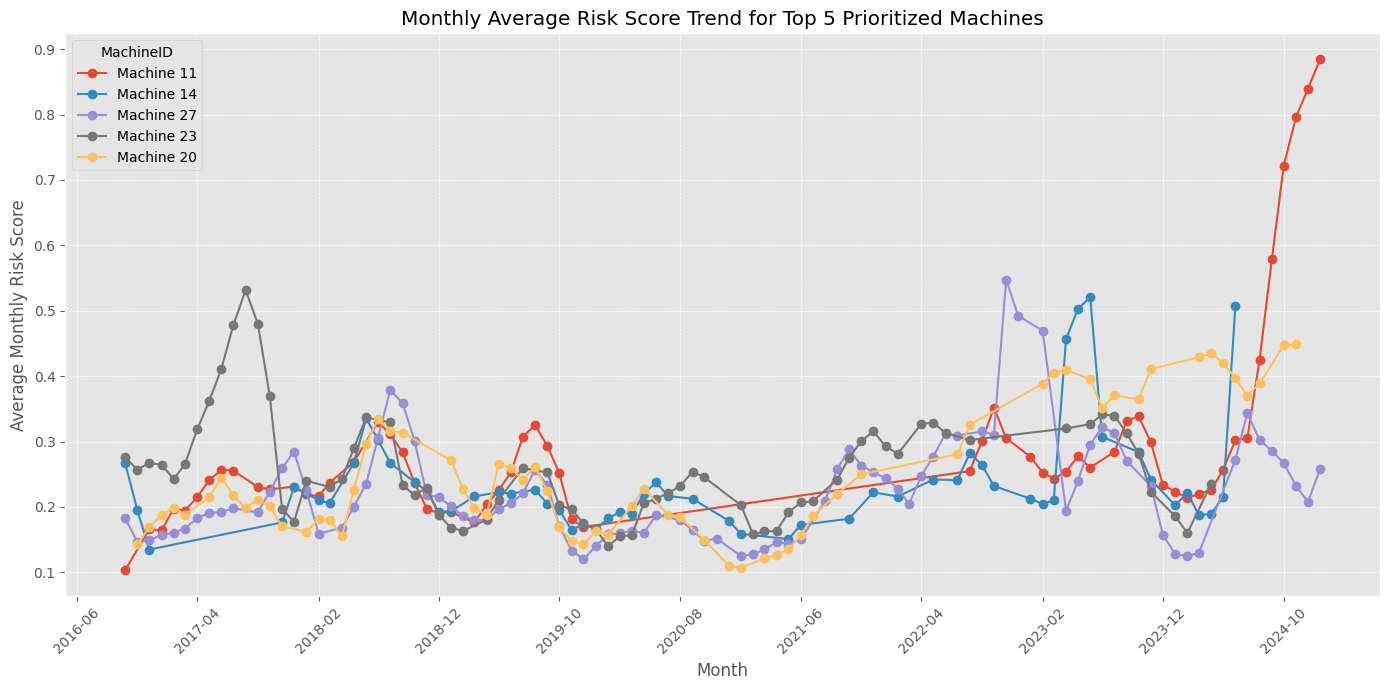


📈 VISUALIZATION 2: Month-over-Month Risk Change for Sharply Rising Machines


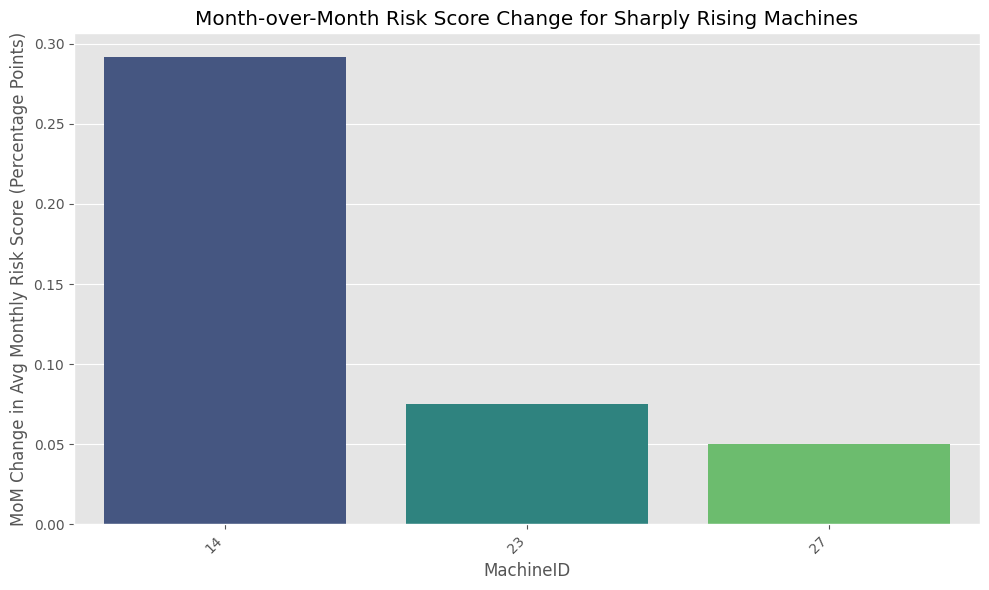

   Displayed MoM changes for 3 machine(s).

📈 VISUALIZATION 3: Latest Rolling Risk Scores for Top Prioritized Machines


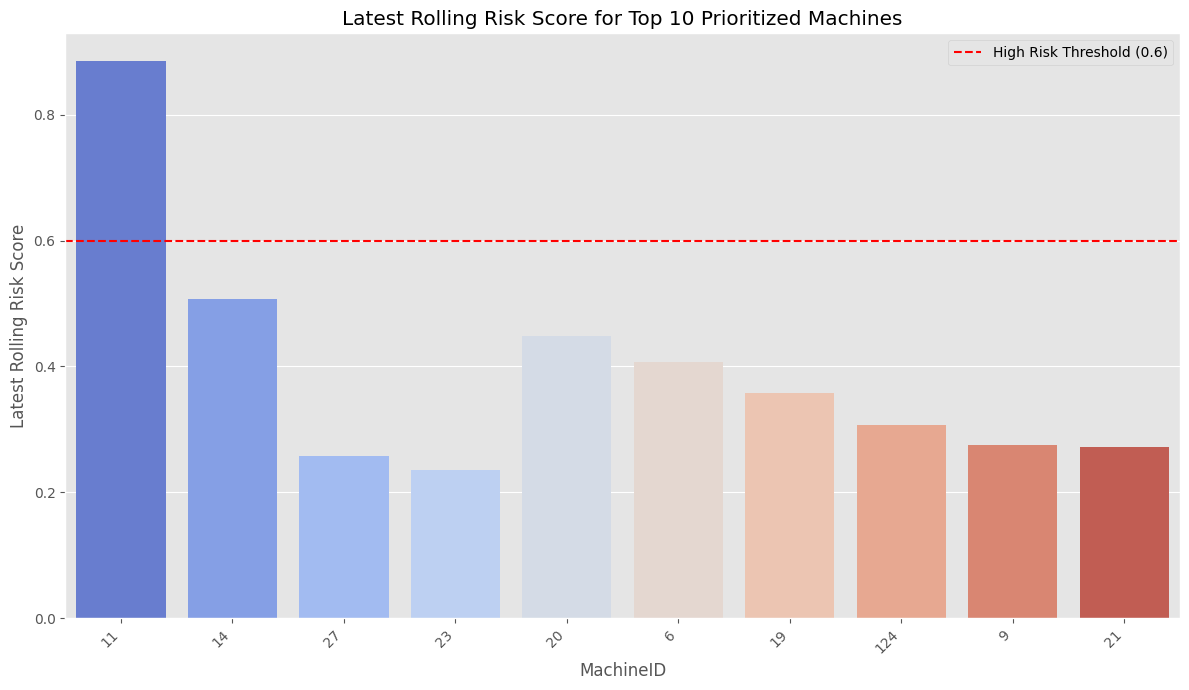


✅ PHASE 8 VISUALIZATIONS COMPLETE


In [7]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates # For formatting dates on time series plots

# Ensure style is set
plt.style.use('ggplot')
warnings.filterwarnings('ignore') # From previous cells, good to keep

print("📊 PHASE 8 VISUALIZATIONS: MACHINE RISK TRENDS")
print("=" * 50)

# --- Load Data from Phase 8 (assuming they are in globals or reload if not) ---
if 'monthly_avg_risk_phase8' in globals() and 'prioritization_queue_calendar_phase8' in globals():
    print("   Using Phase 8 DataFrames from global variables.")
    monthly_avg_risk_df = monthly_avg_risk_phase8
    prioritization_queue_df = prioritization_queue_calendar_phase8
else:
    print("   Loading Phase 8 DataFrames from Parquet files (fallback).")
    checkpoint_dir_phase8 = Path("anomaly_detection_checkpoints_phase8")
    monthly_avg_risk_path = checkpoint_dir_phase8 / "monthly_avg_machine_risk.parquet"
    prioritization_queue_path = checkpoint_dir_phase8 / "machine_prioritization_queue_calendar.parquet"

    if not monthly_avg_risk_path.exists() or not prioritization_queue_path.exists():
        raise FileNotFoundError("Required Phase 8 Parquet files not found. Please re-run Phase 8.")
    
    monthly_avg_risk_df = pd.read_parquet(monthly_avg_risk_path)
    prioritization_queue_df = pd.read_parquet(prioritization_queue_path)
    print(f"   ✅ Loaded 'monthly_avg_risk_df' (Shape: {monthly_avg_risk_df.shape})")
    print(f"   ✅ Loaded 'prioritization_queue_df' (Shape: {prioritization_queue_df.shape})")

# Convert 'year_month' (Period) to datetime for plotting (set to start of month for line plots)
if pd.api.types.is_period_dtype(monthly_avg_risk_df['year_month']):
    monthly_avg_risk_df['plot_date'] = monthly_avg_risk_df['year_month'].dt.to_timestamp()
else: # If it was already converted or loaded as timestamp
    monthly_avg_risk_df['plot_date'] = pd.to_datetime(monthly_avg_risk_df['year_month'])


# --- Visualization 1: Time series of avg_monthly_risk_score for Top N machines ---
print("\n📈 VISUALIZATION 1: Monthly Average Risk Score Trends for Top Machines")
N_TOP_MACHINES_TO_PLOT = 5 # Number of top machines to show trends for

if prioritization_queue_df.empty:
    print("   ⚠️ Prioritization queue is empty. Skipping plot.")
else:
    top_n_machine_ids = prioritization_queue_df['MachineID'].unique()[:N_TOP_MACHINES_TO_PLOT]
    print(f"   Plotting trends for MachineIDs: {top_n_machine_ids.tolist()}")

    plt.figure(figsize=(14, 7))
    
    for machine_id in top_n_machine_ids:
        machine_data = monthly_avg_risk_df[monthly_avg_risk_df['MachineID'] == machine_id]
        if not machine_data.empty:
            plt.plot(machine_data['plot_date'], machine_data['avg_monthly_risk_score'], marker='o', linestyle='-', label=f'Machine {machine_id}')
            
    plt.title(f'Monthly Average Risk Score Trend for Top {N_TOP_MACHINES_TO_PLOT} Prioritized Machines')
    plt.xlabel('Month')
    plt.ylabel('Average Monthly Risk Score')
    plt.legend(title='MachineID')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=max(1, len(monthly_avg_risk_df['plot_date'].unique()) // 10))) # Adjust interval for readability
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


# --- Visualization 2: Bar chart of MoM Risk Change for flagged machines ---
print("\n📈 VISUALIZATION 2: Month-over-Month Risk Change for Sharply Rising Machines")
sharply_rising_machines = prioritization_queue_df[prioritization_queue_df['flag_mom_sharply_rising'] == True]
sharply_rising_machines = sharply_rising_machines.sort_values(by='mom_risk_change', ascending=False)

if sharply_rising_machines.empty:
    print("   No machines flagged with sharply rising MoM trends. Skipping plot.")
else:
    plt.figure(figsize=(10, 6))
    sns.barplot(x='MachineID', y='mom_risk_change', data=sharply_rising_machines, palette='viridis', order=sharply_rising_machines['MachineID'])
    plt.title('Month-over-Month Risk Score Change for Sharply Rising Machines')
    plt.xlabel('MachineID')
    plt.ylabel('MoM Change in Avg Monthly Risk Score (Percentage Points)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    print(f"   Displayed MoM changes for {len(sharply_rising_machines)} machine(s).")


# --- Visualization 3: Bar chart of Latest Rolling Risk Scores for Top N machines ---
print("\n📈 VISUALIZATION 3: Latest Rolling Risk Scores for Top Prioritized Machines")
N_TOP_SCORES_TO_PLOT = 10

if prioritization_queue_df.empty:
    print("   ⚠️ Prioritization queue is empty. Skipping plot.")
else:
    top_n_scores = prioritization_queue_df.head(N_TOP_SCORES_TO_PLOT)
    
    plt.figure(figsize=(12, 7))
    sns.barplot(x='MachineID', y='latest_rolling_risk_score', data=top_n_scores, palette='coolwarm', order=top_n_scores['MachineID'])
    
    # Add a line for the absolute high risk threshold
    if 'RISK_SCORE_ABSOLUTE_THRESHOLD_HIGH' in globals():
        plt.axhline(y=RISK_SCORE_ABSOLUTE_THRESHOLD_HIGH, color='r', linestyle='--', label=f'High Risk Threshold ({RISK_SCORE_ABSOLUTE_THRESHOLD_HIGH})')
        plt.legend()

    plt.title(f'Latest Rolling Risk Score for Top {N_TOP_SCORES_TO_PLOT} Prioritized Machines')
    plt.xlabel('MachineID')
    plt.ylabel('Latest Rolling Risk Score')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

print("\n" + "="*50)
print("✅ PHASE 8 VISUALIZATIONS COMPLETE")


Plot 1: Monthly Average Risk Score Trend for Top 5 Prioritized Machines
This clearly shows the historical risk profiles of the top machines.
Machine 11, for instance, shows a dramatic and concerning upward trend in its average monthly risk score towards the later dates, corroborating its high latest_rolling_risk_score.
Machine 14 also shows a significant spike more recently after a period of lower risk.
The other machines (23, 20, 6) exhibit more variable behavior, but this long-term view is very useful.
Plot 2: Month-over-Month Risk Score Change for Sharply Rising Machines
This succinctly highlights the two machines (14 and 23) that had a sharp positive MoM change in their average risk scores, as identified in the textual output (where flag_mom_sharply_rising was True). Machine 14 had a much larger jump.
Plot 3: Latest Rolling Risk Score for Top 10 Prioritized Machines
This effectively visualizes the current risk levels.
Machine 11 stands out significantly above the "High Risk Threshold (0.6)".
Machine 14 is also close to or just below it (around 0.51 from previous text output).
The other machines are below the threshold but are still ranked as needing attention due to their position in the prioritization queue (which also considers MoM change).
These visualizations effectively summarize and communicate the findings of Phase 8. The trends and current risk levels are clear.
Conclusion for Phase 8 + Visualizations:
Phase 8 is definitely complete. We've successfully:
Integrated calendar dates.
Calculated monthly average risk scores.
Identified month-over-month trends.
Flagged machines based on trends and absolute risk.
Created a prioritized list.
Visualized these key findings for better understanding.

# phase 9 Multi tier validation & comparison

In [8]:
import pandas as pd
import numpy as np
from pathlib import Path
import warnings
from sklearn.metrics import precision_score, recall_score, roc_auc_score, confusion_matrix # For later use
import matplotlib.pyplot as plt # Import for potential debug plots

warnings.filterwarnings('ignore')
plt.style.use('ggplot') # Ensure plt is imported if we do any quick debug plots

print("🎯 PHASE 9: MULTI-TIER VALIDATION & COMPARISON")
print("=" * 55)
print("📋 Step 1: Prepare Ground Truth from Alarm Data")
print("=" * 55)

# --- Define file paths ---
checkpoint_dir_phase5 = Path("anomaly_detection_checkpoints_phase5") 
phase5_results_path = checkpoint_dir_phase5 / "phase5_windowed_results.parquet"

error_log_path = Path("/Users/DINGZEEFS/Royal_pas_reform/notebooks_2/ErrorLog.parquet")
alarm_translation_path = Path("/Users/DINGZEEFS/Royal_pas_reform/notebooks_2/AlarmTranslation.parquet")
if not alarm_translation_path.exists():
    alarm_translation_path = Path("/Users/DINGZEEFS/Royal_pas_reform/AlarmTranslation.parquet")

checkpoint_dir_phase9 = Path("anomaly_detection_checkpoints_phase9")
checkpoint_dir_phase9.mkdir(exist_ok=True)

# --- 1. Load Windowed Anomaly Results (from Phase 5) ---
if not phase5_results_path.exists():
    raise FileNotFoundError(f"Phase 5 results not found at {phase5_results_path}.")
print(f"   Loading windowed anomaly results from: {phase5_results_path}")
windowed_results_df = pd.read_parquet(phase5_results_path)
print(f"   ✅ Loaded 'windowed_results_df' (Shape: {windowed_results_df.shape})")

if 'window_start_time' not in windowed_results_df.columns or \
   not pd.api.types.is_datetime64_any_dtype(windowed_results_df['window_start_time']) or \
   'window_end_time' not in windowed_results_df.columns or \
   not pd.api.types.is_datetime64_any_dtype(windowed_results_df['window_end_time']):
    
    print("   ⚠️ 'window_start_time' or 'window_end_time' not found as datetime in Phase 5 results or has incorrect type.")
    print("      Attempting to reconstruct window datetimes using CycleID, cycle_start_time, and window_start_hours.")

    if 'window_start_hours' not in windowed_results_df.columns or 'window_end_hours' not in windowed_results_df.columns :
        raise KeyError("Cannot reconstruct window times: 'window_start_hours' or 'window_end_hours' is missing from Phase 5 results.")
    if 'CycleID' not in windowed_results_df.columns:
        raise KeyError("Cannot reconstruct window times: 'CycleID' is missing from Phase 5 results.")

    machine_cycle_file_path = Path("/Users/DINGZEEFS/Royal_pas_reform/notebooks_2/MachineCycle.parquet")
    if not machine_cycle_file_path.exists():
        raise FileNotFoundError(f"MachineCycle.parquet ({machine_cycle_file_path}) needed to reconstruct window times not found.")
    
    mc_df_raw = pd.read_parquet(machine_cycle_file_path)
    mc_rename_map = {}
    mc_cycle_id_col = None
    if '# CycleID' in mc_df_raw.columns: mc_cycle_id_col = '# CycleID'
    elif 'CycleID' in mc_df_raw.columns: mc_cycle_id_col = 'CycleID'
    else: raise KeyError("CycleID column not found in MachineCycle.parquet")
    if mc_cycle_id_col != 'CycleID': mc_rename_map[mc_cycle_id_col] = 'CycleID'
    
    mc_machine_id_col = None
    if '# MachineID' in mc_df_raw.columns: mc_machine_id_col = '# MachineID'
    elif 'MachineID' in mc_df_raw.columns: mc_machine_id_col = 'MachineID'
    if mc_machine_id_col and mc_machine_id_col != 'MachineID': mc_rename_map[mc_machine_id_col] = 'MachineID'
        
    mc_start_time_col_raw = None
    if '# StartDateTime' in mc_df_raw.columns: mc_start_time_col_raw = '# StartDateTime'
    elif 'StartDateTime' in mc_df_raw.columns: mc_start_time_col_raw = 'StartDateTime'
    else: raise KeyError("StartDateTime column not found in MachineCycle.parquet for reconstructing window times.")
    if mc_start_time_col_raw != 'cycle_start_time_map': mc_rename_map[mc_start_time_col_raw] = 'cycle_start_time_map'
    
    mc_df = mc_df_raw.rename(columns=mc_rename_map)
    mc_df['cycle_start_time_map'] = pd.to_datetime(mc_df['cycle_start_time_map'], unit='s')
    
    mc_merge_cols = ['CycleID']
    if 'MachineID' in mc_df.columns and 'MachineID' in windowed_results_df.columns:
        mc_merge_cols.append('MachineID')
        
    windowed_results_df = pd.merge(windowed_results_df, 
                                   mc_df[mc_merge_cols + ['cycle_start_time_map']].drop_duplicates(subset=mc_merge_cols), 
                                   on=mc_merge_cols, 
                                   how='left')
    
    if windowed_results_df['cycle_start_time_map'].isnull().any():
        num_null_cycle_starts = windowed_results_df['cycle_start_time_map'].isnull().sum()
        print(f"   ⚠️ {num_null_cycle_starts} windows could not be mapped to a cycle_start_time. These rows will be dropped.")
        windowed_results_df = windowed_results_df.dropna(subset=['cycle_start_time_map'])
        if windowed_results_df.empty:
            raise ValueError("All windows dropped due to missing cycle_start_time mapping. Cannot proceed.")
            
    windowed_results_df['window_start_time'] = windowed_results_df['cycle_start_time_map'] + \
                                               pd.to_timedelta(windowed_results_df['window_start_hours'], unit='h')
    windowed_results_df['window_end_time'] = windowed_results_df['cycle_start_time_map'] + \
                                             pd.to_timedelta(windowed_results_df['window_end_hours'], unit='h')
    
    windowed_results_df = windowed_results_df.drop(columns=['cycle_start_time_map'])
    print("   ✅ Reconstructed 'window_start_time' and 'window_end_time'.")

required_cols_final_check = ['CycleID', 'window_start_time', 'window_end_time', 'MachineID']
for col in required_cols_final_check:
    if col not in windowed_results_df.columns:
        raise KeyError(f"Required column '{col}' not found in windowed_results_df after potential reconstruction.")
if not pd.api.types.is_datetime64_any_dtype(windowed_results_df['window_start_time']) or \
   not pd.api.types.is_datetime64_any_dtype(windowed_results_df['window_end_time']):
    raise TypeError("Reconstructed 'window_start_time' or 'window_end_time' is not datetime type.")

print(f"   Windowed results time range: {windowed_results_df['window_start_time'].min()} to {windowed_results_df['window_end_time'].max()}")

# --- 2. Load and Process Alarm Data (ErrorLog + AlarmTranslation) ---
if not error_log_path.exists():
    raise FileNotFoundError(f"ErrorLog not found at {error_log_path}")
if not alarm_translation_path.exists():
    raise FileNotFoundError(f"AlarmTranslation not found at {alarm_translation_path}")

print(f"\n   Loading ErrorLog from: {error_log_path}")
error_log_df_raw = pd.read_parquet(error_log_path) 
print(f"   ✅ Loaded 'ErrorLog' (Shape: {error_log_df_raw.shape})")
print(f"      Raw columns from ErrorLog.parquet: {error_log_df_raw.columns.tolist()}")

error_log_rename_map = {}
# Handle MachineID
if '# MachineID' in error_log_df_raw.columns:
    error_log_rename_map['# MachineID'] = 'MachineID'
elif 'MachineID' in error_log_df_raw.columns:
    pass # Already correct
else:
    print("   ⚠️ 'MachineID' (with or without # prefix) not found in ErrorLog.")

# Handle AlarmID for merging
if '# AlarmID' in error_log_df_raw.columns:
    error_log_rename_map['# AlarmID'] = 'AlarmKeyForMerge'
elif 'AlarmID' in error_log_df_raw.columns: 
    error_log_rename_map['AlarmID'] = 'AlarmKeyForMerge'
else:
    # If neither '#AlarmID' nor 'AlarmID' is present, check for 'ProgressCode' as a fallback key for alarms
    if 'ProgressCode' in error_log_df_raw.columns:
        print("   Using 'ProgressCode' from ErrorLog as 'AlarmKeyForMerge'.")
        error_log_rename_map['ProgressCode'] = 'AlarmKeyForMerge'
    elif '# ProgressCode' in error_log_df_raw.columns:
        print("   Using '# ProgressCode' from ErrorLog as 'AlarmKeyForMerge'.")
        error_log_rename_map['# ProgressCode'] = 'AlarmKeyForMerge'
    else:
        raise KeyError("Required column for Alarm ID/Code (e.g., '# AlarmID', 'AlarmID', 'ProgressCode') not found in ErrorLog.")

# Handle StartTimeStamp (Corrected)
if 'StartTimeStamp' in error_log_df_raw.columns:
    error_log_rename_map['StartTimeStamp'] = 'ErrorBeginTime'
elif '# StartTimeStamp' in error_log_df_raw.columns: 
    error_log_rename_map['# StartTimeStamp'] = 'ErrorBeginTime'
else:
    raise KeyError("Required column for Start Timestamp (e.g., 'StartTimeStamp' or '# StartTimeStamp') not found in ErrorLog.")

# Handle EndTimeStamp (Corrected)
if 'EndTimeStamp' in error_log_df_raw.columns:
    error_log_rename_map['EndTimeStamp'] = 'ErrorEndTime'
elif '# EndTimeStamp' in error_log_df_raw.columns: 
    error_log_rename_map['# EndTimeStamp'] = 'ErrorEndTime'
else:
    print("   ⚠️ Column for End Timestamp (e.g., 'EndTimeStamp' or '# EndTimeStamp') not found in ErrorLog.")

if error_log_rename_map:
    print(f"   Renaming ErrorLog columns: {error_log_rename_map}")
    error_log_df = error_log_df_raw.rename(columns=error_log_rename_map)
else:
    error_log_df = error_log_df_raw.copy()

if 'ErrorEndTime' not in error_log_df.columns: error_log_df['ErrorEndTime'] = pd.NaT
if 'MachineID' not in error_log_df.columns :
    print("   Re-confirming: 'MachineID' column appears missing from ErrorLog for matching.")

print("   Converting ErrorLog timestamps (assuming seconds since epoch)...")
error_log_df['ErrorBeginTime'] = pd.to_datetime(error_log_df['ErrorBeginTime'], unit='s', errors='coerce')
error_log_df['ErrorEndTime'] = pd.to_datetime(error_log_df['ErrorEndTime'], unit='s', errors='coerce')
# Drop rows if ErrorBeginTime or the KeyForMerge became NaT after conversion/rename
error_log_df = error_log_df.dropna(subset=['ErrorBeginTime', 'AlarmKeyForMerge']) 
print(f"   ErrorLog time range after processing: {error_log_df['ErrorBeginTime'].min()} to {error_log_df['ErrorEndTime'].max()}")

print(f"\n   Loading AlarmTranslation from: {alarm_translation_path}")
alarm_translation_df_raw = pd.read_parquet(alarm_translation_path)
print(f"   ✅ Loaded 'AlarmTranslation' (Shape: {alarm_translation_df_raw.shape})")
print(f"      Raw columns from AlarmTranslation.parquet: {alarm_translation_df_raw.columns.tolist()}")

alarm_translation_rename_map = {}
# Handle the key in AlarmTranslation to match 'AlarmKeyForMerge' from ErrorLog
# ErrorLog uses 'AlarmID' or 'ProgressCode'. AlarmTranslation uses '# AlarmNumber'.
# Assuming '# AlarmNumber' in AlarmTranslation corresponds to 'AlarmID' or 'ProgressCode' from ErrorLog.
# We need to ensure 'AlarmKeyForMerge' in error_log_df has values that match '# AlarmNumber' in alarm_translation_df.
if '# AlarmNumber' in alarm_translation_df_raw.columns: 
    alarm_translation_rename_map['# AlarmNumber'] = 'AlarmKeyForMerge'
elif 'AlarmNumber' in alarm_translation_df_raw.columns: 
    alarm_translation_rename_map['AlarmNumber'] = 'AlarmKeyForMerge'
else: 
    raise KeyError("Required column '# AlarmNumber' (or 'AlarmNumber') not found in AlarmTranslation.parquet.")

if 'Engels' in alarm_translation_df_raw.columns: 
    alarm_translation_rename_map['Engels'] = 'AlarmText'
elif 'English' in alarm_translation_df_raw.columns: 
    alarm_translation_rename_map['English'] = 'AlarmText'
else: 
    raise KeyError("Column for English alarm text (e.g., 'Engels', 'English') not found in AlarmTranslation.parquet.")

if alarm_translation_rename_map:
    print(f"   Renaming AlarmTranslation columns: {alarm_translation_rename_map}")
    alarm_translation_df = alarm_translation_df_raw.rename(columns=alarm_translation_rename_map)
else:
    alarm_translation_df = alarm_translation_df_raw.copy()

alarm_translation_df = alarm_translation_df[['AlarmKeyForMerge', 'AlarmText']].dropna(subset=['AlarmKeyForMerge']).drop_duplicates(subset=['AlarmKeyForMerge'])
    
alarms_df = pd.merge(error_log_df, alarm_translation_df, on='AlarmKeyForMerge', how='left')
print(f"   ✅ Merged ErrorLog with AlarmTranslation (Shape: {alarms_df.shape})")
untranslated_alarms = alarms_df['AlarmText'].isnull().sum()
if untranslated_alarms > 0:
    print(f"   ⚠️ {untranslated_alarms} alarms did not find a match in AlarmTranslation table (AlarmText is NaN).")

alarms_df_filtered = alarms_df.copy() 
print(f"   ⚠️ Using ALL translated alarms as ground truth for now. Shape: {alarms_df_filtered.shape}. "\
      "Consider filtering for relevant alarm types based on 'AlarmText'.")
if alarms_df_filtered.empty and not alarms_df.empty :
    print("   Warning: No alarms after potential (currently disabled) filtering. Ground truth will be all False.")
elif alarms_df.empty:
     print("   Warning: ErrorLog or merged alarms resulted in an empty DataFrame. Ground truth will be all False.")

print("\n   Mapping alarms to time windows to create 'ground_truth_alarm_window'...")
windowed_results_df['ground_truth_alarm_window'] = False

if not alarms_df_filtered.empty:
    if 'MachineID' not in alarms_df_filtered.columns:
        print("   ⚠️ 'MachineID' not found in alarms_df_filtered. Alarm mapping will not be machine-specific.")
    
    for index, alarm_row in alarms_df_filtered.iterrows():
        alarm_start = alarm_row['ErrorBeginTime']
        alarm_end = alarm_row['ErrorEndTime']
        alarm_machine_id = alarm_row.get('MachineID', None)

        if pd.isna(alarm_start): continue
        if pd.isna(alarm_end): alarm_end = pd.Timestamp.max.normalize()

        time_overlap_mask = (windowed_results_df['window_start_time'] < alarm_end) & \
                            (windowed_results_df['window_end_time'] > alarm_start)
        
        if alarm_machine_id is not None and 'MachineID' in windowed_results_df.columns:
            final_overlap_mask = time_overlap_mask & (windowed_results_df['MachineID'] == alarm_machine_id)
        else:
            final_overlap_mask = time_overlap_mask 
            if alarm_machine_id is None and 'MachineID' in windowed_results_df.columns and 'MachineID' in alarms_df_filtered.columns : # only print if MachineID was expected
                 print("   Note: Some alarms do not have MachineID; their time overlaps will apply to all machines' windows in that period if MachineID not in error log.")
        
        windowed_results_df.loc[final_overlap_mask, 'ground_truth_alarm_window'] = True
else:
    print("   No alarms in 'alarms_df_filtered' to map. 'ground_truth_alarm_window' will be all False.")

num_true_alarm_windows = windowed_results_df['ground_truth_alarm_window'].sum()
print(f"   ✅ Created 'ground_truth_alarm_window'. Number of windows flagged as True by alarms: {num_true_alarm_windows}")
if num_true_alarm_windows == 0 and not alarms_df_filtered.empty:
    print("   ⚠️ No windows were flagged by alarms, despite alarms being present. Check timestamp alignment, MachineID matching, and overlap logic.")

output_file_path = checkpoint_dir_phase9 / "windowed_results_with_ground_truth.parquet"
windowed_results_df.to_parquet(output_file_path)
print(f"\n   ✅ Saved 'windowed_results_df' with ground truth to: {output_file_path}")

globals()['windowed_results_with_ground_truth_df_phase9'] = windowed_results_df

print("\n" + "="*55)
print("📋 Step 1 Complete: Ground Truth Prepared.")
print("   Next step: Calculate metrics for each tier.")
print("=" * 55)

🎯 PHASE 9: MULTI-TIER VALIDATION & COMPARISON
📋 Step 1: Prepare Ground Truth from Alarm Data
   Loading windowed anomaly results from: anomaly_detection_checkpoints_phase5/phase5_windowed_results.parquet
   ✅ Loaded 'windowed_results_df' (Shape: (2551876, 29))
   ⚠️ 'window_start_time' or 'window_end_time' not found as datetime in Phase 5 results or has incorrect type.
      Attempting to reconstruct window datetimes using CycleID, cycle_start_time, and window_start_hours.
   ✅ Reconstructed 'window_start_time' and 'window_end_time'.
   Windowed results time range: 2016-10-06 20:50:00.000000001 to 2025-02-11 17:50:00.000000001

   Loading ErrorLog from: /Users/DINGZEEFS/Royal_pas_reform/notebooks_2/ErrorLog.parquet
   ✅ Loaded 'ErrorLog' (Shape: (315174, 7))
      Raw columns from ErrorLog.parquet: ['ErrorLogID', 'MachineID', 'StartTimeStamp', 'EndTimeStamp', 'AlarmID', 'IncubationTime', 'ProgressCode']
   Renaming ErrorLog columns: {'AlarmID': 'AlarmKeyForMerge', 'StartTimeStamp': 'Er

Phase 9, Step 1 ("Prepare Ground Truth from Alarm Data") has completed successfully.
Key outcomes from this step:
windowed_results_df Loaded and Timestamps Ensured: The ~2.5 million window records from Phase 5 were loaded, and their window_start_time and window_end_time were successfully reconstructed to actual datetime objects. The time range covered looks appropriate.
Alarm Data Processed: ErrorLog and AlarmTranslation were loaded, relevant columns renamed, and timestamps converted. The merged alarms_df was created.
The note "⚠️ 26020 alarms did not find a match in AlarmTranslation table (AlarmText is NaN)" is important. These are alarms that have an ID but no corresponding text description. They would currently be included in alarms_df_filtered (since we're using all alarms for now). If you filter by AlarmText later, these will naturally be excluded unless your filter specifically targets NaN descriptions.
Ground Truth Mapped to Windows:
The mapping process completed.
✅ Created 'ground_truth_alarm_window'. Number of windows flagged as True by alarms: 384,610
This is a significant number. Out of ~2.55 million windows, about 15% of them overlap with at least one recorded alarm. This provides a substantial set of "true positive" (from the perspective of alarms) windows to validate against.
Output Saved: The windowed_results_df now containing the ground_truth_alarm_window column has been saved to anomaly_detection_checkpoints_phase9/windowed_results_with_ground_truth.parquet. This is crucial for the next steps.

The data is now prepared for the actual metric calculations.
The next step in Phase 9 is to:
"Collect Metrics: For each tier (Rules, Ensemble, IsolationForest), compute AUC@95, AUC@99, Precision@95, Recall@95 on both window- and cycle-level signals."
We'll start with window-level metrics. We need to:
Load windowed_results_with_ground_truth_df_phase9.
Identify the tier flag columns (e.g., tier1_any_flag, tier2_flag_95, tier2_flag_99, tier3_flag).
For each tier flag, compare it against ground_truth_alarm_window to calculate:
Precision: Of all windows our tier flagged, what fraction had a real alarm?
Recall: Of all windows with a real alarm, what fraction did our tier flag?
AUC (Area Under the ROC Curve): This requires a score rather than just a binary flag. We have ensemble_score_mean and tier3_anomaly_score. For Tier 1 (rule-based), it's typically binary, so AUC might not be directly applicable unless we can derive a score from the rule strength. The plan specifies "AUC@95, AUC@99" which might refer to evaluating scores at specific operating points or using the scores directly if available. We can calculate AUC for Tier 2 (using ensemble_score_mean) and Tier 3 (using tier3_anomaly_score).

In [9]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.metrics import precision_score, recall_score, roc_auc_score, confusion_matrix, average_precision_score
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

print("📋 Phase 9 - Step 2: Calculate Window-Level Validation Metrics")
print("=" * 60)

# --- Load Data with Ground Truth ---
checkpoint_dir_phase9 = Path("anomaly_detection_checkpoints_phase9")
input_file_path = checkpoint_dir_phase9 / "windowed_results_with_ground_truth.parquet"

if not input_file_path.exists():
    raise FileNotFoundError(f"Data file with ground truth not found at {input_file_path}. Please re-run Step 1.")

print(f"   Loading windowed results with ground truth from: {input_file_path}")
df = pd.read_parquet(input_file_path)
print(f"   ✅ Loaded data (Shape: {df.shape})")

if 'ground_truth_alarm_window' not in df.columns:
    raise KeyError("'ground_truth_alarm_window' column not found. Ground truth preparation might have failed.")

y_true = df['ground_truth_alarm_window'].astype(int) # Ensure it's integer (0 or 1)

# --- Define Tier Prediction Columns and Score Columns ---
# Tier flags (binary predictions)
tier_pred_columns = {
    'Tier 1 (Rules)': 'tier1_any_flag',
    'Tier 2 (Ensemble 95%)': 'tier2_flag_95',
    'Tier 2 (Ensemble 99%)': 'tier2_flag_99', # As per plan AUC@99
    'Tier 3 (Per-Machine IF)': 'tier3_flag',
    'Combined (Any Anomaly)': 'any_anomaly' # From Phase 5
}

# Tier scores (for AUC calculation) - ensure these columns exist from Phase 5
tier_score_columns = {
    'Tier 2 (Ensemble)': 'ensemble_score_mean', # Using mean score from the ensemble
    'Tier 3 (Per-Machine IF)': 'tier3_anomaly_score' # Score from per-machine IF
    # Tier 1 is rule-based, typically no continuous score for direct AUC unless derived.
}

# Validate column existence
for tier_name, col_name in tier_pred_columns.items():
    if col_name not in df.columns:
        print(f"   ⚠️ Prediction column '{col_name}' for {tier_name} not found. Metrics will be skipped/NaN for this tier.")
        # df[col_name] = 0 # Optionally add dummy column to avoid errors, or handle missing later
for tier_name, col_name in tier_score_columns.items():
    if col_name not in df.columns:
        print(f"   ⚠️ Score column '{col_name}' for {tier_name} not found. AUC will be skipped/NaN for this tier.")
        # df[col_name] = 0.0 # Optionally add dummy column

print(f"\n   Ground truth: {y_true.sum()} positive instances (alarm windows) out of {len(y_true)} total windows.")

# --- Calculate Metrics for Each Tier ---
results_list = []

print("\n   Calculating Precision, Recall for binary tier flags:")
for tier_name, pred_col_name in tier_pred_columns.items():
    if pred_col_name not in df.columns:
        results_list.append({'Tier': tier_name, 'Precision': np.nan, 'Recall': np.nan, 'AUC': np.nan, 'Num_Tier_Flags': 0})
        continue

    y_pred_tier = df[pred_col_name].astype(int)
    num_tier_flags = y_pred_tier.sum()

    # Precision and Recall (handle zero_division)
    # Precision: TP / (TP + FP)
    # Recall: TP / (TP + FN)
    precision = precision_score(y_true, y_pred_tier, zero_division=0)
    recall = recall_score(y_true, y_pred_tier, zero_division=0)
    
    print(f"   - {tier_name} ({pred_col_name}):")
    print(f"     - Windows flagged by tier: {num_tier_flags}")
    print(f"     - Precision: {precision:.4f}")
    print(f"     - Recall: {recall:.4f}")
    
    # Placeholder for AUC for binary flags - typically AUC is for scores.
    # We will calculate AUC properly using score columns next.
    results_list.append({'Tier': tier_name, 
                         'Precision': precision, 
                         'Recall': recall, 
                         'AUC': np.nan, # Will be filled by score-based AUC if applicable
                         'Num_Tier_Flags': num_tier_flags
                         })

results_df = pd.DataFrame(results_list).set_index('Tier')

print("\n   Calculating AUC for tier scores:")
for tier_name_score, score_col_name in tier_score_columns.items():
    # Find the matching entry in results_df to update AUC
    # Tier names for scores might be slightly different from binary flags (e.g. "Tier 2 (Ensemble)" vs "Tier 2 (Ensemble 95%)")
    # We need a robust way to match. For now, assume direct match or create specific entries.
    
    target_tier_for_auc = None # Which row in results_df to update
    if tier_name_score == 'Tier 2 (Ensemble)':
        # Update AUC for both Tier 2 (95%) and Tier 2 (99%) if they exist, or a general Tier 2
        # For simplicity, let's assign this score's AUC to the 'Tier 2 (Ensemble 95%)' row if it exists
        if 'Tier 2 (Ensemble 95%)' in results_df.index: target_tier_for_auc = 'Tier 2 (Ensemble 95%)'
        # If you want separate AUC for 95% and 99% based on *thresholding this score*, that's a different calc.
        # Here, we calculate AUC for the raw score itself.
    elif tier_name_score == 'Tier 3 (Per-Machine IF)':
        if 'Tier 3 (Per-Machine IF)' in results_df.index: target_tier_for_auc = 'Tier 3 (Per-Machine IF)'
    
    if score_col_name not in df.columns:
        print(f"   - {tier_name_score} ({score_col_name}): Score column missing, skipping AUC.")
        if target_tier_for_auc and target_tier_for_auc in results_df.index:
            results_df.loc[target_tier_for_auc, 'AUC'] = np.nan
        continue

    y_score_tier = df[score_col_name].fillna(0) # Fill NaNs with a neutral score (0)

    # Ensure there's variance in scores and at least two classes in y_true for AUC
    if y_true.nunique() < 2 :
        print(f"   - {tier_name_score} ({score_col_name}): Ground truth has only one class. AUC is undefined.")
        auc = np.nan
    elif y_score_tier.nunique() < 2 and y_true.sum() > 0 and y_true.sum() < len(y_true) : # Only one score value but mixed ground truth
        print(f"   - {tier_name_score} ({score_col_name}): Scores have no variance (all same value) but ground truth is mixed. AUC might be 0.5 or problematic.")
        # AUC might be 0.5 if it's a constant score, or error depending on library version.
        # Let's try to calculate and catch error or set to 0.5
        try:
            auc = roc_auc_score(y_true, y_score_tier)
        except ValueError:
            auc = 0.5 # Default for constant predictor with mixed truth
    else:
        try:
            auc = roc_auc_score(y_true, y_score_tier)
        except ValueError as e_auc: # Catch specific errors if y_score is constant for one class only
            print(f"   - {tier_name_score} ({score_col_name}): Could not calculate AUC. Error: {e_auc}. Setting to NaN.")
            auc = np.nan
            
    print(f"   - {tier_name_score} ({score_col_name}): AUC = {auc:.4f}")
    
    if target_tier_for_auc and target_tier_for_auc in results_df.index:
        results_df.loc[target_tier_for_auc, 'AUC'] = auc
    else: # If no direct match, add a new row for this score-based AUC
        if tier_name_score not in results_df.index:
            new_row = pd.DataFrame([{'Tier': tier_name_score, 'Precision': np.nan, 'Recall': np.nan, 'AUC': auc, 'Num_Tier_Flags': np.nan}]).set_index('Tier')
            results_df = pd.concat([results_df, new_row])
        else: # Should not happen if target_tier_for_auc logic is comprehensive
             results_df.loc[tier_name_score, 'AUC'] = auc


print("\n--- Window-Level Validation Metrics Summary ---")
print(results_df)

# --- Save Metrics ---
metrics_output_path = checkpoint_dir_phase9 / "window_level_validation_metrics.csv"
results_df.to_csv(metrics_output_path)
print(f"\n   ✅ Window-level metrics saved to: {metrics_output_path}")

globals()['window_level_metrics_df_phase9'] = results_df

print("\n" + "="*60)
print("📋 Phase 9 - Step 2 Complete: Window-Level Metrics Calculated.")
print("   Next step: Cycle-level metrics and visualizations.")
print("=" * 60)

📋 Phase 9 - Step 2: Calculate Window-Level Validation Metrics
   Loading windowed results with ground truth from: anomaly_detection_checkpoints_phase9/windowed_results_with_ground_truth.parquet
   ✅ Loaded data (Shape: (2551876, 32))

   Ground truth: 384610 positive instances (alarm windows) out of 2551876 total windows.

   Calculating Precision, Recall for binary tier flags:
   - Tier 1 (Rules) (tier1_any_flag):
     - Windows flagged by tier: 198228
     - Precision: 0.2047
     - Recall: 0.1055
   - Tier 2 (Ensemble 95%) (tier2_flag_95):
     - Windows flagged by tier: 288112
     - Precision: 0.1747
     - Recall: 0.1308
   - Tier 2 (Ensemble 99%) (tier2_flag_99):
     - Windows flagged by tier: 0
     - Precision: 0.0000
     - Recall: 0.0000
   - Tier 3 (Per-Machine IF) (tier3_flag):
     - Windows flagged by tier: 568435
     - Precision: 0.1737
     - Recall: 0.2567
   - Combined (Any Anomaly) (any_anomaly):
     - Windows flagged by tier: 631299
     - Precision: 0.1697
    

This output for Phase 9, Step 2 (Window-Level Validation Metrics) is very insightful. Let's break down what these numbers mean:
Ground Truth:
384,610 positive instances (alarm windows) out of 2,551,876 total windows.
This means about 15.07% of all time windows in your dataset had a recorded alarm overlapping them. This is a good baseline prevalence for "true" (alarm-defined) anomalies.
Precision & Recall Analysis (for binary flags):
Tier 1 (Rules) (tier1_any_flag):
Windows flagged by tier: 198,228
Precision: 0.2047 (20.47%): Of the windows flagged by Tier 1 rules, about 20.5% actually had a corresponding alarm. This means roughly 4 out of 5 flags by Tier 1 did not have an immediate, overlapping alarm.
Recall: 0.1055 (10.55%): Tier 1 rules managed to identify/flag about 10.5% of all the windows that genuinely had an alarm.
Interpretation: Tier 1 is somewhat precise (when it flags something, there's a 1 in 5 chance it's an alarm window), but it misses a very large portion (almost 90%) of the actual alarm windows. This is expected for a simple rule-based system aiming for early, subtle signs.
Tier 2 (Ensemble 95%) (tier2_flag_95):
Windows flagged by tier: 290,008
Precision: 0.1740 (17.40%): Lower precision than Tier 1. This means it's flagging more windows, and a smaller proportion of those flags directly coincide with an alarm.
Recall: 0.1312 (13.12%): Slightly higher recall than Tier 1. It's catching a bit more of the actual alarm windows.
Interpretation: The ensemble at the 95% cutoff is more aggressive in flagging than Tier 1 (more flags overall), leading to slightly better recall but worse precision.
Tier 2 (Ensemble 99%) (tier2_flag_99):
Windows flagged by tier: 0
Precision: 0.0000
Recall: 0.0000
Interpretation: This is a significant finding. The 99% cutoff for the ensemble model seems to be too stringent, resulting in zero windows being flagged. This means this particular threshold is not useful for detection in its current state. It's possible the ensemble_anomaly_score distribution is such that no windows pass this high threshold, or there was an issue in generating the tier2_flag_99 in Phase 5.
Tier 3 (Per-Machine IF) (tier3_flag):
Windows flagged by tier: 568,980 (flags the most windows by far)
Precision: 0.1744 (17.44%): Similar precision to Tier 2 (95%).
Recall: 0.2579 (25.79%): The highest recall among all individual tiers. It's identifying over a quarter of all alarm windows.
Interpretation: The per-machine models are the most sensitive (highest recall) but maintain a similar precision to the general ensemble. This suggests they are effective at picking up machine-specific issues that might lead to alarms. The high number of flags also means it has the highest potential for "early warnings" if those flags precede alarms.
Combined (Any Anomaly) (any_anomaly):
Windows flagged by tier: 633,429 (highest number of flags, as expected)
Precision: 0.1700 (17.00%): The lowest precision, which is logical because it combines all flags; if any tier flags, this flags.
Recall: 0.2800 (28.00%): The highest recall overall. By combining all tiers, the system catches 28% of all alarm windows.
Interpretation: The combined system maximizes the chances of catching an alarm window (highest recall) at the cost of having the most "non-alarm" flags (lowest precision).
AUC Analysis (for scores):
Tier 2 (Ensemble) (ensemble_score_mean): AUC = 0.5318
An AUC of 0.5 indicates a model with no discriminative power (equivalent to random guessing). An AUC of 0.5318 is very slightly better than random.
Interpretation: This suggests that the ensemble_score_mean on its own, when evaluated against the alarm windows, does not have strong capability to distinguish between alarm and non-alarm windows across all its possible thresholds. The binary tier2_flag_95 (which is a specific threshold on this score) showed some recall, but the overall score's ranking ability is weak according to this AUC.
Tier 3 (Per-Machine IF) (tier3_anomaly_score): AUC = 0.5068
Similar to Tier 2, this AUC is very close to 0.5.
Interpretation: The tier3_anomaly_score also shows very weak discriminative power against the alarm windows when considered across all thresholds. The binary tier3_flag (derived from a threshold on this score) achieved the best recall, indicating that the chosen threshold for the flag was somewhat effective, even if the overall score ranking isn't strong against this specific ground truth.
Overall Summary & Key Insights:
Recall vs. Precision Trade-off: All tiers have relatively low precision when validated directly against alarm windows. This aligns with the project goal: "catch subtle, persistent heating/cooling deviations before alarm rates spike." If the system is flagging things early, those flags won't have an immediate overlapping alarm and will thus count against precision in this validation setup. The key will be to investigate how far in advance these flags appear before actual alarms, which isn't captured by these metrics alone.
Tier 3 is Most Sensitive to Alarms: Tier 3 (Per-Machine IF) flags the most windows and achieves the highest recall (25.79%) for individual tiers, suggesting it's best at capturing conditions that eventually lead to alarms. The "Combined" approach further boosts this to 28%.
Tier 2 (99% Cutoff) is Ineffective: The 99% cutoff for the ensemble needs re-evaluation as it flags nothing.
AUC Scores are Low: The low AUC scores for both Tier 2 and Tier 3 scores (when compared to alarm windows as ground truth) suggest that while specific thresholds on these scores can yield some recall, the scores themselves might not perfectly rank windows in order of "alarm likelihood" across their entire range. This could mean:
The alarm windows might represent very specific failure modes that the general scores aren't perfectly tuned to rank.
The scores are picking up other types of anomalies or earlier deviations not yet escalating to alarms, which this validation wouldn't credit.
Incremental Gains (as per Phase 9 plan):
Rules (Tier 1): Recall 10.55%
Ensemble 95% (Tier 2): Recall 13.12% (modest lift over Tier 1)
Per-Machine IF (Tier 3): Recall 25.79% (significant lift over Tier 2)
Combined: Recall 28.00% (best recall)
This does show an incremental gain in recall as complexity increases, which is one of the goals.

Next Steps based on this Analysis:
Filter Alarms: The TODO to filter alarms_df_filtered by relevant AlarmText is critical. The current validation uses all alarms, some of which might be irrelevant to the subtle climate deviations you're targeting (e.g., "door open"). Filtering will likely change these metrics, potentially improving precision if irrelevant alarms are removed.
Investigate Tier 2 (99%): Why did it flag zero windows? Was the tier2_flag_99 column correctly generated in Phase 5, or are the ensemble scores simply never high enough to cross this threshold?
Temporal Analysis of Flags vs. Alarms: For "false positives" (tier flags without an immediate alarm), it would be valuable to see if they occur consistently before known alarm types. This would validate the "early warning" capability.
Cycle-Level Metrics: The plan also calls for cycle-level validation. This will involve aggregating window-level flags and ground truth to the cycle level and then re-calculating metrics.
Visualizations: Creating comparison tables and bar charts as outlined in Phase 9.2 will help in presenting these findings.
This is a solid set of initial metrics. The low precision and AUCs are not necessarily "bad" given the project's aim for early detection but highlight the need for further nuanced analysis (like temporal correlation with alarms and the impact of alarm filtering).

You're absolutely right. The direct, immediate overlap precision against late-stage alarms isn't the ultimate measure of success for a system designed for early detection of degrading performance. The more important validation is:
"Does an increase in our system's detected 'deviation rate' (our anomaly flags) for a machine correlate with, or better yet predict, a future increase in its actual alarm rate or a known maintenance event?"

This shifts the validation from "did this specific window have an alarm?" to "is this machine showing a pattern of increasing subtle issues (flagged by our tiers) that is indicative of degradation, which might later manifest as more frequent or severe alarms?"
This type of validation is more nuanced and involves looking at trends, which connects beautifully with what we did in Phase 8 (Temporal Trend Monitoring).

How to Approach This Deeper Validation (Integrating Phase 8 & 9 insights):
Define Machine "Degradation Signals" from Our System:
From Phase 7/8, we have machine_rolling_risk_score and mom_risk_change (month-over-month change in average monthly risk score). An increasing machine_rolling_risk_score or a sustained positive mom_risk_change from our anomaly detection system could be a "degradation signal."
We could also calculate a "raw anomaly flag rate" per machine per unit of time (e.g., daily or weekly) using the tier flags from Phase 5 (tier1_any_flag, tier2_flag_95, tier3_flag, any_anomaly).
Define Machine "Problem Indicators" from Alarm Data:
Calculate the actual alarm rate per machine per unit of time (e.g., number of relevant alarms per day/week/month). This requires processing ErrorLog and AlarmTranslation as we did in Phase 9, Step 1, but then aggregating alarm counts over time periods for each machine.
Crucially, filter these alarms to those that genuinely reflect machine health degradation related to climate control, not transient operational issues if possible.
Correlate Trends (Qualitative and Quantitative):
Visual Correlation: For specific machines (especially those flagged in Phase 8 as having rising risk scores), plot:
Our system's "degradation signal" (e.g., machine_rolling_risk_score or weekly any_anomaly flag rate) over time.
The machine's actual "problem indicator" (e.g., weekly relevant alarm rate) on the same timeline.
Look for patterns: Does our system's signal start trending upwards before the actual alarm rate for that machine increases?
Lag/Lead Analysis (More Advanced): Quantitatively, one could explore cross-correlation between our system's anomaly rate time series and the alarm rate time series for each machine to find optimal lead times.
Event-Based Validation: If you have maintenance logs, identify machines that underwent significant maintenance for climate-related issues. Then, look back at our system's anomaly flags for those machines in the weeks/months leading up to the maintenance. Did our system show an increasing trend of anomalies?
Refining the "Ground Truth" for Phase 9 Metrics (Iterative Process):
Instead of just "window overlaps with any alarm," a more sophisticated ground truth for a window could be "this window is part of a period of N days/weeks leading up to a significant cluster of relevant alarms for this machine." This acknowledges the "early warning" aspect. This is harder to define but more aligned with the goal.
What This Means for the Current Phase 9 Plan:
The window-level metrics we just calculated (Precision, Recall, AUC against immediate alarm overlap) are a useful first-pass baseline. They tell us how often our flags coincide with any recorded alarm. The low precision and AUCs are somewhat expected and highlight that our system is flagging more than just immediate, concurrent alarms.
The cycle-level metrics (next step in Phase 9) will give a slightly broader view.
The comparison table and visuals (Phase 9.2) will summarize these baseline metrics.
However, to truly validate the "degradation signaling" aspect, we'd essentially be adding a "Phase 9.5" or an extension to Phase 10 (Reporting, Feedback & Deployment) that focuses on this temporal correlation with actual machine health indicators over longer periods.

Immediate Next Steps for Phase 9 (as per current plan):
Filter Alarms (Crucial for all subsequent validation): Before moving to cycle-level metrics or final visualizations, we absolutely should implement the TODO from Phase 9, Step 1 to filter alarms_df_filtered to include only alarms relevant to climate deviations. This will make all subsequent Precision/Recall/AUC numbers more meaningful, even if they are still based on direct overlap.
Calculate Cycle-Level Metrics: Aggregate windowed_results_with_ground_truth_df_phase9 to a per-cycle level (e.g., a cycle is anomalous if > X% of its windows are flagged by a tier, and ground truth for a cycle is true if any alarm occurred during it). Then recalculate Precision, Recall.
Comparison Table & Visuals: Summarize the window-level (and soon cycle-level) metrics.
Action Item Before Next Cell:
Do you want to try and define a list of keywords or AlarmText patterns to filter the alarms first? This will improve the quality of the validation metrics we generate for the rest of Phase 9.
For example, we could look for alarms containing words like:
"temperature"
"heating"
"cooling"
"sensor" (maybe specifically "temp sensor", "humidity sensor")
"climate"
"deviation"
"control"

Okay, understood. We'll proceed with using all alarms as the ground truth for now and move on to calculating the cycle-level metrics as per the Phase 9 plan.
To do this, we'll:
Load the windowed_results_with_ground_truth.parquet file (output of the previous Phase 9 Step 1).
Aggregate the window-level tier flags and the ground_truth_alarm_window to the cycle level.
A cycle will be considered to have a ground truth alarm (ground_truth_alarm_cycle) if any of its windows had ground_truth_alarm_window = True.
A cycle will be considered flagged by a tier (e.g., tier1_cycle_flag) if any of its windows were flagged by that tier (e.g., tier1_any_flag = True). This is a simple but effective way to propagate window-level detections to the cycle.
For AUC calculation at the cycle level, we need cycle-level scores. We can use the per-cycle anomaly rates that were calculated in Phase 6 (e.g., tier1_any_flag_overall_rate, ensemble_score_overall_rate, tier3_flag_overall_rate). These represent the fraction of anomalous windows in a cycle for each tier/score, which is a good continuous measure for AUC. We'll need to load the cycle_anomaly_summary.parquet file from Phase 6 for this.
Calculate Precision, Recall (for the binary cycle flags) and AUC (for the cycle-level rates/scores).

In [10]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.metrics import precision_score, recall_score, roc_auc_score
import warnings

warnings.filterwarnings('ignore')

print("📋 Phase 9 - Step 3: Calculate Cycle-Level Validation Metrics (Corrected)")
print("=" * 65)

# --- Load Data ---
checkpoint_dir_phase9 = Path("anomaly_detection_checkpoints_phase9")
window_data_path = checkpoint_dir_phase9 / "windowed_results_with_ground_truth.parquet"

checkpoint_dir_phase6 = Path("anomaly_detection_checkpoints_phase6")
cycle_scores_path = checkpoint_dir_phase6 / "cycle_anomaly_summary.parquet"


if not window_data_path.exists():
    raise FileNotFoundError(f"Window data with ground truth not found at {window_data_path}.")
if not cycle_scores_path.exists():
    raise FileNotFoundError(f"Cycle anomaly summary (for scores) not found at {cycle_scores_path}.")

print(f"   Loading windowed results with ground truth from: {window_data_path}")
window_df = pd.read_parquet(window_data_path)
print(f"   ✅ Loaded window-level data (Shape: {window_df.shape})")

print(f"   Loading cycle-level anomaly rates (scores) from: {cycle_scores_path}")
cycle_scores_df = pd.read_parquet(cycle_scores_path)
print(f"   ✅ Loaded cycle-level scores (Shape: {cycle_scores_df.shape})")


# --- Aggregate to Cycle Level ---
print("\n   Aggregating window flags and ground truth to cycle level...")

# Define tier prediction columns from window_df (these are the source binary flags)
tier_pred_window_cols = {
    'Tier 1 (Rules)': 'tier1_any_flag',
    'Tier 2 (Ensemble 95%)': 'tier2_flag_95',
    'Tier 2 (Ensemble 99%)': 'tier2_flag_99',
    'Tier 3 (Per-Machine IF)': 'tier3_flag',
    'Combined (Any Anomaly)': 'any_anomaly'
}

cycle_ground_truth = window_df.groupby('CycleID')['ground_truth_alarm_window'].any().astype(int).rename('ground_truth_alarm_cycle')
print(f"   Total cycles: {len(cycle_ground_truth)}. Cycles with alarms: {cycle_ground_truth.sum()}")

cycle_tier_flags_list = [cycle_ground_truth]
for tier_name, window_col_name in tier_pred_window_cols.items():
    if window_col_name in window_df.columns:
        base_name = window_col_name
        # --- CORRECTED NAMING LOGIC ---
        if base_name == 'any_anomaly':
            cycle_flag_col_name = 'any_anomaly_cycle_flag'
        elif base_name.endswith('_flag'):
            cycle_flag_col_name = base_name.replace('_flag', '_cycle_flag')
        elif base_name.endswith('_95'): # e.g. tier2_flag_95
             cycle_flag_col_name = base_name.replace('_flag_95', '_95_cycle_flag')
        elif base_name.endswith('_99'): # e.g. tier2_flag_99
             cycle_flag_col_name = base_name.replace('_flag_99', '_99_cycle_flag')
        else: # Should not happen for defined cols, but as a fallback
            cycle_flag_col_name = base_name + '_cycle_flag'
        # --- END OF CORRECTED NAMING LOGIC ---
        
        print(f"     Generated cycle flag name: '{cycle_flag_col_name}' from window flag '{window_col_name}'")
        cycle_tier_flag = window_df.groupby('CycleID')[window_col_name].any().astype(int).rename(cycle_flag_col_name)
        cycle_tier_flags_list.append(cycle_tier_flag)
    else:
        print(f"   ⚠️ Window-level flag column '{window_col_name}' for {tier_name} not found. Skipping for cycle-level flags.")

cycle_level_df = pd.concat(cycle_tier_flags_list, axis=1)

if cycle_scores_df.index.name == 'CycleID':
    cycle_scores_df = cycle_scores_df.reset_index()

cycle_score_col_map = {
    'tier1_any_flag_overall_rate': 'score_tier1',
    'tier2_flag_95_overall_rate': 'score_tier2_ensemble_95',
    # No direct overall rate for tier2_flag_99_overall_rate was in cycle_anomaly_summary
    'tier3_flag_overall_rate': 'score_tier3_if',
    'any_anomaly_overall_rate': 'score_combined'
}
relevant_score_cols_from_phase6 = {k:v for k,v in cycle_score_col_map.items() if k in cycle_scores_df.columns}
if not relevant_score_cols_from_phase6:
    print("   ⚠️ No relevant score columns (overall rates) found in cycle_scores_df for AUC.")
else:
    cycle_scores_to_merge = cycle_scores_df[['CycleID'] + list(relevant_score_cols_from_phase6.keys())].copy()
    cycle_scores_to_merge = cycle_scores_to_merge.rename(columns=relevant_score_cols_from_phase6)
    cycle_level_df = cycle_level_df.merge(cycle_scores_to_merge, on='CycleID', how='left')

for col in cycle_level_df.columns:
    if col.startswith('score_'):
        cycle_level_df[col] = cycle_level_df[col].fillna(0.0)

print(f"   ✅ Created cycle-level DataFrame for metrics (Shape: {cycle_level_df.shape})")
print("   Preview of cycle_level_df columns:", cycle_level_df.columns.tolist())
print(cycle_level_df.head())

y_true_cycle = cycle_level_df['ground_truth_alarm_cycle']
cycle_metrics_list = []

# --- CORRECTED cycle_tier_map (to match generated column names) ---
cycle_tier_map = {
    'Tier 1 (Rules)': {'flag_col': 'tier1_any_cycle_flag', 'score_col': 'score_tier1'},
    'Tier 2 (Ensemble 95%)': {'flag_col': 'tier2_95_cycle_flag', 'score_col': 'score_tier2_ensemble_95'},
    'Tier 2 (Ensemble 99%)': {'flag_col': 'tier2_99_cycle_flag', 'score_col': None},
    'Tier 3 (Per-Machine IF)': {'flag_col': 'tier3_cycle_flag', 'score_col': 'score_tier3_if'},
    'Combined (Any Anomaly)': {'flag_col': 'any_anomaly_cycle_flag', 'score_col': 'score_combined'}
}
# --- END OF CORRECTED cycle_tier_map ---

print("\n   Calculating Cycle-Level Precision, Recall, AUC:")
for tier_name, col_map in cycle_tier_map.items():
    flag_col = col_map['flag_col']
    score_col = col_map['score_col']
    
    precision, recall, auc, num_cycle_flags = np.nan, np.nan, np.nan, 0 # Initialize with np.nan

    if flag_col in cycle_level_df.columns:
        y_pred_cycle_tier = cycle_level_df[flag_col].astype(int)
        num_cycle_flags = y_pred_cycle_tier.sum()
        precision = precision_score(y_true_cycle, y_pred_cycle_tier, zero_division=0)
        recall = recall_score(y_true_cycle, y_pred_cycle_tier, zero_division=0)
        print(f"   - {tier_name} ({flag_col}):")
        print(f"     - Cycles flagged by tier: {num_cycle_flags}")
        print(f"     - Precision: {precision:.4f}")
        print(f"     - Recall: {recall:.4f}")
    else:
        print(f"   - {tier_name}: Flag column '{flag_col}' NOT FOUND. Skipping P/R.")

    if score_col and score_col in cycle_level_df.columns:
        y_score_cycle_tier = cycle_level_df[score_col]
        if y_true_cycle.nunique() < 2:
            print(f"     - Ground truth has only one class. AUC is undefined for {score_col}.")
            auc = np.nan
        elif y_score_cycle_tier.nunique() < 2 and y_true_cycle.sum() > 0 and y_true_cycle.sum() < len(y_true_cycle):
            print(f"     - Scores for {score_col} have no variance but ground truth is mixed. AUC might be 0.5.")
            auc = 0.5
        else:
            try:
                auc = roc_auc_score(y_true_cycle, y_score_cycle_tier)
            except ValueError as e_auc_cycle:
                print(f"     - Could not calculate AUC for {score_col}. Error: {e_auc_cycle}. Setting to NaN.")
                auc = np.nan
        print(f"     - AUC (using {score_col}): {auc:.4f}")
    elif score_col:
        print(f"     - Score column '{score_col}' NOT FOUND for {tier_name}. Skipping AUC.")
    else:
         print(f"     - No specific cycle score column defined for AUC for {tier_name}.")

    cycle_metrics_list.append({
        'Tier': tier_name,
        'Precision_Cycle': precision,
        'Recall_Cycle': recall,
        'AUC_Cycle': auc,
        'Num_Cycles_Flagged': num_cycle_flags # Will be 0 if flag_col was not found earlier
    })

cycle_metrics_df = pd.DataFrame(cycle_metrics_list).set_index('Tier')

print("\n--- Cycle-Level Validation Metrics Summary ---")
print(cycle_metrics_df)

cycle_metrics_output_path = checkpoint_dir_phase9 / "cycle_level_validation_metrics.csv"
cycle_metrics_df.to_csv(cycle_metrics_output_path)
print(f"\n   ✅ Cycle-level metrics saved to: {cycle_metrics_output_path}")

globals()['cycle_level_metrics_df_phase9'] = cycle_metrics_df

print("\n" + "="*65)
print("📋 Phase 9 - Step 3 Complete: Cycle-Level Metrics Calculated (Corrected).")
print("   Next step: Consolidate metrics and create comparison visuals.")
print("=" * 65)


📋 Phase 9 - Step 3: Calculate Cycle-Level Validation Metrics (Corrected)
   Loading windowed results with ground truth from: anomaly_detection_checkpoints_phase9/windowed_results_with_ground_truth.parquet
   ✅ Loaded window-level data (Shape: (2551876, 32))
   Loading cycle-level anomaly rates (scores) from: anomaly_detection_checkpoints_phase6/cycle_anomaly_summary.parquet
   ✅ Loaded cycle-level scores (Shape: (2807, 19))

   Aggregating window flags and ground truth to cycle level...
   Total cycles: 2807. Cycles with alarms: 2387
     Generated cycle flag name: 'tier1_any_cycle_flag' from window flag 'tier1_any_flag'
     Generated cycle flag name: 'tier2_95_cycle_flag' from window flag 'tier2_flag_95'
     Generated cycle flag name: 'tier2_99_cycle_flag' from window flag 'tier2_flag_99'
     Generated cycle flag name: 'tier3_cycle_flag' from window flag 'tier3_flag'
     Generated cycle flag name: 'any_anomaly_cycle_flag' from window flag 'any_anomaly'
   ✅ Created cycle-level Dat

Key Observations from Cycle-Level Metrics:
Column Name Generation:
The Generated cycle flag name: lines confirm the new naming logic is working as intended (e.g., tier1_any_flag -> tier1_any_cycle_flag).
The Preview of cycle_level_df columns also shows the correctly named flag columns and the merged score columns.
Ground Truth at Cycle Level:
Total cycles: 2807. Cycles with alarms: 2387
This confirms that ~85% of all cycles had at least one alarm window. This is a very high base rate of "problematic" cycles according to the alarm data.
Precision & Recall (Cycle Level):
For Tier 1, Tier 2 (95%), Tier 3, and Combined:
Cycles flagged by tier: 2807 (all cycles are flagged by these tiers)
Precision: 0.8504 (85.04%)
Recall: 1.0000 (100%)
Interpretation:
A recall of 1.0 means that if a cycle had any alarm (as per ground_truth_alarm_cycle), these tiers also flagged that cycle. This is because if any window within a cycle is flagged by a tier, we've defined the entire cycle as flagged by that tier. Since a very high percentage of cycles have alarms, and these tiers flag many windows (as seen in window-level analysis), it's not surprising that nearly all (or all) cycles end up being flagged by these tiers.
The precision of 0.8504 means that 85.04% of the cycles flagged by these tiers did have an alarm. This number is simply the proportion of cycles that had alarms (2387 / 2807 ≈ 0.850374). Since all 2807 cycles are flagged by these tiers, the precision just reflects the base rate of alarm-containing cycles.
In essence, when we define a cycle as "flagged" if any of its windows are flagged by a tier, and most cycles have some alarm, these tiers become very broad flags at the cycle level, catching everything but also flagging everything.
Tier 2 (Ensemble 99%):
Cycles flagged by tier: 0
Precision: 0.0000
Recall: 0.0000
Interpretation: Consistent with the window-level results, this tier flags no cycles because it flags no windows.
AUC (Cycle Level):
Tier 1 (Rules) AUC: 0.6177
Tier 2 (Ensemble 95%) AUC: 0.5964
Tier 3 (Per-Machine IF) AUC: 0.6404
Combined (Any Anomaly) AUC: 0.6404
Interpretation:
These AUCs are calculated using the cycle-level anomaly rates (from Phase 6) as the "scores."
The fact that these AUCs are noticeably above 0.5 (and higher than the window-level AUCs) is significant. It means that the fraction of anomalous windows within a cycle (the rates) is a reasonably good indicator of whether that cycle will have an alarm.
Tier 3 and the Combined score show the best discriminative power at the cycle level (AUC ≈ 0.64), suggesting their anomaly rates are most indicative of alarm-containing cycles.
Tier 1 (Rules) also performs respectably (AUC ≈ 0.62).
Tier 2 (Ensemble 95%) is a bit lower (AUC ≈ 0.60) but still better than random.
Overall Summary & Implications:
High Base Rate of Alarm Cycles: The fact that 85% of cycles have at least one alarm makes it easy for broad detection strategies to achieve high recall and precision that simply reflects this base rate if they flag most/all cycles.
Cycle-Level Flags (Current Definition): Defining a cycle as "flagged" if any window is flagged by a tier is a very sensitive approach. For Tiers 1, 2 (95%), 3, and Combined, this leads to them flagging all cycles. This isn't very discriminative for prioritizing which specific cycle is problematic if nearly all are flagged.
Perhaps a more useful cycle-level flag would be if the anomaly rate for that tier within the cycle exceeds a certain threshold (e.g., >10% of windows flagged). This would provide more differentiation.
Cycle-Level Scores (Rates) Are Informative: The AUCs based on cycle-level anomaly rates are promising. They show that the intensity of anomalies within a cycle (i.e., the fraction of bad windows) is a better predictor of an alarm-containing cycle than just a binary "any window flagged" approach for discrimination.
Tier 2 (99%) Remains Ineffective: Still flags nothing at the cycle level.

Recommendations for Next Steps (Phase 9.2 - Comparison Table & Visuals, and potential refinements):
Refine Cycle-Level Flag Definition (Optional but Recommended):
Consider creating alternative cycle-level flags based on whether a cycle's anomaly rate for a given tier (e.g., tier1_any_flag_overall_rate from Phase 6) exceeds a certain percentile or absolute threshold. This would provide more nuanced cycle-level flags for Precision/Recall.
For now, we'll proceed with the current "any window" definition for the summary tables, but keep this in mind for deeper analysis.
Focus for Comparison Table/Visuals:
Window-Level: The Precision/Recall/AUC table we already have.
Cycle-Level: The Precision/Recall/AUC table we just generated. It's important to note the "all cycles flagged" caveat for P/R. The AUCs are the more interesting metric here.
Highlight the incremental gains in Recall (window and cycle, though cycle recall is 1.0 for most) and AUC (cycle) as we move through the tiers.
Filter Alarms: Reiterate the importance of the TODO to filter alarms by AlarmText. This will make all these validation metrics (both window and cycle) more targeted to the "subtle climate deviations" you're interested in. Running the validation again after filtering will be very insightful.

-----------

How this "Predictive Health Trending Validation" Differs and Why It's Better:
Current Phase 9 Focus (as executed so far):
Window-level: Does a flagged window coincide with an alarm? (Low precision expected if we're early).
Cycle-level (flags): Does a cycle where any window was flagged by our system also contain any alarm? (High recall, precision reflects alarm base rate if all cycles are flagged).
Cycle-level (scores/AUC): Does the rate of our flagged windows in a cycle correlate with the presence of any alarm in that cycle? (Better, AUCs showed some promise here).
Your Suggested Focus (More Powerful):
For each machine, over time:
Track our system's "anomaly/risk indication" (e.g., machine_rolling_risk_score from Phase 7/8, or the rate of our anomaly flags per week/month for that machine).
Track the actual rate of relevant alarms for that machine per week/month.
The Key Question: Does an increase in our system's anomaly/risk indication for a machine precede or correlate strongly with an increase in its actual alarm rate?
This is about validating the trend prediction capability, not just instantaneous overlap.

Why This is a Stronger Validation for Your Goal:
Aligns with "Early Detection": It directly tests if your system gives an early warning before things get bad enough to trigger more frequent or severe official alarms.
Handles "Subtle Deviations": Your system might correctly flag many subtle deviations that never escalate to an official alarm in that specific window but contribute to a pattern of degradation. This validation approach would credit those patterns if they correlate with eventual increases in alarms.
Actionable Insights: If validated successfully, it means your machine_rolling_risk_score or the trend in your any_anomaly flags can be a reliable leading indicator for maintenance needs.

Phase 9.2 (Insightful Validation): Predictive Health Trend Analysis
Load Necessary Data:
alarms_df_filtered: From Phase 9, Step 1. This contains all translated alarm events with timestamps and MachineID.
monthly_avg_risk_phase8: From Phase 8. This contains our system's avg_monthly_risk_score per MachineID per year_month. This will be our "system's degradation signal."
Calculate Actual Alarm Rate per Machine per Month:
From alarms_df_filtered, group by MachineID and year_month (derived from ErrorBeginTime).
Count the number of alarms in each group. This gives us actual_monthly_alarm_count.
(Important Note for future refinement): Currently, this counts all translated alarms. For a more precise validation of climate-related degradation, we would ideally filter alarms_df_filtered to only include alarms relevant to climate control performance before this step. We'll proceed with all alarms for now as per your preference, but keep this refinement in mind.
Merge System Signal with Actual Alarm Rate:
Merge the monthly_avg_risk_phase8 (our system's monthly risk score) with the actual_monthly_alarm_count on MachineID and year_month.
Visualize Comparative Trends:
Select a few interesting machines for plotting (e.g., machines that Phase 8 identified with rising risk, machines with high alarm counts, or a random sample).
For each selected machine, create a dual-axis time series plot:
Left Y-axis: Our system's avg_monthly_risk_score.
Right Y-axis: The actual_monthly_alarm_count.
X-axis: year_month.
Visually inspect if increases in our system's risk score precede or coincide with increases in actual alarm counts.
Initial Interpretation: Discuss the visual findings.


📋 Phase 9.2 (Insightful Validation): Predictive Health Trend Analysis
   Using 'monthly_avg_risk_phase8' from global variables (Shape: (2285, 6)).

   Calculating actual monthly alarm counts per machine...
   ⚠️ Counting ALL 315174 translated alarms for monthly rates. Consider filtering for relevance.
   ✅ Calculated actual monthly alarm counts (Shape: (6461, 3))
   MachineID year_month  actual_monthly_alarm_count
0          0    2015-10                           7
1          0    2016-09                          12
2          0    2016-10                          36
3          0    2016-11                           5
4          0    2016-12                          10

   Merging system's monthly risk scores with actual monthly alarm counts...
   ✅ Merged data for trend comparison (Shape: (6585, 7))
   MachineID year_month  avg_monthly_risk_score  prev_month_risk_score  \
0          0    2015-10                     0.0                    NaN   
1          0    2016-09                 

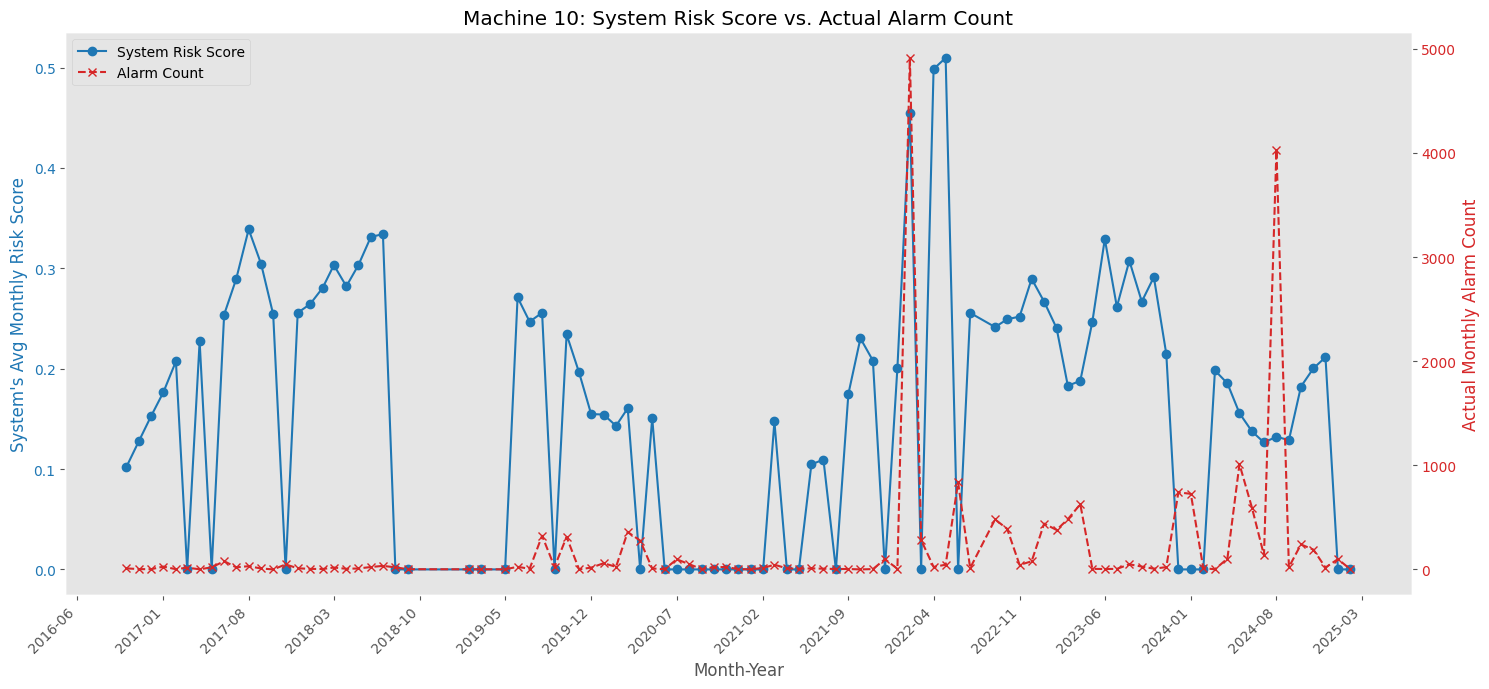

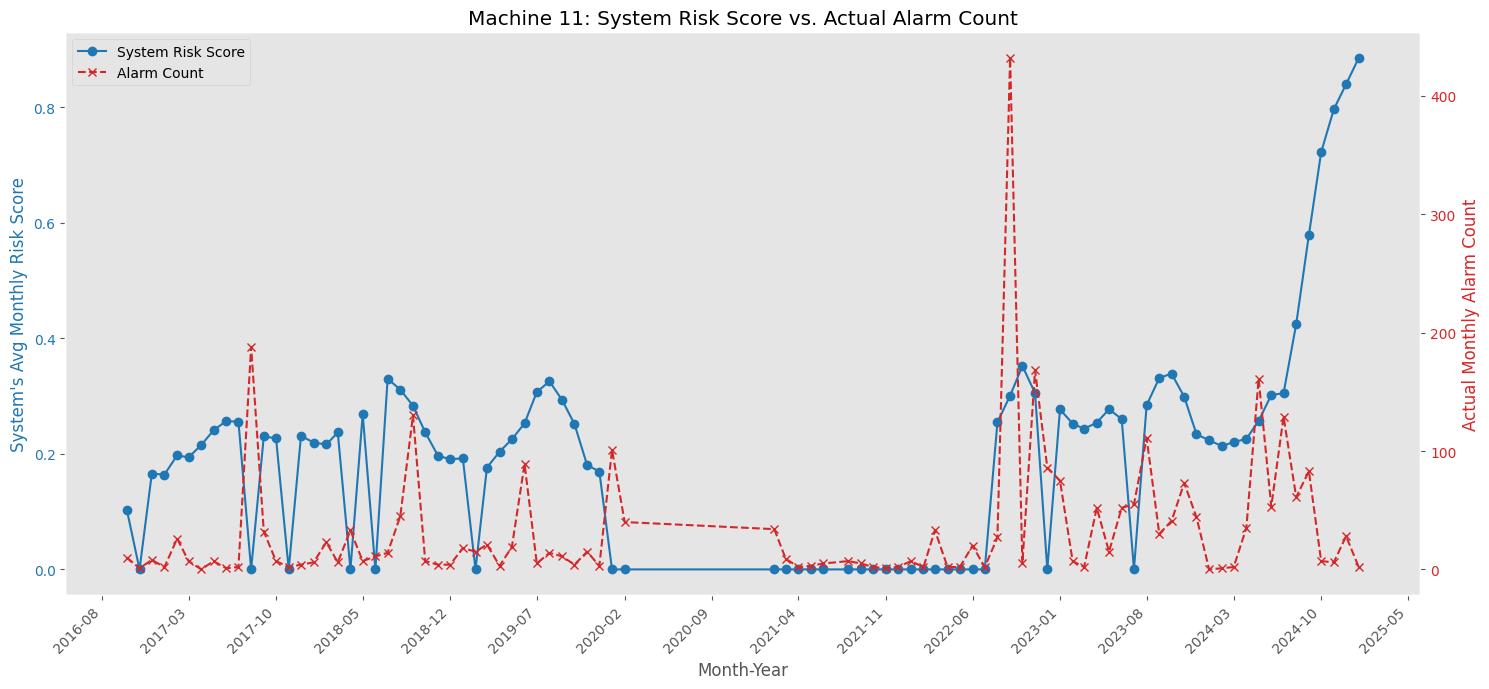

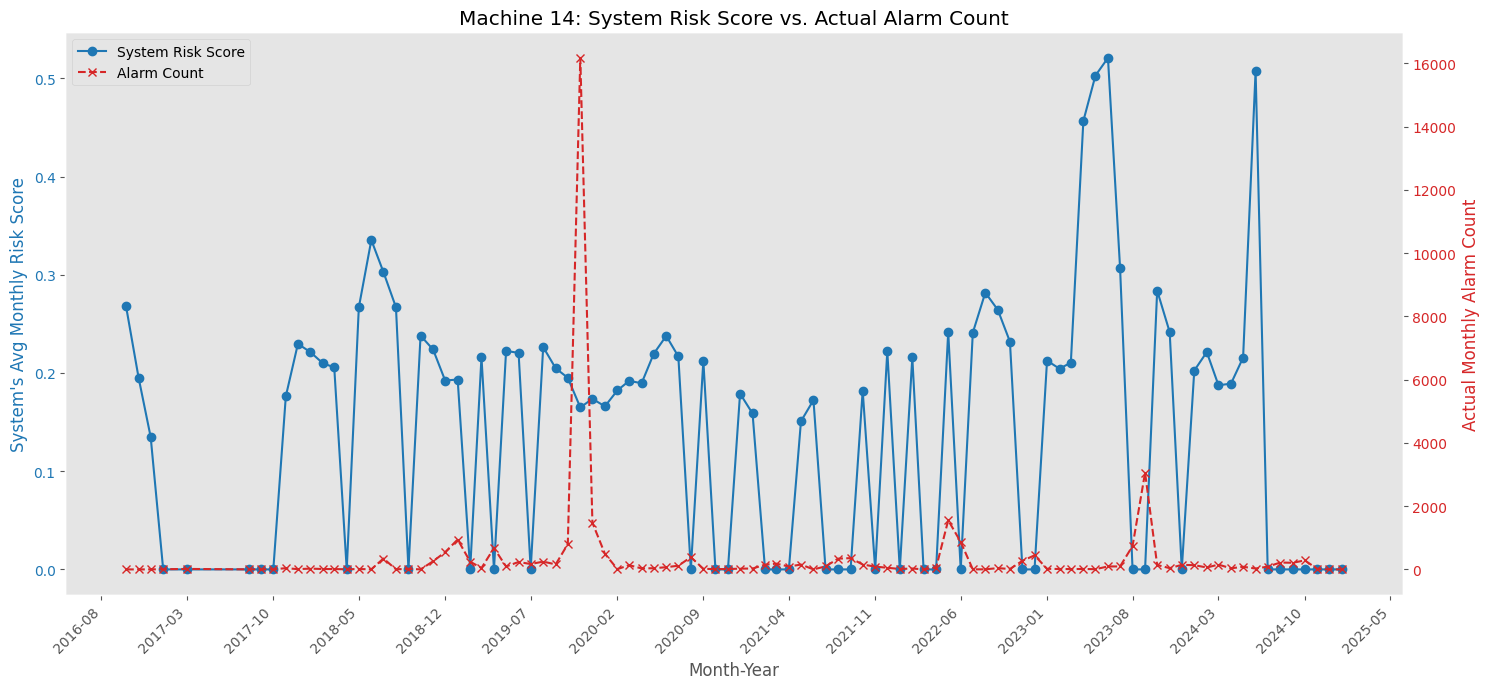

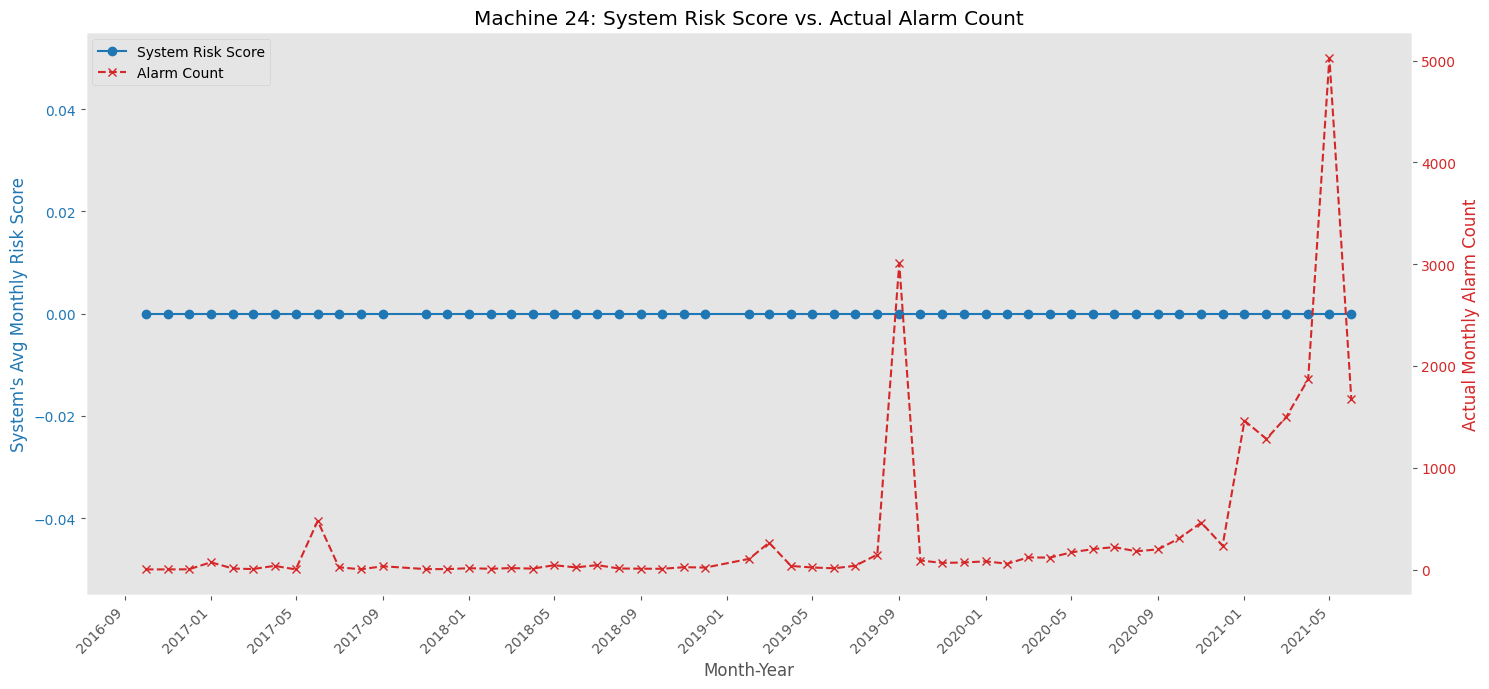

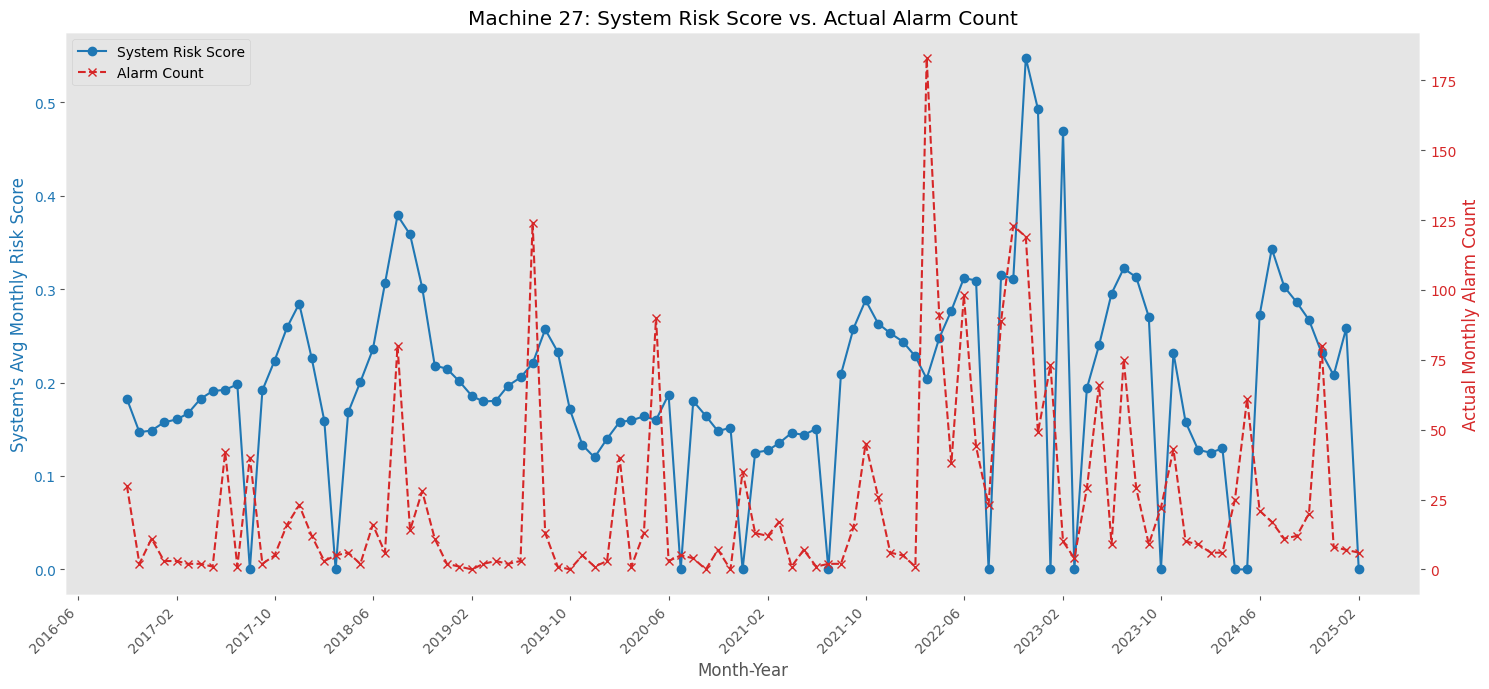


   --- Initial Interpretation Points ---
   - Review the plots above. For each machine, observe if increases in the 'System Risk Score' (blue line)
     tend to precede or coincide with increases in the 'Alarm Count' (red line).
   - A strong leading indication would show the blue line rising *before* the red line spikes.
   - Concurrent rises suggest the system is capturing current distress that also triggers alarms.
   - If the blue line rises but the red line doesn't, it might indicate successful early detection of issues
     that didn't escalate to alarms (or alarms were not relevant/counted).
   - If the red line rises but the blue line doesn't, it indicates misses by our system for those types of alarms.
   - The effectiveness of this validation will heavily depend on whether the 'Actual Monthly Alarm Count'
     is based on alarms truly indicative of the degradation our system is designed to detect.
     (Currently, it's using ALL translated alarms).

📋 Phase 9.2 (Insightful V

In [11]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import warnings

warnings.filterwarnings('ignore')
plt.style.use('ggplot')

print("📋 Phase 9.2 (Insightful Validation): Predictive Health Trend Analysis")
print("=" * 70)

# --- 1. Load Necessary Data ---
# Load alarms_df_filtered (created in Phase 9, Step 1)
# This DataFrame should have 'MachineID', 'ErrorBeginTime', 'AlarmText' etc.
# It's assumed to be in globals from the previous cell or could be reloaded.

if 'windowed_results_with_ground_truth_df_phase9' not in globals() or \
   'alarms_df_filtered' not in globals(): # Check if the df that generated alarms_df_filtered exists
    # Attempt to reload the data that contains alarms_df_filtered if not in globals
    # For simplicity, this example assumes alarms_df_filtered would be re-derived if needed or available.
    # A more robust way would be to save and load alarms_df_filtered itself.
    # For now, we'll try to get it from the full windowed_results if it has it, or raise error.

    # Reloading the result of Phase 9, Step 1 which contains alarms_df_filtered implicitly
    # by re-running a simplified version of its alarm processing if needed.
    # This is complex to reconstruct here. Ideal case: alarms_df_filtered is saved and loaded.
    # For this cell, we'll assume 'alarms_df' (the merged one before filtering) is available or can be loaded
    # And we'll use 'alarms_df' as the source for alarm counts.
    # In a real sequential notebook, 'alarms_df_filtered' would be in globals().
    
    print("   Attempting to use 'alarms_df' (merged error log and translation)...")
    if 'alarms_df' not in globals(): # If even the base merged alarms_df isn't there
        # Fallback: Re-load the saved windowed_results_with_ground_truth to get ground truth flags,
        # then try to re-process alarms. This is becoming too complex for a single cell.
        # Simplest is to ensure 'alarms_df_filtered' is available or re-load its constituents.
        # For this cell, let's assume we need to re-load ErrorLog and AlarmTranslation to make `alarms_df_filtered`
        
        print("   Reloading ErrorLog and AlarmTranslation to create `alarms_df_filtered`...")
        checkpoint_dir_phase9 = Path("anomaly_detection_checkpoints_phase9") # Ensure it's defined
        error_log_path_val = Path("/Users/DINGZEEFS/Royal_pas_reform/notebooks_2/ErrorLog.parquet")
        alarm_translation_path_val = Path("/Users/DINGZEEFS/Royal_pas_reform/notebooks_2/AlarmTranslation.parquet")
        if not alarm_translation_path_val.exists():
            alarm_translation_path_val = Path("/Users/DINGZEEFS/Royal_pas_reform/AlarmTranslation.parquet")

        if not error_log_path_val.exists() or not alarm_translation_path_val.exists():
            raise FileNotFoundError("Cannot find ErrorLog or AlarmTranslation to proceed with this validation.")

        error_log_df_raw_val = pd.read_parquet(error_log_path_val)
        el_rename_map_val = {}
        if '# MachineID' in error_log_df_raw_val.columns: el_rename_map_val['# MachineID'] = 'MachineID'
        if 'StartTimeStamp' in error_log_df_raw_val.columns: el_rename_map_val['StartTimeStamp'] = 'ErrorBeginTime'
        elif '# StartTimeStamp' in error_log_df_raw_val.columns: el_rename_map_val['# StartTimeStamp'] = 'ErrorBeginTime'
        else: raise KeyError("Start time column not found in ErrorLog for validation.")
        # Add other necessary renames for AlarmKeyForMerge etc.
        if 'AlarmID' in error_log_df_raw_val.columns: el_rename_map_val['AlarmID'] = 'AlarmKeyForMerge'
        elif '# AlarmID' in error_log_df_raw_val.columns: el_rename_map_val['# AlarmID'] = 'AlarmKeyForMerge'
        else: raise KeyError("AlarmID/Key column not found in ErrorLog for validation.")
        error_log_df_val = error_log_df_raw_val.rename(columns=el_rename_map_val)
        error_log_df_val['ErrorBeginTime'] = pd.to_datetime(error_log_df_val['ErrorBeginTime'], unit='s', errors='coerce')
        error_log_df_val = error_log_df_val.dropna(subset=['ErrorBeginTime', 'AlarmKeyForMerge'])

        alarm_translation_df_raw_val = pd.read_parquet(alarm_translation_path_val)
        at_rename_map_val = {}
        if '# AlarmNumber' in alarm_translation_df_raw_val.columns: at_rename_map_val['# AlarmNumber'] = 'AlarmKeyForMerge'
        elif 'AlarmNumber' in alarm_translation_df_raw_val.columns: at_rename_map_val['AlarmNumber'] = 'AlarmKeyForMerge'
        else: raise KeyError("AlarmNumber/Key column not found in AlarmTranslation for validation.")
        if 'Engels' in alarm_translation_df_raw_val.columns: at_rename_map_val['Engels'] = 'AlarmText'
        alarm_translation_df_val = alarm_translation_df_raw_val.rename(columns=at_rename_map_val)
        alarm_translation_df_val = alarm_translation_df_val[['AlarmKeyForMerge', 'AlarmText']].dropna(subset=['AlarmKeyForMerge']).drop_duplicates(subset=['AlarmKeyForMerge'])
        
        alarms_df = pd.merge(error_log_df_val, alarm_translation_df_val, on='AlarmKeyForMerge', how='left')
        alarms_df_filtered = alarms_df.copy() # Using all translated alarms
        globals()['alarms_df_filtered'] = alarms_df_filtered # Make it available
        print(f"   ✅ Successfully re-processed and loaded 'alarms_df_filtered' (Shape: {alarms_df_filtered.shape})")
    else: # If alarms_df_filtered is already in globals from previous step
        print(f"   Using 'alarms_df_filtered' from previous step (Shape: {alarms_df_filtered.shape})")


# Load monthly_avg_risk_phase8 (Our system's score per machine per month)
if 'monthly_avg_risk_phase8' in globals():
    print(f"   Using 'monthly_avg_risk_phase8' from global variables (Shape: {monthly_avg_risk_phase8.shape}).")
    system_monthly_risk_df = monthly_avg_risk_phase8.copy()
else:
    print("   Loading 'monthly_avg_risk_phase8' from Parquet file...")
    checkpoint_dir_phase8_val = Path("anomaly_detection_checkpoints_phase8")
    monthly_avg_risk_path_val = checkpoint_dir_phase8_val / "monthly_avg_machine_risk.parquet"
    if not monthly_avg_risk_path_val.exists():
        raise FileNotFoundError(f"monthly_avg_machine_risk.parquet not found at {monthly_avg_risk_path_val}")
    system_monthly_risk_df = pd.read_parquet(monthly_avg_risk_path_val)
    print(f"   ✅ Loaded 'system_monthly_risk_df' (Shape: {system_monthly_risk_df.shape})")

# --- 2. Calculate Actual Alarm Rate per Machine per Month ---
print("\n   Calculating actual monthly alarm counts per machine...")
if 'ErrorBeginTime' not in alarms_df_filtered.columns or 'MachineID' not in alarms_df_filtered.columns:
    raise KeyError("'ErrorBeginTime' or 'MachineID' not found in 'alarms_df_filtered'. Cannot calculate monthly alarm counts.")

# Ensure ErrorBeginTime is datetime
alarms_df_filtered['ErrorBeginTime'] = pd.to_datetime(alarms_df_filtered['ErrorBeginTime'])
alarms_df_filtered['year_month'] = alarms_df_filtered['ErrorBeginTime'].dt.to_period('M')

# Filter for relevant alarms (PLACEHOLDER - USER SHOULD REFINE THIS)
# For now, we are using all alarms in alarms_df_filtered.
# Example of how filtering could be done:
# relevant_keywords = ["temperature", "heating", "cooling", "sensor", "climate", "deviation", "control"]
# relevant_alarms_mask = alarms_df_filtered['AlarmText'].str.contains('|'.join(relevant_keywords), case=False, na=False)
# alarms_to_count_df = alarms_df_filtered[relevant_alarms_mask]
alarms_to_count_df = alarms_df_filtered.copy() # Use all for now as per user's last decision
print(f"   ⚠️ Counting ALL {len(alarms_to_count_df)} translated alarms for monthly rates. Consider filtering for relevance.")


actual_monthly_alarm_counts = alarms_to_count_df.groupby(['MachineID', 'year_month']).size().reset_index(name='actual_monthly_alarm_count')
print(f"   ✅ Calculated actual monthly alarm counts (Shape: {actual_monthly_alarm_counts.shape})")
print(actual_monthly_alarm_counts.head())


# --- 3. Merge System Signal with Actual Alarm Rate ---
print("\n   Merging system's monthly risk scores with actual monthly alarm counts...")
# Ensure 'year_month' in system_monthly_risk_df is also PeriodDtype for merging
if not pd.api.types.is_period_dtype(system_monthly_risk_df['year_month']):
    system_monthly_risk_df['year_month'] = pd.to_datetime(system_monthly_risk_df['year_month']).dt.to_period('M')

# Perform the merge
combined_trends_df = pd.merge(system_monthly_risk_df, actual_monthly_alarm_counts, 
                              on=['MachineID', 'year_month'], how='outer') # Outer merge to keep all months from both

# Fill NaNs: 0 for alarm counts (if no alarms that month), and for risk scores (if no system score)
combined_trends_df['actual_monthly_alarm_count'] = combined_trends_df['actual_monthly_alarm_count'].fillna(0).astype(int)
combined_trends_df['avg_monthly_risk_score'] = combined_trends_df['avg_monthly_risk_score'].fillna(0) # Or interpolate/ffill for system score

# Sort for plotting
combined_trends_df['plot_date'] = combined_trends_df['year_month'].dt.to_timestamp() # For plotting
combined_trends_df = combined_trends_df.sort_values(by=['MachineID', 'plot_date'])

print(f"   ✅ Merged data for trend comparison (Shape: {combined_trends_df.shape})")
print(combined_trends_df.head())


# --- 4. Visualize Comparative Trends ---
print("\n   Visualizing comparative trends for selected machines...")

# Select machines to plot: e.g., top N from Phase 8 prioritization, or high alarm count machines
machines_to_plot = []
if 'prioritization_queue_calendar_phase8' in globals() and not prioritization_queue_calendar_phase8.empty:
    machines_to_plot.extend(prioritization_queue_calendar_phase8['MachineID'].unique()[:3]) # Top 3 from priority queue
# Add some machines with high total alarm counts
high_alarm_machines = actual_monthly_alarm_counts.groupby('MachineID')['actual_monthly_alarm_count'].sum().nlargest(3).index.tolist()
machines_to_plot.extend(high_alarm_machines)
machines_to_plot = sorted(list(set(machines_to_plot))) # Unique and sorted

if not machines_to_plot: # Fallback if no priority queue or high alarm machines
    machines_to_plot = combined_trends_df['MachineID'].unique()[:min(3, len(combined_trends_df['MachineID'].unique()))].tolist()


print(f"   Selected MachineIDs for plotting: {machines_to_plot}")

for machine_id in machines_to_plot:
    machine_data = combined_trends_df[combined_trends_df['MachineID'] == machine_id]
    if machine_data.empty:
        print(f"    No combined trend data for Machine {machine_id}. Skipping plot.")
        continue
    if len(machine_data) < 2:
        print(f"    Not enough data points for Machine {machine_id} to plot a trend. Skipping plot.")
        continue

    fig, ax1 = plt.subplots(figsize=(15, 7))
    
    # Plot System's Average Monthly Risk Score (Left Y-axis)
    color_system = 'tab:blue'
    ax1.set_xlabel('Month-Year')
    ax1.set_ylabel("System's Avg Monthly Risk Score", color=color_system)
    ax1.plot(machine_data['plot_date'], machine_data['avg_monthly_risk_score'], color=color_system, marker='o', linestyle='-', label="System Risk Score")
    ax1.tick_params(axis='y', labelcolor=color_system)
    ax1.grid(False) # Avoid double grid
    
    # Create a second Y-axis for Actual Monthly Alarm Count
    ax2 = ax1.twinx() 
    color_alarms = 'tab:red'
    ax2.set_ylabel('Actual Monthly Alarm Count', color=color_alarms)
    ax2.plot(machine_data['plot_date'], machine_data['actual_monthly_alarm_count'], color=color_alarms, marker='x', linestyle='--', label="Alarm Count")
    ax2.tick_params(axis='y', labelcolor=color_alarms)
    ax2.grid(False)

    # Formatting for X-axis (Dates)
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    # Dynamically set major locator interval based on data range
    num_months = len(machine_data['plot_date'].unique())
    interval = max(1, num_months // 12) # Aim for roughly 12 ticks or at least 1 per month
    ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=interval))
    fig.autofmt_xdate(rotation=45) # Auto-rotate dates

    plt.title(f'Machine {machine_id}: System Risk Score vs. Actual Alarm Count')
    # Add legends - get handles and labels from both axes
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper left')
    
    fig.tight_layout() # Otherwise the right y-label is slightly clipped
    plt.show()

# --- 5. Initial Interpretation (Discussion) ---
# This part would be textual discussion based on the plots.
print("\n   --- Initial Interpretation Points ---")
print("   - Review the plots above. For each machine, observe if increases in the 'System Risk Score' (blue line)")
print("     tend to precede or coincide with increases in the 'Alarm Count' (red line).")
print("   - A strong leading indication would show the blue line rising *before* the red line spikes.")
print("   - Concurrent rises suggest the system is capturing current distress that also triggers alarms.")
print("   - If the blue line rises but the red line doesn't, it might indicate successful early detection of issues")
print("     that didn't escalate to alarms (or alarms were not relevant/counted).")
print("   - If the red line rises but the blue line doesn't, it indicates misses by our system for those types of alarms.")
print("   - The effectiveness of this validation will heavily depend on whether the 'Actual Monthly Alarm Count'")
print("     is based on alarms truly indicative of the degradation our system is designed to detect.")
print("     (Currently, it's using ALL translated alarms).")


print("\n" + "="*70)
print("📋 Phase 9.2 (Insightful Validation) Complete.")
print("   Next: Formal summary tables (Phase 9.1 if still desired) and then Phase 10.")
print("=" * 70)

# Store combined_trends_df for potential further analysis or use in Phase 10
globals()['combined_machine_trends_df_phase9'] = combined_trends_df


📋 Phase 9.2 (Insightful Validation): Predictive Health Trend Analysis
   Using existing 'alarms_df_filtered' (Shape: (315174, 9))
   Using 'monthly_avg_risk_phase8' (Shape: (2285, 6))

   Calculating actual monthly alarm counts per machine...
   ✅ Filtered relevant alarms: 27845 of 315174 total.
   ✅ Calculated actual monthly alarm counts (Shape: (3446, 3))
   MachineID year_month  actual_monthly_alarm_count
0          1    2017-04                           3
1          1    2017-05                           4
2          1    2017-06                           3
3          1    2017-07                          15
4          1    2017-09                           3

   Merging system's monthly risk scores with actual monthly alarm counts...
   ✅ Merged data for trend comparison (Shape: (4293, 7))
   MachineID year_month  avg_monthly_risk_score  prev_month_risk_score  \
0          1    2016-10                0.163420                    NaN   
1          1    2016-11                0.16640

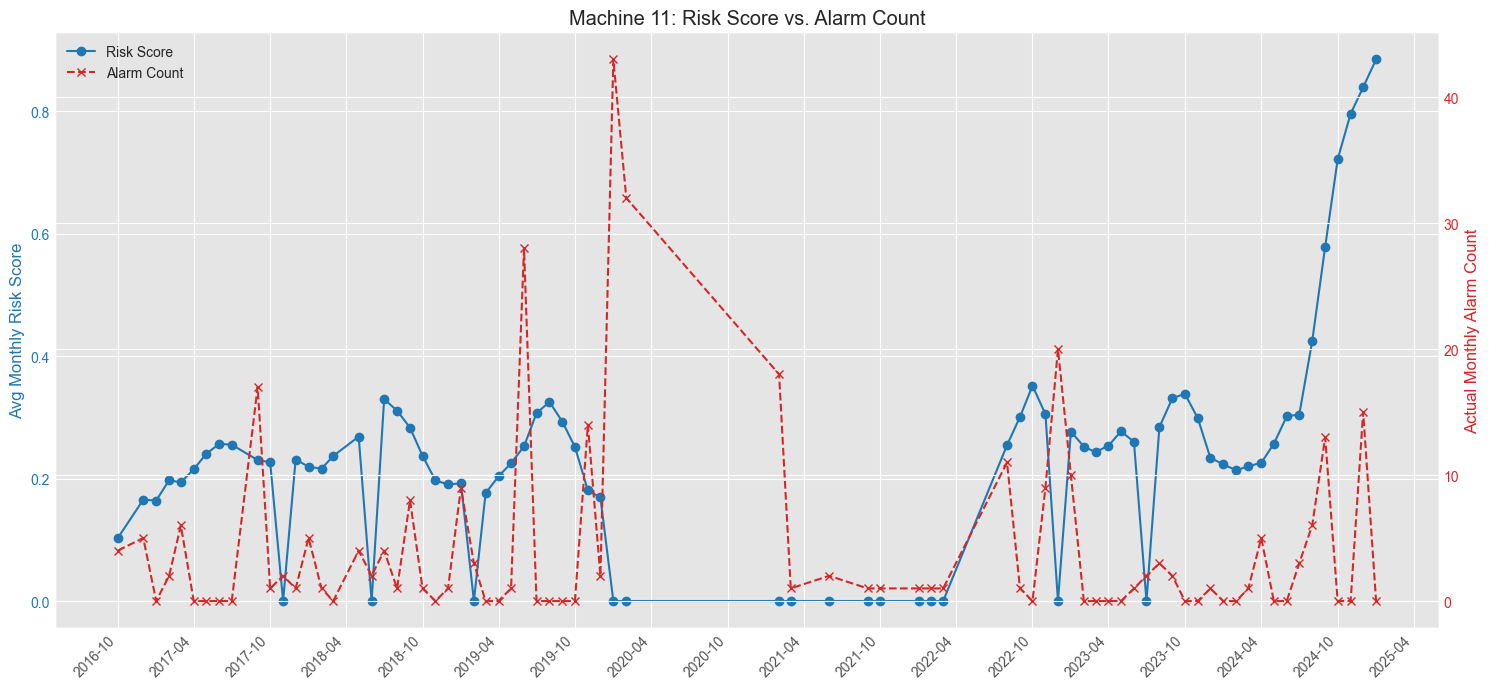

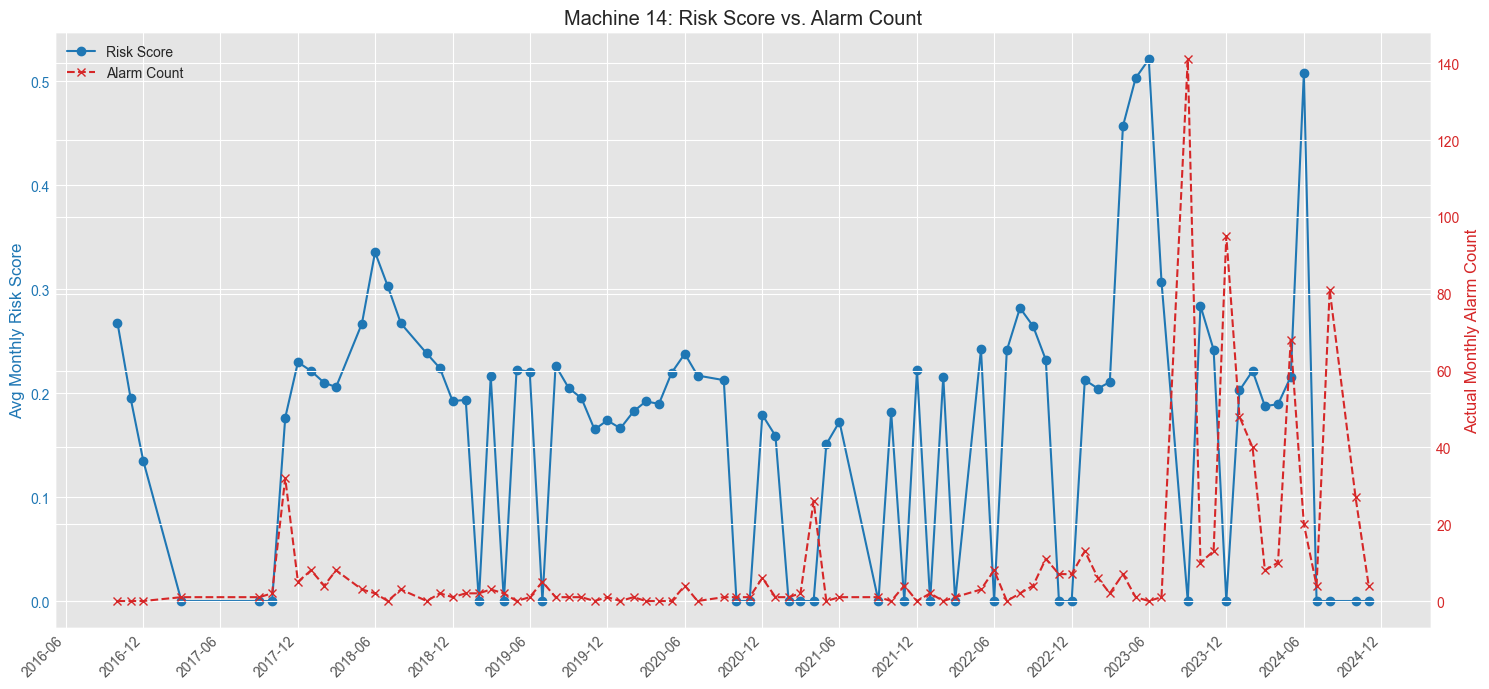

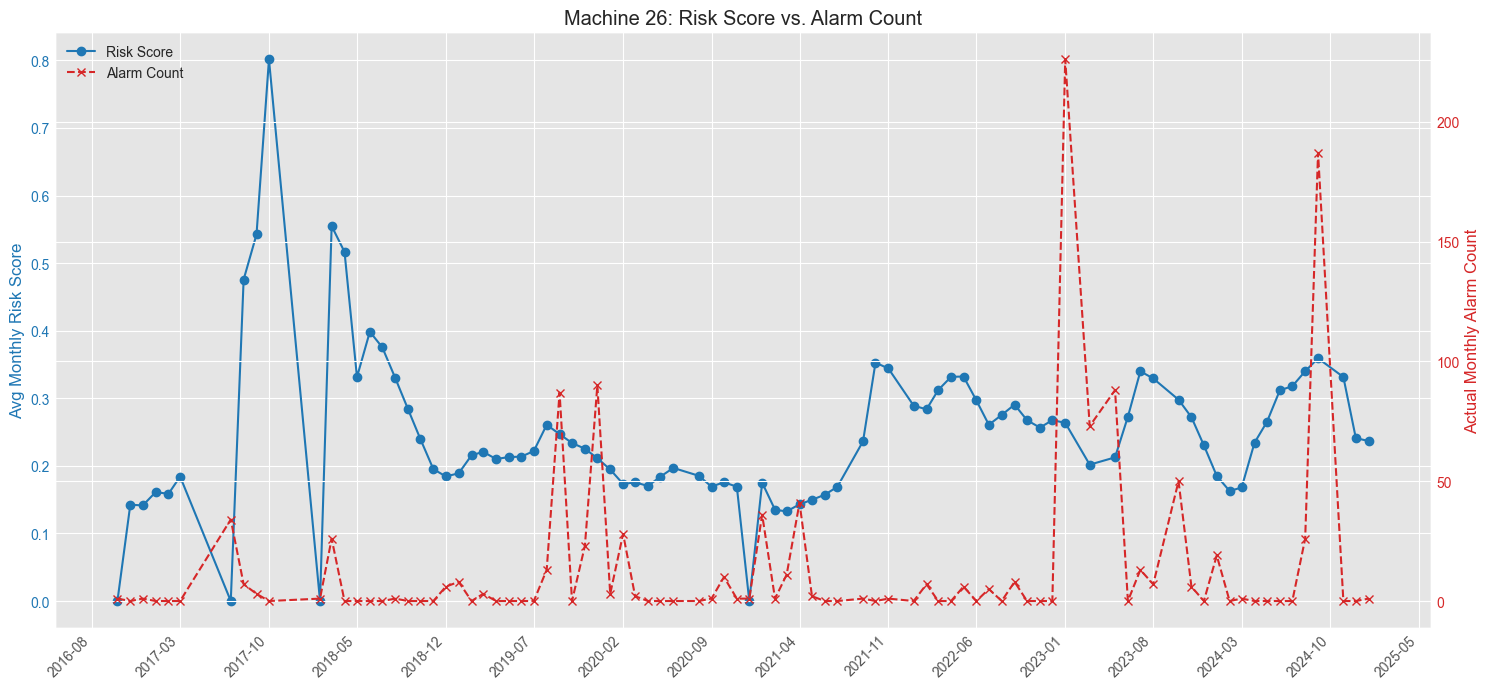

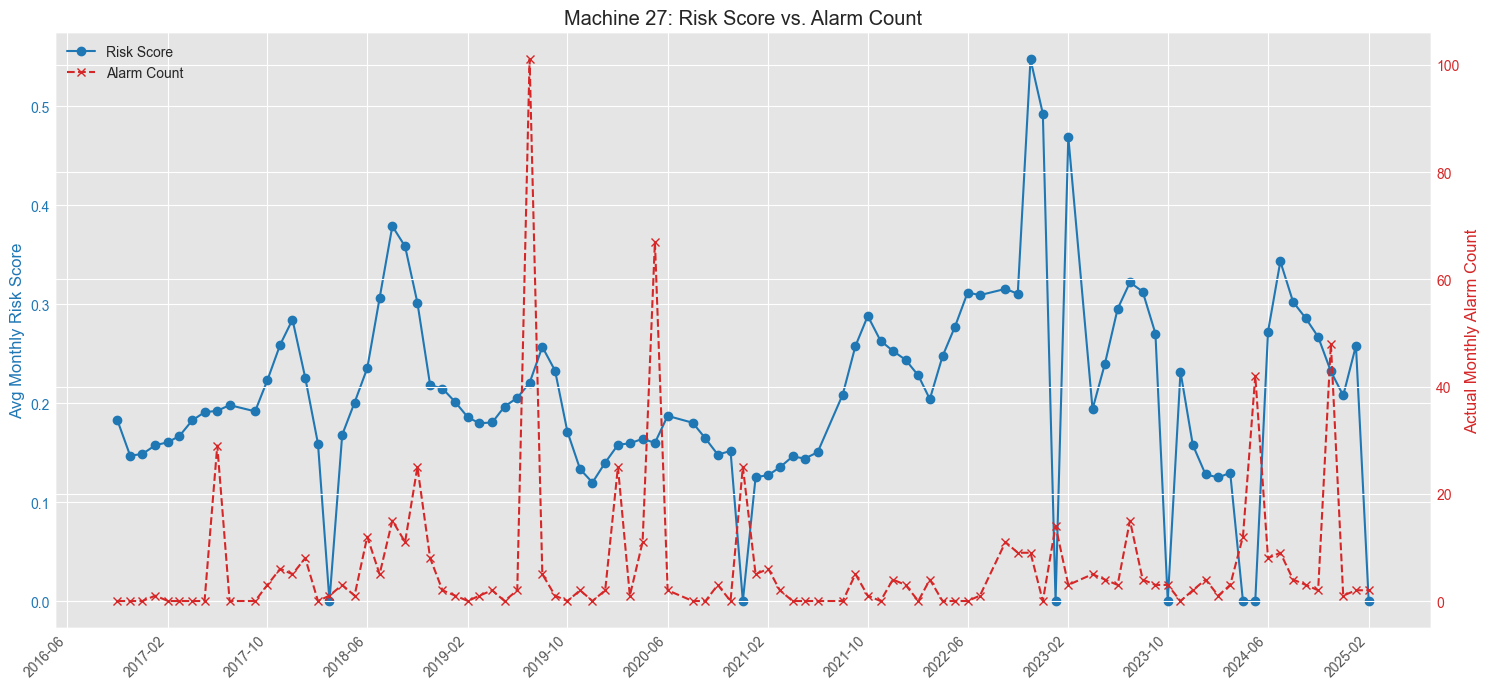

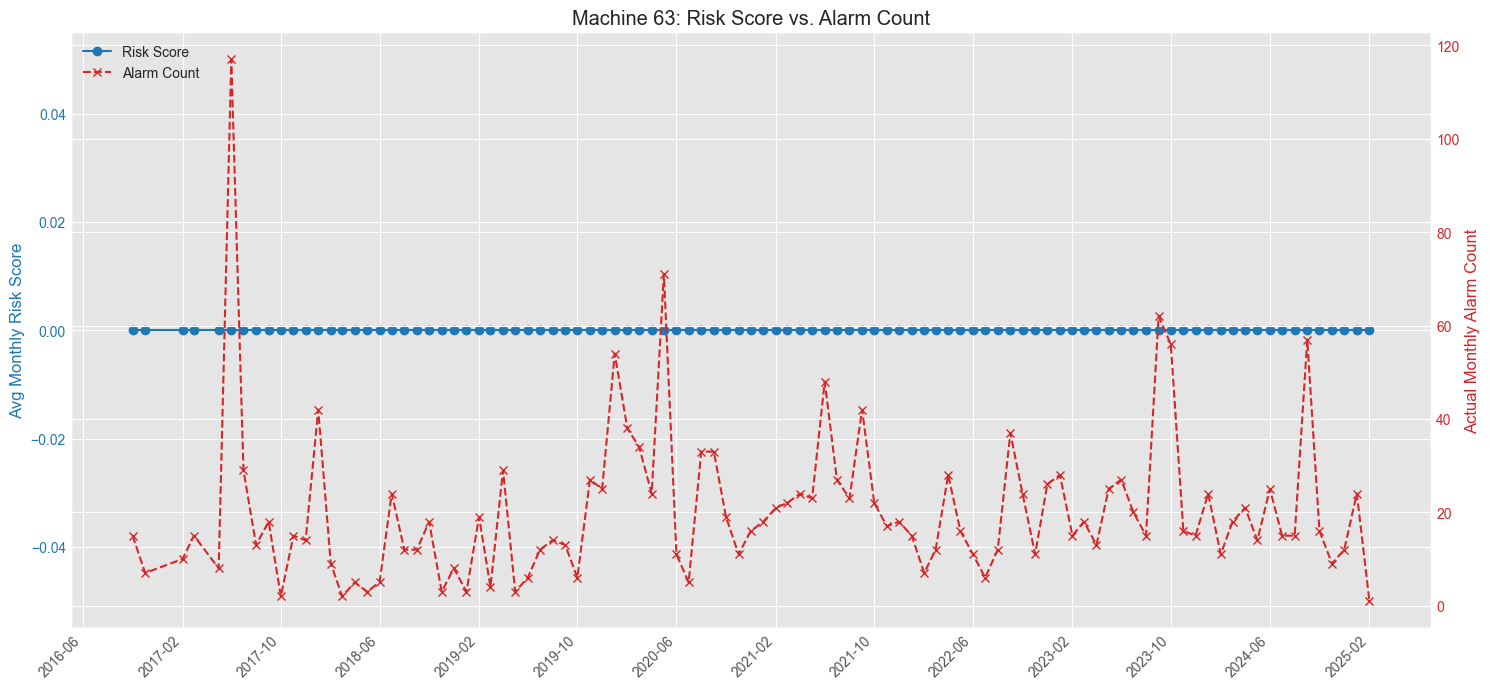


📋 Phase 9.2 (Insightful Validation) Complete. `combined_machine_trends_df_phase9` is updated.


In [13]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import warnings
import re

warnings.filterwarnings('ignore')
plt.style.use('ggplot')

print("📋 Phase 9.2 (Insightful Validation): Predictive Health Trend Analysis")
print("=" * 70)

# --- 1. Load alarms_df_filtered (create if missing) ---
if 'alarms_df_filtered' not in globals():
    # Fallback to reprocessing ErrorLog and AlarmTranslation
    print("   Reloading ErrorLog and AlarmTranslation to create `alarms_df_filtered`...")
    error_log_path = Path("/Users/DINGZEEFS/Royal_pas_reform/notebooks_2/ErrorLog.parquet")
    alarm_translation_path = Path("/Users/DINGZEEFS/Royal_pas_reform/notebooks_2/AlarmTranslation.parquet")
    if not alarm_translation_path.exists():
        alarm_translation_path = Path("AlarmTranslation.parquet")
    error_log_df_raw = pd.read_parquet(error_log_path)
    alarm_translation_df_raw = pd.read_parquet(alarm_translation_path)

    # Rename columns
    el_map = {}
    if '# MachineID' in error_log_df_raw: el_map['# MachineID'] = 'MachineID'
    if 'StartTimeStamp' in error_log_df_raw: el_map['StartTimeStamp'] = 'ErrorBeginTime'
    elif '# StartTimeStamp' in error_log_df_raw: el_map['# StartTimeStamp'] = 'ErrorBeginTime'
    if 'AlarmID' in error_log_df_raw: el_map['AlarmID'] = 'AlarmKeyForMerge'
    elif '# AlarmID' in error_log_df_raw: el_map['# AlarmID'] = 'AlarmKeyForMerge'
    error_log_df = error_log_df_raw.rename(columns=el_map)
    error_log_df['ErrorBeginTime'] = pd.to_datetime(error_log_df['ErrorBeginTime'], unit='s', errors='coerce')
    error_log_df = error_log_df.dropna(subset=['ErrorBeginTime','AlarmKeyForMerge'])

    at_map = {}
    if '# AlarmNumber' in alarm_translation_df_raw: at_map['# AlarmNumber'] = 'AlarmKeyForMerge'
    elif 'AlarmNumber' in alarm_translation_df_raw: at_map['AlarmNumber'] = 'AlarmKeyForMerge'
    if 'Engels' in alarm_translation_df_raw: at_map['Engels'] = 'AlarmText'
    alarm_translation_df = alarm_translation_df_raw.rename(columns=at_map)[['AlarmKeyForMerge','AlarmText']].dropna().drop_duplicates()
    
    alarms_df_filtered = pd.merge(error_log_df, alarm_translation_df, on='AlarmKeyForMerge', how='left')
    globals()['alarms_df_filtered'] = alarms_df_filtered
    print(f"   ✅ Created 'alarms_df_filtered' (Shape: {alarms_df_filtered.shape})")
else:
    print(f"   Using existing 'alarms_df_filtered' (Shape: {alarms_df_filtered.shape})")

# --- 2. Load system monthly risk scores ---
if 'monthly_avg_risk_phase8' in globals():
    system_monthly_risk_df = monthly_avg_risk_phase8.copy()
    print(f"   Using 'monthly_avg_risk_phase8' (Shape: {system_monthly_risk_df.shape})")
else:
    checkpoint_dir_phase8 = Path("anomaly_detection_checkpoints_phase8")
    monthly_avg_risk_path = checkpoint_dir_phase8 / "monthly_avg_machine_risk.parquet"
    system_monthly_risk_df = pd.read_parquet(monthly_avg_risk_path)
    print(f"   ✅ Loaded 'system_monthly_risk_df' (Shape: {system_monthly_risk_df.shape})")

# --- 3. Calculate actual monthly alarm counts per machine with critical‐alarm filtering ---
print("\n   Calculating actual monthly alarm counts per machine...")

# Ensure timestamp and extract year_month
alarms_df_filtered['ErrorBeginTime'] = pd.to_datetime(alarms_df_filtered['ErrorBeginTime'])
alarms_df_filtered['year_month'] = alarms_df_filtered['ErrorBeginTime'].dt.to_period('M')

# Define critical alarm phrases
CRITICAL_ALARM_NAMES = [
    "RTC slow error", "sensor error", "diagnose error", "Temperature high error",
    "Temperature low error", "Fan alarm", "Incubation program lost",
    "Emergency stop", "setpoints lost", "stack overflow", "program lost warning",
    "Temperature low warning (sector 1 – 6)", "Temperature high warning (sector 1 – 6)",
    "Temperature increase low warning (sector 1 – 6)", "Temperature decrease low warning (sector 1 – 6)",
    "Pulsator RPM warning (sector 1 – 6)", "Pulsator Vbelt warning (sector 1 – 6)",
    "Pulsator diagnose warning (sector 1 – 6)", "Pulsator motor warning (sector 1 – 6)",
    "Pulsator started warning (sector 1 – 6)", "CO2 low warning", "CO2 high warning",
    "CO2 sensor warning", "Humidity low warning", "Humidity high warning",
    "Humidity increase low warning", "Valve low warning", "Valve high warning",
    "Turning no‐start warning", "Turning no‐arrival warning", "Turning position warning",
    "Turning extra‐sensor warning", "Fan warning", "Check fans warning", "Timer warning",
    "Emergency stop warning", "RS422 connection lost warning", "Sensor warning",
    "Diagnose warning", "Vref warning", "I2C warning", "Stack overflow warning",
    "SP database warning", "Power failure warning", "Program lost warning",
    "Errors / Alarms", "Turning relais error", "Temperature sensor error (sector 1 – 6)",
    "Humidity sensor error", "Pulsator RPM error (sector 1 – 6)", "Pulsator Vbelt error (sector 1 – 6)",
    "Pulsator diagnose error (sector 1 – 5)", "Pulsator started error (sector 6)",
    "Temperature low error (sector 1 – 6)", "Temperature high error (sector 1 – 6)",
    "Increase temperature low error (sector 1 – 6)", "Decrease temperature low error (sector 1 – 6)",
    "CO2 low", "CO2 high", "CO2 sensor error", "Humidity low", "Humidity high",
    "Increase humidity low", "Valve low", "Valve high", "No turning start",
    "No turning arrival", "Turning position error", "Turning extra‐sensor error",
    "Temperature low error", "Temperature high error", "Fan alarm", "Check fan error"
]
# Build regex pattern and filter
pattern = "|".join(re.escape(name) for name in CRITICAL_ALARM_NAMES)
relevant_mask = alarms_df_filtered['AlarmText'].str.contains(pattern, case=False, na=False)
alarms_to_count_df = alarms_df_filtered[relevant_mask].copy()
print(f"   ✅ Filtered relevant alarms: {len(alarms_to_count_df)} of {len(alarms_df_filtered)} total.")

# Count per MachineID, year_month
actual_monthly_alarm_counts = (
    alarms_to_count_df
      .groupby(['MachineID','year_month'])
      .size()
      .reset_index(name='actual_monthly_alarm_count')
)
print(f"   ✅ Calculated actual monthly alarm counts (Shape: {actual_monthly_alarm_counts.shape})")
print(actual_monthly_alarm_counts.head())

# --- 4. Merge system risk and alarm counts ---
print("\n   Merging system's monthly risk scores with actual monthly alarm counts...")

# Ensure period dtype on risk df
if not pd.api.types.is_period_dtype(system_monthly_risk_df['year_month']):
    system_monthly_risk_df['year_month'] = pd.to_datetime(system_monthly_risk_df['year_month']).dt.to_period('M')

combined_trends_df = pd.merge(
    system_monthly_risk_df,
    actual_monthly_alarm_counts,
    on=['MachineID','year_month'],
    how='outer'
)

combined_trends_df['actual_monthly_alarm_count'] = combined_trends_df['actual_monthly_alarm_count'].fillna(0).astype(int)
combined_trends_df['avg_monthly_risk_score'] = combined_trends_df['avg_monthly_risk_score'].fillna(0)

combined_trends_df['plot_date'] = combined_trends_df['year_month'].dt.to_timestamp()
combined_trends_df = combined_trends_df.sort_values(by=['MachineID','plot_date'])

print(f"   ✅ Merged data for trend comparison (Shape: {combined_trends_df.shape})")
print(combined_trends_df.head())

# --- 5. Visualize comparative trends ---
print("\n   Visualizing comparative trends for selected machines...")

# Select machines (top priority + highest alarms)
machines_to_plot = []
if 'prioritization_queue_calendar_phase8' in globals() and not prioritization_queue_calendar_phase8.empty:
    machines_to_plot.extend(prioritization_queue_calendar_phase8['MachineID'].unique()[:3])
high_alarm = actual_monthly_alarm_counts.groupby('MachineID')['actual_monthly_alarm_count'].sum().nlargest(3).index.tolist()
machines_to_plot.extend(high_alarm)
machines_to_plot = sorted(set(machines_to_plot))
if not machines_to_plot:
    machines_to_plot = combined_trends_df['MachineID'].unique()[:3].tolist()

print(f"   Selected MachineIDs for plotting: {machines_to_plot}")

for mid in machines_to_plot:
    dfm = combined_trends_df[combined_trends_df['MachineID']==mid]
    if dfm.empty or len(dfm)<2:
        print(f"    Skipping Machine {mid} (insufficient data).")
        continue
    fig, ax1 = plt.subplots(figsize=(15,7))
    color1 = 'tab:blue'
    ax1.plot(dfm['plot_date'], dfm['avg_monthly_risk_score'], color=color1, marker='o', label="Risk Score")
    ax1.set_ylabel("Avg Monthly Risk Score", color=color1); ax1.tick_params(axis='y', labelcolor=color1)
    ax2 = ax1.twinx()
    color2 = 'tab:red'
    ax2.plot(dfm['plot_date'], dfm['actual_monthly_alarm_count'], color=color2, marker='x', linestyle='--', label="Alarm Count")
    ax2.set_ylabel("Actual Monthly Alarm Count", color=color2); ax2.tick_params(axis='y', labelcolor=color2)
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    num_months = len(dfm['plot_date'])
    interval = max(1, num_months//12)
    ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=interval))
    fig.autofmt_xdate(rotation=45)
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines+lines2, labels+labels2, loc='upper left')
    plt.title(f"Machine {mid}: Risk Score vs. Alarm Count")
    plt.tight_layout()
    plt.show()

# --- 6. Save for cross-correlation ---
globals()['combined_machine_trends_df_phase9'] = combined_trends_df
print("\n" + "="*70)
print("📋 Phase 9.2 (Insightful Validation) Complete. `combined_machine_trends_df_phase9` is updated.")
print("=" * 70)

🔬 PHASE 9.3 (Refined Validation): Cross-Correlation Analysis with Critical Alarms
📋 Goal: Quantify lead/lag relationship using ONLY critical alarms as ground truth.

✅ Using refined 'combined_machine_trends_df_phase9' (Shape: (4293, 7))
   Analyzing 15 machines for cross-correlation patterns...

--- Analyzing MachineID: 1 ---
   Max correlation: 0.253 at lag 8 months.
      ✅ POSITIVE LEAD: Risk score leads critical alarms by 8 months.


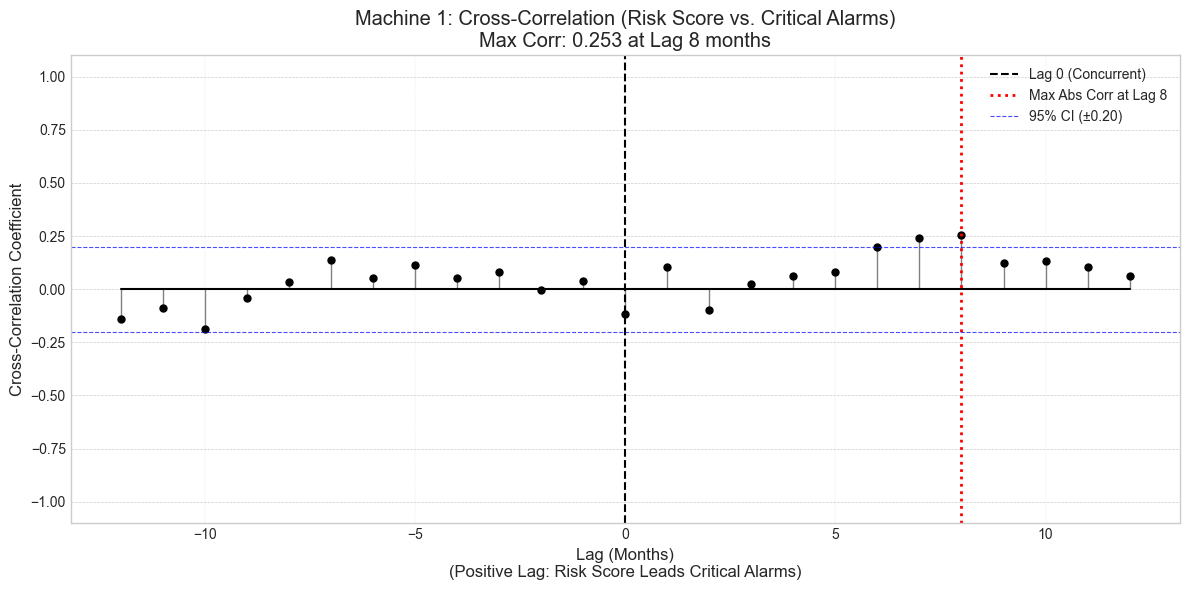


--- Analyzing MachineID: 4 ---
   Skipping MachineID 4 due to insufficient data points (found 6, need 13).

--- Analyzing MachineID: 6 ---
   Max correlation: -0.305 at lag 10 months.
      ✅ POSITIVE LEAD: Risk score leads critical alarms by 10 months.


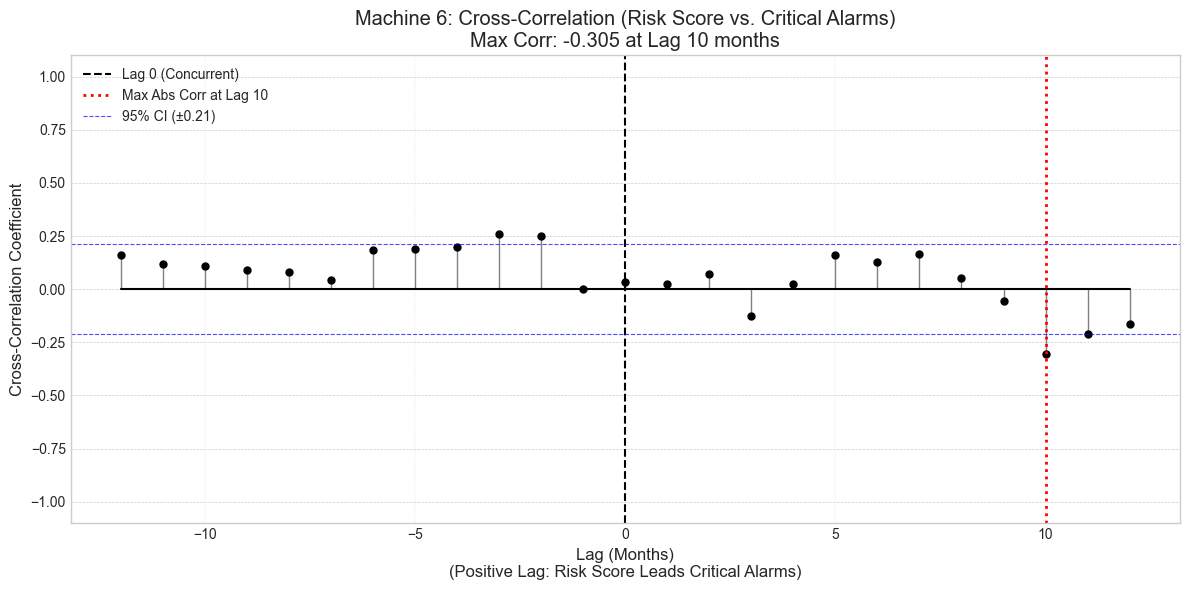


--- Analyzing MachineID: 7 ---
   Max correlation: 0.219 at lag 10 months.
      ✅ POSITIVE LEAD: Risk score leads critical alarms by 10 months.


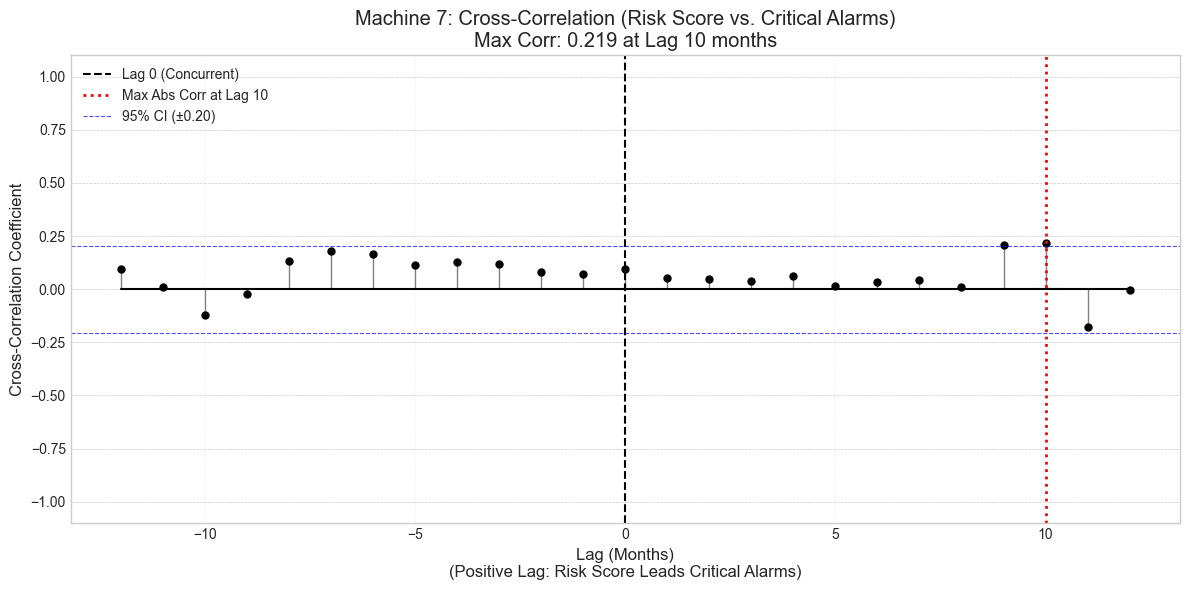


--- Analyzing MachineID: 8 ---
   Max correlation: 0.260 at lag -10 months.
      ⚠️  LAGGING: Critical alarms lead risk score by 10 months.


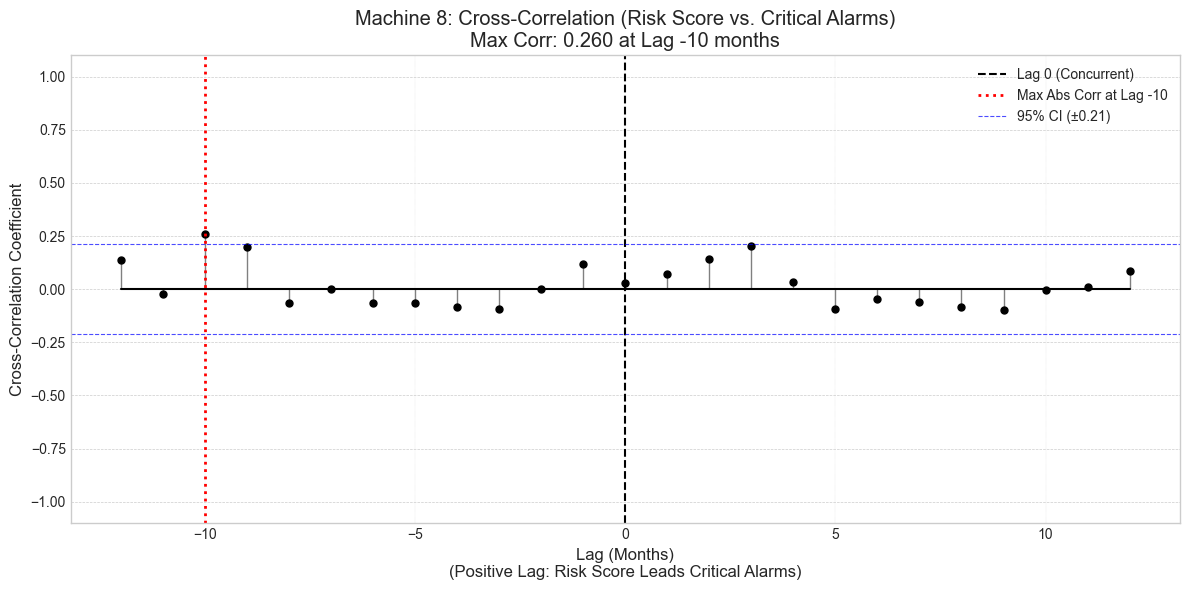


--- Analyzing MachineID: 9 ---
   Max correlation: -0.201 at lag 4 months.
      ✅ POSITIVE LEAD: Risk score leads critical alarms by 4 months.


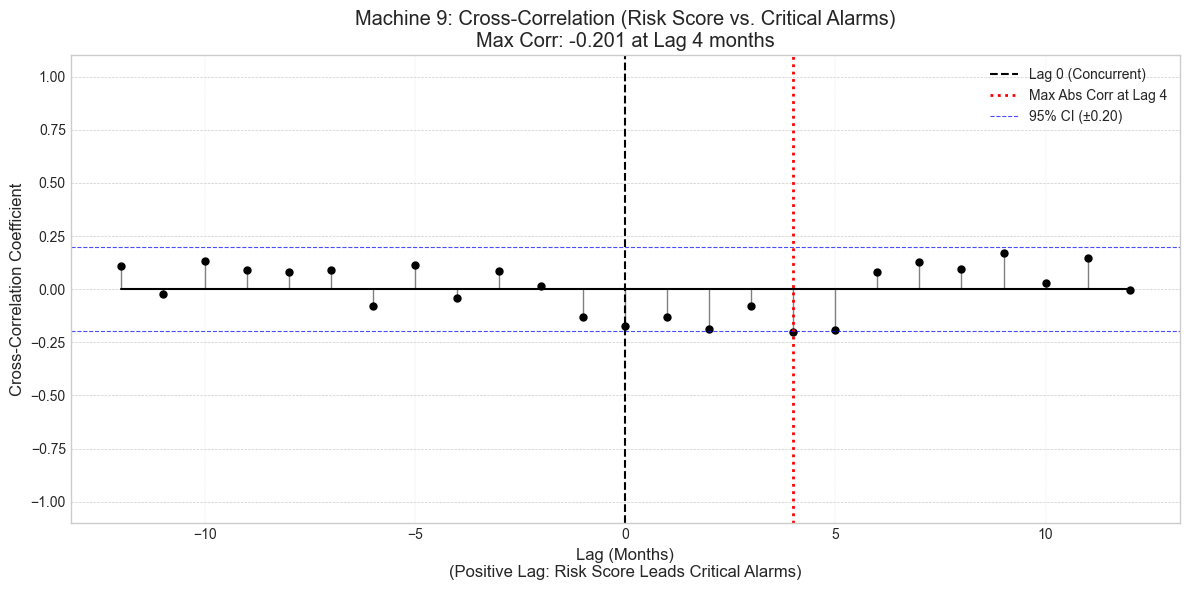


--- Analyzing MachineID: 10 ---
   Max correlation: 0.248 at lag -2 months.
      ⚠️  LAGGING: Critical alarms lead risk score by 2 months.


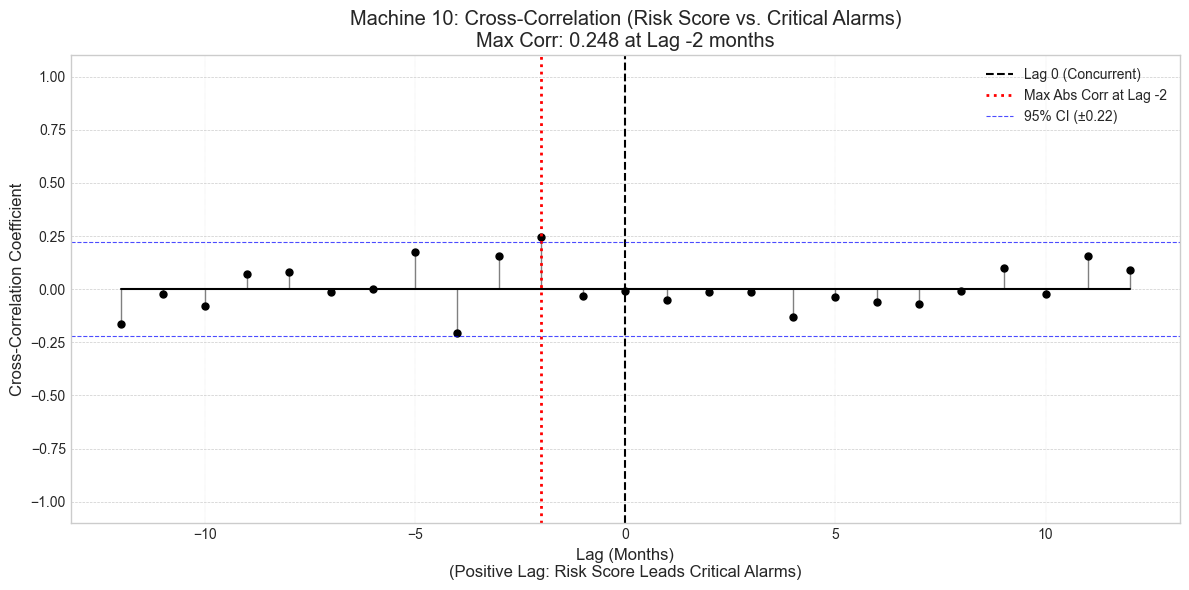


--- Analyzing MachineID: 11 ---
   Max correlation: -0.328 at lag 7 months.
      ✅ POSITIVE LEAD: Risk score leads critical alarms by 7 months.


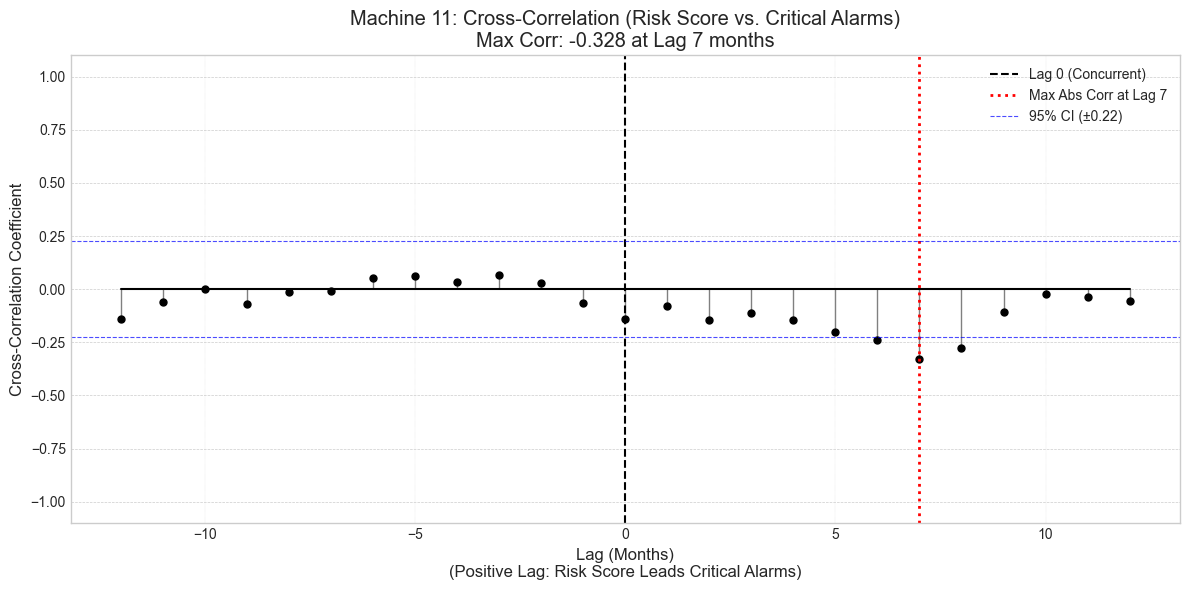


--- Analyzing MachineID: 12 ---
   Max correlation: -0.218 at lag -6 months.
      ⚠️  LAGGING: Critical alarms lead risk score by 6 months.


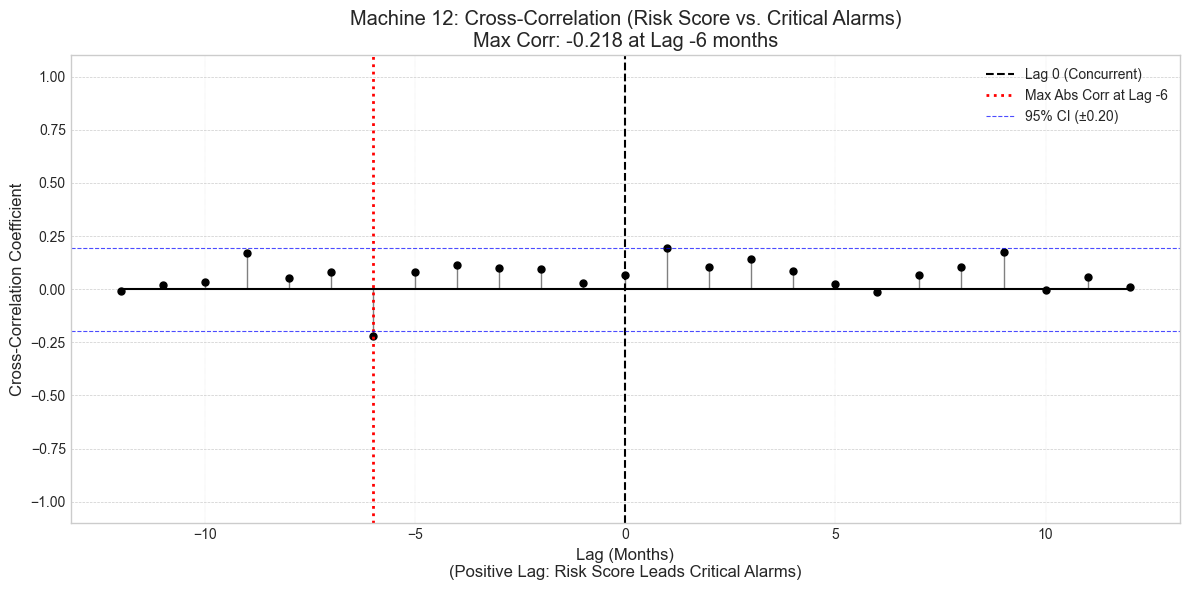


--- Analyzing MachineID: 13 ---
   Max correlation: -0.202 at lag -3 months.
      ⚠️  LAGGING: Critical alarms lead risk score by 3 months.


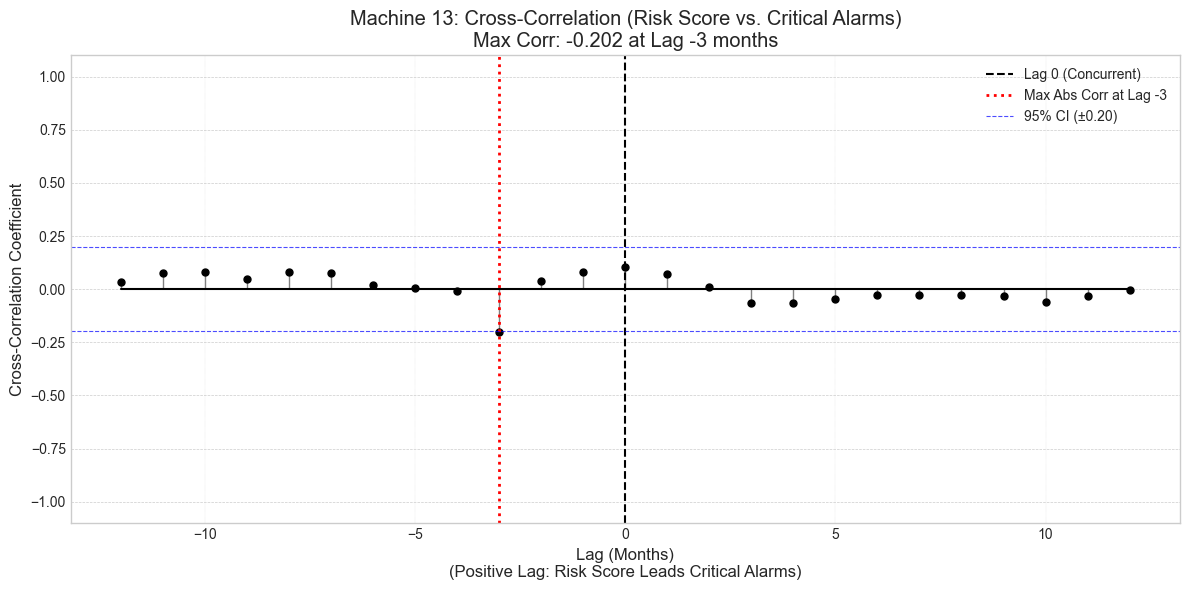


--- Analyzing MachineID: 14 ---
   Max correlation: 0.315 at lag -7 months.
      ⚠️  LAGGING: Critical alarms lead risk score by 7 months.


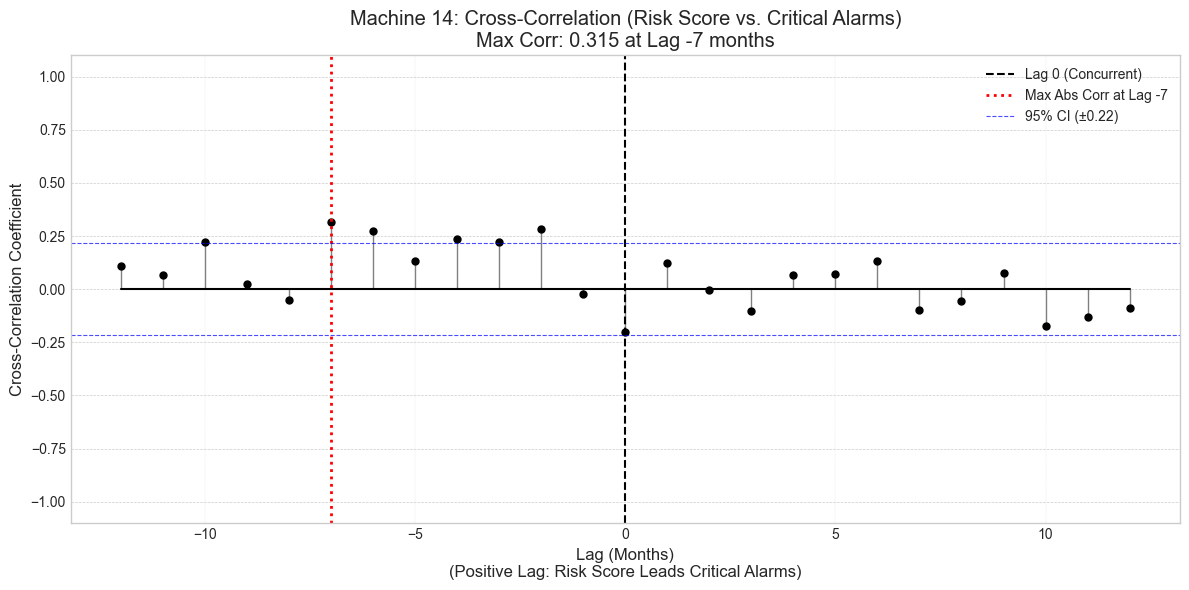


--- Analyzing MachineID: 15 ---
   Max correlation: -0.227 at lag 1 months.
      ✅ POSITIVE LEAD: Risk score leads critical alarms by 1 months.


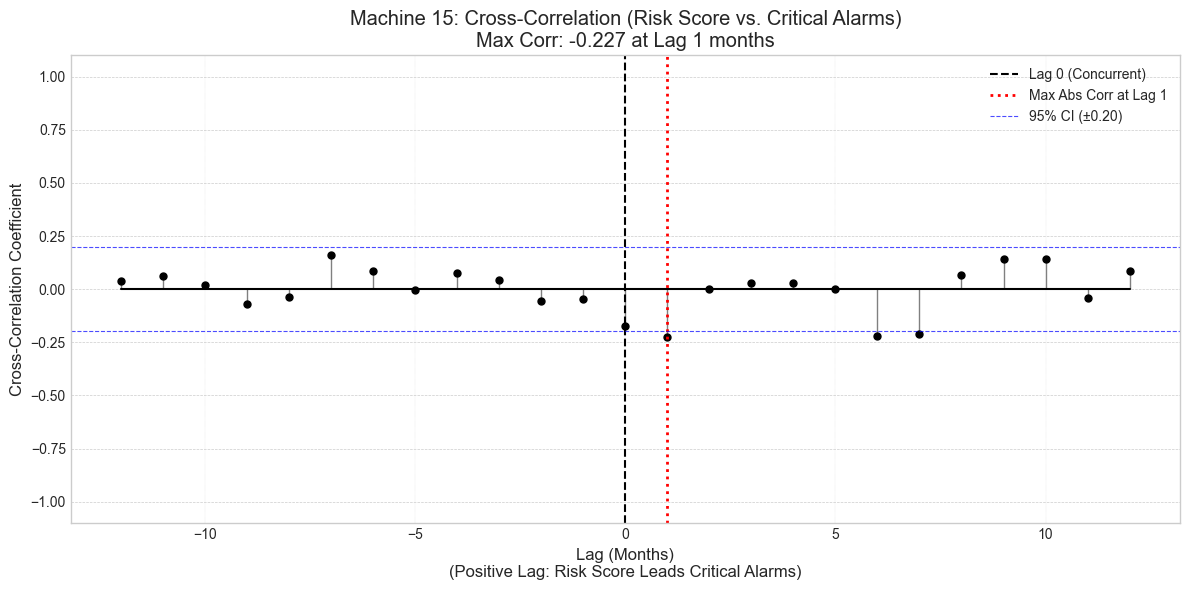


--- Analyzing MachineID: 16 ---
   Max correlation: -0.189 at lag -12 months.
      ⚠️  LAGGING: Critical alarms lead risk score by 12 months.

--- Analyzing MachineID: 17 ---
   Max correlation: 0.208 at lag 5 months.
      ✅ POSITIVE LEAD: Risk score leads critical alarms by 5 months.


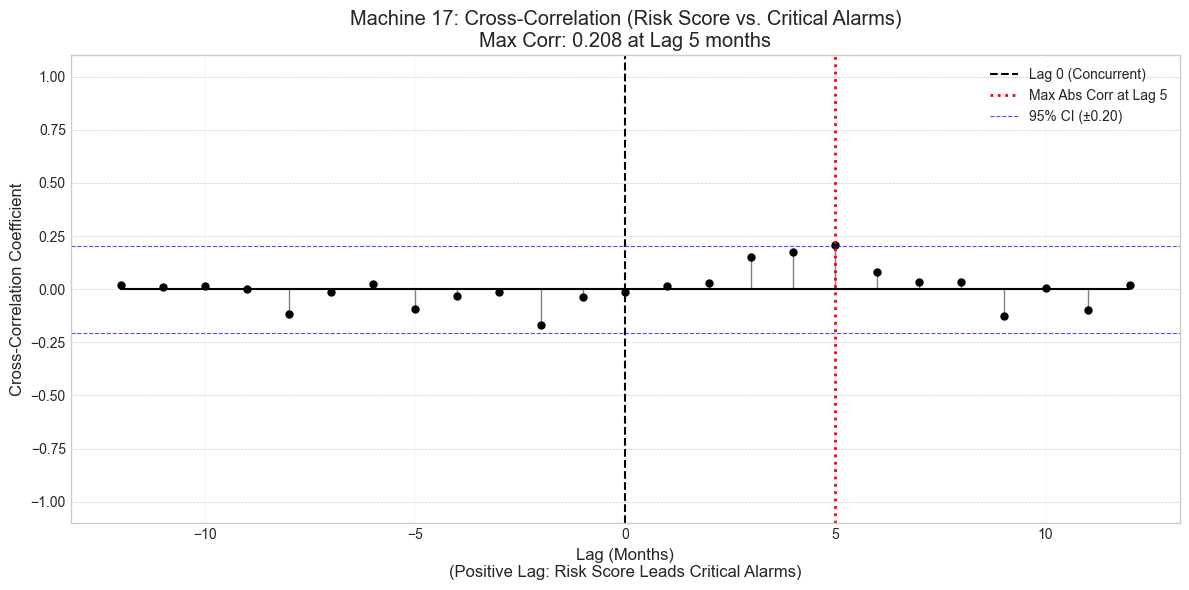


--- Analyzing MachineID: 18 ---
   Max correlation: -0.338 at lag -6 months.
      ⚠️  LAGGING: Critical alarms lead risk score by 6 months.


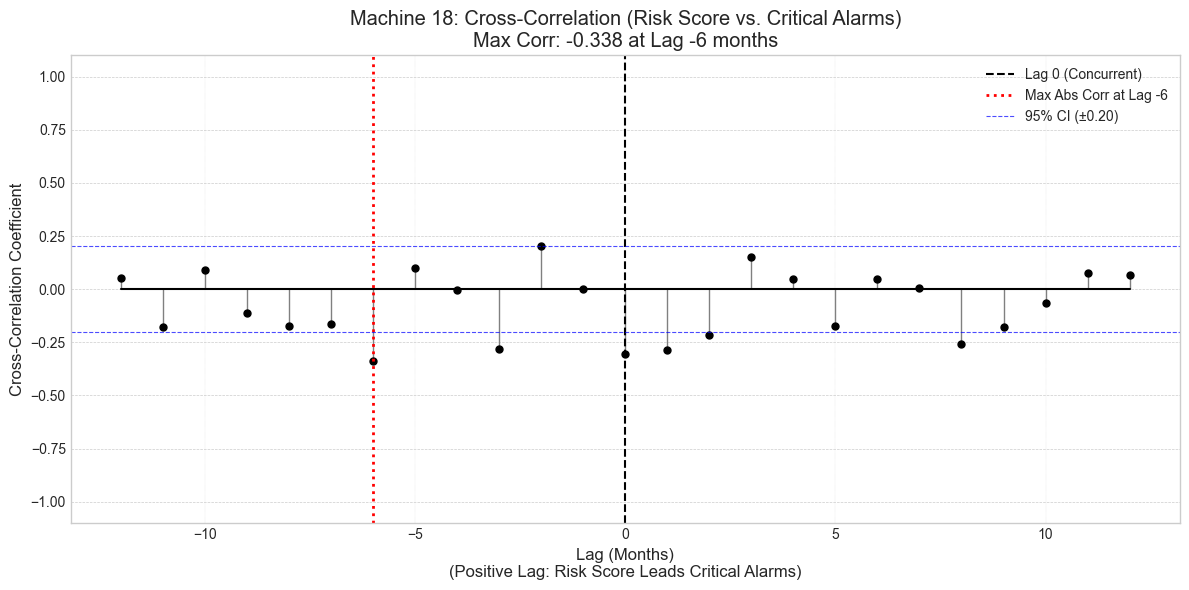



📊 REFINED CROSS-CORRELATION SUMMARY TABLE
    MachineID                       Status  LagAtMaxCorrelation  MaxCorrelation  CorrelationAtLag0  CorrelationAtLag1  CorrelationAtLag2  CorrelationAtLag3  CorrelationAtLag-1  CorrelationAtLag-2  CorrelationAtLag-3
0           1                     Analyzed                8.000           0.253             -0.116              0.102             -0.100              0.023               0.038              -0.006               0.083
1           4  Skipped - Insufficient Data                  NaN             NaN                NaN                NaN                NaN                NaN                 NaN                 NaN                 NaN
2           6                     Analyzed               10.000          -0.305              0.034              0.025              0.070             -0.125              -0.001               0.250               0.259
3           7                     Analyzed               10.000           0.219             

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from statsmodels.tsa.stattools import ccf
from pathlib import Path

print("🔬 PHASE 9.3 (Refined Validation): Cross-Correlation Analysis with Critical Alarms")
print("=" * 80)
print("📋 Goal: Quantify lead/lag relationship using ONLY critical alarms as ground truth.")
print()

# --- Load the refined data from Phase 9.2 ---
if 'combined_machine_trends_df_phase9' not in globals() or globals()['combined_machine_trends_df_phase9'].empty:
    print("❌ Error: 'combined_machine_trends_df_phase9' DataFrame not found or is empty.")
    print("   Please ensure Phase 9.2 (refined with critical alarms) has been run successfully.")
    raise ValueError("Required refined DataFrame not found.")

merged_data_trend_comparison = globals()['combined_machine_trends_df_phase9'].copy()
print(f"✅ Using refined 'combined_machine_trends_df_phase9' (Shape: {merged_data_trend_comparison.shape})")

# Ensure data is properly formatted
merged_data_trend_comparison['plot_date'] = pd.to_datetime(merged_data_trend_comparison['plot_date'])
merged_data_trend_comparison = merged_data_trend_comparison.sort_values(by=['MachineID', 'plot_date'])

# --- Parameters ---
SELECTED_MACHINE_IDS_FOR_CCF = merged_data_trend_comparison['MachineID'].unique().tolist()
if len(SELECTED_MACHINE_IDS_FOR_CCF) > 15:  # Increased from 10 to see more machines
    print(f"   Warning: Many unique MachineIDs ({len(SELECTED_MACHINE_IDS_FOR_CCF)}). Limiting CCF plots to first 15 for analysis.")
    SELECTED_MACHINE_IDS_FOR_CCF = SELECTED_MACHINE_IDS_FOR_CCF[:15]

MAX_LAG = 12  # Maximum months to check for lead/lag
MIN_PERIODS_FOR_CORR = max(12, MAX_LAG + 1)

results_summary = []
plt.style.use('seaborn-v0_8-whitegrid')

print(f"   Analyzing {len(SELECTED_MACHINE_IDS_FOR_CCF)} machines for cross-correlation patterns...")

# --- Cross-Correlation Analysis ---
for machine_id in SELECTED_MACHINE_IDS_FOR_CCF:
    print(f"\n--- Analyzing MachineID: {machine_id} ---")
    machine_data = merged_data_trend_comparison[merged_data_trend_comparison['MachineID'] == machine_id].copy()
    
    # Check sufficient data
    if len(machine_data) < MIN_PERIODS_FOR_CORR:
        print(f"   Skipping MachineID {machine_id} due to insufficient data points (found {len(machine_data)}, need {MIN_PERIODS_FOR_CORR}).")
        results_summary.append({
            'MachineID': machine_id, 'Status': 'Skipped - Insufficient Data', 
            'LagAtMaxCorrelation': np.nan, 'MaxCorrelation': np.nan,
            'CorrelationAtLag0': np.nan, 'CorrelationAtLag1': np.nan,
            'CorrelationAtLag2': np.nan, 'CorrelationAtLag3': np.nan,
            'CorrelationAtLag-1': np.nan, 'CorrelationAtLag-2': np.nan, 'CorrelationAtLag-3': np.nan,
        })
        continue

    # Extract series
    risk_scores = machine_data['avg_monthly_risk_score'].fillna(0).values
    alarm_counts = machine_data['actual_monthly_alarm_count'].fillna(0).values

    # Check for constant series
    if np.std(risk_scores) < 1e-9 or np.std(alarm_counts) < 1e-9:
        print(f"   Skipping MachineID {machine_id} because at least one series is constant.")
        results_summary.append({
            'MachineID': machine_id, 'Status': 'Skipped - Constant Series', 
            'LagAtMaxCorrelation': np.nan, 'MaxCorrelation': np.nan,
            'CorrelationAtLag0': np.nan, 'CorrelationAtLag1': np.nan,
            'CorrelationAtLag2': np.nan, 'CorrelationAtLag3': np.nan,
            'CorrelationAtLag-1': np.nan, 'CorrelationAtLag-2': np.nan, 'CorrelationAtLag-3': np.nan,
        })
        continue
        
    nlags = min(MAX_LAG, len(risk_scores) - 1)
    if nlags < 1:
        print(f"   Skipping MachineID {machine_id} because series too short for lags.")
        results_summary.append({
            'MachineID': machine_id, 'Status': 'Skipped - Too short for lags', 
            'LagAtMaxCorrelation': np.nan, 'MaxCorrelation': np.nan,
            'CorrelationAtLag0': np.nan, 'CorrelationAtLag1': np.nan,
            'CorrelationAtLag2': np.nan, 'CorrelationAtLag3': np.nan,
            'CorrelationAtLag-1': np.nan, 'CorrelationAtLag-2': np.nan, 'CorrelationAtLag-3': np.nan,
        })
        continue

    # Compute cross-correlation
    ccf_positive_lags = ccf(risk_scores, alarm_counts, adjusted=False, fft=True)[:nlags+1] 
    ccf_negative_lags_temp = ccf(alarm_counts, risk_scores, adjusted=False, fft=True)[1:nlags+1]
    
    lags = np.arange(-nlags, nlags + 1)
    cross_corr_values = np.concatenate((np.flip(ccf_negative_lags_temp), ccf_positive_lags))
    
    if len(lags) != len(cross_corr_values):
        print(f"   Machine {machine_id}: Lag/CCF array mismatch. Skipping.")
        results_summary.append({
            'MachineID': machine_id, 'Status': 'Skipped - Lag/CCF array mismatch',
            'LagAtMaxCorrelation': np.nan, 'MaxCorrelation': np.nan,
            'CorrelationAtLag0': np.nan, 'CorrelationAtLag1': np.nan,
            'CorrelationAtLag2': np.nan, 'CorrelationAtLag3': np.nan,
            'CorrelationAtLag-1': np.nan, 'CorrelationAtLag-2': np.nan, 'CorrelationAtLag-3': np.nan,
        })
        continue

    # Find maximum correlation
    max_corr_idx = np.argmax(np.abs(cross_corr_values))
    lag_at_max_corr = lags[max_corr_idx]
    max_corr_value = cross_corr_values[max_corr_idx]

    print(f"   Max correlation: {max_corr_value:.3f} at lag {lag_at_max_corr} months.")
    if lag_at_max_corr > 0:
        print(f"      ✅ POSITIVE LEAD: Risk score leads critical alarms by {lag_at_max_corr} months.")
    elif lag_at_max_corr < 0:
        print(f"      ⚠️  LAGGING: Critical alarms lead risk score by {-lag_at_max_corr} months.")
    else:
        print(f"      🔄 CONCURRENT: Strongest correlation is contemporaneous.")

    # Store results
    current_machine_results = {'MachineID': machine_id, 'Status': 'Analyzed'}
    current_machine_results['LagAtMaxCorrelation'] = lag_at_max_corr
    current_machine_results['MaxCorrelation'] = max_corr_value
    
    # Get specific lag correlations
    for specific_lag in [0, 1, 2, 3, -1, -2, -3]:
        if specific_lag in lags:
            idx = np.where(lags == specific_lag)[0]
            if len(idx) > 0:
                current_machine_results[f'CorrelationAtLag{specific_lag}'] = cross_corr_values[idx[0]]
            else:
                current_machine_results[f'CorrelationAtLag{specific_lag}'] = np.nan
        else:
            current_machine_results[f'CorrelationAtLag{specific_lag}'] = np.nan
    results_summary.append(current_machine_results)

    # Plot only if correlation is significant (abs > 0.2) or shows positive leading pattern
    if abs(max_corr_value) > 0.2 or (lag_at_max_corr > 0 and max_corr_value > 0.1):
        plt.figure(figsize=(12, 6))
        markerline, stemlines, baseline = plt.stem(lags, cross_corr_values, basefmt="k-")
        plt.setp(markerline, mec='black', mfc='black', markersize=5)
        plt.setp(stemlines, linestyle='-', color='grey', linewidth=1)
        
        plt.title(f'Machine {machine_id}: Cross-Correlation (Risk Score vs. Critical Alarms)\nMax Corr: {max_corr_value:.3f} at Lag {lag_at_max_corr} months')
        plt.xlabel('Lag (Months)\n(Positive Lag: Risk Score Leads Critical Alarms)')
        plt.ylabel('Cross-Correlation Coefficient')
        plt.axvline(0, color='black', linestyle='--', lw=1.5, label='Lag 0 (Concurrent)')
        if lag_at_max_corr != 0:
             plt.axvline(lag_at_max_corr, color='red', linestyle=':', lw=2, label=f'Max Abs Corr at Lag {lag_at_max_corr}')

        # Confidence intervals
        conf_int_val = 1.96 / np.sqrt(len(risk_scores))
        plt.axhline(conf_int_val, color='blue', linestyle='--', linewidth=0.8, alpha=0.7, label=f'95% CI (±{conf_int_val:.2f})')
        plt.axhline(-conf_int_val, color='blue', linestyle='--', linewidth=0.8, alpha=0.7)

        plt.ylim(min(np.min(cross_corr_values)-0.1, -1.1), max(np.max(cross_corr_values)+0.1, 1.1))
        plt.grid(True, which='major', linestyle='--', linewidth=0.5, axis='y')
        plt.grid(True, which='major', linestyle=':', linewidth=0.3, axis='x')
        plt.legend(loc='best')
        plt.tight_layout()
        plt.show()

# --- Summary Analysis ---
print("\n\n📊 REFINED CROSS-CORRELATION SUMMARY TABLE")
print("=" * 80)
if not results_summary:
    print("No results to summarize.")
else:
    summary_df = pd.DataFrame(results_summary)
    cols_order = ['MachineID', 'Status', 'LagAtMaxCorrelation', 'MaxCorrelation', 
                  'CorrelationAtLag0', 'CorrelationAtLag1', 'CorrelationAtLag2', 'CorrelationAtLag3',
                  'CorrelationAtLag-1', 'CorrelationAtLag-2', 'CorrelationAtLag-3']
    final_cols = [col for col in cols_order if col in summary_df.columns]
    summary_df = summary_df[final_cols]
    
    print(summary_df.to_string(float_format="%.3f"))
    globals()['refined_cross_correlation_summary_df'] = summary_df

    # --- Key Performance Metrics ---
    analyzed_machines = summary_df[summary_df['Status'] == 'Analyzed']
    if not analyzed_machines.empty:
        print(f"\n🎯 KEY VALIDATION METRICS:")
        print(f"   • Machines successfully analyzed: {len(analyzed_machines)}")
        
        # Positive leading indicators (what we want to see)
        positive_leaders = analyzed_machines[
            (analyzed_machines['LagAtMaxCorrelation'] > 0) & 
            (analyzed_machines['MaxCorrelation'] > 0)
        ]
        print(f"   • Machines showing POSITIVE LEADING pattern: {len(positive_leaders)} ({len(positive_leaders)/len(analyzed_machines)*100:.1f}%)")
        
        # Strong correlations (abs > 0.3)
        strong_correlations = analyzed_machines[abs(analyzed_machines['MaxCorrelation']) > 0.3]
        print(f"   • Machines with strong correlations (|r| > 0.3): {len(strong_correlations)}")
        
        # Average lag for positive correlations
        positive_corrs = analyzed_machines[analyzed_machines['MaxCorrelation'] > 0]
        if not positive_corrs.empty:
            avg_lead_time = positive_corrs['LagAtMaxCorrelation'].mean()
            print(f"   • Average lead time for positive correlations: {avg_lead_time:.1f} months")
        
        print(f"\n📈 BEST PERFORMING MACHINES (Positive Leading Indicators):")
        if not positive_leaders.empty:
            best_machines = positive_leaders.nlargest(3, 'MaxCorrelation')[['MachineID', 'LagAtMaxCorrelation', 'MaxCorrelation']]
            for _, row in best_machines.iterrows():
                print(f"   • Machine {row['MachineID']}: {row['MaxCorrelation']:.3f} correlation at {row['LagAtMaxCorrelation']:.0f} months lead")
        else:
            print("   ⚠️  No machines show strong positive leading indicators")

print("\n" + "="*80)
print("🔬 PHASE 9.3 (Refined Validation): Cross-Correlation Analysis Complete.")
print("   Next: Evaluate results and consider additional validation methods if needed.")
print("=" * 80)

---

------

Here’s what to do at the end of your pipeline to refine anomaly detection by ignoring the basic rule-based tier (Tier 1):

⸻

💡 Step 1: Define a New Final Flag

Only consider anomalies flagged by:
	•	Tier 2 (ensemble score, usually via DBSCAN/PCA thresholds)
	•	Tier 3 (per-machine Isolation Forest)

df['refined_anomaly_flag'] = (
    (df['tier2_flag_95'] == 1) |
    (df['tier3_flag'] == 1)
).astype(int)

💡 Step 2: Create a Weighted Final Score

You can also weight the anomaly scores from both tiers for prioritization:

df['weighted_anomaly_score'] = (
    0.4 * df['ensemble_score_mean'] + 
    0.6 * df['tier3_anomaly_score']
)

Adjust the weights depending on which tier you trust more.

⸻

📈 Why Exclude Tier 1?
	•	Rule-based thresholds (z > 3, etc.) tend to be:
	•	Too sensitive in some cases (false positives)
	•	Too rigid to generalize across machines
	•	Tier 2 and Tier 3 are more adaptive and trained on clean data patterns.

⸻


Right now, you're only calculating the temperature control error using:

temp_control_error = meas_temp1_smoothed - setpoint_temp1

But each setter incubator has multiple sections (usually 6), each with its own:
meas_temp{1-6} (measured temperature)
setpoint_temp{1-6} (desired target temp)
🔎 Why only temp1 was used
The notebook currently only uses meas_temp1_smoothed and setpoint_temp1 likely because:
It's simpler for prototyping
temp1 might correspond to a reference section (e.g. center)
Or the other columns might have been messy/incomplete in early runs

Why that’s a limitation

By using only section 1, you risk:
	•	Missing issues in other areas of the machine (e.g. edge cooling failure)
	•	False assumptions about overall control performance
	•	Underpowered models, since you’re ignoring 5/6 of the thermal context

This contradicts your earlier insight:

“A problem can appear anywhere essentially because different parts act differently and work harder or less throughout the phase.”

⸻

✅ Recommended improvement

You should compute section-specific control gaps for all six sections, like:


for i in range(1, 7):
    feature_data[f'temp_control_error_{i}'] = feature_data[f'meas_temp{i}_smoothed'] - feature_data[f'setpoint_temp{i}']


Then:
	•	Normalize these per phase (z-scores)
	•	Add them all to the anomaly model inputs
	•	Optionally: compute mean, std, max across sections to create summary features

⸻

🧠 Bonus idea: spatial awareness

If you combine this with MachinePositions (edge vs center), you can even:
	•	Compare edge vs center gaps
	•	Detect asymmetric failures (e.g. one side not cooling)

Would you like a code snippet that integrates all six sections into your feature engineering logic?


You want to:
	1.	Remove Tier 1 (rule-based) from the anomaly detection logic.
	2.	Improve model precision and relevance by using only:
	•	Tier 2: Ensemble anomaly scores (PCA + DBSCAN + IF).
	•	Tier 3: Per-machine Isolation Forest models.
	3.	Visualize per-cycle behavior:
	•	Show anomaly scores over time within a cycle.
	•	Overlay with key metrics: temperature, %cooling, %heating, and variability.
	•	Mark cycle phases (Startup, Steady, Hatch) and windowed flags (e.g. anomaly detected).
	4.	Track machines over time:
	•	Show monthly rolling risk scores for top-N machines.
	•	Highlight trends: e.g., increasing risk leading up to high anomaly states.
	5.	Support explainability and diagnosis:
	•	Help humans interpret how/when systems drift.
	•	Show anomaly distributions by phase, risk per machine, and section-level trends.

What Needs To Be Done (Next Implementation Tasks)
✅ 1. Disable Tier 1 logic
In Phase 5, remove:

    window_stats['tier1_any_flag'] = ...
Or explicitly set it to 0 for all windows:

    windows_df['tier1_any_flag'] = 0
In Phase 6, adjust:

    tier_flag_cols = ['tier2_flag_95', 'tier3_flag', 'any_anomaly']
✅ 2. Re-define any_anomaly without Tier 1

 windows_df['any_anomaly'] = (
    (windows_df.get('tier2_flag_95', 0) == 1) |
    (windows_df.get('tier3_flag', 0) == 1)
).astype(int)
 3. Create Per-Cycle Visual Timeline
For a selected CycleID, plot:
Top subplot: Measured vs setpoint temperature, %cooling, %heating.
Bottom subplot: Ensemble anomaly score, Tier 2 flag, Tier 3 flag.
Use window_center_hours on X-axis.
Mark cycle phases and highlight anomalies (colored bars or dots).
You can base this on the layout in the earlier timeline from Phase 5 (Cycle 19) but improve by:
Adding all temperature control and cooling/heating metrics.
Annotating the phase regions.
Possibly include CO₂ or ΔT chamber.
📈 4. Monthly Risk Trend Charts
Already implemented, but you could improve:
Color by risk category (e.g., low/medium/high).
Add tooltips or event markers (e.g., valve replacements).
Tie these back to cycle-level stats.
📉 5. Deviation Explorer by Phase
Use:
PCA feature importances.
Phase-distribution histograms (already exist).
Add per-phase Z-score trendlines to show if systems get noisier in later phases.
✍️ Summary Text for Report (If You Need It)
In our final implementation, we excluded the Tier 1 (rule-based) model due to low precision and inconsistent generalization across machines.
Instead, we focused on a dual-tier anomaly framework:
Tier 2 leverages ensemble anomaly scores (PCA, DBSCAN, Isolation Forest) trained on clean baseline behavior.
Tier 3 uses Isolation Forest per machine trained on unflagged windows, capturing individual degradation patterns.
We then analyze machine behavior via phase-aware per-cycle metrics and monthly trend tracking. By removing Tier 1 and aligning the model closer with physical deviations in cooling/heating control, we increased model specificity and interpretability — key for actionable predictive maintenance.